# Construction of a prediction model for Covid19
## Part 2 (for part one look at the DataExploration notebook)

In [249]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.dummy import DummyClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [250]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

covid19_test_results  age high_risk_exposure_occupation  \
0                 Negative    4                          True   
1                 Negative    2                         False   
2                 Negative    1                           NaN   
3                 Negative    3                          True   
4                 Negative    1                         False   
...                    ...  ...                           ...   
93989             Negative    3                         False   
93990             Negative    3                         False   
93991             Negative    3                         False   
93993             Negative    3                         False   
93994             Negative    2                         False   

      high_risk_interactions  diabetes    chd    htn  cancer  asthma  \
0                        NaN     False  False  False   False   False   
1                        NaN     False  False  False   False   False   
2                        NaN     False  False  False   False   False   
3                       True     False  False  False   False   False   
4                        NaN     False  False  False   False   False   
...                      ...       ...    ...    ...     ...     ...   
93989                   True     False  False  False   False   False   
93990                   True     False  False  False   False   False   
93991                  False     False  False  False   False   False   
93993                  False     False  False  False   False   False   
93994                  False     False  False  False   False   False   

       autoimmune_dis  ...    sob  sob_severity  diarrhea  fatigue  headache  \
0               False  ...  False           0.0     False    False     False   
1               False  ...  False           0.0     False    False     False   
2               False  ...    NaN           NaN       NaN      NaN       NaN   
3               False  ...   True           2.0     False     True     False   
4               False  ...  False           0.0     False    False     False   
...               ...  ...    ...           ...       ...      ...       ...   
93989           False  ...  False           0.0     False    False     False   
93990           False  ...  False           0.0     False    False     False   
93991           False  ...  False           0.0     False    False     False   
93993           False  ...  False           0.0     False    False     False   
93994           False  ...  False           0.0     False    False     False   

       loss_of_smell  loss_of_taste runny_nose muscle_sore sore_throat  
0              False          False      False       False       False  
1              False          False      False       False       False  
2                NaN            NaN        NaN         NaN         NaN  
3              False          False      False       False        True  
4              False          False      False       False       False  
...              ...            ...        ...         ...         ...  
93989          False          False      False       False       False  
93990          False          False       True       False        True  
93991          False          False      False       False       False  
93993          False          False      False       False       False  
93994          False          False      False       False       False  

[51695 rows x 35 columns]

In [251]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

X, test_x, y, test_y = train_test_split(X, y, test_size=.1)

## Splitting the data

Given that the data appears in the dictionary as taken by blocks (and seen how that matches the proportion of null values for every group) I have decided to split the data into the 4 types:<br>
- <u>Epidemiological factors:</u> 'age', 'high_risk_exposure_occupation' and 'high_risk_interactions'. These will be included in all datasets since I believe it might affect the results greatly and could be easily ignored for experimentation purposes. 
- <u>Comorbidities:</u> All columns from 'diabetes' to 'smoker'. Since this is the most complete dataset (almost all instances in the original dataset are not null) we will start with this.
- <u>Vitals:</u> All of the continues values ('temperature', 'pulse', etc.) I try to use simple linear regression and compare it against both trees and xgboost algorithms.
- <u>Clinician Assessed symptoms:</u> 'ctab', 'labored_respiration', 'rhonchi' and 'wheezes'. I will use naive bayes, trees and/or xgboost.
- <u>Patient reported symptoms:</u> All remaining columns. Again, naive bayes, trees and/or xgboost.

After I have each dataset, I will impute the null corresponding to the most frequent in each case and train several models for each one of them

In [252]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [253]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [254]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [255]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    '''
        Gets evaluation metrics for a set of predictions
        values: a tuple in the form of '(actual, predictions)'
    '''
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [256]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [257]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [258]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [259]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None, class_threshold=.5):
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    data_x = data_x.sample(data_x.shape[0])
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y[train_x.index]
        valid_x = data_x.iloc[start:end]
        valid_y = data_y[valid_x.index]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
        
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0), results.std(ddof=1, axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, plot_roc=True, feature_importances=True):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - (fold_size * ratio_negatives_to_positives)), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        
        rest_of_x = data_x.loc[~data_x.index.isin(train_x.index)] ## Al data not used by training
        valid_x = pd.concat([rest_of_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
                    
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        
        
        if plot_roc:
            roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
                      
            fig, ax = plt.subplots(1, 2, sharey=True, figsize=(21,7))
            
            ax[0].plot(roc_values[2], roc_values[0], 'b-', label="Recall")
            ax[0].plot(roc_values[2], roc_values[1], 'r-', label="FPR")
            ax[0].set(xlabel = "Thresholds")
            ax[0].legend()
            
             ## The following lines produce the same result as calling the 'sklearn.metrics.plot_roc_curve'
            ax[1].plot(roc_values[0], roc_values[1], 'b-')
            ax[1].set(xlabel = "FPR (1-specificity)", ylabel= "TPR (recall)")
            
            #plot_roc_curve(model, test_shap_x, data_y[test_shap_x.index], drop_intermediate=True)
            plt.show()
        
        if feature_importances:
            #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
            #sample = data_x.sample(fold_size)
            #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
            #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
            PI = eli5.sklearn.PermutationImportance(model)
            PI.fit(test_shap_x, data_y[test_shap_x.index])
            print("feature_importances")
            display(eli5.show_weights(model, feature_names=list(data_x.columns)))
            print("Permutation Importance")
            display(eli5.show_weights(PI, feature_names=list(data_x.columns)))
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0), results.std(ddof=1, axis=0) # 'ddof=1' means the divisor will be n-1 (ddof is degrees of freedom) since this is a sample of all possible results

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    
    threshold_scores = np.zeros((5,thresholds.shape[0]))
    i = 0 #the threshold index im in
    for t in thresholds:
        
        
        results_mean, results_std = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=ratio_negatives_to_positives, class_threshold=t, plot_roc=False, feature_importances=False)
        print("Threshold:", t)       
        
        for metric in range(5):
            threshold_scores[metric,i] = results_mean[1][metric]      
        i+=1
    
    plt.figure(figsize=(21,7))
    plt.plot(thresholds, threshold_scores[0], label="Accuracy")
    plt.plot(thresholds, threshold_scores[1], label="Recall")
    plt.plot(thresholds, threshold_scores[2], label="Precision")
    plt.plot(thresholds, threshold_scores[3], label="Specificity")
    plt.plot(thresholds, threshold_scores[4], label="F1 score")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(threshold_scores, index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    result_table = np.zeros((2,len(models), 6))
    i = 0
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results_mean, results_std = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results_mean, results_std = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    
            
            result_table[0,i] = results_mean[1]
            result_table[1,i] = results_std[1]
            
            print("")
            print("Mean metrics")
            display(pd.DataFrame(results_mean, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("Spread in metrics (sample std)")
            display(pd.DataFrame(results_std, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            
        except Exception as e:
            print(e)
        i+=1
        
    
    display(pd.DataFrame(result_table[0], index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
    
    # The 2 in here is an aproximation of the t/z critical value (1.96 for z, and 2.2 for 9 degrees of freedom, so 2 is a good indication for certainty above 90%, reaching towards 95%)
    lower_bound_df = pd.DataFrame((result_table[0]- 2*(result_table[1] / np.sqrt(folds))).astype("str"), index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]) # We use a value of 2 stds for a 95% confidence level
    upper_bound_df = pd.DataFrame((result_table[0]+ 2*(result_table[1] / np.sqrt(folds))).astype("str"), index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"])
    interval_df = lower_bound_df + "-" + upper_bound_df
    
    display(interval_df)

In [260]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"), #does not have predict_proba
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [165]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46525 entries, 46889 to 47067
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        46525 non-null  bool 
 1   chd             46525 non-null  bool 
 2   htn             46525 non-null  bool 
 3   cancer          46525 non-null  bool 
 4   asthma          46525 non-null  bool 
 5   autoimmune_dis  46525 non-null  bool 
 6   smoker          46525 non-null  bool 
dtypes: bool(7)
memory usage: 681.5 KB


Dummy Random
╠■■■■■■■■■╣


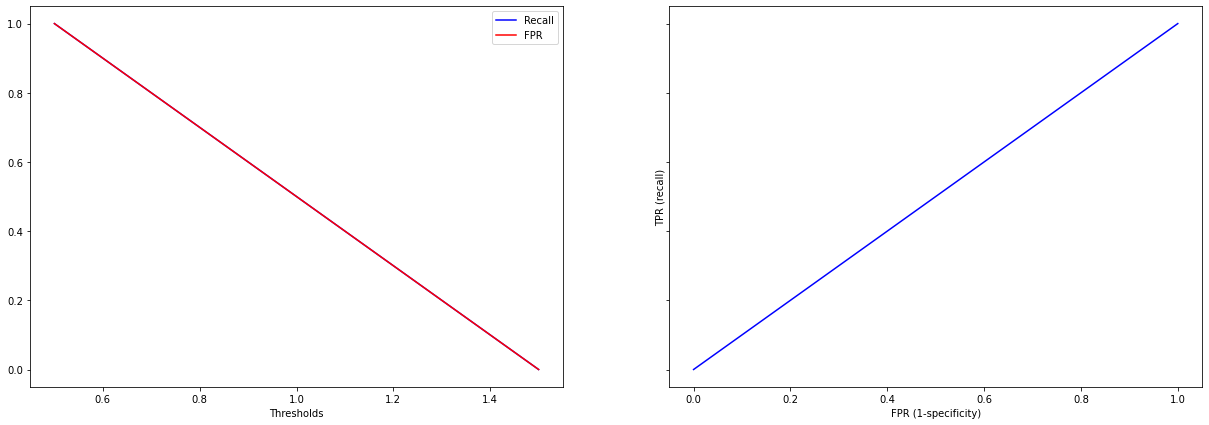

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500050     0.0        0.0          1.0  0.0      0.5
Validation  0.499548     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000106     0.0        0.0          0.0  0.0      0.0
Validation  0.000954     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


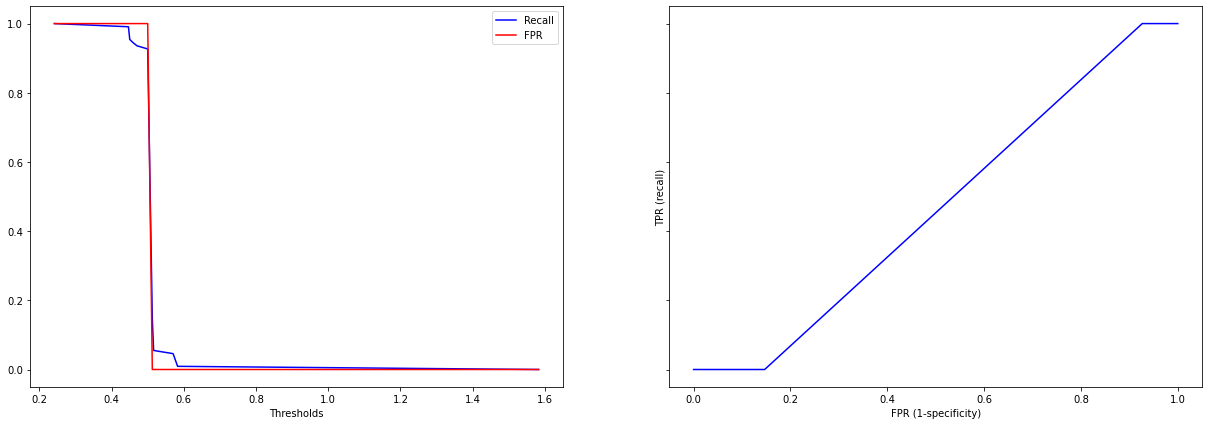

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.507965  0.072693   0.586623     0.943145  0.127368  0.518702
Validation  0.505450  0.065373   0.565020     0.946364  0.115322  0.510777

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003246  0.022392   0.080917     0.024725  0.036474  0.004174
Validation  0.010933  0.026061   0.126133     0.028572  0.042572  0.025166

Random Forest (100 estimators)
╠■■■■■■■■■╣


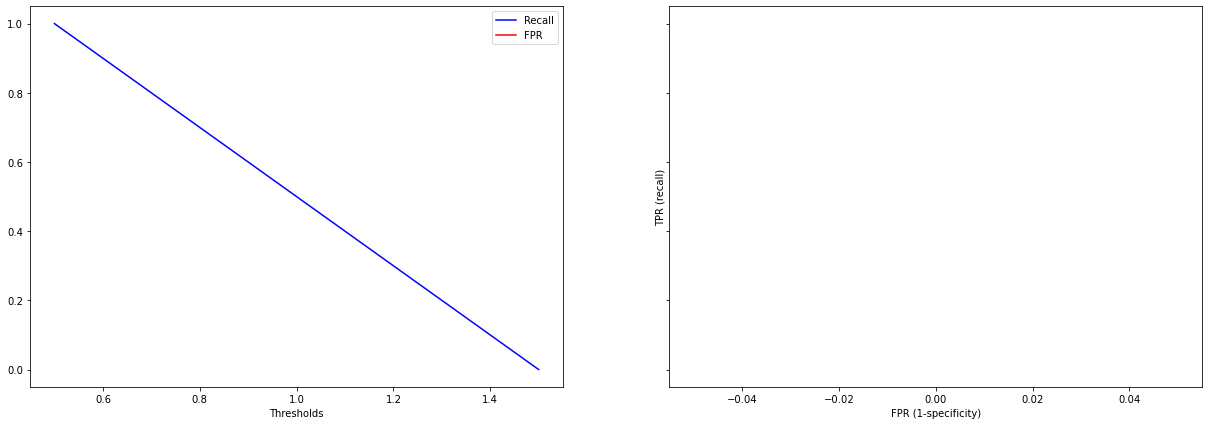

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity        F1   ROC_AUC
Training         0.5     0.3   0.149975          0.7  0.199978  0.499849
Validation       0.5     0.3   0.150226          0.7  0.200201  0.500000

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000119  0.483046   0.241482     0.483046  0.321995  0.000478
Validation  0.001067  0.483046   0.241888     0.483046  0.322354  0.000000

XGBoost Classifier
╠■■■■■■■■■╣


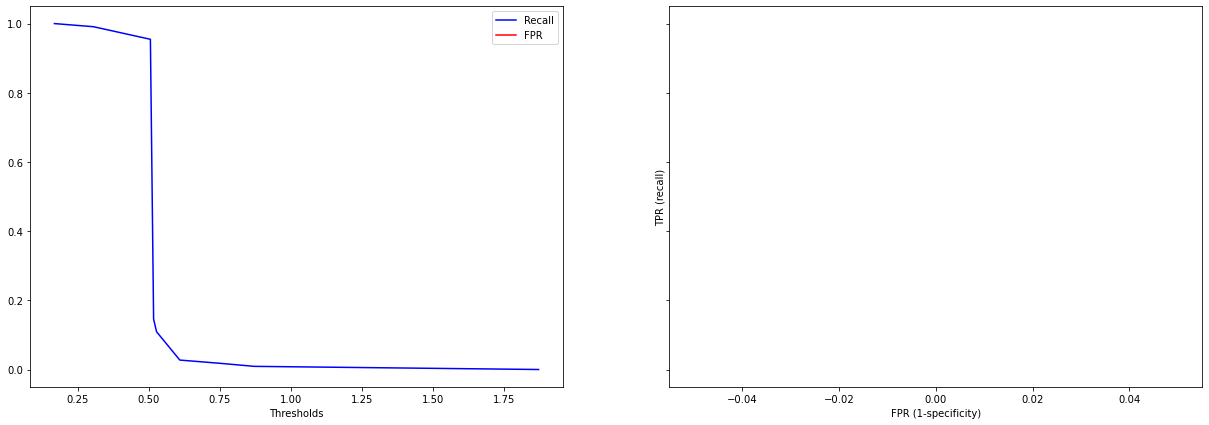

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.518803  0.809556   0.518445     0.228125  0.599177  0.528408
Validation  0.498180  0.796560   0.508178     0.199091  0.585726  0.498857

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006460  0.255910   0.023086     0.251538  0.158711  0.006607
Validation  0.020843  0.255554   0.034225     0.263007  0.156640  0.012445

SVM
╠■■■■■■■■■╣


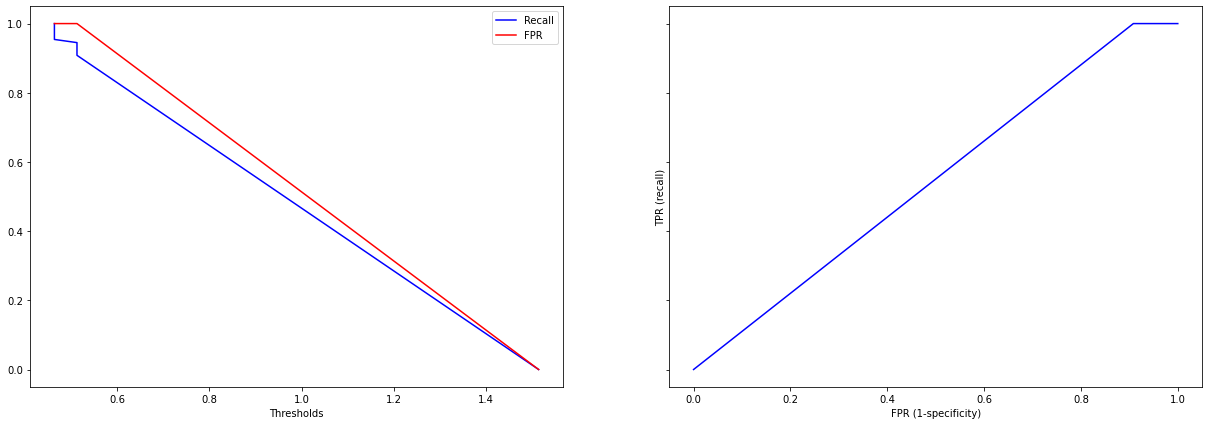

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.502319  0.492628   0.403658     0.512097  0.376525  0.503305
Validation  0.493196  0.480172   0.372635     0.505455  0.365212  0.489407

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.015931  0.457577   0.170522     0.434206  0.300627  0.020535
Validation  0.021619  0.453980   0.209947     0.442636  0.300339  0.026522

KNN
╠■■■■■■■■■╣


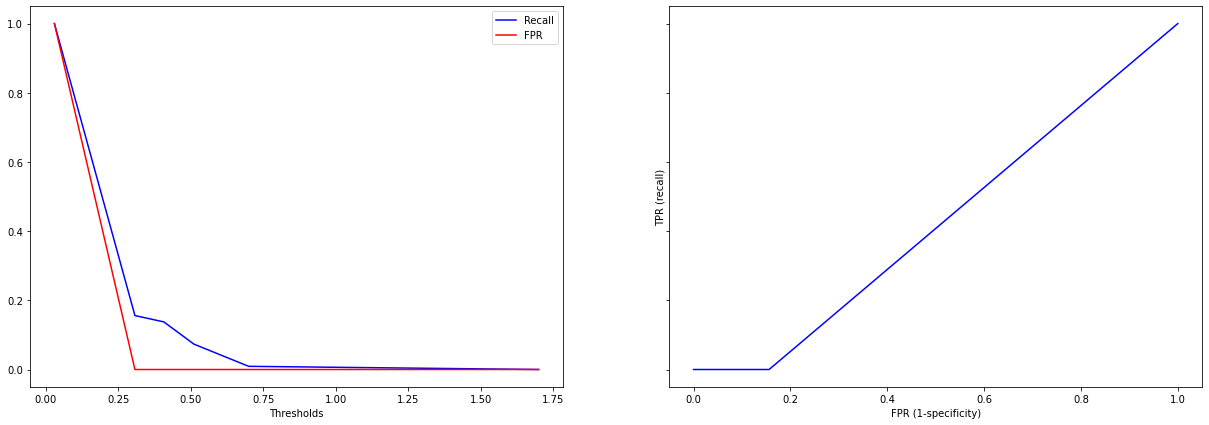

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.509073  0.030751   0.726167     0.987298  0.058690  0.498524
Validation  0.501812  0.025422   0.622857     0.979091  0.047762  0.490321

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001251  0.009422   0.063636     0.008503  0.016551  0.005335
Validation  0.014988  0.018086   0.376755     0.033209  0.032741  0.028879

Logistic Regression
╠■■■■■■■■■╣


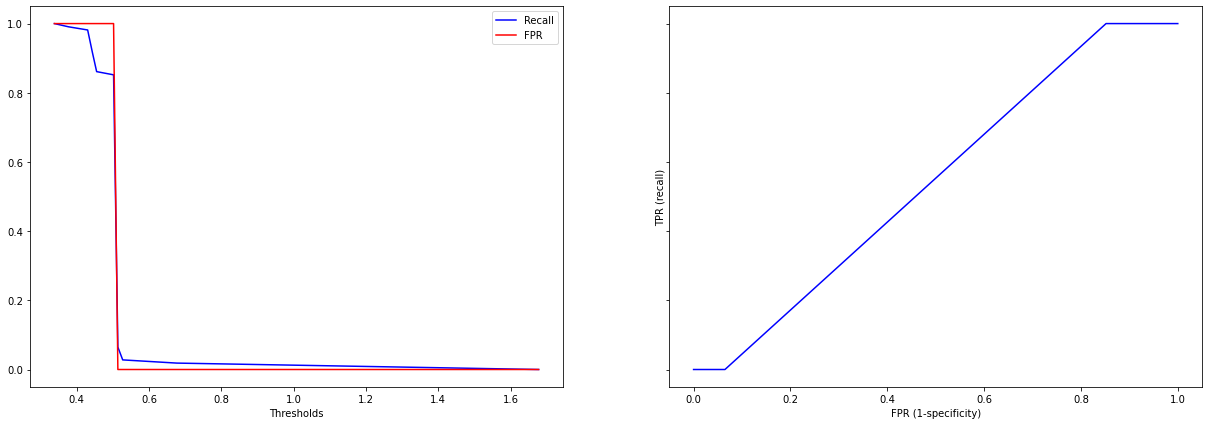

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.513005  0.882030   0.507530     0.144052  0.644171  0.519335
Validation  0.514984  0.882056   0.508896     0.147273  0.645203  0.517060

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004984  0.024687   0.003069     0.032980  0.004804  0.004464
Validation  0.022979  0.042178   0.013081     0.040836  0.019220  0.016466

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499548  0.000000   0.000000     1.000000   
MultinomialNB                   0.505450  0.065373   0.565020     0.946364   
Random Forest (100 estimators)  0.500000  0.300000   0.150226     0.700000   
XGBoost Classifier              0.498180  0.796560   0.508178     0.199091   
SVM                             0.493196  0.480172   0.372635     0.505455   
KNN                             0.501812  0.025422   0.622857     0.979091   
Logistic Regression             0.514984  0.882056   0.508896     0.147273   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.115322  0.510777  
Random Forest (100 estimators)  0.200201  0.500000  
XGBoost Classifier              0.585726  0.498857  
SVM                             0.365212  0.489407  
KNN                             0.047762  0.490321  
Logistic Regression             0.645203  0.517060

Accuracy  \
Dummy Random                     0.4989441930618401-0.5001508295625943   
MultinomialNB                   0.49853609175517716-0.5123647720868632   
Random Forest (100 estimators)   0.4993254696900453-0.5006745303099547   
XGBoost Classifier              0.48499735969149177-0.5113621631386194   
SVM                             0.47952337655808003-0.5068690545402336   
KNN                                0.49233282108348-0.5112912019523078   
Logistic Regression              0.5004506101920508-0.5295164815397467   

                                                                   Recall  \
Dummy Random                                                      0.0-0.0   
MultinomialNB                      0.0488900509217354-0.08185523982355533   
Random Forest (100 estimators)  -0.0055050463303893404-0.6055050463303893   
XGBoost Classifier                  0.6349338180472992-0.9581865750730938   
SVM                                0.19304987785343558-0.7672941024905449   
KNN                               0.01398307528617799-0.03686049555739286   
Logistic Regression                 0.8553802214097004-0.9087311627016834   

                                                                Precision  \
Dummy Random                                                      0.0-0.0   
MultinomialNB                      0.48524655134911365-0.6447931311905689   
Random Forest (100 estimators)  -0.0027571704714295098-0.3032096591592123   
XGBoost Classifier                 0.48653189048349965-0.5298235167876346   
SVM                                0.23985281859217386-0.5054176522386644   
KNN                                0.38457658006152157-0.8611377056527643   
Logistic Regression                 0.5006231483586909-0.5171693289849753   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                     0.9282932708898479-0.9644340018374251   
Random Forest (100 estimators)    0.3944949536696106-1.0055050463303892   
XGBoost Classifier              0.03275073301145115-0.36543108517036704   
SVM                              0.22550702315198518-0.7854020677571059   
KNN                               0.9580876079379838-1.0000942102438346   
Logistic Regression              0.12144572636040907-0.1730997281850455   

                                                                       F1  \
Dummy Random                                                      0.0-0.0   
MultinomialNB                     0.08839700235400201-0.14224740186073176   
Random Forest (100 estimators)  -0.0036740086613862855-0.4040756150870891   
XGBoost Classifier                  0.4866582566836539-0.6847940023504344   
SVM                                0.17526131331028932-0.5551631839233935   
KNN                              0.027054114368283734-0.06846912181211309   
Logistic Regression                 0.6330468853520698-0.6573582985002785   

                                                               ROC_AUC  
Dummy Random                                                   0.5-0.5  
MultinomialNB                     0.494860919644535-0.5266932460914489  
Random Forest (100 estimators)                                 0.5-0.5  
XGBoost Classifier              0.49098647143699903-0.5067280695502693  
SVM                               0.472632783475982-0.5061804843372859  
KNN                              0.4720564380764772-0.5085861797479588  
Logistic Regression              0.5066464290402579-0.5274740385347552

In [168]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Most of the models don't do better than random guessing (the metric we want to optimize is recall; however, since the data is being undersampled to combat the class imbalance, Accuracy is a good metric to keep an eye on as well). <b>Asthma</b>, <b>Smoker</b> and <b>Diabetes</b> seem to be the most prominent features, although they don't seem to be consistent (they change every time I run the cell again).

Dummy Random
╠■■■■■■■■■╣


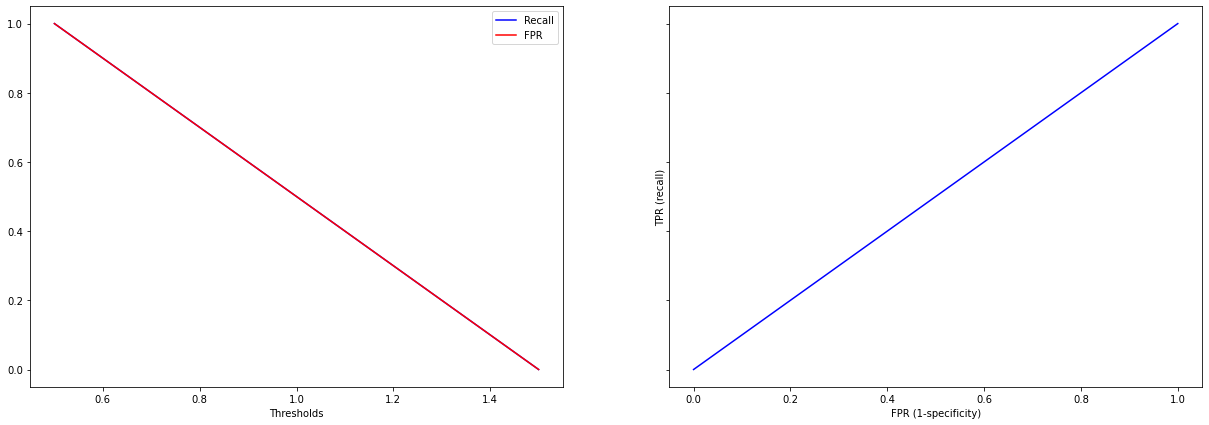

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500050     0.0        0.0          1.0  0.0      0.5
Validation  0.499548     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000106     0.0        0.0          0.0  0.0      0.0
Validation  0.000954     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


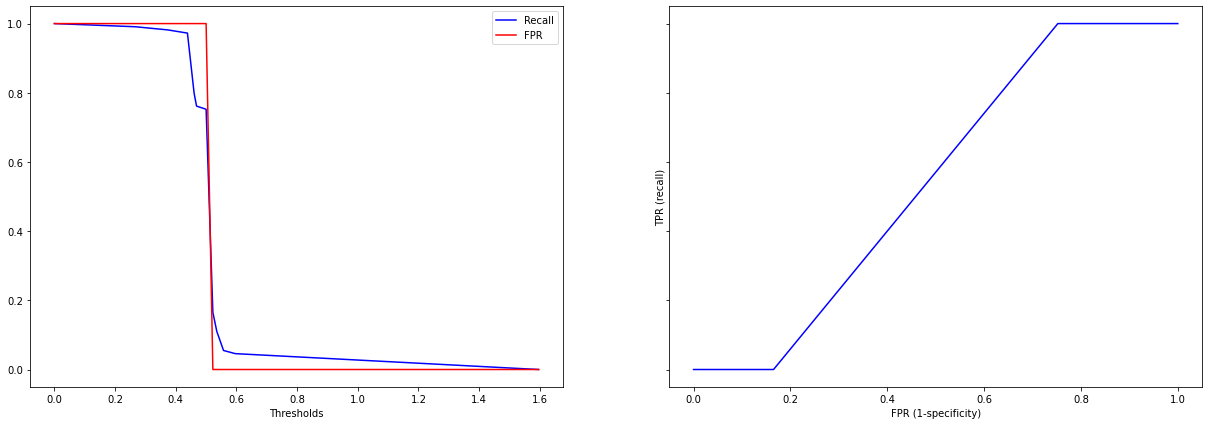

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.527221  0.197823   0.581699     0.856552  0.294467  0.556550
Validation  0.527717  0.196052   0.579810     0.860000  0.290978  0.556171

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003435  0.018304   0.019619     0.024161  0.017941  0.008545
Validation  0.034796  0.058104   0.103645     0.038854  0.072654  0.041953

Random Forest (100 estimators)
╠■■■■■■■■■╣


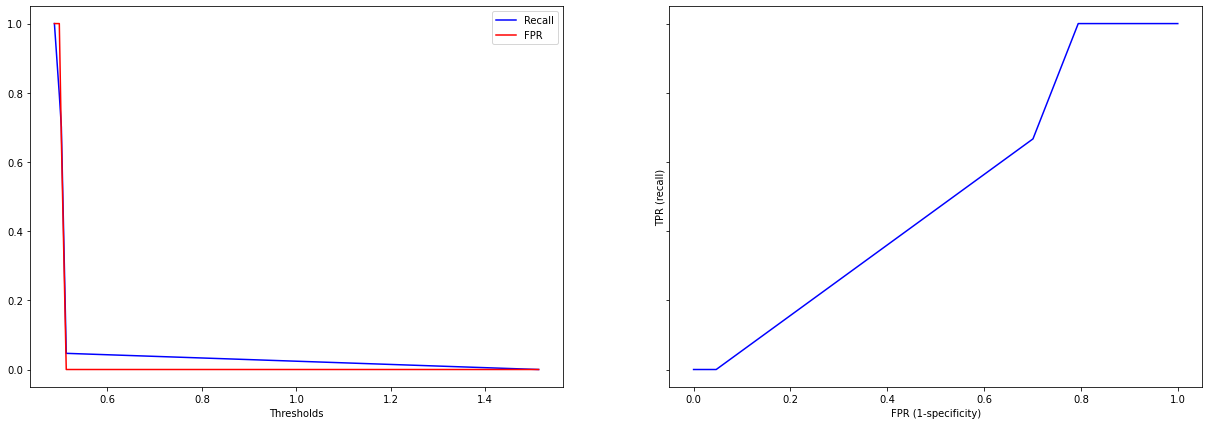

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.531707  0.507394   0.559729     0.555948  0.446517  0.551489
Validation  0.525893  0.508821   0.565637     0.543636  0.448094  0.538761

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010763  0.374806   0.043933     0.361737  0.217919  0.010309
Validation  0.028456  0.367185   0.115608     0.375948  0.211477  0.038446

XGBoost Classifier
╠■■■■■■■■■╣


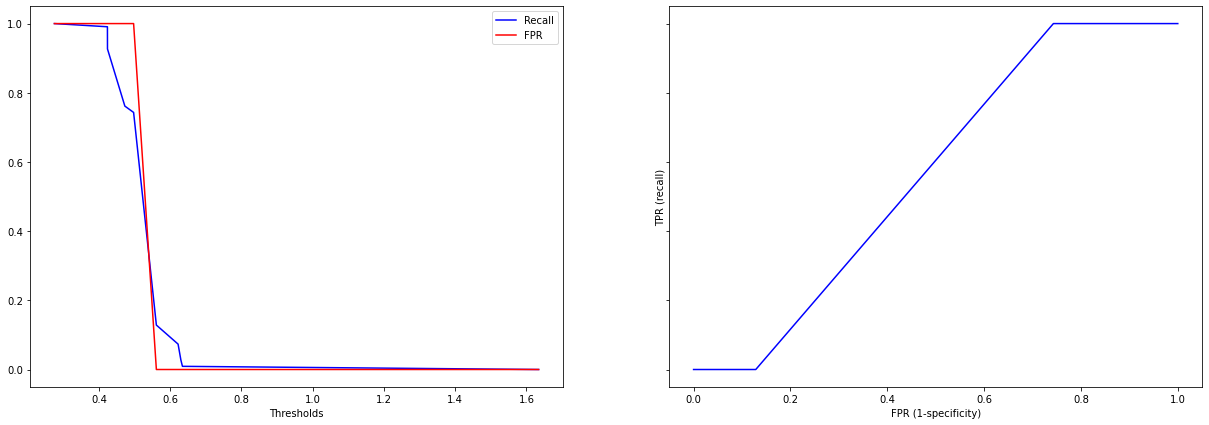

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.544410  0.867414   0.527009     0.221472  0.655550  0.569007
Validation  0.540845  0.852981   0.525742     0.228182  0.650358  0.544397

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005871  0.021558   0.004038     0.026313  0.005841  0.006150
Validation  0.024489  0.022636   0.016154     0.047228  0.015374  0.034965

SVM
╠■■■■■■■■■╣


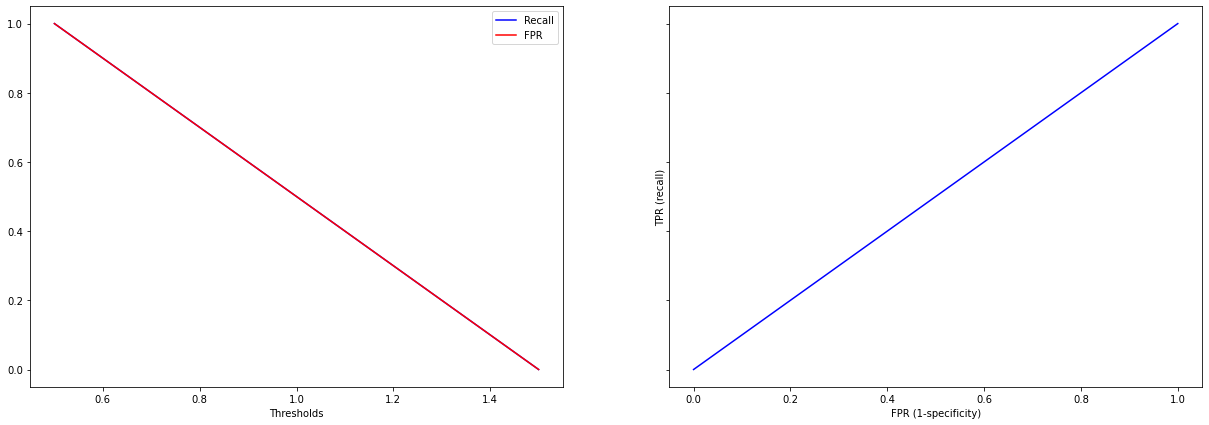

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.525808  0.465607   0.586888     0.585988  0.410564  0.541044
Validation  0.519519  0.457404   0.502783     0.581818  0.401292  0.531095

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010485  0.371008   0.108405     0.355108  0.248351  0.018725
Validation  0.029543  0.373044   0.222825     0.358268  0.253197  0.045837

KNN
╠■■■■■■■■■╣


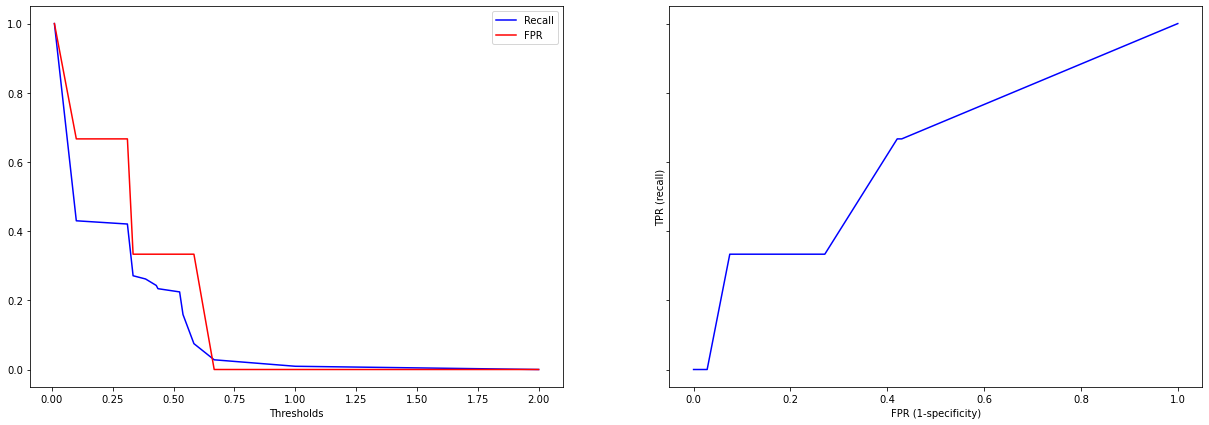

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.526818  0.118069   0.655889     0.935484  0.197634  0.545561
Validation  0.507279  0.114365   0.513797     0.900909  0.183287  0.521577

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005529  0.032941   0.036333     0.026569  0.046658  0.012098
Validation  0.029859  0.062820   0.139928     0.041869  0.091194  0.057564

Logistic Regression
╠■■■■■■■■■╣


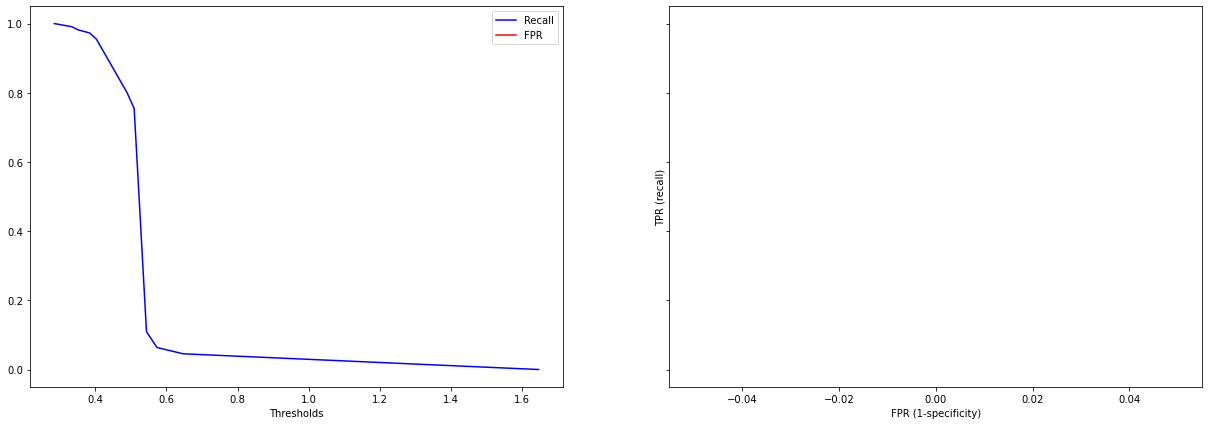

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.539117  0.713819   0.539914     0.364415  0.578192  0.556404
Validation  0.527694  0.701753   0.532002     0.353636  0.571888  0.553332

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006271  0.269797   0.031527     0.264360  0.144438  0.007276
Validation  0.024278  0.256191   0.041650     0.263251  0.133547  0.048094

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499548  0.000000   0.000000     1.000000   
MultinomialNB                   0.527717  0.196052   0.579810     0.860000   
Random Forest (100 estimators)  0.525893  0.508821   0.565637     0.543636   
XGBoost Classifier              0.540845  0.852981   0.525742     0.228182   
SVM                             0.519519  0.457404   0.502783     0.581818   
KNN                             0.507279  0.114365   0.513797     0.900909   
Logistic Regression             0.527694  0.701753   0.532002     0.353636   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.290978  0.556171  
Random Forest (100 estimators)  0.448094  0.538761  
XGBoost Classifier              0.650358  0.544397  
SVM                             0.401292  0.531095  
KNN                             0.183287  0.521577  
Logistic Regression             0.571888  0.553332

Accuracy  \
Dummy Random                    0.4989441930618401-0.5001508295625943   
MultinomialNB                   0.5057100747453309-0.5497239030415879   
Random Forest (100 estimators)   0.507895273418222-0.5438900001317573   
XGBoost Classifier              0.5253571658044962-0.5563334964744013   
SVM                              0.5008340830984532-0.538203350056627   
KNN                             0.4883946587483552-0.5261631363976753   
Logistic Regression             0.5123393284088362-0.5430494005093045   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                   0.15930429315252737-0.23280053895230474   
Random Forest (100 estimators)    0.2765923490867074-0.7410489285545702   
XGBoost Classifier                0.8386650442829019-0.8672972816794243   
SVM                              0.22147007219996273-0.6933374626075721   
KNN                              0.07463438468739261-0.1540961640431561   
Logistic Regression               0.5397234451046441-0.8637818784006793   

                                                             Precision  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5142586924981578-0.6453607258969105   
Random Forest (100 estimators)   0.4925195266114435-0.6387536492686006   
XGBoost Classifier               0.5155255672844281-0.5359585992800455   
SVM                             0.36185637478533644-0.6437099272084099   
KNN                              0.4252989308302679-0.6022957473959893   
Logistic Regression              0.5056603762939363-0.5583444188751067   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                     0.8354265031118626-0.8845734968881374   
Random Forest (100 estimators)     0.3058658806676692-0.781406846605058   
XGBoost Classifier              0.19831219022945065-0.25805144613418574   
SVM                                0.3552293116815646-0.808407051954799   
KNN                               0.8744290275455108-0.9273891542726708   
Logistic Regression              0.18714168653737737-0.5201310407353498   

                                                                     F1  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                    0.24502786269301274-0.3369286232174297   
Random Forest (100 estimators)    0.31434495659070616-0.581843966277622   
XGBoost Classifier                0.6406346708074101-0.6600808593605699   
SVM                              0.24115618746071513-0.5614282703493882   
KNN                             0.12561108705898894-0.24096295608674428   
Logistic Regression              0.48742504145678744-0.6563500877626959   

                                                               ROC_AUC  
Dummy Random                                                   0.5-0.5  
MultinomialNB                     0.529637652704602-0.5827039450915411  
Random Forest (100 estimators)    0.514445358929806-0.5630756745003184  
XGBoost Classifier               0.5222830011910752-0.5665109084210164  
SVM                              0.5021048156641549-0.5600847457981338  
KNN                             0.48517060105672855-0.5579843390073024  
Logistic Regression              0.5229140844168846-0.5837489339734067

In [169]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot. <b>High risk exposure occupation</b> seems to be the most important feature from epidemiological factors. <i>Note:</i> Most of the models have really high specificity, which might not be a good thing since the recall is really low and both precision and accuracy are just around .5 (this experiments use undersampling to have balanced classes). This suggests that most of the models are predicting everything is negative.

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [261]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [262]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

sys    dia  age
76797  195.0  130.0    1
36197  190.0  135.0    3
31880  180.0  135.0    2
5135   195.0  135.0    4
19137  215.0  117.0    4
20168  190.0  130.0    4
20582  200.0  118.0    4
9058   200.0  120.0    3
93508  200.0  118.0    4
31555  185.0  130.0    3
75219  195.0  130.0    2
48067  190.0  130.0    4
45860  220.0  115.0    3
91625  210.0  125.0    3
11792  190.0  130.0    3
6106   215.0  115.0    4
28579  180.0  130.0    3
20379  220.0  140.0    4
50607  220.0  108.0    4
36239  185.0  135.0    3
33497  210.0  120.0    4
14314  205.0  125.0    4

As expected, all pressure variables (including pam) are correlated between each other

In [172]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43807 entries, 46889 to 47067
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  42244 non-null  float64
 1   pulse        42870 non-null  float64
 2   rr           36863 non-null  float64
 3   sats         42243 non-null  float64
 4   pam          41396 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB


In [173]:
vitals.describe()

temperature         pulse            rr          sats           pam
count  42244.000000  42870.000000  36863.000000  42243.000000  41396.000000
mean      36.795479     76.914906     14.710414     98.242170     93.224595
std        0.286919     13.188071      1.954752      1.400628     10.890486
min       34.650000     35.000000      8.000000     81.000000     50.333333
25%       36.650000     68.000000     13.000000     97.000000     86.000000
50%       36.800000     76.000000     15.000000     98.000000     92.666667
75%       36.950000     85.000000     16.000000     99.000000     99.666667
max       39.600000    150.000000     32.000000    100.000000    155.000000

<AxesSubplot:>

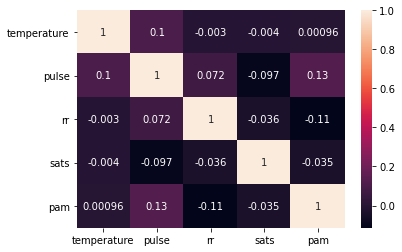

In [174]:
sns.heatmap(vitals.corr(), annot=True)

In [263]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


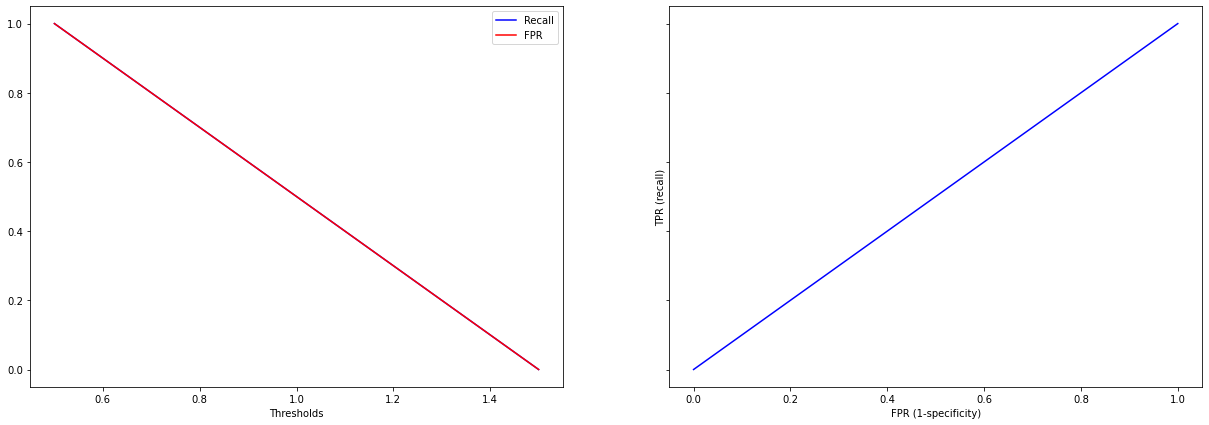

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500225     0.0        0.0          1.0  0.0      0.5
Validation  0.497970     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000119     0.0        0.0          0.0  0.0      0.0
Validation  0.001070     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


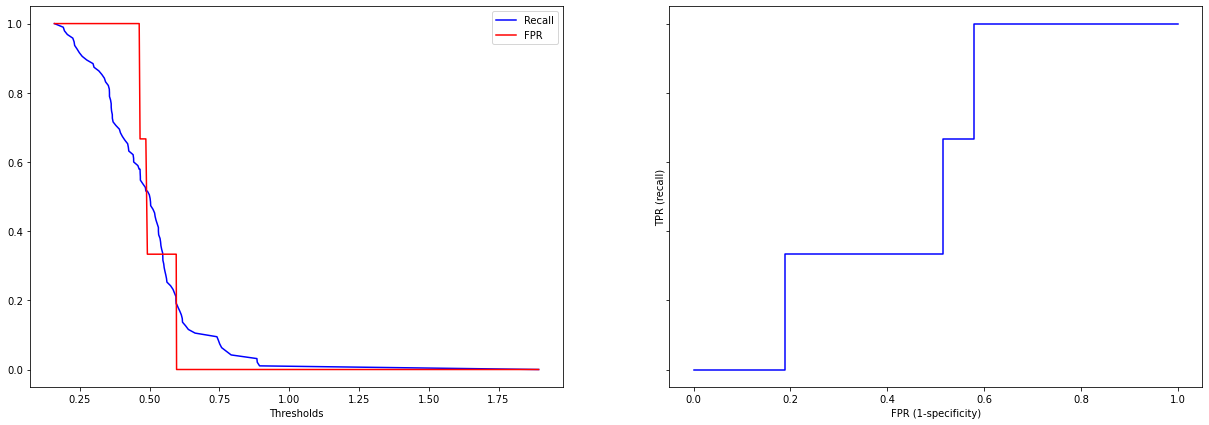

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.563568  0.531489   0.567736     0.595618  0.548990  0.597471
Validation  0.567078  0.525294   0.577539     0.609184  0.548941  0.601570

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.011715  0.012090   0.012836     0.014683  0.011826  0.012000
Validation  0.031194  0.041799   0.039006     0.067352  0.029446  0.029887

Random Forest (100 estimators)
╠■■■■■■■■■╣


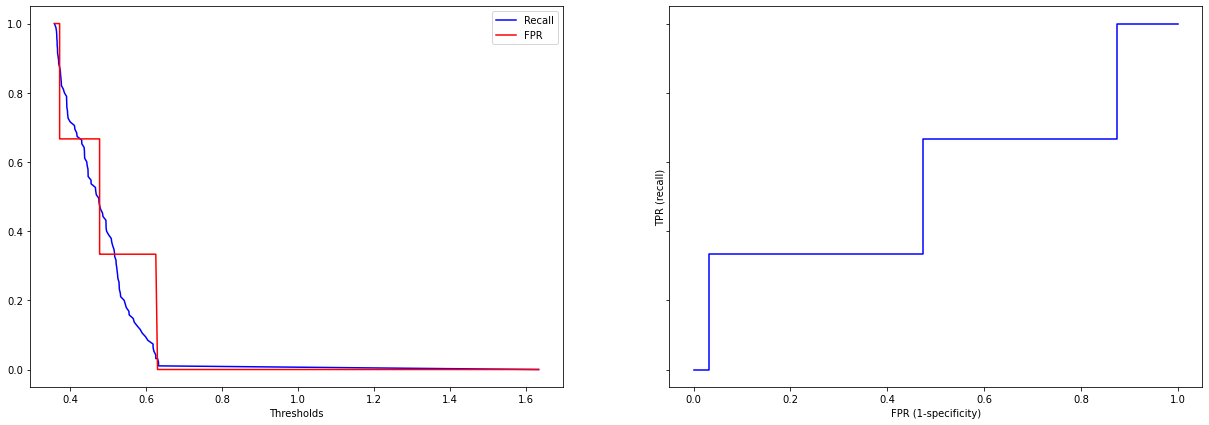

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.612073  0.567026   0.622969     0.657079  0.593633  0.663116
Validation  0.576238  0.532416   0.585437     0.620408  0.556496  0.632250

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009944  0.013324    0.01106     0.013197  0.011098  0.012052
Validation  0.027196  0.060200    0.02763     0.041042  0.041096  0.029295

XGBoost Classifier
╠■■■■■■■■■╣


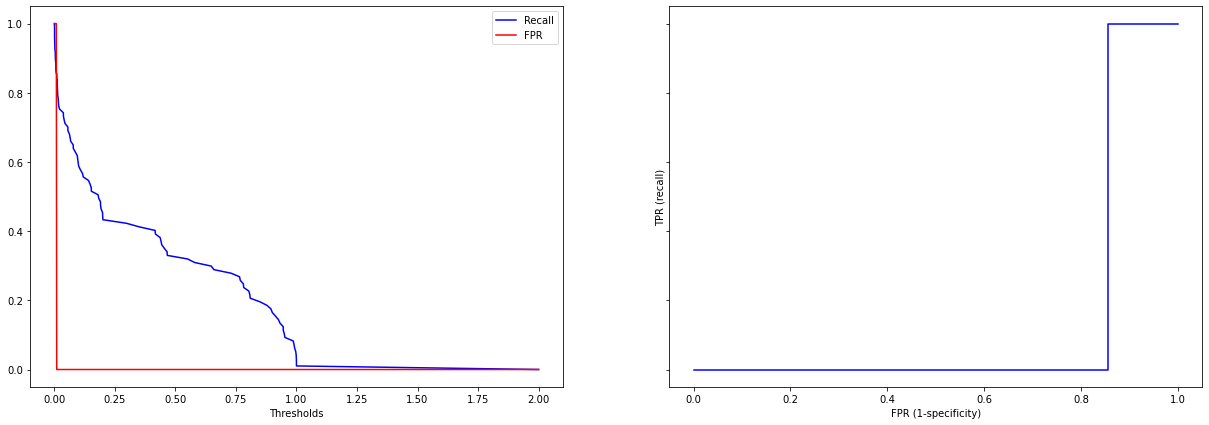

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998258  0.997751   0.998764     0.998764  0.998256  0.999990
Validation  0.541624  0.545455   0.543083     0.537755  0.543490  0.568599

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000856  0.001675   0.001236     0.001237  0.000858  0.000009
Validation  0.044882  0.063898   0.046319     0.057331  0.051583  0.043348

SVM
╠■■■■■■■■■╣


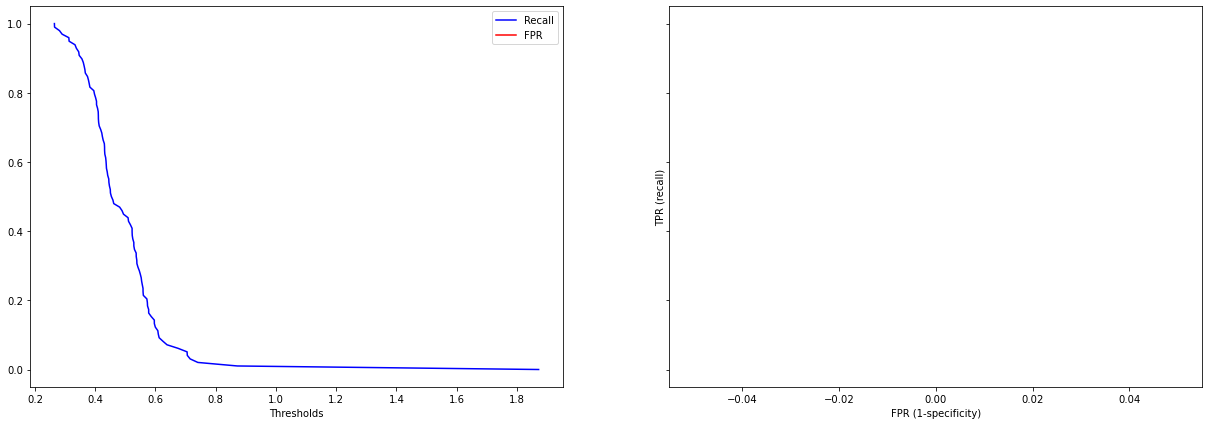

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.595718  0.540939   0.607291     0.650449  0.572168  0.639849
Validation  0.595046  0.536467   0.609931     0.654082  0.570074  0.633954

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.013510  0.014506   0.015356     0.015645  0.014285  0.013048
Validation  0.043623  0.059601   0.049784     0.051908  0.051822  0.048493

KNN
╠■■■■■■■■■╣


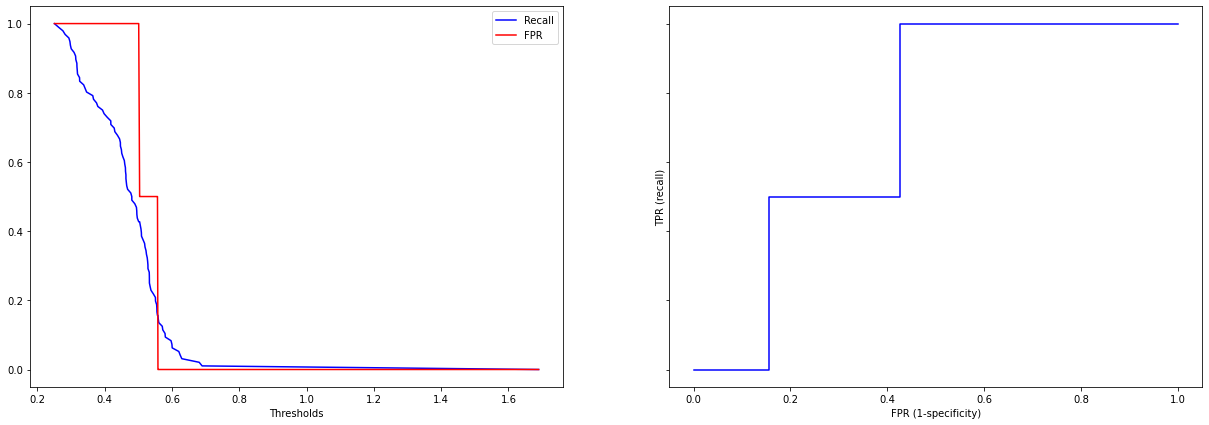

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998932  0.998088   0.999775     0.999775  0.998930  0.999996
Validation  0.566060  0.571851   0.567264     0.560204  0.568871  0.583245

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000935  0.001763   0.000475     0.000474  0.000938  0.000005
Validation  0.022273  0.047048   0.021601     0.038013  0.029816  0.030524

Logistic Regression
╠■■■■■■■■■╣


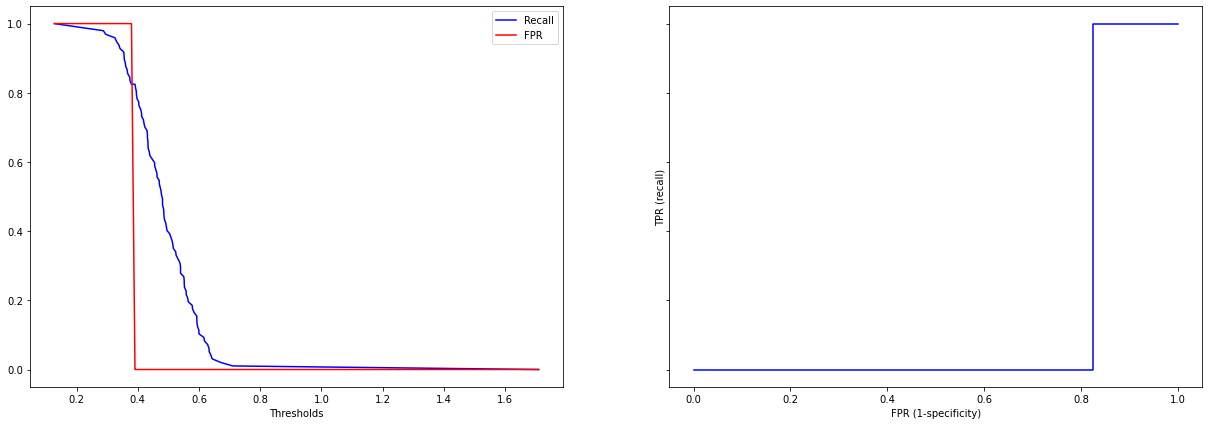

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.588747  0.563202   0.593561     0.614270  0.577924  0.632912
Validation  0.590451  0.566873   0.596686     0.614286  0.580906  0.631154

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.014573  0.009151   0.016838     0.023456  0.011818  0.017555
Validation  0.028379  0.047598   0.028572     0.032196  0.036212  0.031673

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497970  0.000000   0.000000     1.000000   
MultinomialNB                   0.567078  0.525294   0.577539     0.609184   
Random Forest (100 estimators)  0.576238  0.532416   0.585437     0.620408   
XGBoost Classifier              0.541624  0.545455   0.543083     0.537755   
SVM                             0.595046  0.536467   0.609931     0.654082   
KNN                             0.566060  0.571851   0.567264     0.560204   
Logistic Regression             0.590451  0.566873   0.596686     0.614286   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.548941  0.601570  
Random Forest (100 estimators)  0.556496  0.632250  
XGBoost Classifier              0.543490  0.568599  
SVM                             0.570074  0.633954  
KNN                             0.568871  0.583245  
Logistic Regression             0.580906  0.631154

Accuracy  \
Dummy Random                    0.49729272419627746-0.49864636209813873   
MultinomialNB                     0.5473485012254349-0.5868066836911712   
Random Forest (100 estimators)     0.5590375386324337-0.593438375591124   
XGBoost Classifier                0.5132382849739279-0.5700104459905391   
SVM                               0.5674557484334479-0.6226354149354529   
KNN                               0.5519731074165669-0.5801464409103781   
Logistic Regression               0.5725029150506432-0.6083993951120005   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.49885763150421236-0.5517298762261527   
Random Forest (100 estimators)   0.4943421765109167-0.5704898168925053   
XGBoost Classifier               0.5050417297313184-0.5858673611777726   
SVM                              0.4987715286598162-0.5741618871307426   
KNN                              0.5420955093947062-0.6016068200219089   
Logistic Regression              0.5367690549759225-0.5969765644839826   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5528698506794694-0.6022091181448155   
Random Forest (100 estimators)  0.5679626721175087-0.6029120940290934   
XGBoost Classifier              0.5137885043515122-0.5723777441173679   
SVM                             0.5784448115077828-0.6414169111301616   
KNN                                0.5536020642782-0.5809258718911108   
Logistic Regression             0.5786158559502059-0.6147564179791267   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                    0.566586470191964-0.6517808767468117   
Random Forest (100 estimators)  0.5944506339750492-0.6463656925555633   
XGBoost Classifier              0.5014958966769077-0.5740143074047251   
SVM                             0.6212518952054049-0.6869113701007172   
KNN                             0.5361624529971805-0.5842457102681256   
Logistic Regression             0.5939229529971486-0.6346484755742798   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5303179054432073-0.5675648435749391   
Random Forest (100 estimators)  0.5305046381396056-0.5824871351912205   
XGBoost Classifier              0.5108654671647874-0.5761136008692109   
SVM                             0.5372991443994225-0.6028492213126643   
KNN                             0.5500132094561241-0.5877282148791518   
Logistic Regression              0.558003144040611-0.6038081038374266   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5826677458700622-0.6204715184936918  
Random Forest (100 estimators)  0.6137223685732718-0.6507779027783116  
XGBoost Classifier              0.5411837652339743-0.5960145401859055  
SVM                             0.6032847877810885-0.6646235753167791  
KNN                             0.5639402105655646-0.6025498672218892  
Logistic Regression             0.6111220278261673-0.6511859751523896

In [176]:
#All vitals without normalization or standardization
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

<b>Rr</b>, <b>pulse</b> and <b>temperature</b> seem to be the most dominant features in the experiments. <b>Random Forest</b> seems to be the best performing model here.

Dummy Random
╠■■■■■■■■■╣


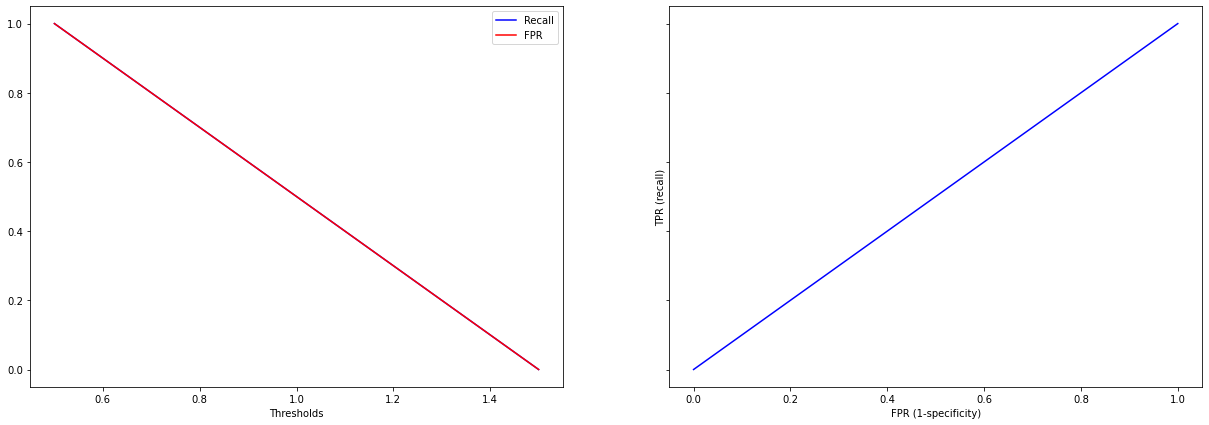

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500225     0.0        0.0          1.0  0.0      0.5
Validation  0.497970     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000119     0.0        0.0          0.0  0.0      0.0
Validation  0.001070     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


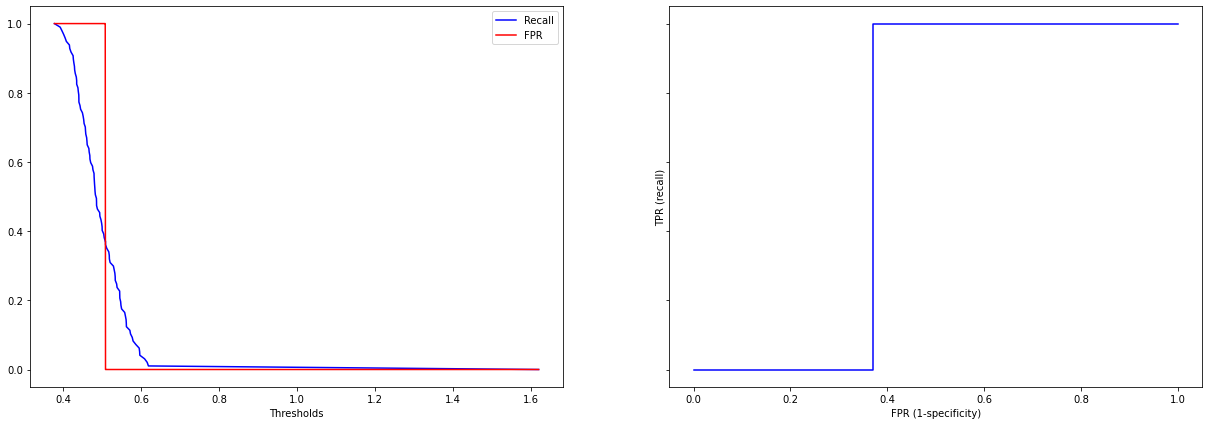

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.616737  0.583666   0.624982     0.649775  0.603426  0.666884
Validation  0.592008  0.565873   0.599182     0.618367  0.580870  0.635586

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006492  0.017352   0.009335     0.019648  0.008801  0.005220
Validation  0.037827  0.064458   0.035615     0.052518  0.046323  0.043084

XGBoost Classifier
╠■■■■■■■■■╣


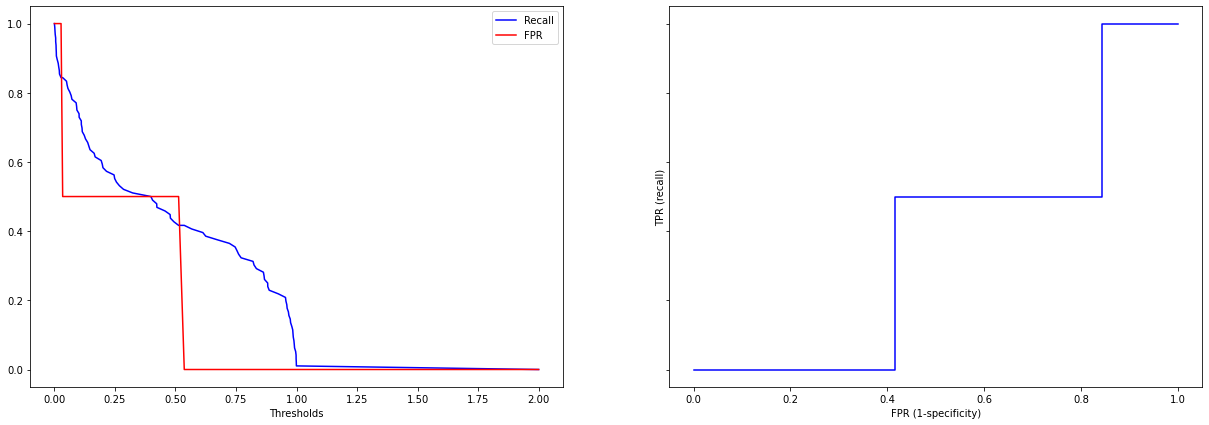

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998483  0.998200   0.998765     0.998764  0.998482  0.999993
Validation  0.542192  0.525366   0.543511     0.559184  0.533392  0.556101

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000533  0.000948   0.001235     0.001237  0.000533  0.000005
Validation  0.047837  0.080487   0.047131     0.038422  0.063540  0.053058

SVM
╠■■■■■■■■■╣


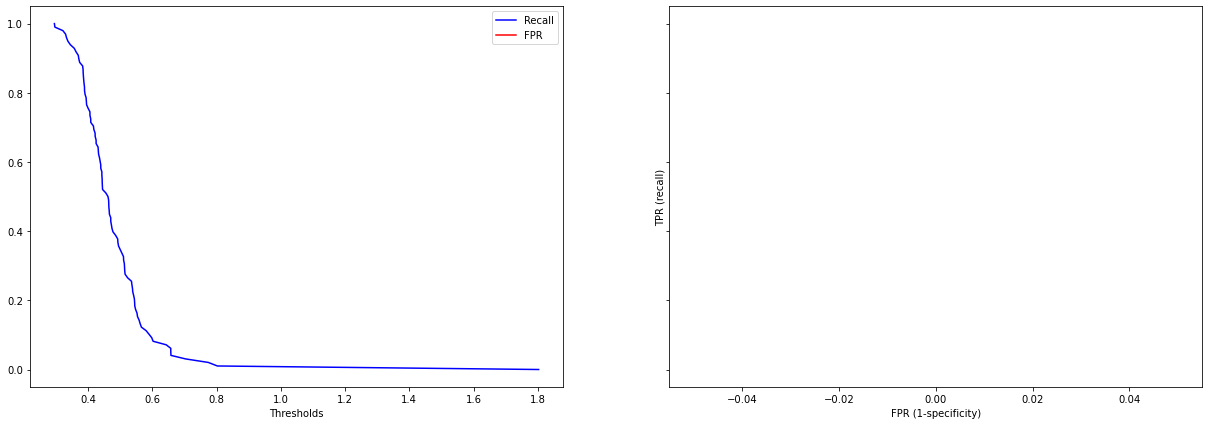

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.593357  0.542287   0.603692     0.644382  0.571319  0.639748
Validation  0.588946  0.532447   0.602103     0.645918  0.564402  0.638836

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009174  0.013268   0.009600     0.008429  0.011213  0.010091
Validation  0.038372  0.058252   0.041983     0.043306  0.048414  0.044342

KNN
╠■■■■■■■■■╣


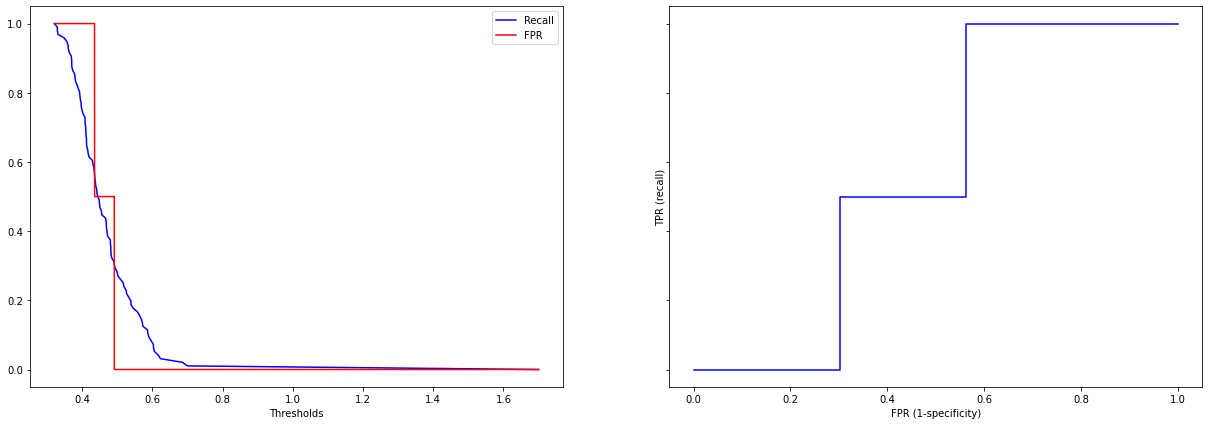

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998820  0.997751   0.999887     0.999888  0.998817  0.999996
Validation  0.593523  0.513152   0.615346     0.674490  0.558523  0.642931

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000857  0.001677   0.000356     0.000355  0.000859  0.000005
Validation  0.033249  0.046304   0.042465     0.057007  0.037519  0.029579

Logistic Regression
╠■■■■■■■■■╣


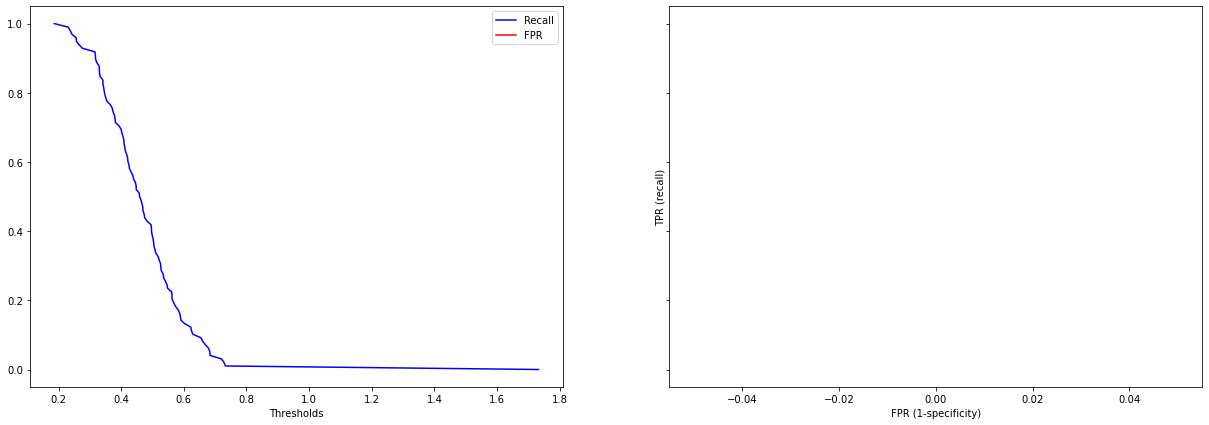

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.588466  0.555105   0.594661     0.621798  0.574178  0.635782
Validation  0.590441  0.554721   0.599753     0.626531  0.575084  0.635696

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008709  0.005398   0.010337     0.014313  0.006992  0.010592
Validation  0.022081  0.056440   0.022999     0.042809  0.035047  0.024560

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497970  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.592008  0.565873   0.599182     0.618367   
XGBoost Classifier              0.542192  0.525366   0.543511     0.559184   
SVM                             0.588946  0.532447   0.602103     0.645918   
KNN                             0.593523  0.513152   0.615346     0.674490   
Logistic Regression             0.590441  0.554721   0.599753     0.626531   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.580870  0.635586  
XGBoost Classifier              0.533392  0.556101  
SVM                             0.564402  0.638836  
KNN                             0.558523  0.642931  
Logistic Regression             0.575084  0.635696

Accuracy  \
Dummy Random                    0.49729272419627746-0.49864636209813873   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)     0.5680839158459363-0.615931416175197   
XGBoost Classifier                0.5119370800106307-0.5724460133282276   
SVM                               0.5646780427517379-0.6132148402898037   
KNN                                0.5724944753529648-0.614551002736748   
Logistic Regression               0.5764754495844346-0.6044061416307318   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)    0.5251064571925327-0.606639574553499   
XGBoost Classifier              0.47446131536794306-0.5762704925067221   
SVM                             0.49560523402482165-0.5692886022975863   
KNN                             0.48386643387522227-0.5424374210000612   
Logistic Regression              0.5190247171471267-0.5904166351513684   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5766577334392768-0.6217071088537058   
XGBoost Classifier              0.5137027242262693-0.5733190757092435   
SVM                             0.5755509996905438-0.6286552072772377   
KNN                             0.5884884776526222-0.6422025587833191   
Logistic Regression             0.5852069459672578-0.6142985637765597   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5851522296170512-0.6515824642604998   
XGBoost Classifier                0.5348835767353853-0.58348377020339   
SVM                             0.6185294936881668-0.6733072410057107   
KNN                               0.63843537414966-0.7105442176870749   
Logistic Regression             0.5994561241603641-0.6536051003294318   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.5515722095922918-0.6101670278612762   
XGBoost Classifier              0.49320586991197946-0.5735785543799332   
SVM                              0.5337819597112198-0.5950217014252778   
KNN                              0.5347939142747236-0.5822516996211284   
Logistic Regression              0.5529181799785562-0.5972494322399343   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6083377510365204-0.6628348243634601  
XGBoost Classifier              0.5225435939548505-0.5896577615409658  
SVM                             0.6107921532424455-0.6668807650281404  
KNN                             0.6242229213243825-0.6616381887349784  
Logistic Regression             0.6201630140747735-0.6512291667926261

In [177]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

<b>Pulse</b>, <b>temperature</b> and <b>rr</b> seem to be again the dominant features with standardized values. It improved the performance of <b>SVM</b>, <b>KNN</b> and <b>Logistic Regression<b>

Dummy Random
╠■■■■■■■■■╣


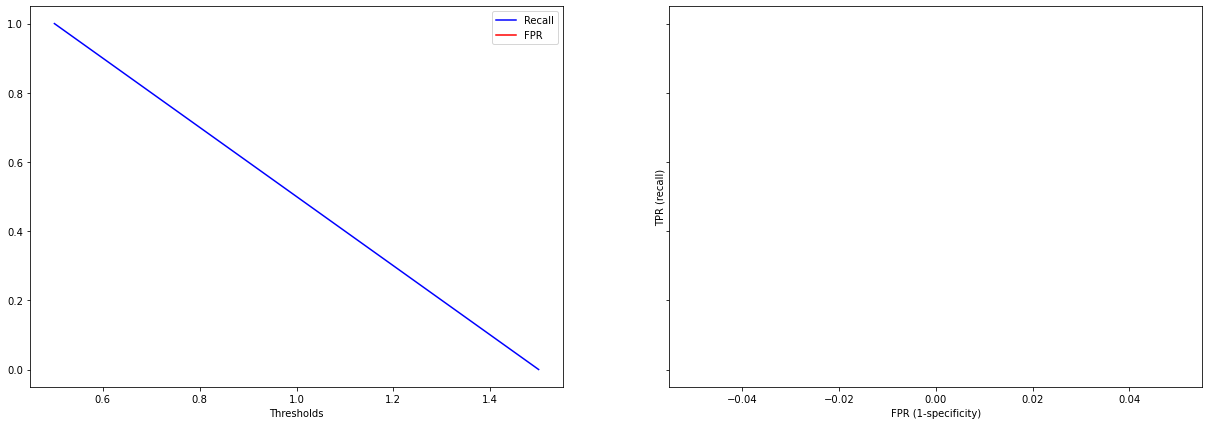

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500225     0.0        0.0          1.0  0.0      0.5
Validation  0.497970     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000119     0.0        0.0          0.0  0.0      0.0
Validation  0.001070     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


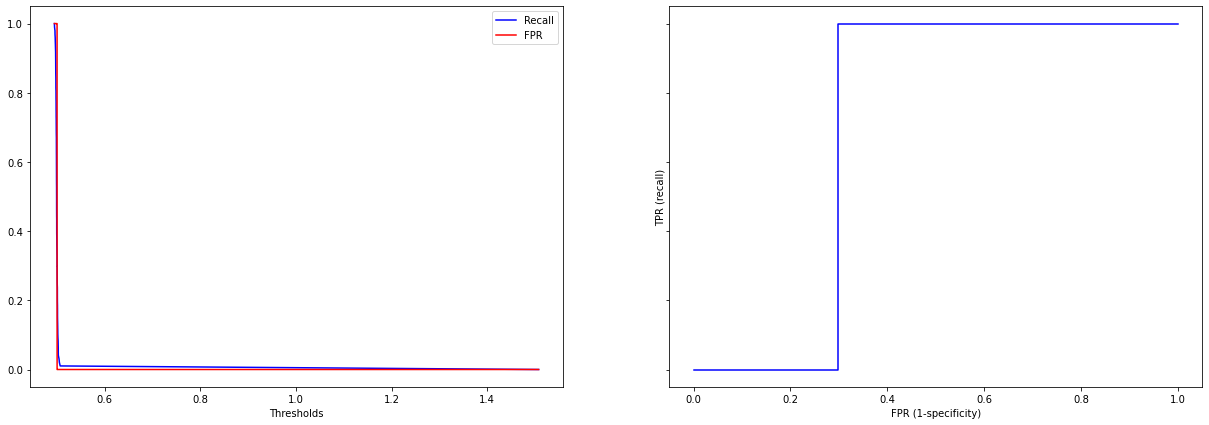

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.577618  0.541947   0.583458     0.613258  0.561917  0.608774
Validation  0.565024  0.536436   0.572071     0.593878  0.552801  0.588264

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009795  0.005398   0.011572     0.015110  0.007975  0.010170
Validation  0.032015  0.045876   0.037379     0.054166  0.034593  0.035658

Random Forest (100 estimators)
╠■■■■■■■■■╣


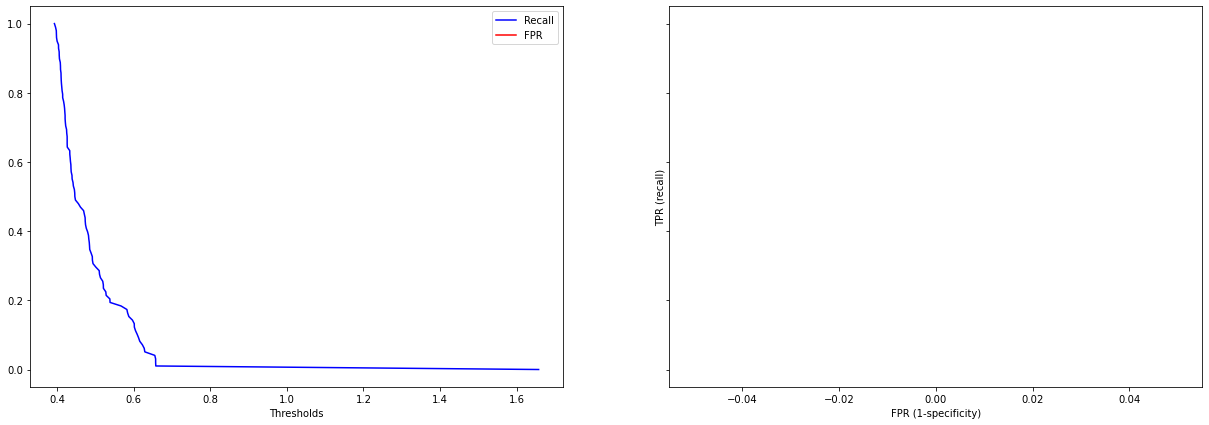

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.618367  0.590407   0.625785     0.646292  0.606483  0.668178
Validation  0.597563  0.570944   0.606209     0.624490  0.586079  0.635246

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009475  0.046165   0.012435     0.039145  0.022436  0.005615
Validation  0.037636  0.071856   0.041714     0.066964  0.047250  0.040377

XGBoost Classifier
╠■■■■■■■■■╣


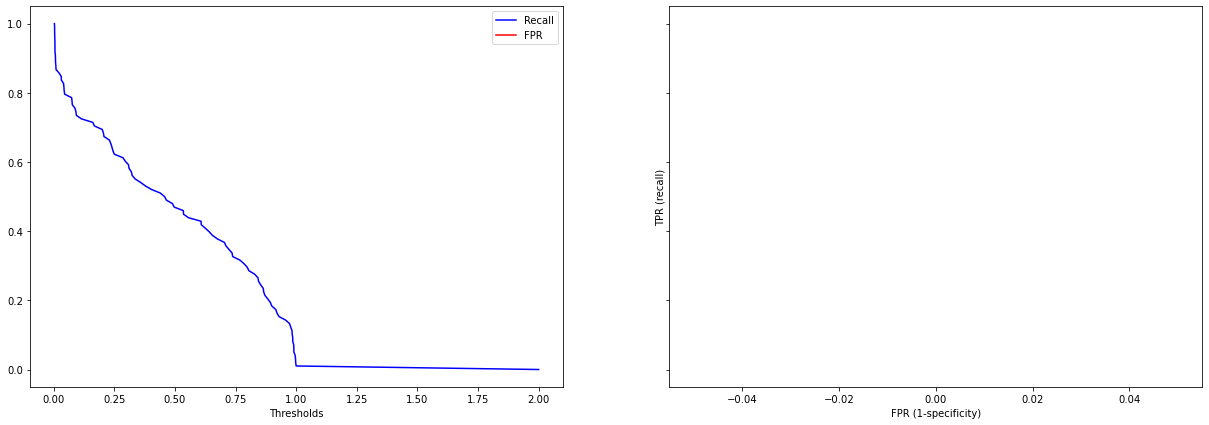

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998482  0.998988   0.997981     0.997978  0.998483  0.999994
Validation  0.566562  0.574861   0.568812     0.558163  0.571020  0.580481

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000840  0.000984   0.001735     0.001741  0.000838  0.000007
Validation  0.036722  0.042986   0.040579     0.062911  0.034208  0.037236

SVM
╠■■■■■■■■■╣


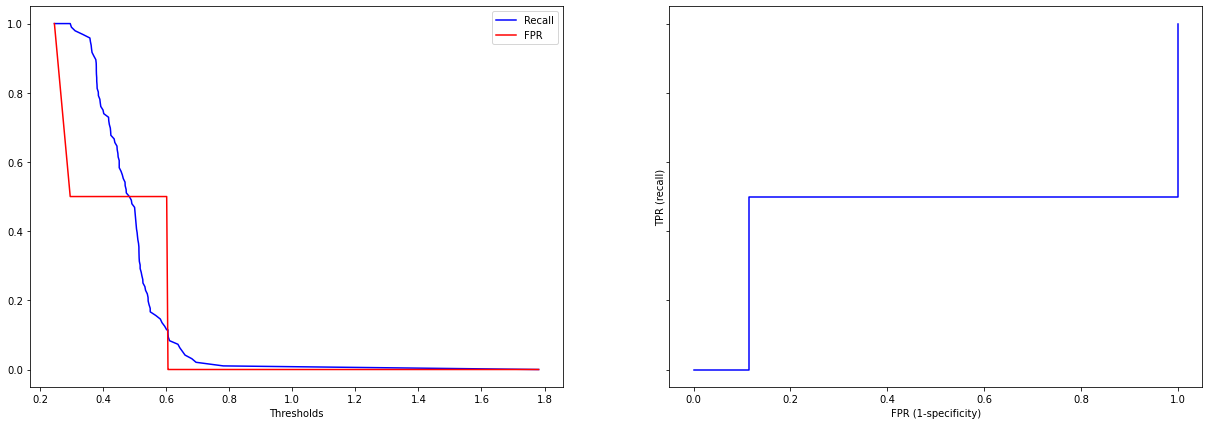

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.594031  0.543184   0.604454     0.644831  0.572175  0.642174
Validation  0.584352  0.536518   0.595059     0.632653  0.563010  0.639891

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007004  0.006799   0.008072     0.008902  0.007017  0.006673
Validation  0.027417  0.061797   0.028778     0.041379  0.043532  0.031082

KNN
╠■■■■■■■■■╣


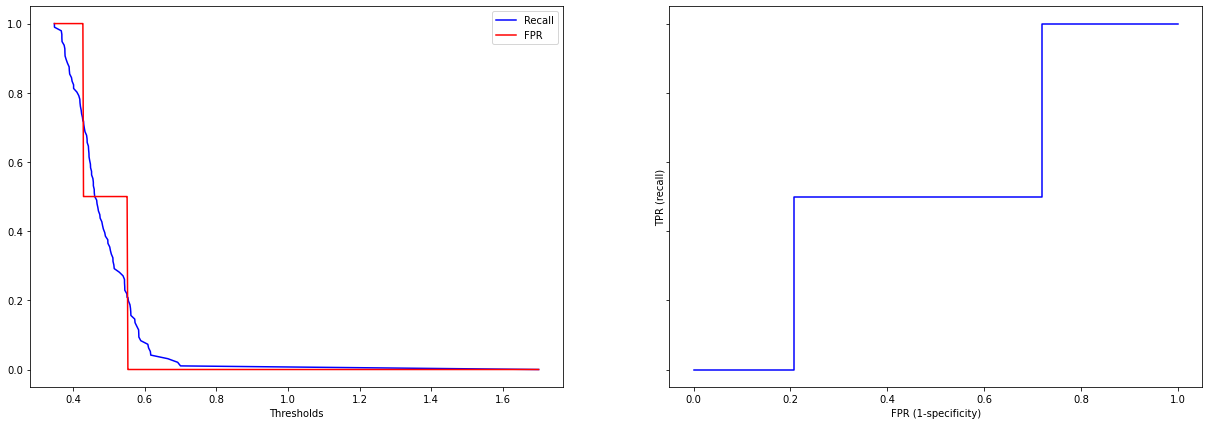

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998820  0.997638   1.000000     1.000000  0.998817  0.999997
Validation  0.581322  0.522459   0.595244     0.640816  0.554867  0.618453

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000559  0.001119   0.000000     0.000000  0.000561  0.000003
Validation  0.037064  0.065209   0.044522     0.059655  0.047570  0.045904

Logistic Regression
╠■■■■■■■■■╣


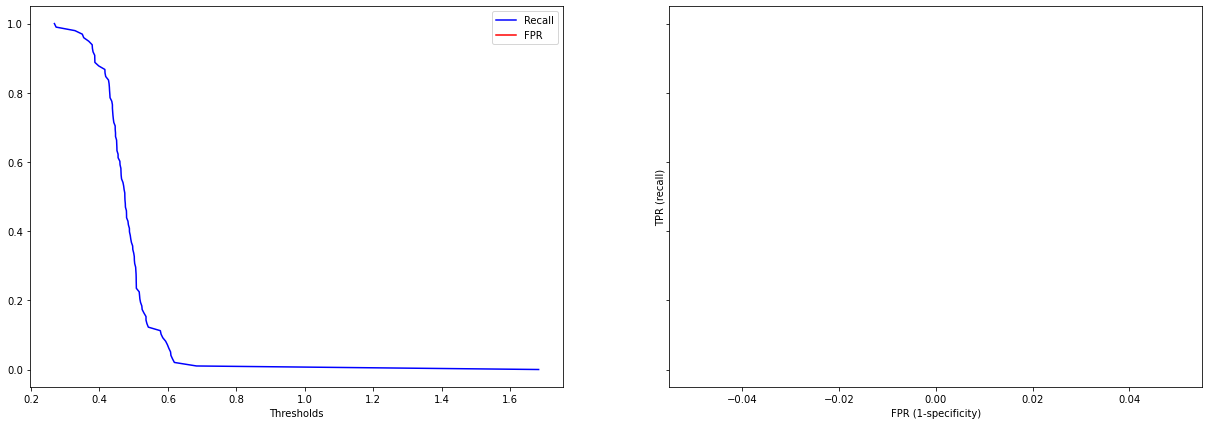

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.593412  0.557353   0.600444     0.629438  0.578074  0.637545
Validation  0.590946  0.542538   0.603522     0.639796  0.570565  0.639017

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010143  0.012226   0.011026     0.011456  0.011050  0.010106
Validation  0.027465  0.045689   0.033249     0.046401  0.033691  0.030460

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497970  0.000000   0.000000     1.000000   
MultinomialNB                   0.565024  0.536436   0.572071     0.593878   
Random Forest (100 estimators)  0.597563  0.570944   0.606209     0.624490   
XGBoost Classifier              0.566562  0.574861   0.568812     0.558163   
SVM                             0.584352  0.536518   0.595059     0.632653   
KNN                             0.581322  0.522459   0.595244     0.640816   
Logistic Regression             0.590946  0.542538   0.603522     0.639796   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.552801  0.588264  
Random Forest (100 estimators)  0.586079  0.635246  
XGBoost Classifier              0.571020  0.580481  
SVM                             0.563010  0.639891  
KNN                             0.554867  0.618453  
Logistic Regression             0.570565  0.639017

Accuracy  \
Dummy Random                    0.49729272419627746-0.49864636209813873   
MultinomialNB                       0.54477545564642-0.5852721979327778   
Random Forest (100 estimators)    0.5737599623168717-0.6213659052890539   
XGBoost Classifier                0.5433372552375769-0.5897871620420253   
SVM                               0.5670120107385981-0.6016920190966863   
KNN                               0.5578802404577805-0.6047634972403444   
Logistic Regression                0.573575343786577-0.6083162961181158   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5074213465766245-0.5654502262949485   
Random Forest (100 estimators)   0.5254987235214655-0.6163895469382338   
XGBoost Classifier               0.5476744109587248-0.6020472959058394   
SVM                             0.49743433008163757-0.5756021572405641   
KNN                             0.48121770686526344-0.5637008666247385   
Logistic Regression              0.5136411304138917-0.5714341118042077   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5484308050426407-0.5957119965753424   
Random Forest (100 estimators)  0.5798266724555791-0.6325913027473901   
XGBoost Classifier               0.5431478607738687-0.594476219546815   
SVM                             0.5768585180628872-0.6132597629056092   
KNN                             0.5670860367715096-0.6234024313734468   
Logistic Regression             0.5824937223427045-0.6245511967270014   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.5596199229605057-0.6281351790803107   
Random Forest (100 estimators)  0.5821377349217052-0.6668418569150296   
XGBoost Classifier              0.5183746154669668-0.5979519151452783   
SVM                             0.6064824706643926-0.6588236517845868   
KNN                             0.6030872799350692-0.6785453731261551   
Logistic Regression              0.6104494495100367-0.669142387224657   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5309227440916515-0.5746797436858502   
Random Forest (100 estimators)  0.5561949765144938-0.6159621901837726   
XGBoost Classifier              0.5493847466056634-0.5926543810780811   
SVM                             0.5354785648953531-0.5905423611302898   
KNN                             0.5247810281609173-0.5849522971939394   
Logistic Regression             0.5492572386506993-0.5918731256660141   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                    0.5657118740605954-0.610815582933334  
Random Forest (100 estimators)  0.6097100720519228-0.6607828622894079  
XGBoost Classifier               0.5569312745024432-0.604031644988173  
SVM                             0.6202336188150983-0.6595492157782319  
KNN                             0.5894201680112179-0.6474849094186408  
Logistic Regression             0.6197522315147503-0.6582815422916184

In [178]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

<b>Temperature</b>, <b>pulse</b> and <b>rr</b> are still the best features. <b>SVM</b> and <b>Logistic regression</b> improve significantly with standardized features.

Dummy Random
╠■■■■■■■■■╣


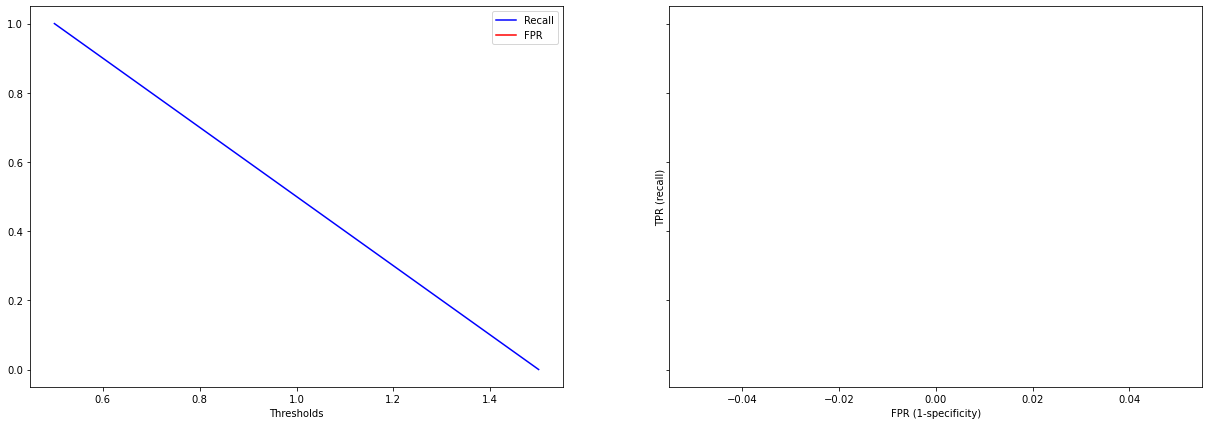

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500225     0.0        0.0          1.0  0.0      0.5
Validation  0.497970     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000119     0.0        0.0          0.0  0.0      0.0
Validation  0.001070     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


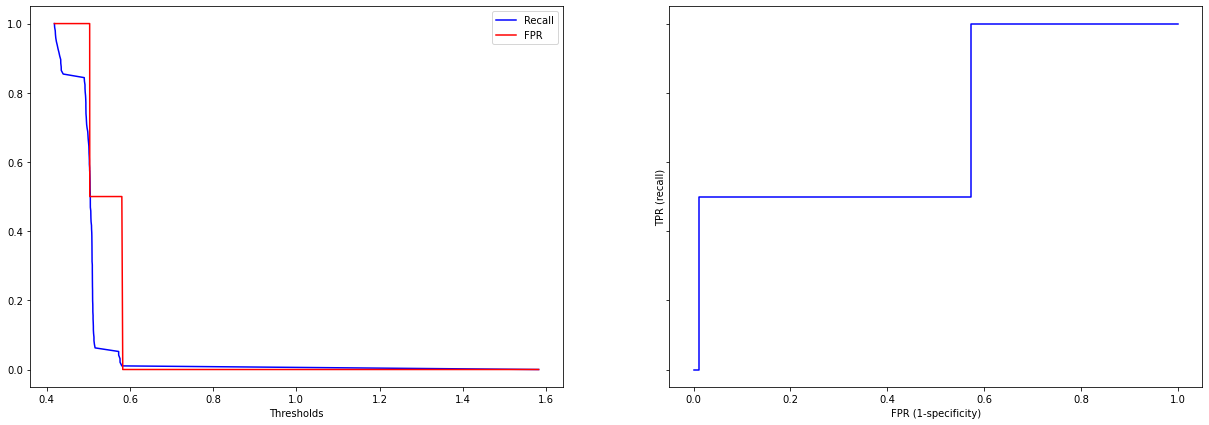

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.555868  0.539576   0.560106     0.572135  0.543940  0.584254
Validation  0.543181  0.545578   0.548975     0.540816  0.539353  0.569500

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006038  0.095217   0.015763     0.093752  0.052824  0.005724
Validation  0.041956  0.121582   0.054113     0.110007  0.071072  0.052237

Random Forest (100 estimators)
╠■■■■■■■■■╣


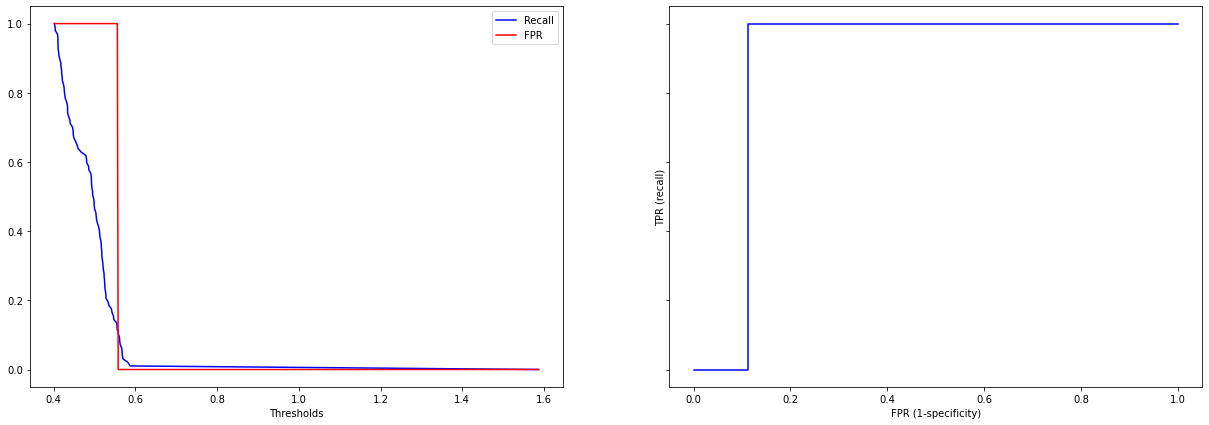

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.620953  0.604474   0.625219     0.637416  0.614351  0.673656
Validation  0.601121  0.574892   0.609328     0.627551  0.589709  0.646617

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006344  0.021947   0.010444     0.026574  0.009065  0.008141
Validation  0.026399  0.067991   0.026989     0.054262  0.041092  0.040034

XGBoost Classifier
╠■■■■■■■■■╣


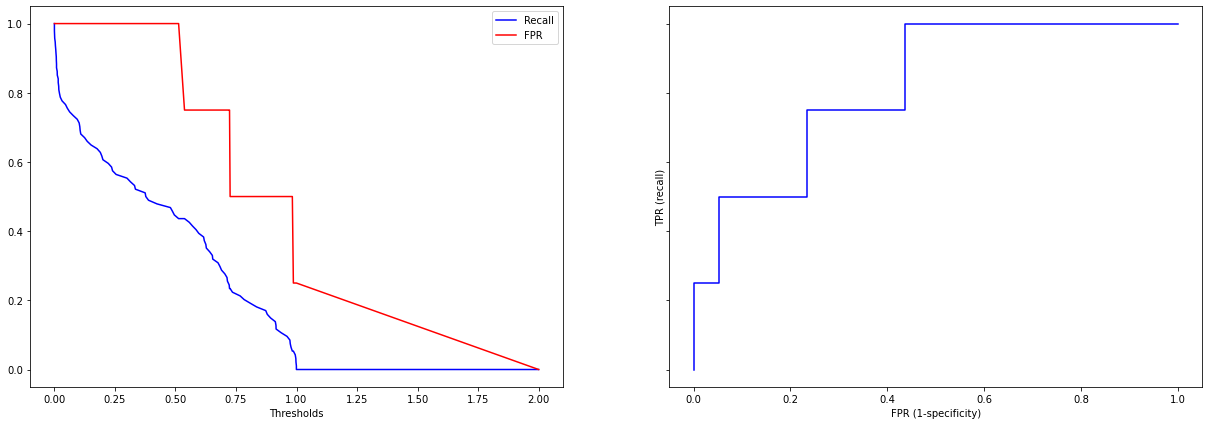

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999775  0.999775   0.999775     0.999775  0.999775  1.000000
Validation  0.536072  0.521233   0.539187     0.551020  0.529246  0.565318

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000290  0.000474   0.000474     0.000474  0.000290  2.664508e-07
Validation  0.027801  0.051821   0.027377     0.044608  0.035817  3.740249e-02

SVM
╠■■■■■■■■■╣


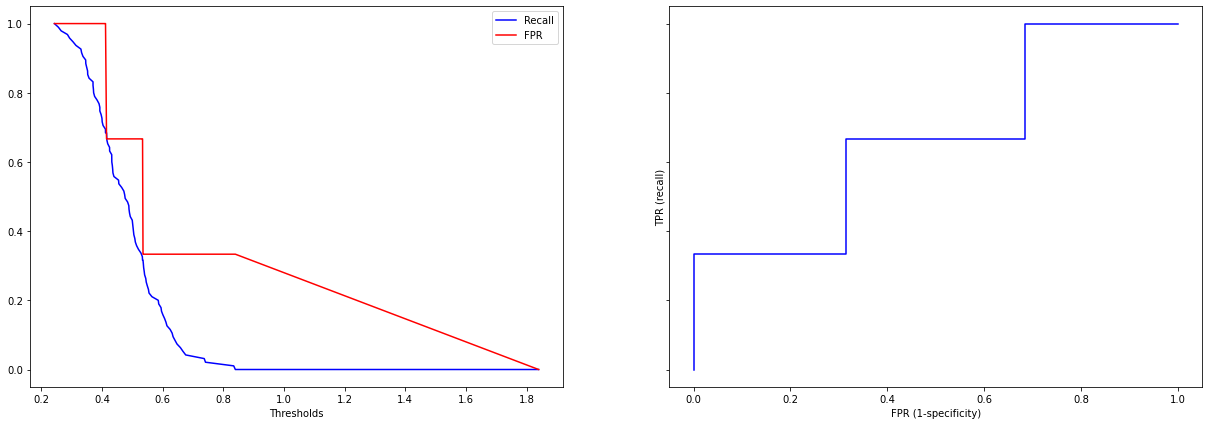

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.599259  0.548810   0.610281     0.649663  0.577876  0.648059
Validation  0.592484  0.545568   0.605055     0.639796  0.572979  0.630234

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009390  0.007961   0.011702     0.015349  0.008322  0.005865
Validation  0.033512  0.046112   0.037060     0.051819  0.036955  0.045377

KNN
╠■■■■■■■■■╣


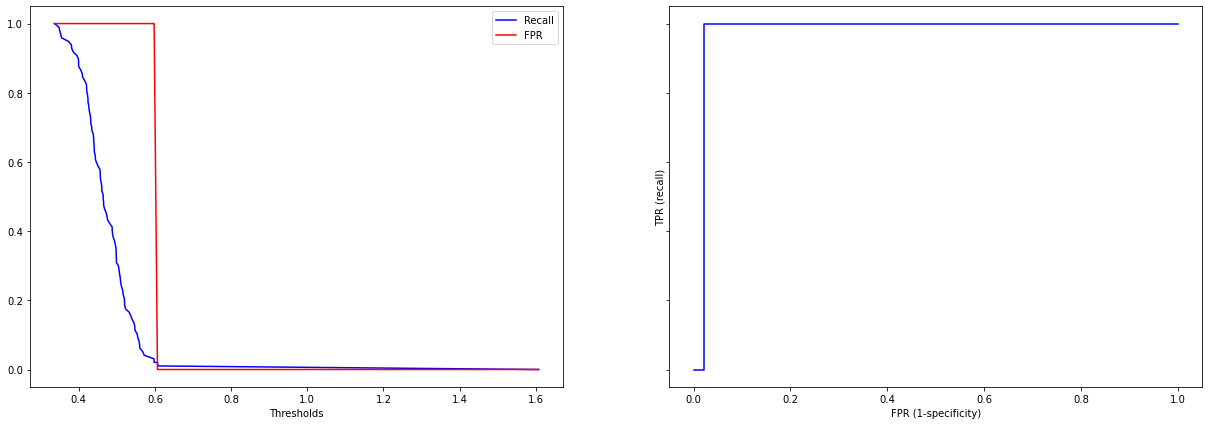

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999775  0.999550    1.00000     1.000000  0.999775  1.000000
Validation  0.578763  0.540466    0.58888     0.617347  0.562362  0.604751

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training     0.00029  0.000581   0.000000     0.000000  0.000291  3.263342e-07
Validation   0.01927  0.043647   0.025159     0.056354  0.023857  3.005833e-02

Logistic Regression
╠■■■■■■■■■╣


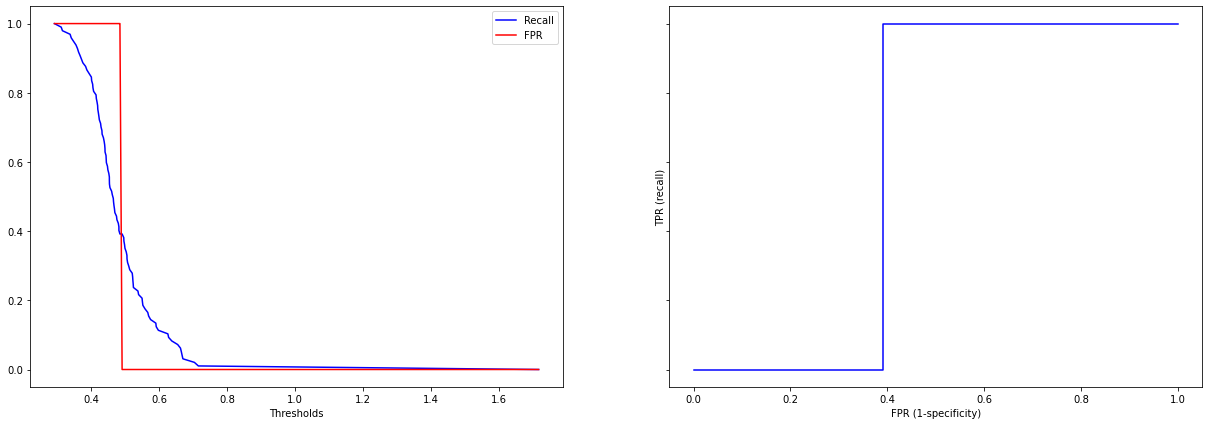

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.605609  0.574787   0.612467     0.636404  0.592985  0.651954
Validation  0.592466  0.567759   0.600057     0.617347  0.582809  0.633064

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010653  0.008382   0.012724     0.017360  0.009127  0.009270
Validation  0.039894  0.049120   0.042561     0.056148  0.041700  0.035369

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497970  0.000000   0.000000     1.000000   
MultinomialNB                   0.543181  0.545578   0.548975     0.540816   
Random Forest (100 estimators)  0.601121  0.574892   0.609328     0.627551   
XGBoost Classifier              0.536072  0.521233   0.539187     0.551020   
SVM                             0.592484  0.545568   0.605055     0.639796   
KNN                             0.578763  0.540466   0.588880     0.617347   
Logistic Regression             0.592466  0.567759   0.600057     0.617347   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.539353  0.569500  
Random Forest (100 estimators)  0.589709  0.646617  
XGBoost Classifier              0.529246  0.565318  
SVM                             0.572979  0.630234  
KNN                             0.562362  0.604751  
Logistic Regression             0.582809  0.633064

Accuracy  \
Dummy Random                    0.49729272419627746-0.49864636209813873   
MultinomialNB                     0.5166452709175201-0.5697164819054364   
Random Forest (100 estimators)     0.5844251262540008-0.617817699810435   
XGBoost Classifier                0.5184890127915185-0.5536543623250256   
SVM                                0.571289591685831-0.6136788119192659   
KNN                                0.566575902177591-0.5909502554935991   
Logistic Regression               0.5672350692129666-0.6176970762340448   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.468683234710637-0.6224732278743969   
Random Forest (100 estimators)   0.5318904746337147-0.617893075149835   
XGBoost Classifier              0.4884580485108072-0.5540074225260925   
SVM                             0.5164041330183704-0.5747317152603351   
KNN                             0.5128611248537428-0.5680706417923097   
Logistic Regression             0.5366931894055716-0.5988252603985925   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5147510476872992-0.5831993237877111   
Random Forest (100 estimators)  0.5922586645041747-0.6263978789105578   
XGBoost Classifier               0.521871995311365-0.5565020918208571   
SVM                             0.5816165626907612-0.6284939912792653   
KNN                             0.5729673764170514-0.6047918021785904   
Logistic Regression             0.5731385051695935-0.6269750036045026   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.4712420806773029-0.6103905723839217   
Random Forest (100 estimators)  0.5932326578078111-0.6618693830085156   
XGBoost Classifier              0.5228075627845882-0.5792332535419425   
SVM                             0.6070226136858614-0.6725692230488323   
KNN                             0.5817056138845449-0.6529882636664754   
Logistic Regression             0.5818356921465627-0.6528581854044576   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.49440303104832317-0.5843028493509774   
Random Forest (100 estimators)   0.5637198350901075-0.6156973404688463   
XGBoost Classifier                0.506592685653243-0.5518986051844181   
SVM                              0.5496063536159138-0.5963517411358311   
KNN                              0.5472728063588316-0.5774503108986319   
Logistic Regression              0.5564353296119083-0.6091823072730852   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5364619785843113-0.6025375544385453  
Random Forest (100 estimators)  0.6212972662501943-0.6719372446228007  
XGBoost Classifier              0.5416622829612286-0.5889731004438342  
SVM                             0.6015351718010521-0.6589326888125812  
KNN                             0.5857399862518217-0.6237611054650137  
Logistic Regression             0.6106950754692149-0.6554333053821981

In [179]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

For almost all models, the vitals had more importance than all of the epidemiological factors, of which <b>high_risk_exposure_occupation</b> seems to be the most influential again. For tree-based models (<b>Random forest</b> and <b>XGBoost</b>) however, <b>age</b> played a significant role. Since all of the important vitals follow a normal distribution, <b>standardization</b> will be used for them.

### Assesed Symptoms

In [264]:
a_symptoms.dropna(how="all", inplace=True)
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


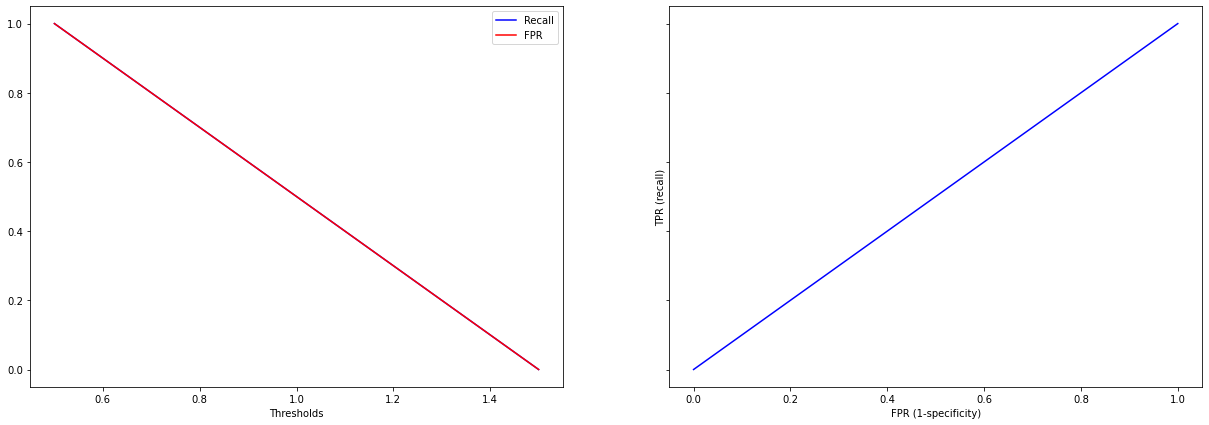

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500129     0.0        0.0          1.0  0.0      0.5
Validation  0.498837     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000136     0.0        0.0          0.0  0.0      0.0
Validation  0.001226     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


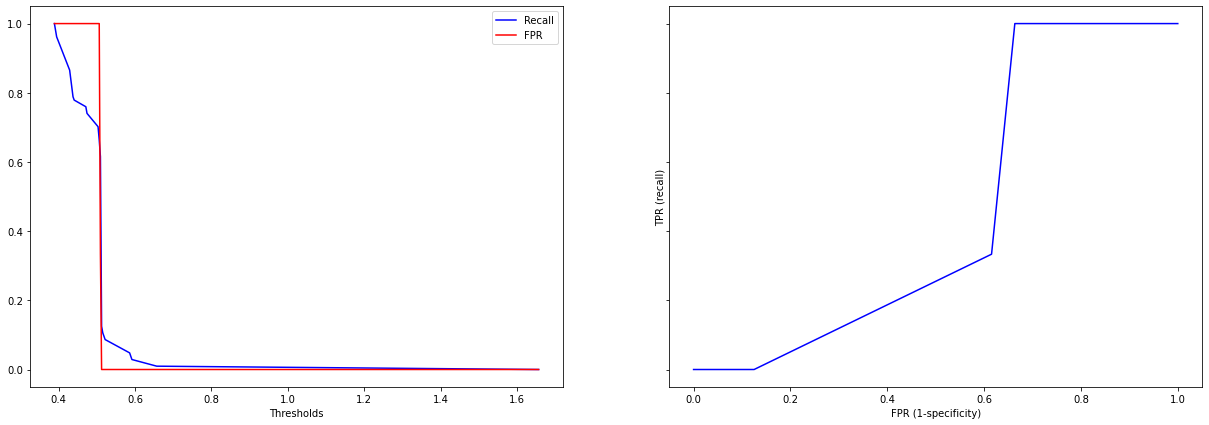

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.541204  0.844651   0.525583     0.237913  0.647956  0.544655
Validation  0.532436  0.845665   0.520768     0.217757  0.644481  0.531596

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004757  0.005839   0.003121     0.011411  0.002774  0.007486
Validation  0.038356  0.041134   0.023221     0.048472  0.028315  0.054977

Random Forest (100 estimators)
╠■■■■■■■■■╣


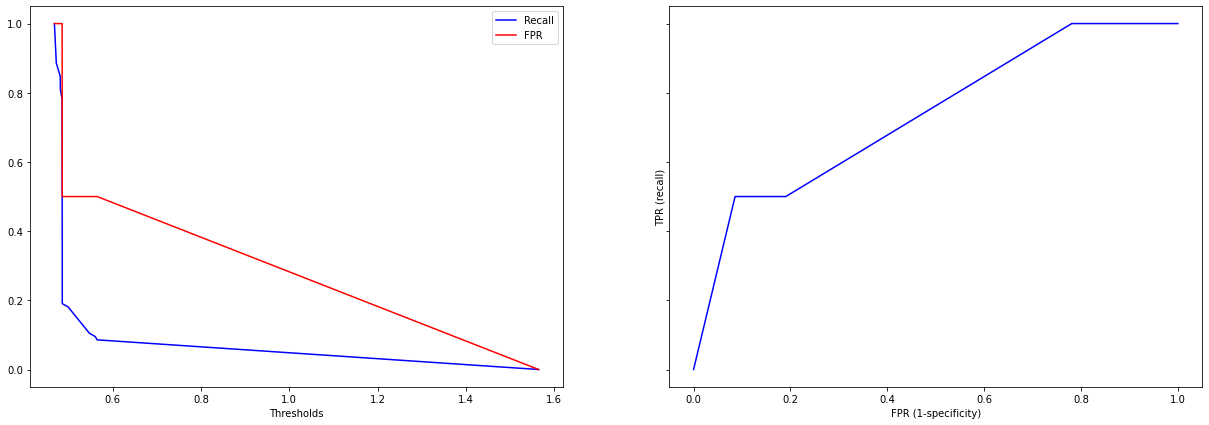

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.586309  0.392660   0.640671     0.779855  0.486826  0.607878
Validation  0.582710  0.393449   0.637887     0.772897  0.486280  0.596399

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008574  0.013049   0.013690     0.010796  0.012742  0.008389
Validation  0.047282  0.040369   0.083777     0.060254  0.053494  0.048685

XGBoost Classifier
╠■■■■■■■■■╣


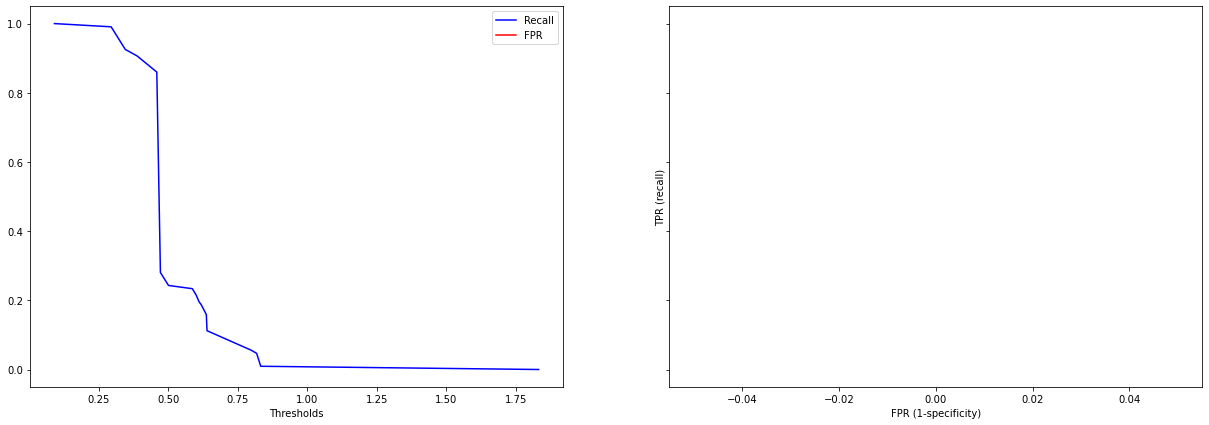

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.604391  0.398036   0.677757     0.810640  0.501422  0.640264
Validation  0.595314  0.385921   0.665830     0.805607  0.487435  0.609081

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005147  0.009347   0.011906     0.012008  0.007361  0.006302
Validation  0.036216  0.055505   0.057607     0.038357  0.055394  0.030946

SVM
╠■■■■■■■■■╣


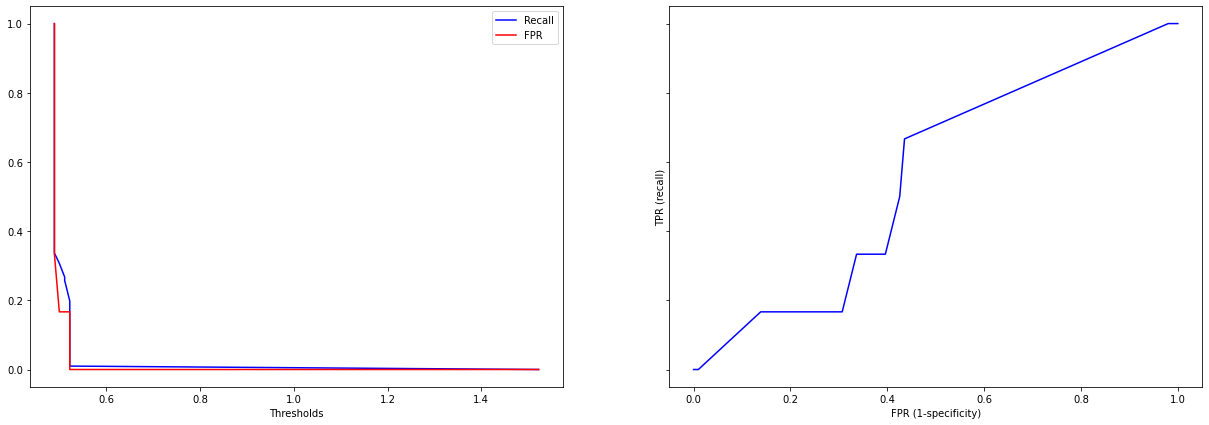

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.534591  0.864909   0.520781     0.204442  0.650084  0.544337
Validation  0.523554  0.868882   0.514620     0.176636  0.646197  0.528288

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006976  0.011445   0.004296     0.016589  0.004924  0.013451
Validation  0.027061  0.041948   0.015673     0.041900  0.021714  0.041647

KNN
╠■■■■■■■■■╣


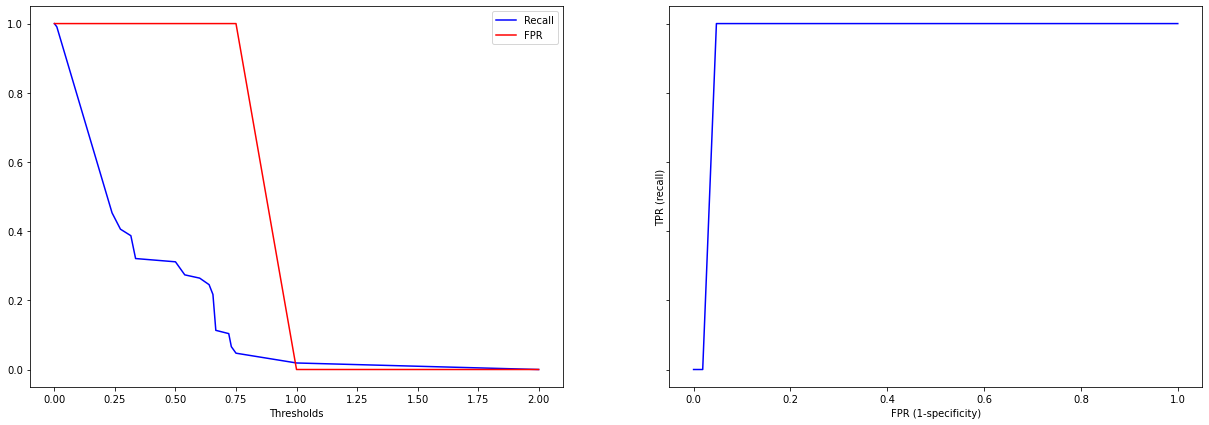

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.601187  0.389762   0.676181     0.812500  0.493132  0.594482
Validation  0.580404  0.376670   0.642091     0.785047  0.471094  0.571229

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008906  0.037901   0.016115     0.027849  0.030967  0.007506
Validation  0.021301  0.062428   0.048922     0.054495  0.048099  0.036353

Logistic Regression
╠■■■■■■■■■╣


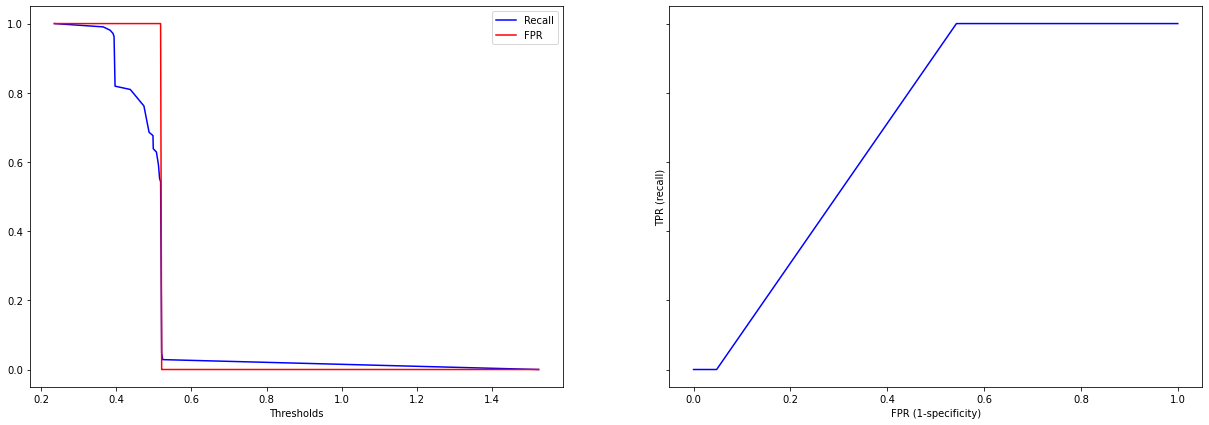

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.545441  0.823361   0.529161     0.267665  0.644217  0.549754
Validation  0.541743  0.819574   0.527559     0.262617  0.641715  0.540774

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006335  0.013408   0.004196     0.017750  0.005041  0.009607
Validation  0.038061  0.049047   0.024664     0.047542  0.031438  0.044146

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498837  0.000000   0.000000     1.000000   
MultinomialNB                   0.532436  0.845665   0.520768     0.217757   
Random Forest (100 estimators)  0.582710  0.393449   0.637887     0.772897   
XGBoost Classifier              0.595314  0.385921   0.665830     0.805607   
SVM                             0.523554  0.868882   0.514620     0.176636   
KNN                             0.580404  0.376670   0.642091     0.785047   
Logistic Regression             0.541743  0.819574   0.527559     0.262617   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.644481  0.531596  
Random Forest (100 estimators)  0.486280  0.596399  
XGBoost Classifier              0.487435  0.609081  
SVM                             0.646197  0.528288  
KNN                             0.471094  0.571229  
Logistic Regression             0.641715  0.540774

Accuracy  \
Dummy Random                    0.49806201550387597-0.49961240310077515   
MultinomialNB                     0.5081777159684346-0.5566951377590159   
Random Forest (100 estimators)    0.5528062865677491-0.6126142741799147   
XGBoost Classifier                 0.572409248593561-0.6182188757272387   
SVM                               0.5064388726702479-0.5406682779491828   
KNN                               0.5669326180831814-0.5938759018037999   
Logistic Regression               0.5176712452931791-0.5658149533592878   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                     0.8196493115831502-0.8716798680637863   
Random Forest (100 estimators)    0.3679175699544743-0.4189810108693403   
XGBoost Classifier               0.35081635457610755-0.4210251130597526   
SVM                                0.8423518403187416-0.895412091837714   
KNN                             0.33718709027313093-0.41615316587086343   
Logistic Regression               0.7885541088083716-0.8505943854803093   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5060819745025468-0.5354541813036501   
Random Forest (100 estimators)  0.5849017911778402-0.6908720966233755   
XGBoost Classifier              0.6293961408930985-0.7022634721774094   
SVM                             0.5047071076200027-0.5245320823088424   
KNN                              0.6111506035618656-0.673032287104515   
Logistic Regression              0.511960221443717-0.5431581637508603   

                                                           Specificity  \
Dummy Random                                                   1.0-1.0   
MultinomialNB                   0.18710052436101549-0.2484134943305733   
Random Forest (100 estimators)   0.7347889627828709-0.8110054297404935   
XGBoost Classifier               0.7813483833845086-0.8298665698865194   
SVM                               0.150135613310733-0.2031354147266501   
KNN                              0.7505811422157275-0.8195123157281977   
Logistic Regression             0.23254846476756716-0.2926851800922458   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6265734833701815-0.6623893124962794   
Random Forest (100 estimators)  0.4524477369287753-0.5201125733242518   
XGBoost Classifier              0.4524005000523927-0.5224685395848265   
SVM                             0.6324639552844968-0.6599304781655464   
KNN                             0.4406730108934748-0.5015141158961696   
Logistic Regression              0.621831767037109-0.6615985196619534   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.4968255464109736-0.5663666942181611  
Random Forest (100 estimators)  0.5656082130494561-0.6271905272578001  
XGBoost Classifier              0.5895090632361977-0.6286528011349426  
SVM                              0.5019481042271813-0.554627433665502  
KNN                              0.5482378385629859-0.594220826757938  
Logistic Regression             0.5128539909327176-0.5686942115627295

In [181]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

The most important features here seem to be <b>wheezes</b>, <b>ctab</b> and <b>labored respiration</b>

Dummy Random
╠■■■■■■■■■╣


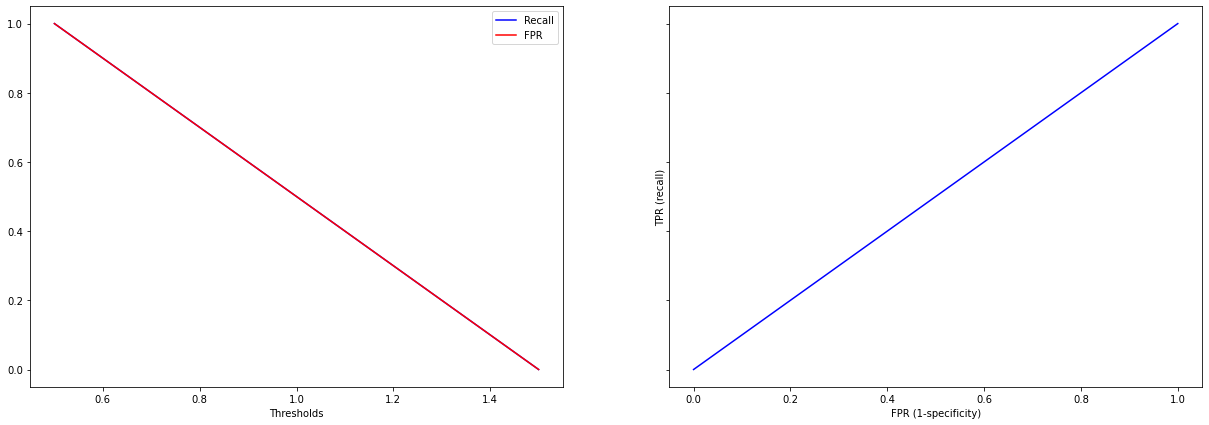

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500129     0.0        0.0          1.0  0.0      0.5
Validation  0.498837     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000136     0.0        0.0          0.0  0.0      0.0
Validation  0.001226     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


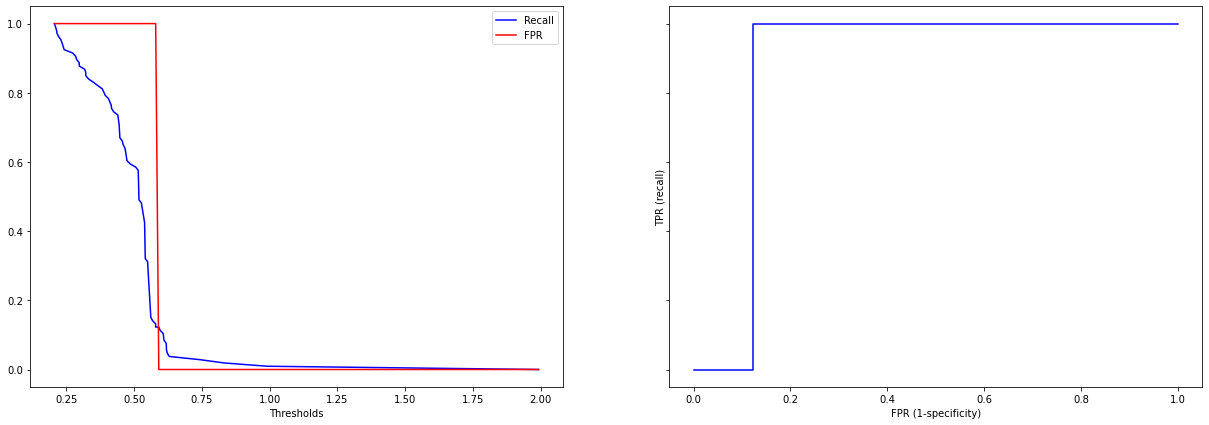

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.545389  0.708635   0.533580     0.382231  0.606496  0.561367
Validation  0.538902  0.700389   0.532215     0.376636  0.601167  0.541933

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.016019  0.097682   0.009860      0.07487  0.041026  0.013428
Validation  0.046532  0.107723   0.041135      0.12670  0.050422  0.051442

Random Forest (100 estimators)
╠■■■■■■■■■╣


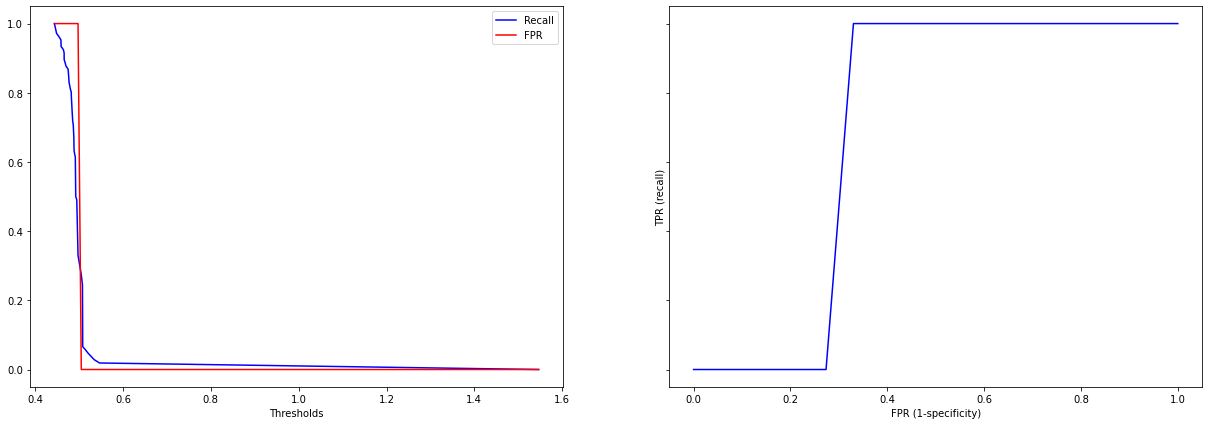

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589045  0.552241   0.598288     0.625826  0.571337  0.626147
Validation  0.575760  0.536760   0.586270     0.614953  0.556914  0.603465

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006759  0.066292   0.019604     0.067749  0.032011  0.009940
Validation  0.020339  0.072024   0.028765     0.079522  0.038584  0.023281

XGBoost Classifier
╠■■■■■■■■■╣


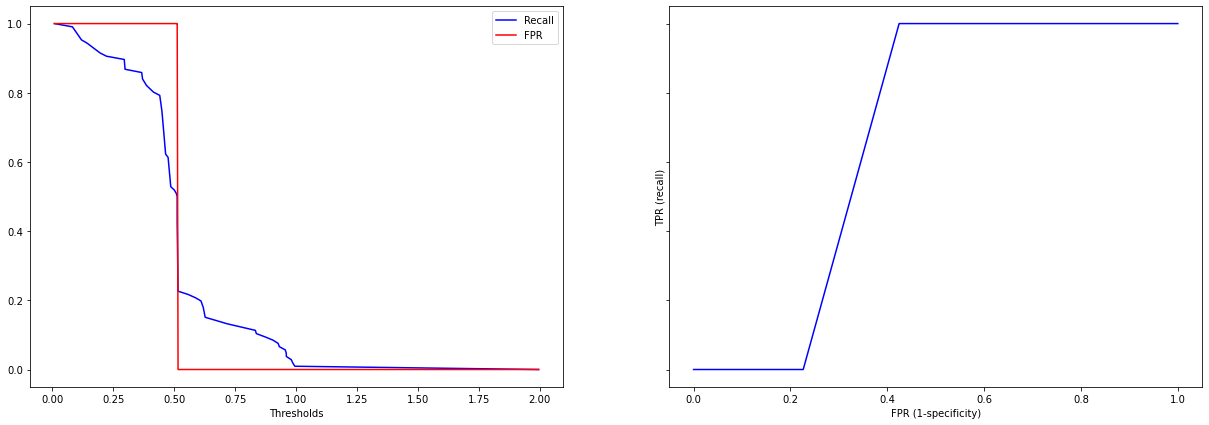

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.645982  0.531290   0.695941     0.760640  0.597429  0.722918
Validation  0.571567  0.439711   0.603048     0.703738  0.501667  0.607097

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005934  0.078002   0.037429     0.079413  0.033701  0.006242
Validation  0.022419  0.099914   0.036810     0.095720  0.061978  0.027256

SVM
╠■■■■■■■■■╣


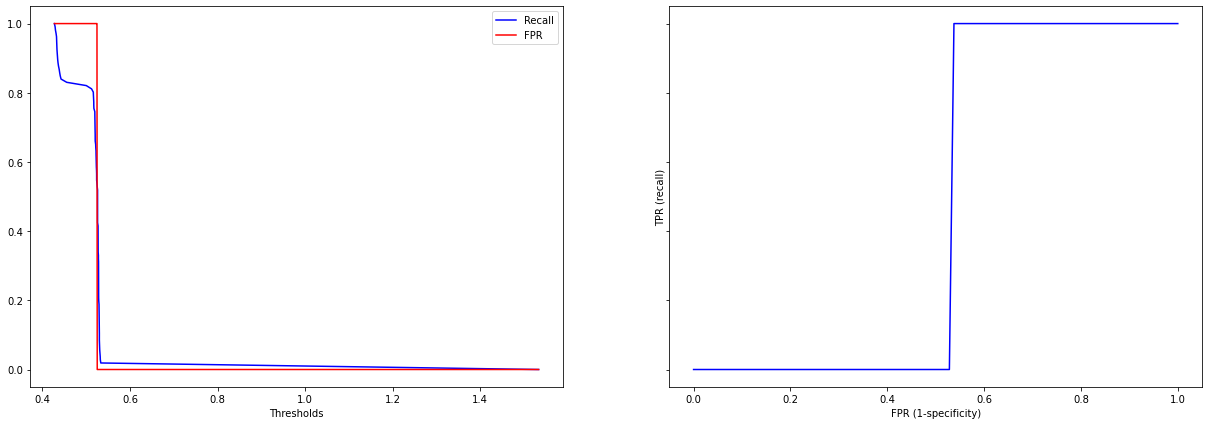

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.544458  0.698039   0.481543     0.390909  0.567815  0.559381
Validation  0.535705  0.687928   0.476847     0.383178  0.560028  0.546024

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.017260  0.258913   0.169451     0.235115  0.200629  0.021135
Validation  0.032179  0.263951   0.169156     0.248675  0.200137  0.038279

KNN
╠■■■■■■■■■╣


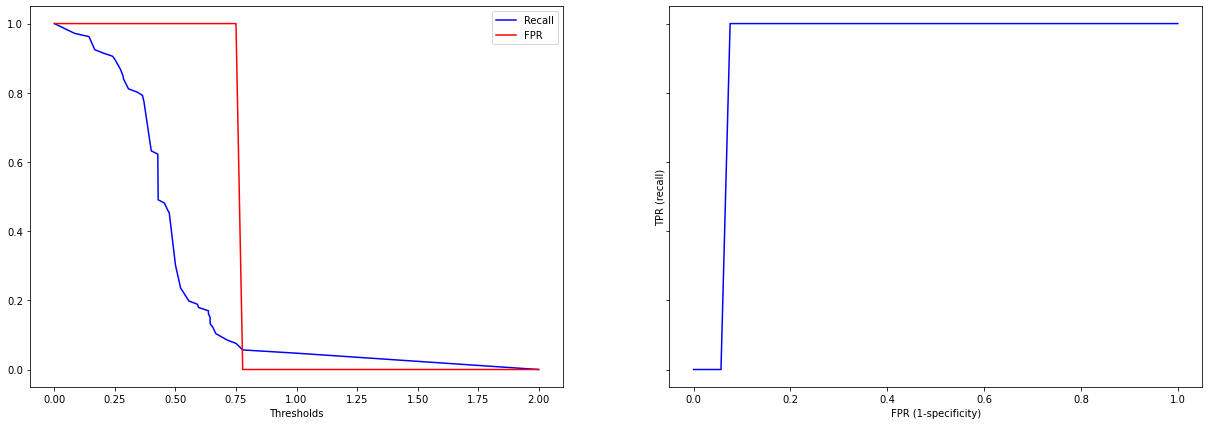

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.644794  0.451262   0.736328     0.838223  0.559275  0.691831
Validation  0.564516  0.371132   0.609164     0.758879  0.460628  0.573230

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007996  0.019793   0.013586     0.014546  0.015633  0.008754
Validation  0.029175  0.029620   0.052084     0.045101  0.033656  0.044936

Logistic Regression
╠■■■■■■■■■╣


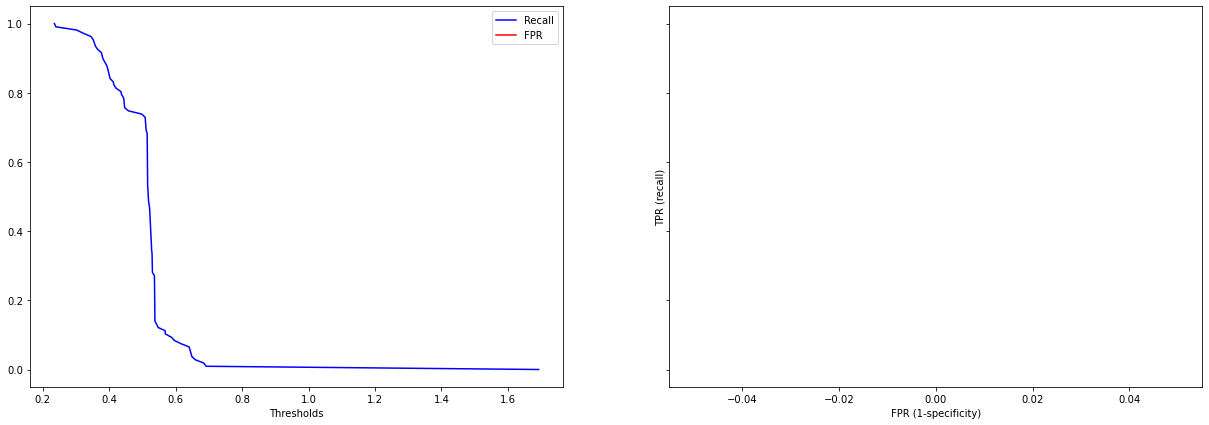

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.559339  0.701702   0.546340     0.417045  0.612869  0.581064
Validation  0.569222  0.700476   0.556891     0.437383  0.616254  0.581045

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009607  0.069376   0.007814     0.063810  0.026806  0.010854
Validation  0.025270  0.112875   0.022585     0.109328  0.047411  0.036409

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498837  0.000000   0.000000     1.000000   
MultinomialNB                   0.538902  0.700389   0.532215     0.376636   
Random Forest (100 estimators)  0.575760  0.536760   0.586270     0.614953   
XGBoost Classifier              0.571567  0.439711   0.603048     0.703738   
SVM                             0.535705  0.687928   0.476847     0.383178   
KNN                             0.564516  0.371132   0.609164     0.758879   
Logistic Regression             0.569222  0.700476   0.556891     0.437383   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.601167  0.541933  
Random Forest (100 estimators)  0.556914  0.603465  
XGBoost Classifier              0.501667  0.607097  
SVM                             0.560028  0.546024  
KNN                             0.460628  0.573230  
Logistic Regression             0.616254  0.581045

Accuracy  \
Dummy Random                    0.49806201550387597-0.49961240310077515   
MultinomialNB                     0.5094731659763927-0.5683316590616425   
Random Forest (100 estimators)    0.5628962175936779-0.5886230173552461   
XGBoost Classifier                0.5573883240226977-0.5857457772596323   
SVM                               0.5153531830588328-0.5560573798622711   
KNN                               0.5460642997114749-0.5829685192409266   
Logistic Regression               0.5532394754524493-0.5852043411091675   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.632259137306348-0.7685196788930289   
Random Forest (100 estimators)  0.4912081546666547-0.5823120945545293   
XGBoost Classifier              0.3765197549604361-0.5029021903493598   
SVM                             0.5209913470508378-0.8548653507684767   
KNN                             0.3523983557954806-0.3898654032907084   
Logistic Regression             0.6290878158156425-0.7718640706502624   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5061995968212702-0.5582313903408287   
Random Forest (100 estimators)  0.5680778459585212-0.6044625145718163   
XGBoost Classifier              0.5797666388569723-0.6263284568952786   
SVM                             0.3698630768635629-0.5838299718581192   
KNN                             0.5762231131776556-0.6421048252031534   
Logistic Regression             0.5426073523484608-0.5711751406965256   

                                                           Specificity  \
Dummy Random                                                   1.0-1.0   
MultinomialNB                   0.2965035395311357-0.45676748850624743   
Random Forest (100 estimators)   0.5646593493567338-0.6652471926993411   
XGBoost Classifier               0.6431994962964425-0.7642771392175762   
SVM                             0.22590142827691484-0.5404537119100009   
KNN                              0.7303538364055836-0.7874031729402108   
Logistic Regression             0.36823833321368177-0.5065280219265049   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.5692773571520818-0.633056170455672   
Random Forest (100 estimators)  0.5325108323138161-0.5813167754399109   
XGBoost Classifier               0.4624687944954716-0.540865714028458   
SVM                             0.4334507424932563-0.6866056468981059   
KNN                             0.4393419612322072-0.4819142536245124   
Logistic Regression             0.5862688224904521-0.6462400602495407   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5093978363962078-0.5744678093176344  
Random Forest (100 estimators)  0.5887412200620311-0.6181897588686861  
XGBoost Classifier              0.5898589814867815-0.6243352065872213  
SVM                             0.5218146242431568-0.5702338483713042  
KNN                             0.5448102665384846-0.6016502847631009  
Logistic Regression             0.5580182328337282-0.6040721001405245

In [182]:
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

Adding the epidemiological factors doesn't seem to make much difference in performance metrics. However, <b>days_since_symptom_onset</b> appears to become more important after adding the factors.

### Reported symptoms

In [183]:
r_symptoms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46525 entries, 46889 to 47067
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cough           46516 non-null  object 
 1   cough_severity  46516 non-null  float64
 2   fever           43579 non-null  object 
 3   sob             46443 non-null  object 
 4   sob_severity    46443 non-null  float64
 5   diarrhea        46459 non-null  object 
 6   fatigue         46468 non-null  object 
 7   headache        46461 non-null  object 
 8   loss_of_smell   46456 non-null  object 
 9   loss_of_taste   46456 non-null  object 
 10  runny_nose      46458 non-null  object 
 11  muscle_sore     46463 non-null  object 
 12  sore_throat     46462 non-null  object 
dtypes: float64(2), object(11)
memory usage: 6.0+ MB


In [265]:
#All datasets that contain reported symptoms
r_symptoms.dropna(how="all", inplace=True)
ra_symptoms = pd.merge(r_symptoms, a_symptoms, left_index=True, right_index=True)
r_symptoms_ex = pd.merge(r_symptoms, e_factors, left_index=True, right_index=True)
r_symptoms_vitals = pd.merge(r_symptoms, vitals, left_index=True, right_index=True)
r_symptoms_svitals = pd.merge(r_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
ra_symptoms_nvitals = pd.merge(ra_symptoms, n_vitals, left_index=True, right_index=True)
ra_symptoms_svitals = pd.merge(ra_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals_ex = pd.merge(ra_symptoms_vitals, e_factors, left_index=True, right_index=True)
ra_symptoms_nvitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)
ra_symptoms_svitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


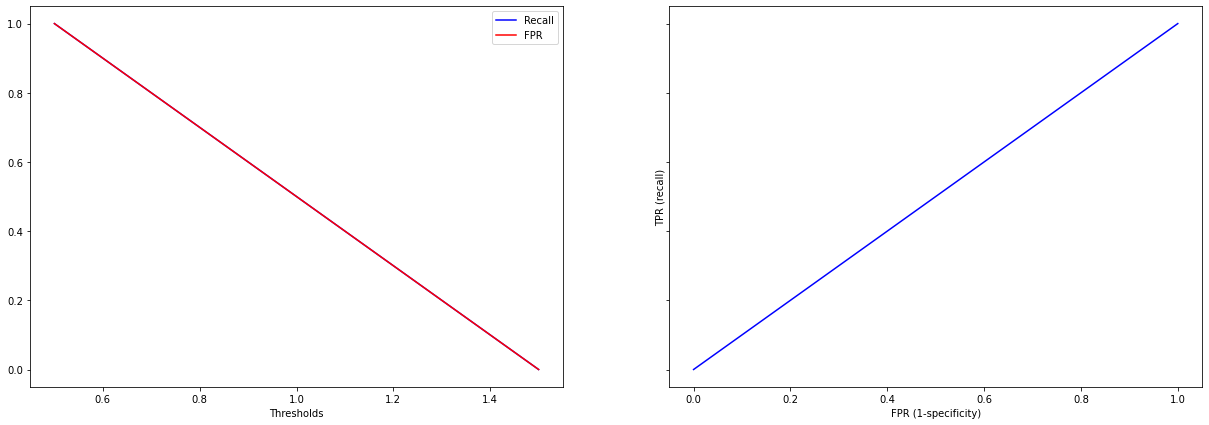

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500050     0.0        0.0          1.0  0.0      0.5
Validation  0.499548     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000106     0.0        0.0          0.0  0.0      0.0
Validation  0.000954     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


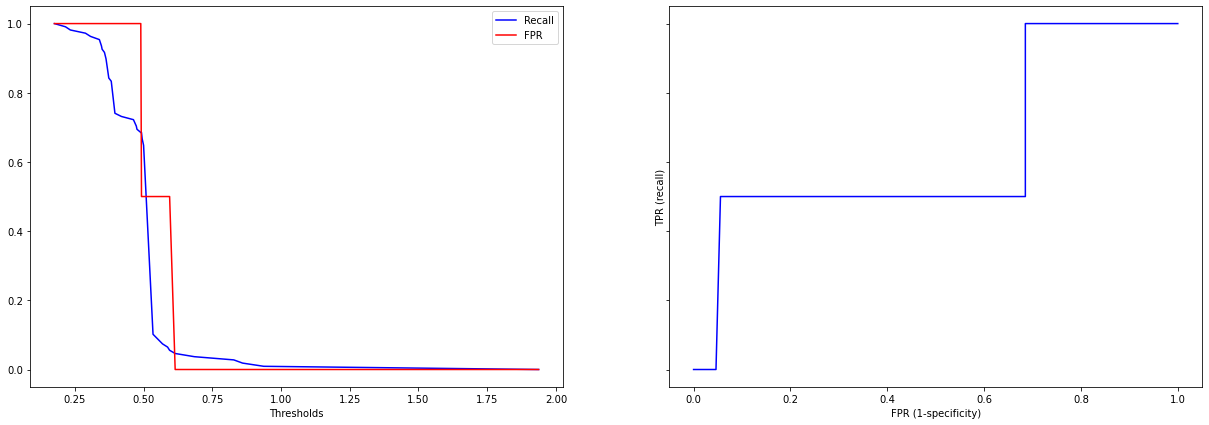

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.631364  0.370133   0.775324     0.892540  0.500878  0.614771
Validation  0.634449  0.377518   0.780313     0.891818  0.507926  0.608907

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007043  0.013572   0.017447     0.011427  0.012775  0.008731
Validation  0.024454  0.032069   0.056296     0.035970  0.034683  0.030154

Random Forest (100 estimators)
╠■■■■■■■■■╣


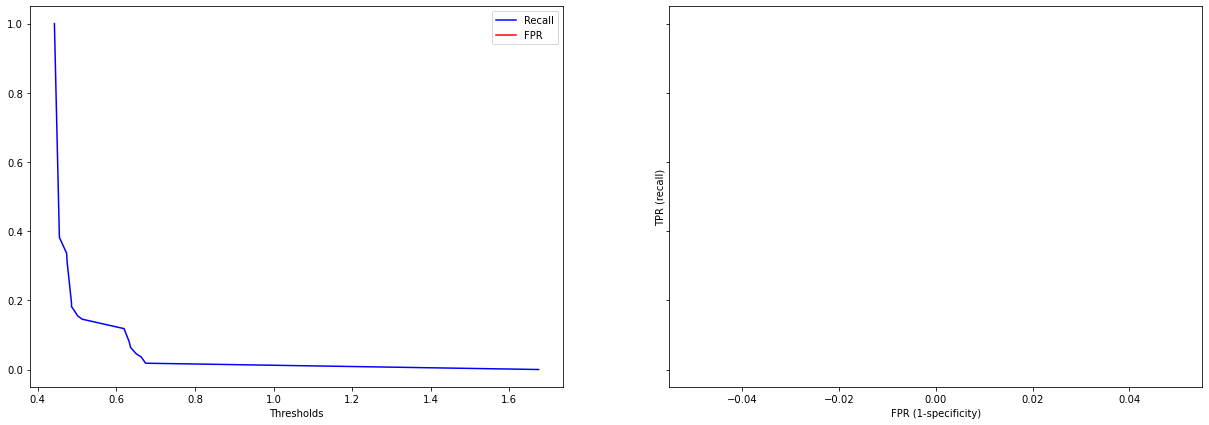

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.631918  0.430127   0.721682     0.833669  0.538778  0.653408
Validation  0.625343  0.426478   0.709869     0.824545  0.531335  0.651906

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005477  0.011462   0.016444     0.016902  0.007133  0.007513
Validation  0.019920  0.047039   0.030801     0.030318  0.038592  0.029879

XGBoost Classifier
╠■■■■■■■■■╣


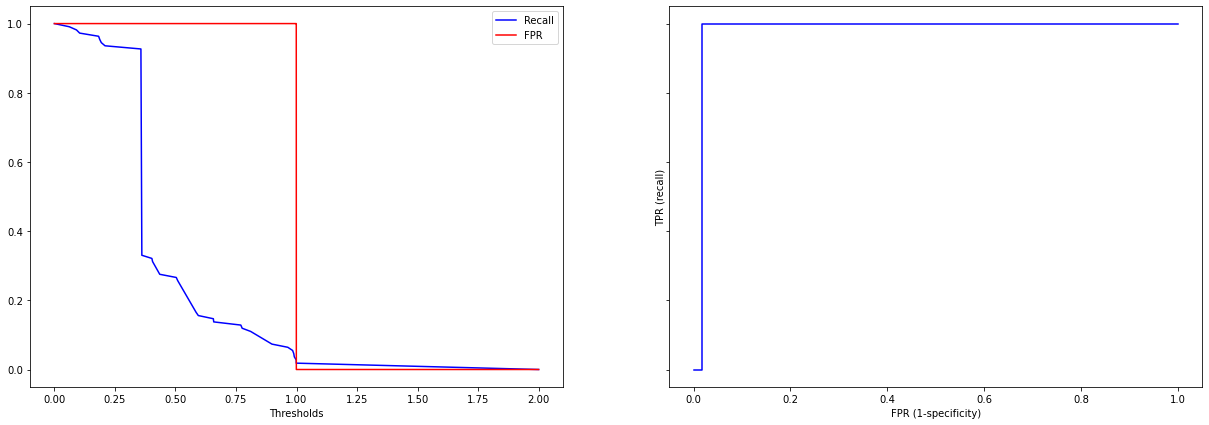

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.706926  0.510482   0.841071     0.903327  0.635158  0.761111
Validation  0.642125  0.446462   0.735169     0.838182  0.553873  0.644683

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003630  0.013603   0.010723     0.009836  0.008579  0.004401
Validation  0.028298  0.054995   0.044625     0.035026  0.047156  0.040109

SVM
╠■■■■■■■■■╣


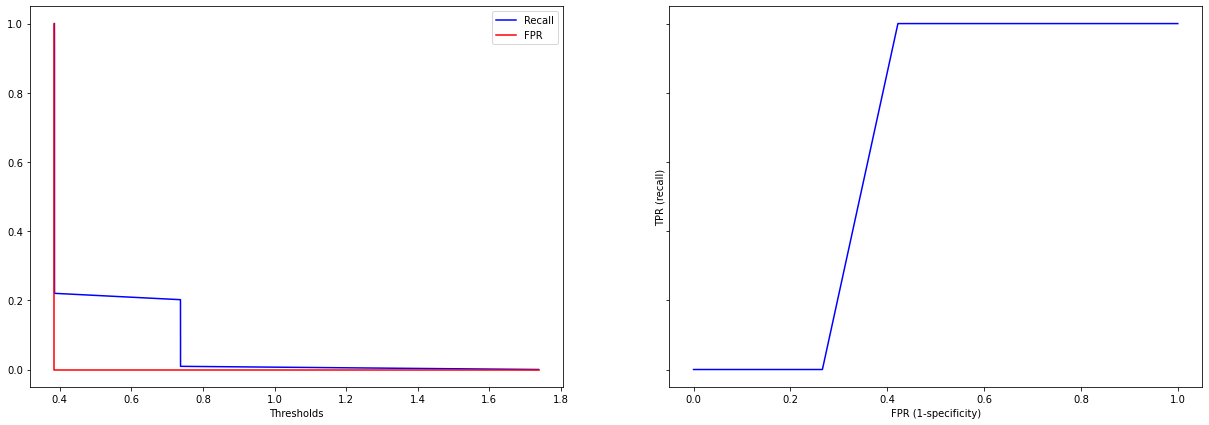

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.656870  0.465714   0.754747     0.847984  0.575203  0.688177
Validation  0.653939  0.462826   0.751624     0.845455  0.571725  0.682677

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006506  0.030034   0.013396     0.019267  0.020788  0.008729
Validation  0.034650  0.047712   0.061189     0.042855  0.047687  0.036837

KNN
╠■■■■■■■■■╣


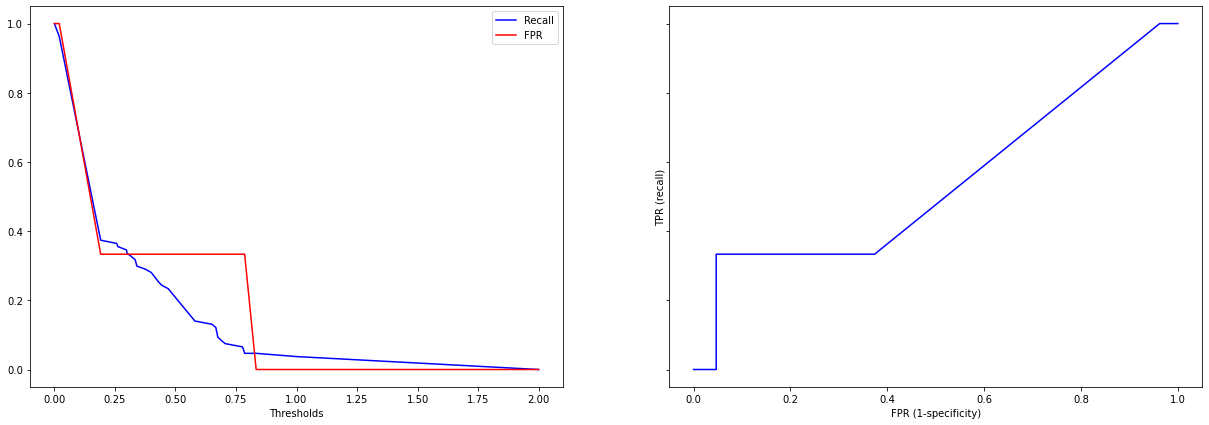

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.707581  0.493949   0.862648     0.921169  0.628082  0.746693
Validation  0.643056  0.441884   0.740103     0.844545  0.552343  0.668734

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004131  0.009041   0.013470     0.009608  0.006318  0.003856
Validation  0.031642  0.050638   0.045926     0.032482  0.048207  0.043539

Logistic Regression
╠■■■■■■■■■╣


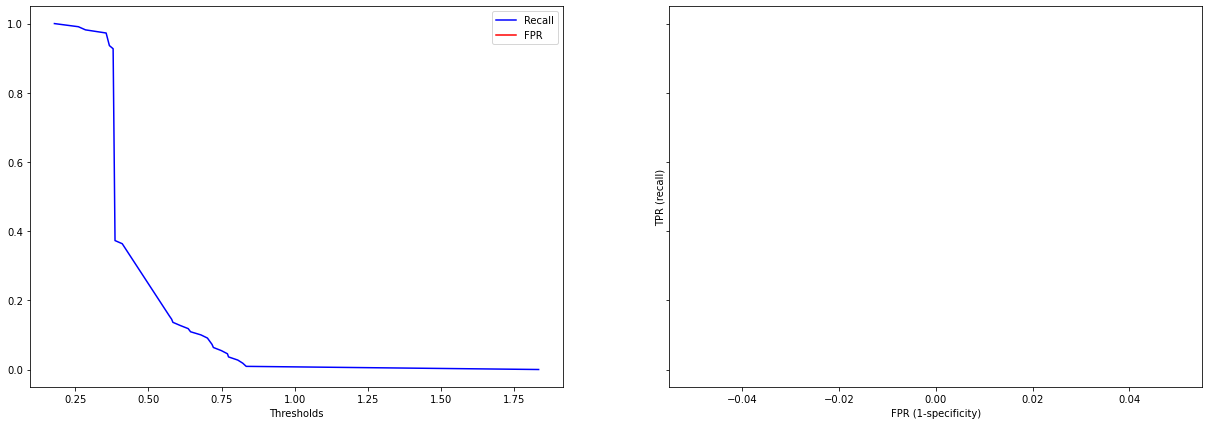

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662265  0.485584   0.751250     0.838911  0.589757  0.690171
Validation  0.660317  0.486355   0.750706     0.834545  0.588731  0.678066

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008064  0.009742   0.017429     0.015817  0.008675  0.007426
Validation  0.038557  0.045721   0.072121     0.056497  0.045538  0.031116

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499548  0.000000   0.000000     1.000000   
MultinomialNB                   0.634449  0.377518   0.780313     0.891818   
Random Forest (100 estimators)  0.625343  0.426478   0.709869     0.824545   
XGBoost Classifier              0.642125  0.446462   0.735169     0.838182   
SVM                             0.653939  0.462826   0.751624     0.845455   
KNN                             0.643056  0.441884   0.740103     0.844545   
Logistic Regression             0.660317  0.486355   0.750706     0.834545   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.507926  0.608907  
Random Forest (100 estimators)  0.531335  0.651906  
XGBoost Classifier              0.553873  0.644683  
SVM                             0.571725  0.682677  
KNN                             0.552343  0.668734  
Logistic Regression             0.588731  0.678066

Accuracy  \
Dummy Random                    0.4989441930618401-0.5001508295625943   
MultinomialNB                   0.6189825222965717-0.6499150507186484   
Random Forest (100 estimators)  0.6127448732922185-0.6379420868065064   
XGBoost Classifier              0.6242274477687755-0.6600218323628577   
SVM                             0.6320238731327886-0.6758535435681577   
KNN                             0.6230441679922785-0.6630685428263146   
Logistic Regression             0.6359313225902369-0.6847021615726591   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.3572362856722579-0.3978005693645971   
Random Forest (100 estimators)  0.39672835004296086-0.4562282429136321   
XGBoost Classifier               0.4116798898689024-0.4812439430549305   
SVM                             0.43264953510618537-0.4930015705449203   
KNN                              0.4098575959535034-0.4739098078139004   
Logistic Regression             0.45743923269604087-0.5152716600148519   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.7447086941351961-0.815917902025814   
Random Forest (100 estimators)   0.6903888711202106-0.729349032162542   
XGBoost Classifier              0.7069463882559207-0.7633925171022565   
SVM                             0.7129248183330992-0.7903230147219262   
KNN                             0.7110565772906291-0.7691489404343413   
Logistic Regression             0.7050925852254463-0.7963198027687067   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8690686977222746-0.9145676659140891   
Random Forest (100 estimators)  0.8053705551278104-0.8437203539630985   
XGBoost Classifier               0.8160294946878823-0.860334141675754   
SVM                             0.8183506911818206-0.8725583997272701   
KNN                             0.8240018772646324-0.8650890318262766   
Logistic Regression             0.7988135685503427-0.8702773405405665   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.4859905789833886-0.5298610522339092   
Random Forest (100 estimators)  0.5069274383430727-0.5557426263866921   
XGBoost Classifier              0.5240484715869568-0.5836969565278668   
SVM                             0.5415654879372871-0.6018849171759482   
KNN                             0.5218543332333045-0.5828324388071586   
Logistic Regression             0.5599304291561756-0.6175318759385492   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5898356205941062-0.6279781684015009  
Random Forest (100 estimators)   0.6330095698501622-0.670803325690006  
XGBoost Classifier              0.6193162635425726-0.6700502765512402  
SVM                             0.6593798251196509-0.7059750255988363  
KNN                             0.6411978893702651-0.6962709513713029  
Logistic Regression             0.6583866951352253-0.6977461319066924

In [185]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Not surprisingly, <b>cough</b> and <b>cough_severity</b> seem to be the most important ones. Also, almost <b>all of them</b> seem to be <b>relevant</b> for some model, <b>except</b> for <b>diarreah</b> and <b>runny_nose</b>.

Dummy Random
╠■■■■■■■■■╣


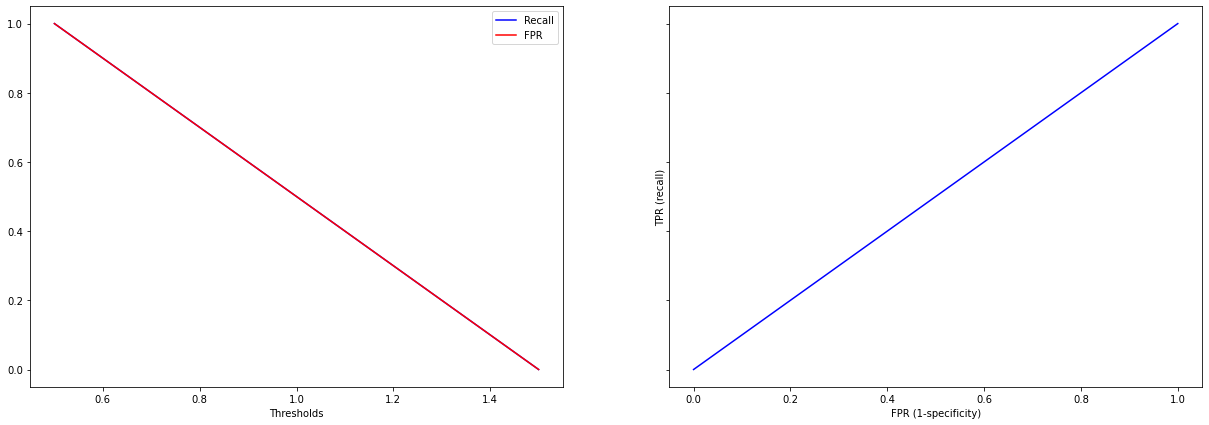

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500050     0.0        0.0          1.0  0.0      0.5
Validation  0.499548     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000106     0.0        0.0          0.0  0.0      0.0
Validation  0.000954     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


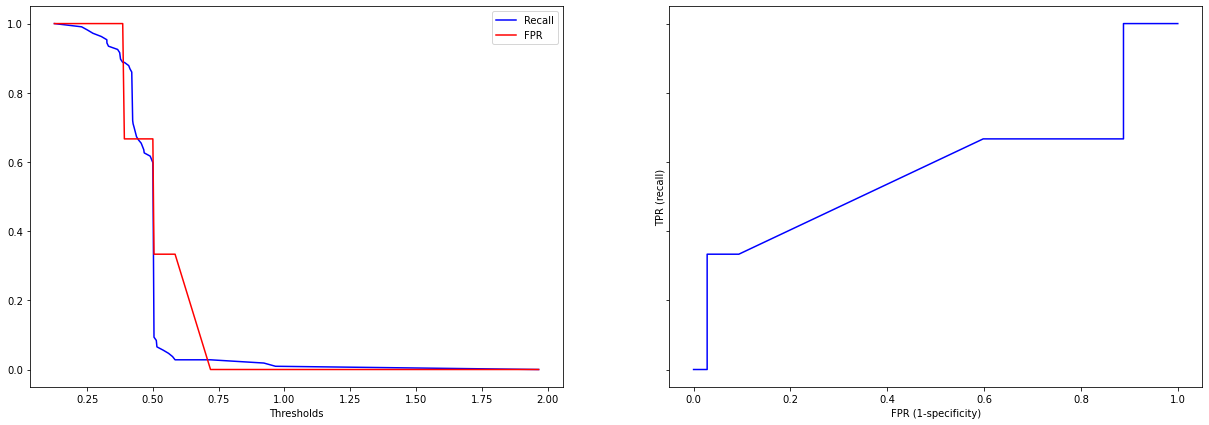

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.622745  0.336563   0.786679     0.908871  0.471189  0.597251
Validation  0.621271  0.330295   0.795637     0.912727  0.465254  0.585060

Spread in metrics (sample std)


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009814  0.02023   0.012696     0.005805  0.021263  0.017704
Validation  0.023893  0.03785   0.067450     0.034069  0.040512  0.023080

Random Forest (100 estimators)
╠■■■■■■■■■╣


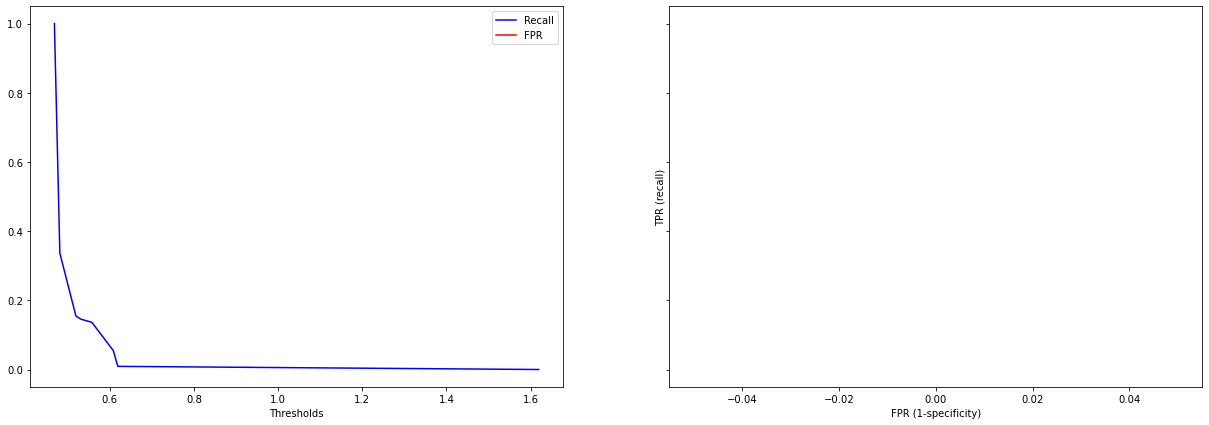

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.639581  0.472576   0.710014     0.806552  0.567300  0.661812
Validation  0.631230  0.469115   0.695543     0.793636  0.559191  0.651843

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007890  0.008801   0.017734     0.018346  0.006921  0.007886
Validation  0.027842  0.048128   0.038906     0.038581  0.041035  0.028847

XGBoost Classifier
╠■■■■■■■■■╣


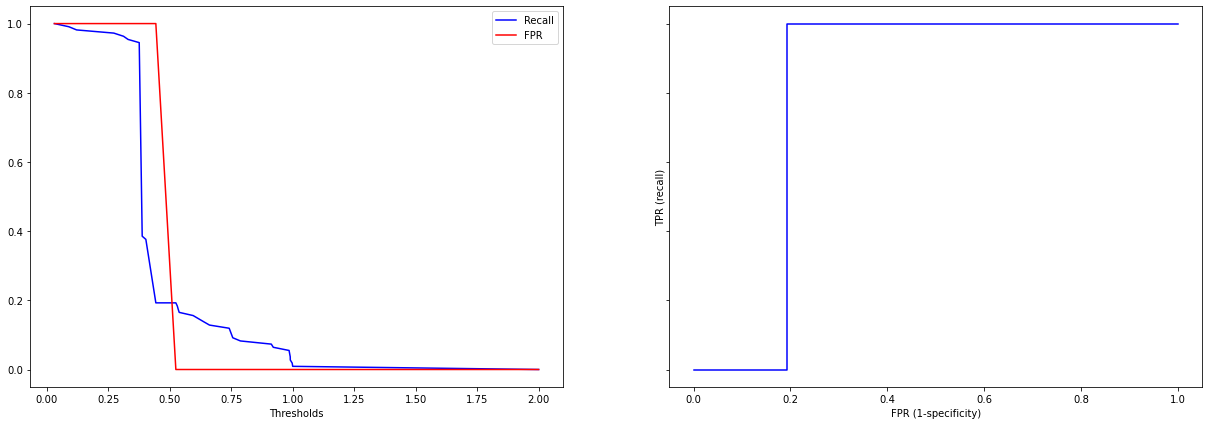

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.707733  0.516235   0.836880     0.899194  0.638405  0.761996
Validation  0.643961  0.459148   0.729577     0.829091  0.562930  0.666445

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004529  0.012916   0.011355     0.009911  0.008560  0.005142
Validation  0.027429  0.040200   0.041872     0.031724  0.038319  0.037251

SVM
╠■■■■■■■■■╣


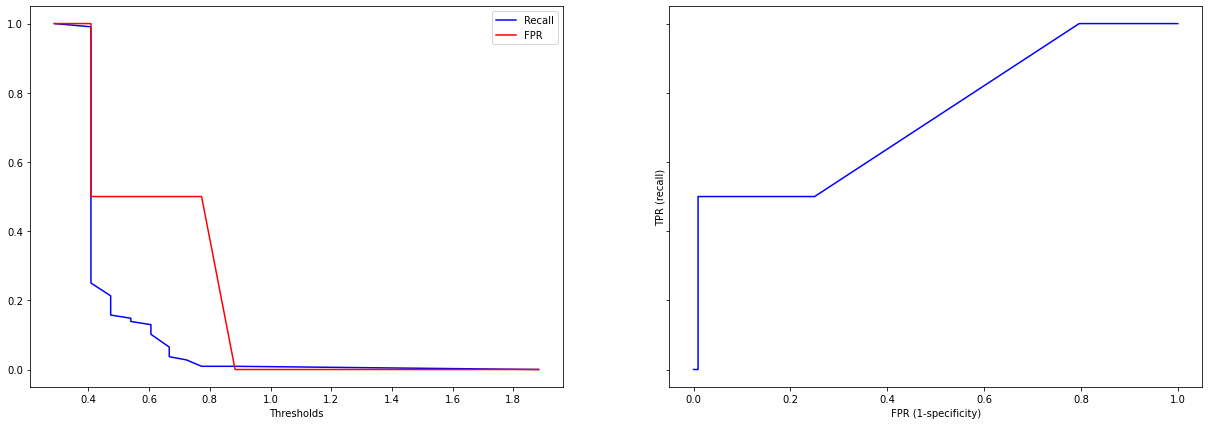

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661205  0.476406   0.756971     0.845968  0.583863  0.686388
Validation  0.650311  0.471835   0.734026     0.829091  0.573925  0.671806

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005671  0.030062   0.019143     0.024267  0.018592  0.007451
Validation  0.029536  0.043004   0.044483     0.028036  0.043504  0.038859

KNN
╠■■■■■■■■■╣


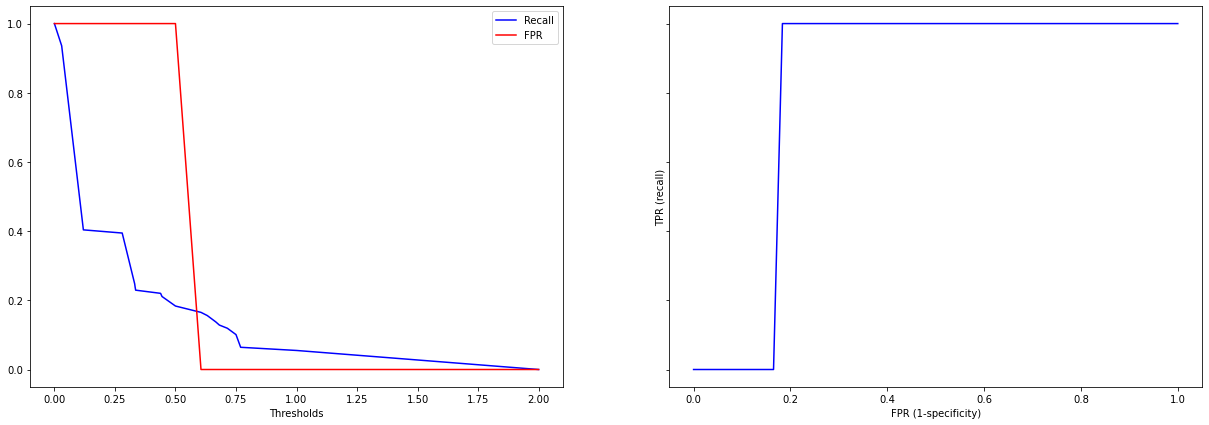

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.704910  0.486287   0.864134     0.923488  0.622259  0.740982
Validation  0.645775  0.440082   0.748932     0.851818  0.553405  0.654073

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005864  0.011589   0.010035     0.006795  0.009868  0.008561
Validation  0.028110  0.045868   0.046050     0.030620  0.043212  0.032500

Logistic Regression
╠■■■■■■■■■╣


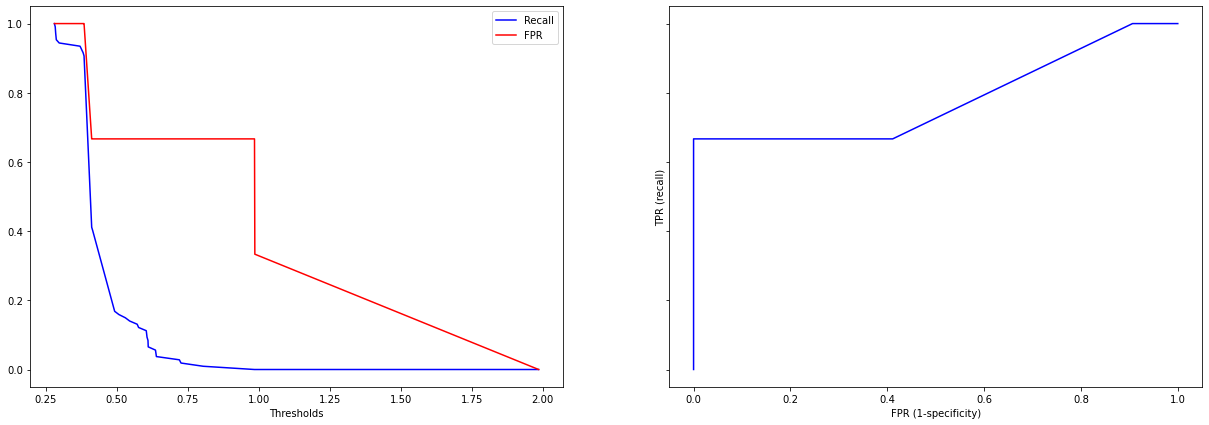

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661710  0.495760   0.746439     0.827621  0.593814  0.691923
Validation  0.655304  0.493661   0.736173     0.817273  0.586606  0.687383

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008798  0.037137   0.037911     0.052286  0.012923  0.005351
Validation  0.024872  0.075546   0.053278     0.068360  0.045513  0.028521

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499548  0.000000   0.000000     1.000000   
MultinomialNB                   0.621271  0.330295   0.795637     0.912727   
Random Forest (100 estimators)  0.631230  0.469115   0.695543     0.793636   
XGBoost Classifier              0.643961  0.459148   0.729577     0.829091   
SVM                             0.650311  0.471835   0.734026     0.829091   
KNN                             0.645775  0.440082   0.748932     0.851818   
Logistic Regression             0.655304  0.493661   0.736173     0.817273   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.465254  0.585060  
Random Forest (100 estimators)  0.559191  0.651843  
XGBoost Classifier              0.562930  0.666445  
SVM                             0.573925  0.671806  
KNN                             0.553405  0.654073  
Logistic Regression             0.586606  0.687383

Accuracy  \
Dummy Random                    0.4989441930618401-0.5001508295625943   
MultinomialNB                   0.6061597143793526-0.6363824493392815   
Random Forest (100 estimators)  0.6136211258600505-0.6488387671880779   
XGBoost Classifier              0.6266135830577357-0.6613090825119885   
SVM                             0.6316301534777953-0.6689909900845248   
KNN                              0.6279970672523814-0.663553734886656   
Logistic Regression             0.6395741904147356-0.6710346125470086   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                    0.3063565243400834-0.35423315624959717   
Random Forest (100 estimators)   0.4386766812559002-0.49955427697505794   
XGBoost Classifier              0.43372370979962904-0.48457276849684927   
SVM                               0.4446363410692601-0.4990327825998634   
KNN                              0.4110724928538823-0.46909130730991794   
Logistic Regression               0.4458811674261744-0.5414406998956929   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.752978090093345-0.8382963320277016   
Random Forest (100 estimators)  0.6709369411139359-0.7201500295102714   
XGBoost Classifier              0.7030948176798297-0.7560592314669043   
SVM                             0.7058931665719439-0.7621596653397207   
KNN                             0.7198072047343407-0.7780560735737116   
Logistic Regression             0.7024772922008209-0.7698694313370793   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8911801347459016-0.9342744107086438   
Random Forest (100 estimators)  0.7692353671040032-0.8180373601687242   
XGBoost Classifier              0.8090267329003067-0.8491550852815111   
SVM                             0.8113591044383905-0.8468227137434277   
KNN                              0.8324526723531268-0.871183691283237   
Logistic Regression             0.7740380440557291-0.8605074104897257   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.4396315514109986-0.49087613062484187   
Random Forest (100 estimators)   0.5332376171602319-0.5851435422382357   
XGBoost Classifier               0.5386942971490561-0.5871649226034573   
SVM                              0.5464103935689814-0.6014390750022874   
KNN                              0.5260754883473603-0.5807350275387012   
Logistic Regression               0.557821238842055-0.6153908642311555   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5704629126346716-0.5996565125756625  
Random Forest (100 estimators)  0.6335990153876578-0.6700879029356244  
XGBoost Classifier              0.6428857148936248-0.6900052835428282  
SVM                             0.6472299670430468-0.6963826455695659  
KNN                             0.6335187507935018-0.6746279992623392  
Logistic Regression             0.6693450948915635-0.7054213409657816

In [186]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

In almost all models performance went down if we removed the booleanw <b>cough</b> and <b>sob</b> in favor of the graded <b>cough_severity</b>.


Dummy Random
╠■■■■■■■■■╣


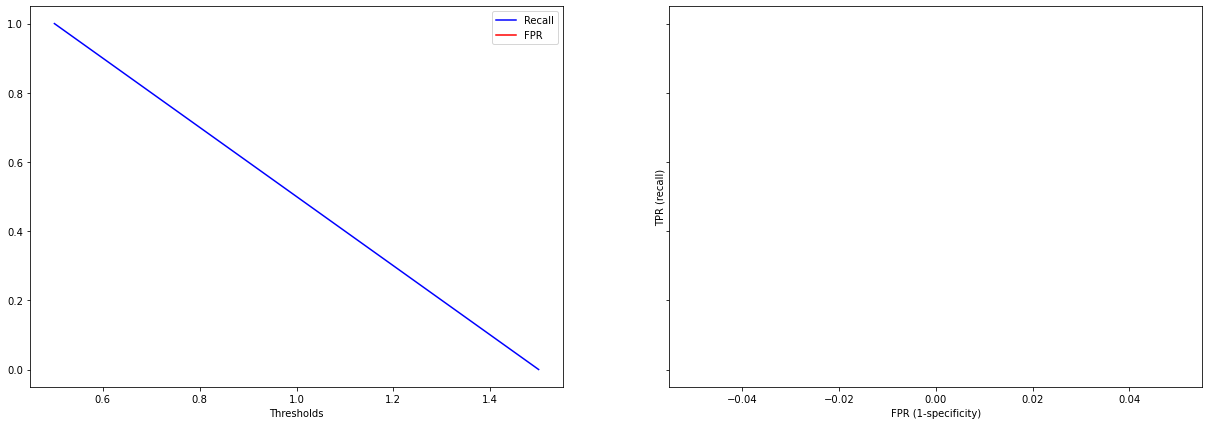

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500050     0.0        0.0          1.0  0.0      0.5
Validation  0.499548     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000106     0.0        0.0          0.0  0.0      0.0
Validation  0.000954     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


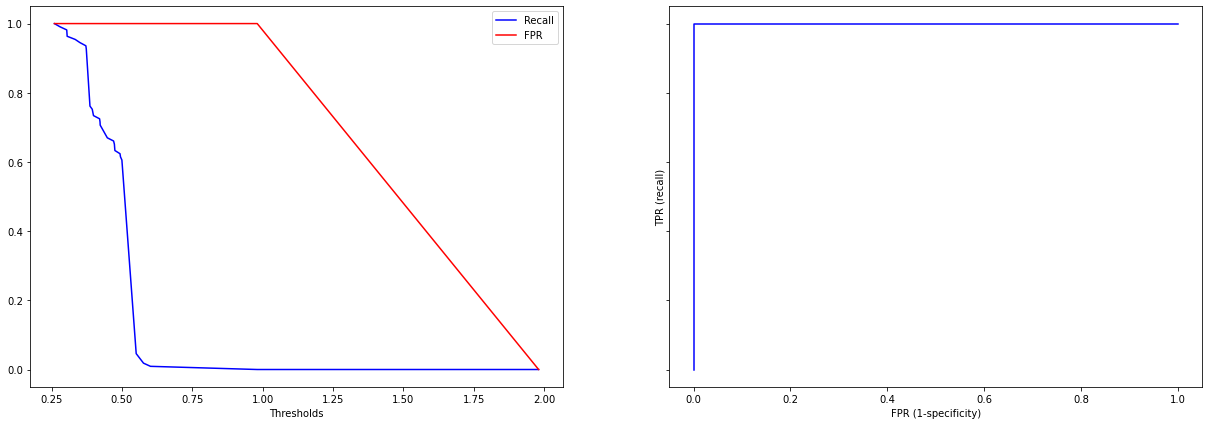

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.614577  0.322340   0.776274     0.906754  0.454952  0.584542
Validation  0.622624  0.336691   0.789734     0.909091  0.470685  0.601234

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010485  0.024254   0.023023     0.014447  0.024648  0.015878
Validation  0.015108  0.037223   0.032957     0.021852  0.035351  0.032640

Random Forest (100 estimators)
╠■■■■■■■■■╣


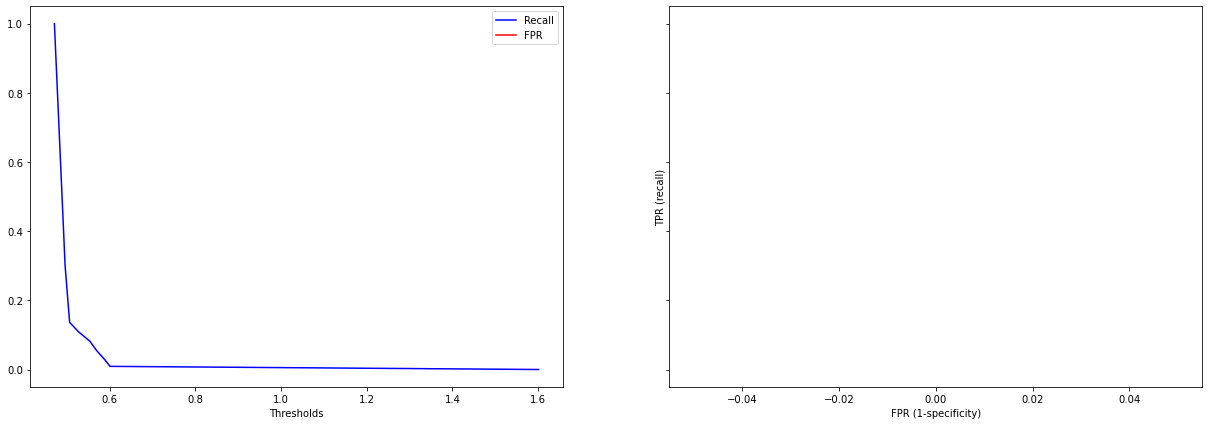

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.633481  0.468641   0.699204     0.798286  0.561068  0.658007
Validation  0.643494  0.464595   0.725624     0.822727  0.565681  0.660470

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005054  0.010347   0.009730     0.010934  0.007549  0.007039
Validation  0.023471  0.034158   0.042689     0.035662  0.031542  0.041659

XGBoost Classifier
╠■■■■■■■■■╣


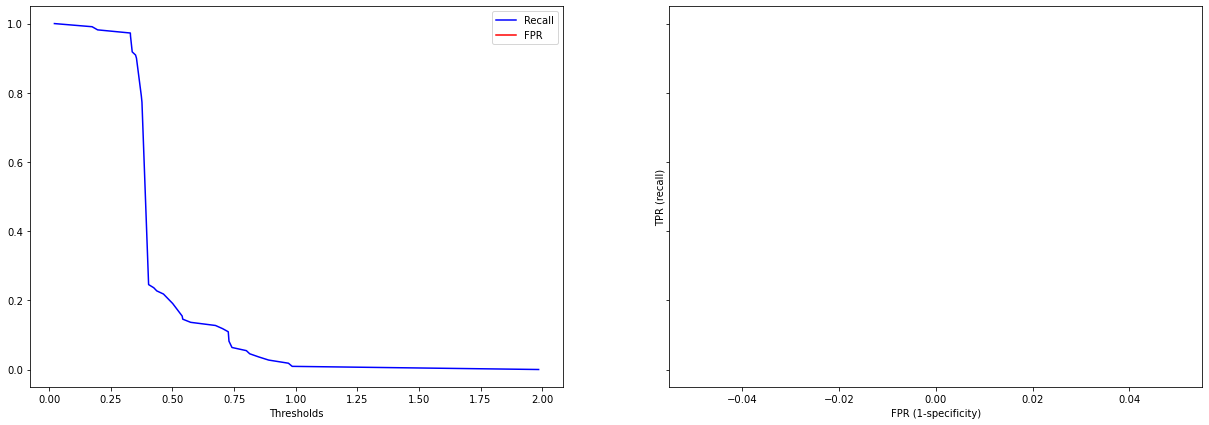

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.700121  0.513814   0.819152     0.886391  0.631381  0.751360
Validation  0.658032  0.457330   0.764739     0.859091  0.571409  0.673433

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005965  0.011909   0.013073     0.011002  0.008895  0.005720
Validation  0.030336  0.049466   0.044543     0.029458  0.046119  0.034195

SVM
╠■■■■■■■■■╣


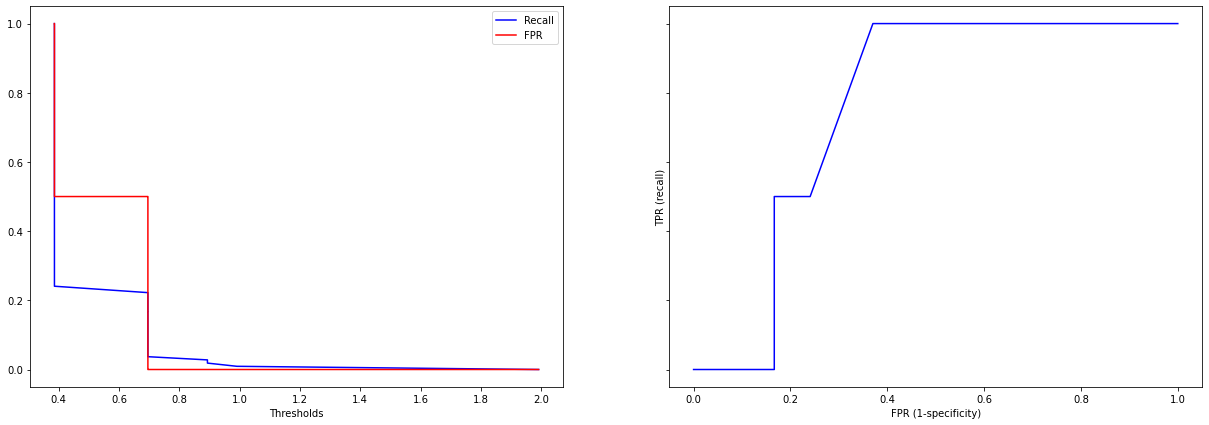

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.657274  0.464405   0.756822     0.850101  0.575074  0.687920
Validation  0.653026  0.466429   0.744928     0.840000  0.572110  0.683573

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007399  0.022406   0.018688     0.019806  0.015540  0.003629
Validation  0.025243  0.055721   0.033231     0.026831  0.045924  0.022748

KNN
╠■■■■■■■■■╣


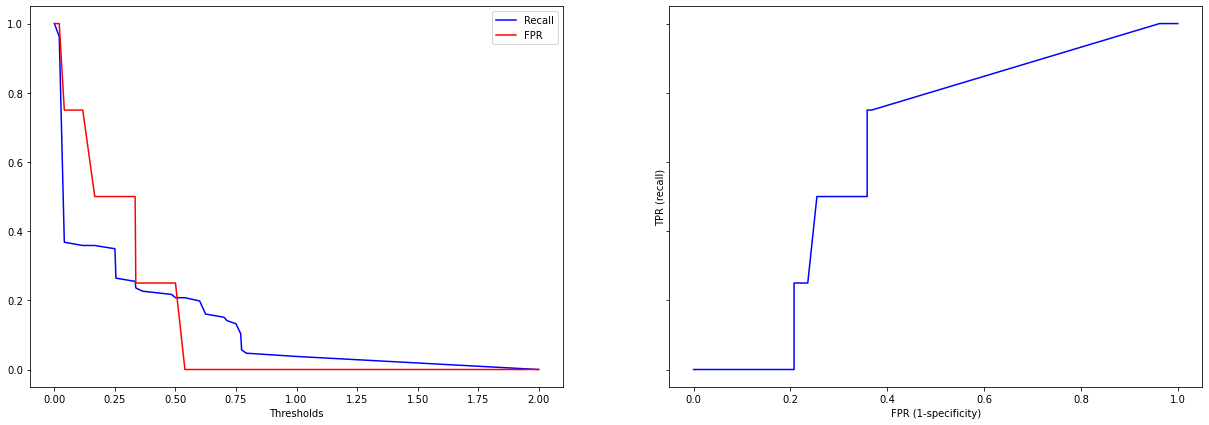

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.698206  0.487499   0.842685     0.908871  0.617551  0.742407
Validation  0.633497  0.435495   0.725723     0.831818  0.541834  0.660488

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004580  0.011376   0.010301     0.008151  0.008401  0.003329
Validation  0.027762  0.054946   0.058257     0.049283  0.044370  0.033379

Logistic Regression
╠■■■■■■■■■╣


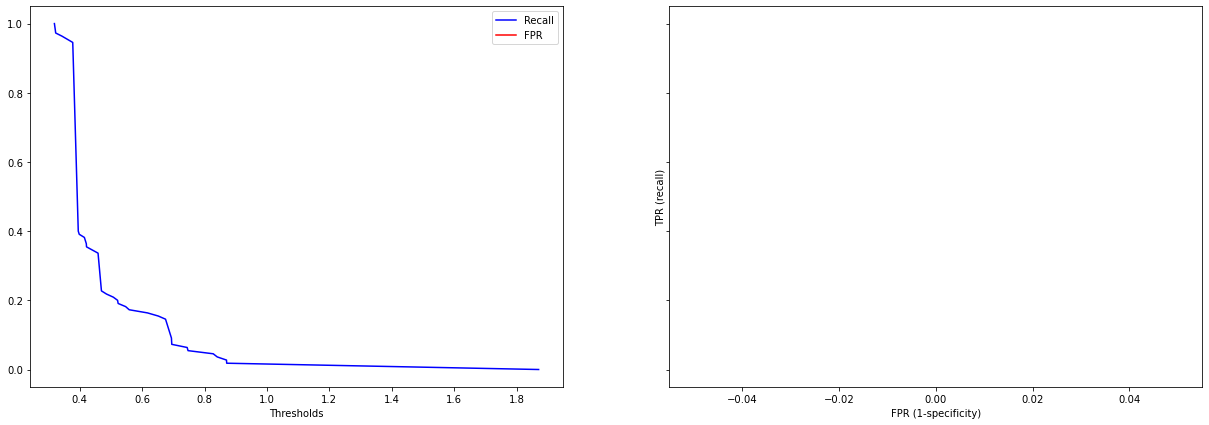

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663928  0.497478   0.747583     0.830343  0.596555  0.691492
Validation  0.658034  0.494545   0.738870     0.821818  0.589278  0.689842

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009450  0.025611   0.027655     0.035137  0.012375  0.009428
Validation  0.029559  0.072779   0.050663     0.056073  0.048279  0.032735

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499548  0.000000   0.000000     1.000000   
MultinomialNB                   0.622624  0.336691   0.789734     0.909091   
Random Forest (100 estimators)  0.643494  0.464595   0.725624     0.822727   
XGBoost Classifier              0.658032  0.457330   0.764739     0.859091   
SVM                             0.653026  0.466429   0.744928     0.840000   
KNN                             0.633497  0.435495   0.725723     0.831818   
Logistic Regression             0.658034  0.494545   0.738870     0.821818   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.470685  0.601234  
Random Forest (100 estimators)  0.565681  0.660470  
XGBoost Classifier              0.571409  0.673433  
SVM                             0.572110  0.683573  
KNN                             0.541834  0.660488  
Logistic Regression             0.589278  0.689842

Accuracy  \
Dummy Random                    0.4989441930618401-0.5001508295625943   
MultinomialNB                   0.6130695598968654-0.6321793088814154   
Random Forest (100 estimators)  0.6286501181612423-0.6583387752982393   
XGBoost Classifier              0.6388456481378924-0.6772177002783974   
SVM                             0.6370601784117551-0.6689908294039588   
KNN                               0.615937958791073-0.651055048201934   
Logistic Regression             0.6393390063932813-0.6767284555565336   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.31314936716992026-0.3602331062125531   
Random Forest (100 estimators)  0.4429913593620032-0.48619782982718596   
XGBoost Classifier              0.42604526470124937-0.4886148499588654   
SVM                               0.431187923924034-0.5016703889342787   
KNN                              0.4007444141056954-0.4702465768852955   
Logistic Regression              0.4485159880320584-0.5405749210588506   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.7688903669545847-0.8105777633710701   
Random Forest (100 estimators)   0.698624565382314-0.7526226821468014   
XGBoost Classifier              0.7365681139158664-0.7929105320463921   
SVM                             0.7239109407776115-0.7659448203857427   
KNN                             0.6888778688250721-0.7625679344684222   
Logistic Regression             0.7068283308135099-0.7709119622709091   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8952706009078891-0.9229112172739288   
Random Forest (100 estimators)  0.8001723708291776-0.8452821746253677   
XGBoost Classifier                0.840460089516437-0.877721728665381   
SVM                              0.8230303030303031-0.856969696969697   
KNN                             0.8006487494045483-0.8629876142318152   
Logistic Regression              0.7863545725131448-0.857281791123219   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.44832726842568876-0.493042544665565   
Random Forest (100 estimators)   0.5457319035819371-0.585629403996872   
XGBoost Classifier              0.5422407435710443-0.6005767302015321   
SVM                              0.5430650614954186-0.601154564622094   
KNN                             0.5137725119695499-0.5698961573996769   
Logistic Regression             0.5587435452039219-0.6198124365692675   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                    0.5805909510581737-0.621877219591815  
Random Forest (100 estimators)  0.6341229707427739-0.6868173911066787  
XGBoost Classifier              0.6518061489670248-0.6950600560809983  
SVM                             0.6691854653533287-0.6979599445193541  
KNN                             0.6393766690989476-0.6815987608764825  
Logistic Regression             0.6691383738993792-0.7105451195113868

In [187]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently keeping both the boolean and the graded yields better performance for every algorithm, except for <b>XGBoost</b> which improves when we just leave the boolean value.

Dummy Random
╠■■■■■■■■■╣


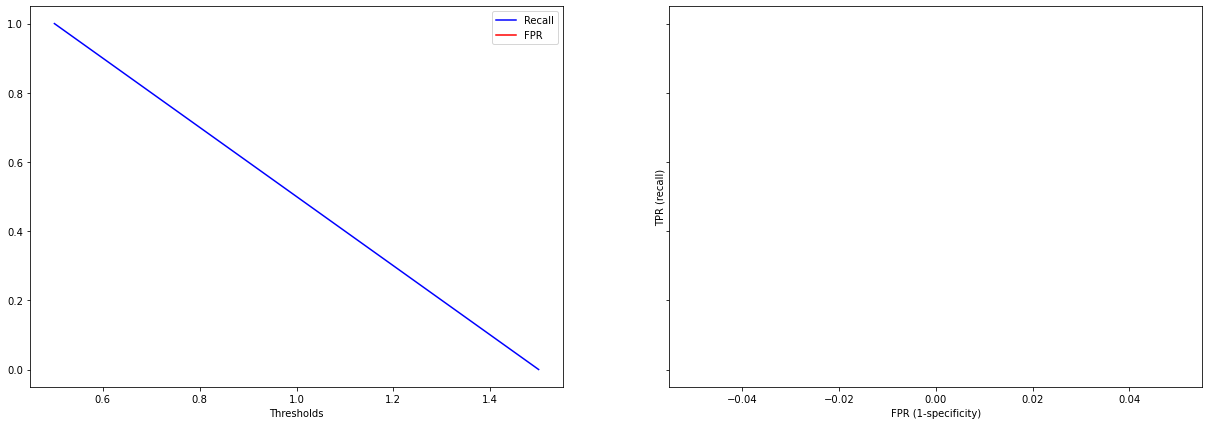

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500129     0.0        0.0          1.0  0.0      0.5
Validation  0.498837     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000136     0.0        0.0          0.0  0.0      0.0
Validation  0.001226     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


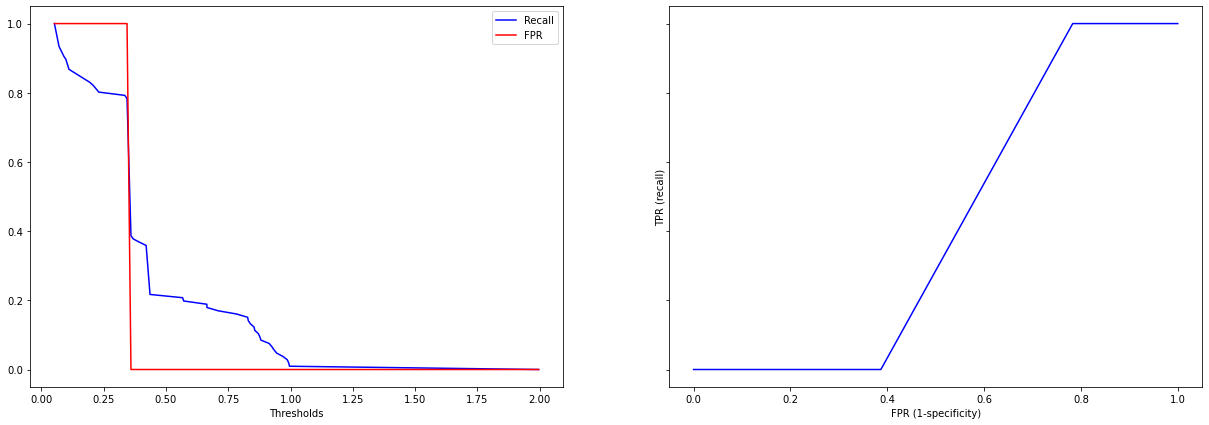

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.656109  0.519173   0.714994     0.792975  0.601508  0.687856
Validation  0.652150  0.508705   0.716520     0.796262  0.593689  0.690100

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007179  0.004626   0.012966     0.012785  0.006313  0.007169
Validation  0.037446  0.053145   0.059713     0.051151  0.049758  0.035603

Random Forest (100 estimators)
╠■■■■■■■■■╣


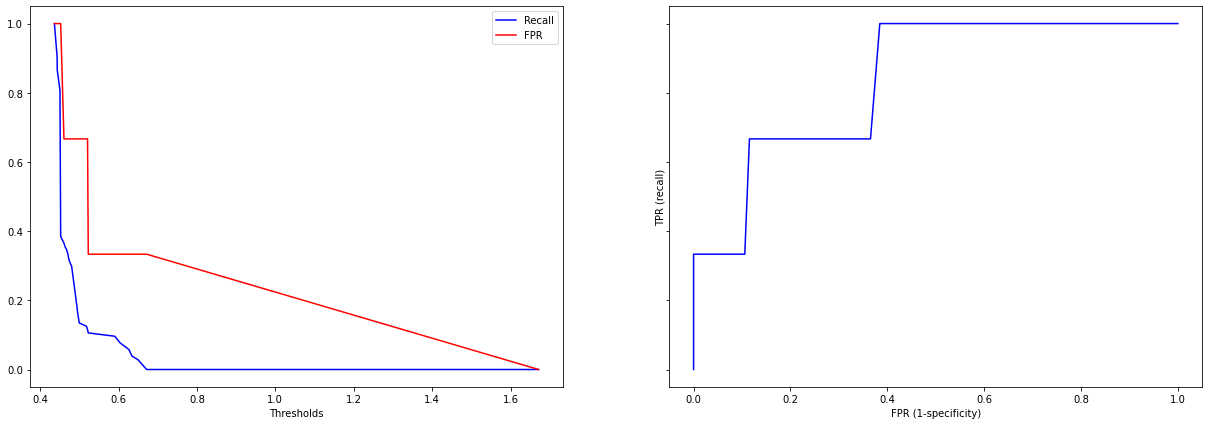

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.637923  0.458708   0.715063     0.817045  0.558698  0.678494
Validation  0.630735  0.449213   0.707749     0.813084  0.548808  0.670839

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006852  0.014863   0.013562     0.014384  0.011125  0.006559
Validation  0.027764  0.041528   0.045932     0.035245  0.040039  0.030311

XGBoost Classifier
╠■■■■■■■■■╣


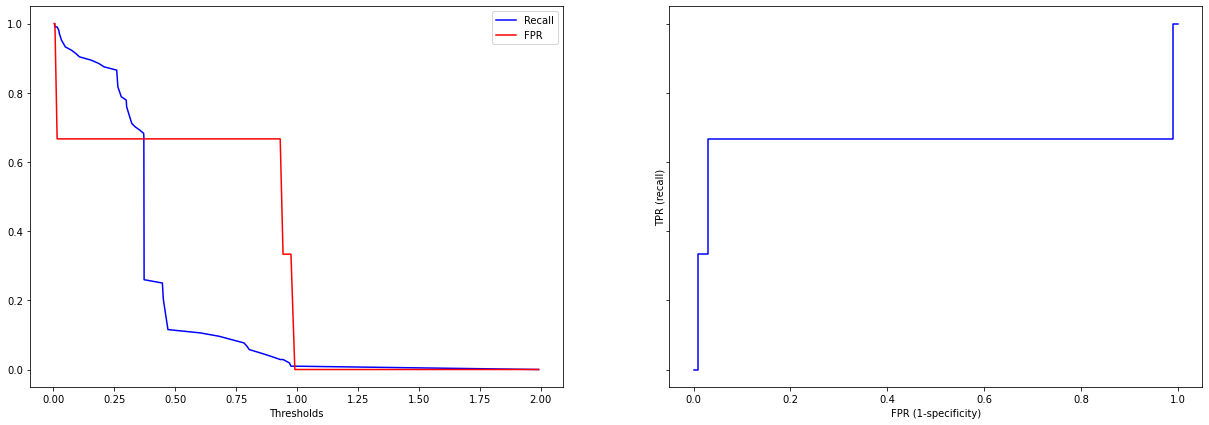

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.768070  0.593386   0.911946     0.942665  0.718910  0.845493
Validation  0.651732  0.492965   0.725900     0.811215  0.585992  0.681105

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003541  0.007409   0.008158     0.006087  0.005103  0.002677
Validation  0.029193  0.043825   0.049824     0.042896  0.038586  0.033889

SVM
╠■■■■■■■■■╣


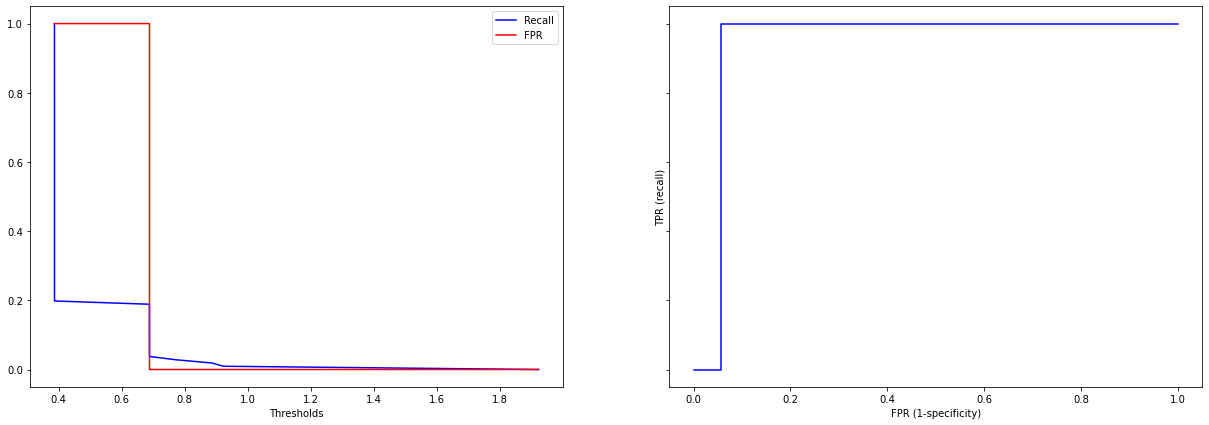

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.666132  0.480512   0.764120     0.851653  0.58972  0.707974
Validation  0.659176  0.470639   0.757776     0.848598  0.57936  0.701514

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007949  0.021360   0.008349     0.009875  0.016786  0.009126
Validation  0.038356  0.058197   0.060604     0.040089  0.055861  0.034148

KNN
╠■■■■■■■■■╣


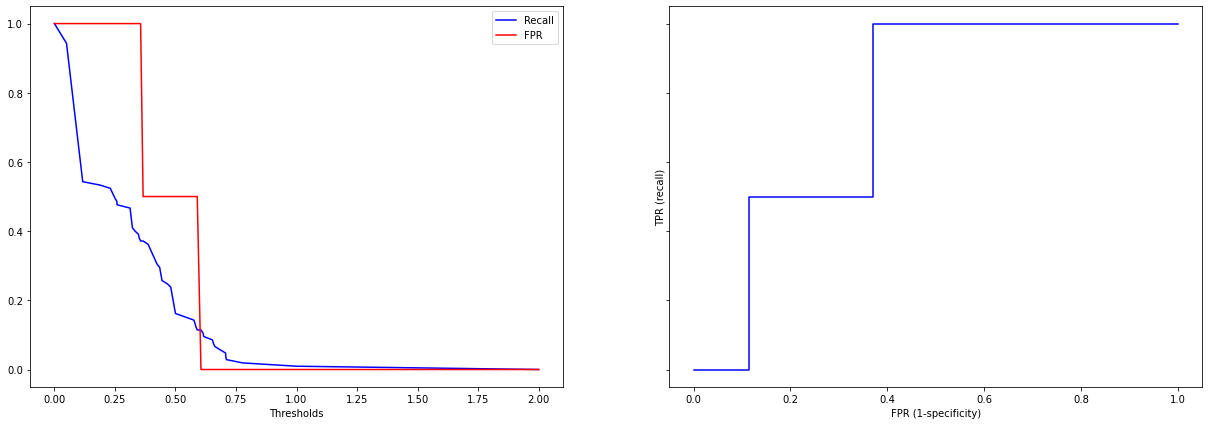

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.770602  0.576743   0.941883     0.964360  0.715344  0.828893
Validation  0.641006  0.485488   0.707546     0.797196  0.574707  0.654697

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003681  0.009446   0.007211     0.004996  0.006404  0.007493
Validation  0.021549  0.042365   0.034651     0.036343  0.033418  0.030336

Logistic Regression
╠■■■■■■■■■╣


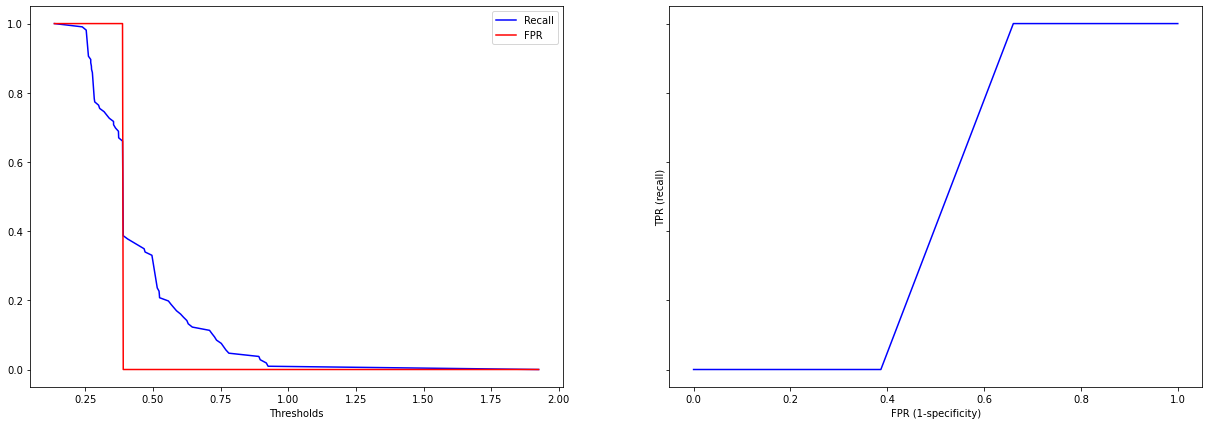

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669697  0.513891   0.748412     0.825413  0.608210  0.712482
Validation  0.666173  0.510678   0.744830     0.822430  0.604603  0.708486

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007686  0.032838   0.026165     0.036299  0.015783  0.008465
Validation  0.028263  0.045542   0.048700     0.043391  0.038441  0.032715

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498837  0.000000   0.000000     1.000000   
MultinomialNB                   0.652150  0.508705   0.716520     0.796262   
Random Forest (100 estimators)  0.630735  0.449213   0.707749     0.813084   
XGBoost Classifier              0.651732  0.492965   0.725900     0.811215   
SVM                             0.659176  0.470639   0.757776     0.848598   
KNN                             0.641006  0.485488   0.707546     0.797196   
Logistic Regression             0.666173  0.510678   0.744830     0.822430   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.593689  0.690100  
Random Forest (100 estimators)  0.548808  0.670839  
XGBoost Classifier              0.585992  0.681105  
SVM                             0.579360  0.701514  
KNN                             0.574707  0.654697  
Logistic Regression             0.604603  0.708486

Accuracy  \
Dummy Random                    0.49806201550387597-0.49961240310077515   
MultinomialNB                     0.6284664217622321-0.6758326436583285   
Random Forest (100 estimators)    0.6131753615752662-0.6482938842408608   
XGBoost Classifier                0.6332689529711788-0.6701955112757241   
SVM                               0.6349175128563151-0.6834350192019332   
KNN                                0.627377677115769-0.6546349288394581   
Logistic Regression                0.648297752763807-0.6840473895965495   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.47509375880250604-0.5423171100102319   
Random Forest (100 estimators)  0.42294781673320936-0.4754772438413841   
XGBoost Classifier                0.4652475020383675-0.520681885292889   
SVM                              0.43383169206527517-0.507445566501703   
KNN                             0.45869383381706785-0.5122822824861513   
Logistic Regression             0.48187508262776413-0.5394817882618171   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6787535311738662-0.7542857335875353   
Random Forest (100 estimators)  0.6786988286655095-0.7367990036431996   
XGBoost Classifier              0.6943886835524599-0.7574116229515547   
SVM                              0.7194468058397986-0.796105091846642   
KNN                              0.6856304726693567-0.729460611904178   
Logistic Regression             0.7140290557983511-0.7756300174016835   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7639108910012532-0.8286124734847281   
Random Forest (100 estimators)  0.7907930918130863-0.8353751324859793   
XGBoost Classifier              0.7840853070939847-0.8383445994480713   
SVM                             0.8232436262313074-0.8739526354509357   
KNN                             0.7742107579492877-0.8201817654151985   
Logistic Regression             0.7949872703482301-0.8498725427358818   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.562218989364545-0.6251590450554451   
Random Forest (100 estimators)  0.5234856030927637-0.5741311990811944   
XGBoost Classifier              0.5615884649734403-0.6103957163424648   
SVM                              0.5440307665669165-0.614689962479707   
KNN                             0.5535719024681206-0.5958426042085859   
Logistic Regression             0.5802911195597525-0.6289154850071564   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                    0.6675821809547167-0.712617043949286  
Random Forest (100 estimators)  0.6516684766725888-0.6900092697260939  
XGBoost Classifier              0.6596724057598583-0.7025385911572265  
SVM                             0.6799165735110535-0.7231109430438452  
KNN                              0.6355105351557261-0.673883217492896  
Logistic Regression              0.687795057780517-0.7291761802056569

In [188]:
#ra_symptoms
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently, all features in <b>reported_symptoms</b> are more important than the assesed ones. <b>days_since_symptom_onset</b> seems to have some importance. Performance improves slightly for all of them except for <b>SVM</b> and <b>Logistic Regression</b>. Logistic Regression improves with a slightly lower threshold (.4 for higher recall and .44 for higher specificity). SVM improves also with a lower threshold(.47)

Dummy Random
╠■■■■■■■■■╣


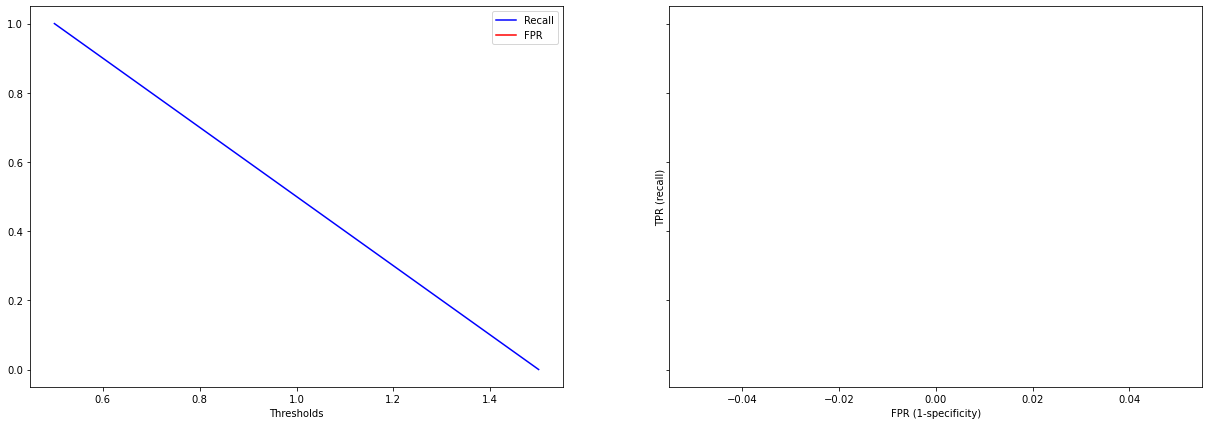

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500050     0.0        0.0          1.0  0.0      0.5
Validation  0.499548     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000106     0.0        0.0          0.0  0.0      0.0
Validation  0.000954     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


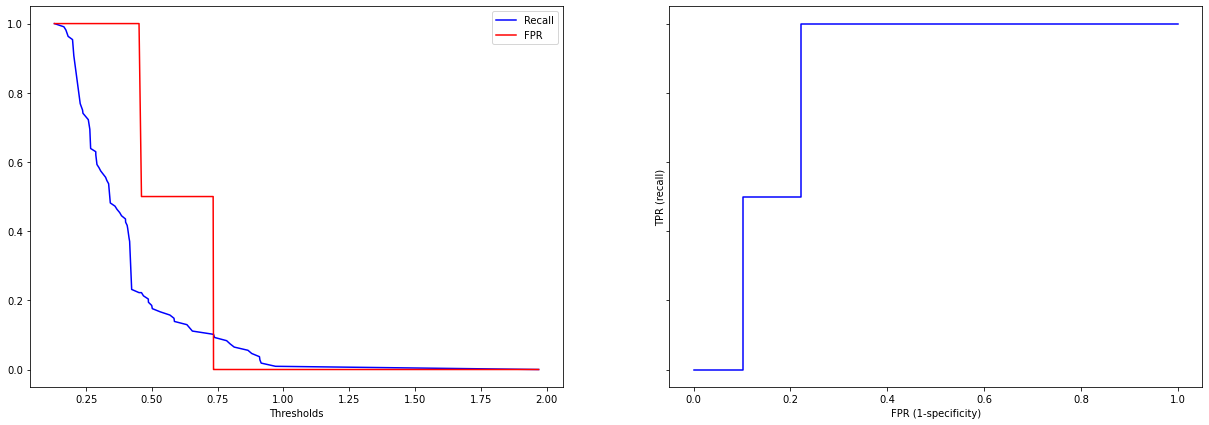

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.657072  0.493345   0.733493     0.820766  0.589903  0.686124
Validation  0.649410  0.489099   0.720773     0.810000  0.582338  0.678737

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003735  0.004847   0.006082     0.004979  0.004704  0.005945
Validation  0.039131  0.046253   0.057798     0.041205  0.049464  0.033285

Random Forest (100 estimators)
╠■■■■■■■■■╣


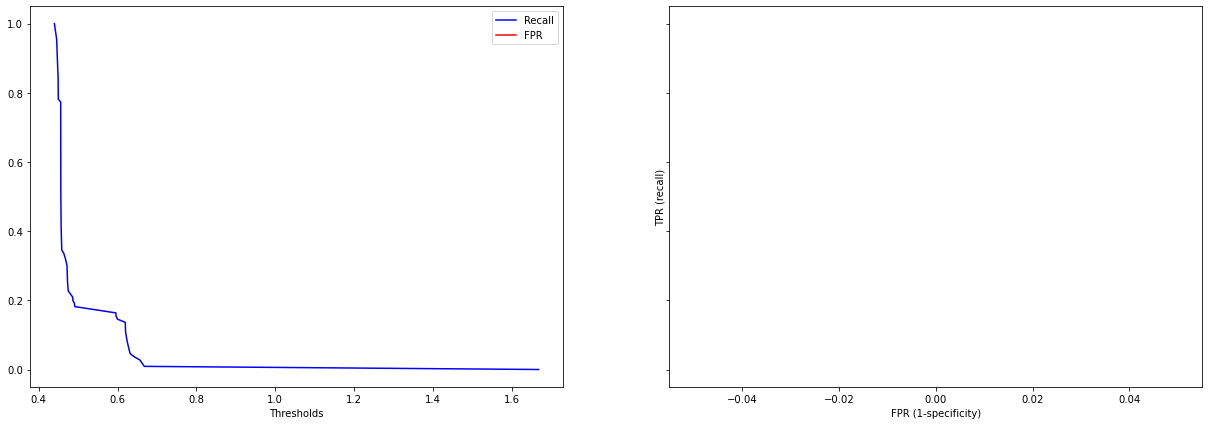

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.634086  0.429926   0.727580     0.838206  0.540009  0.677515
Validation  0.634428  0.433751   0.725992     0.835455  0.542598  0.664839

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004622  0.017497   0.019598     0.021417  0.009963  0.005576
Validation  0.025465  0.032722   0.043402     0.030439  0.034121  0.026063

XGBoost Classifier
╠■■■■■■■■■╣


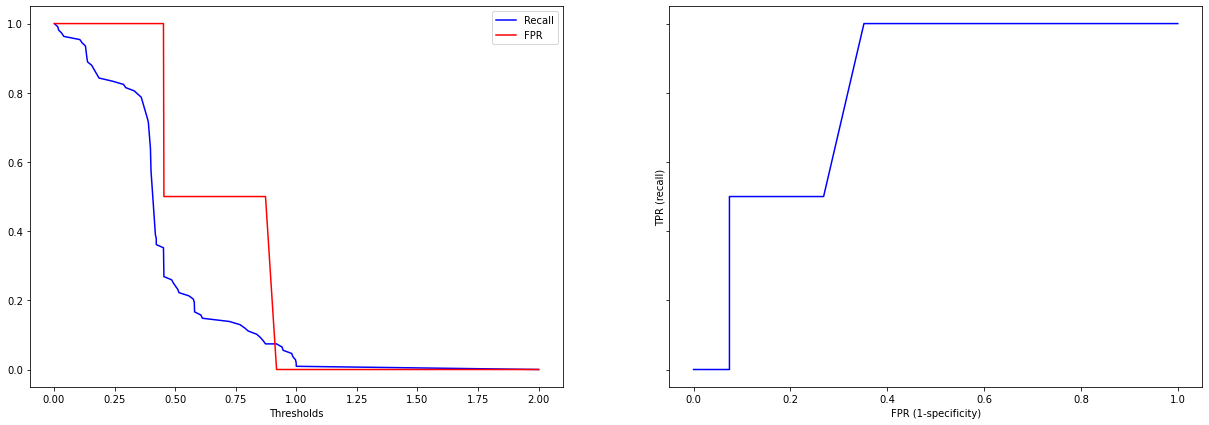

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.751890  0.570476   0.895575     0.933266  0.696830  0.836060
Validation  0.633523  0.453718   0.709696     0.813636  0.551948  0.638359

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002638  0.011249   0.011886     0.009549  0.005667  0.003706
Validation  0.032078  0.057488   0.046724     0.035404  0.050776  0.038884

SVM
╠■■■■■■■■■╣


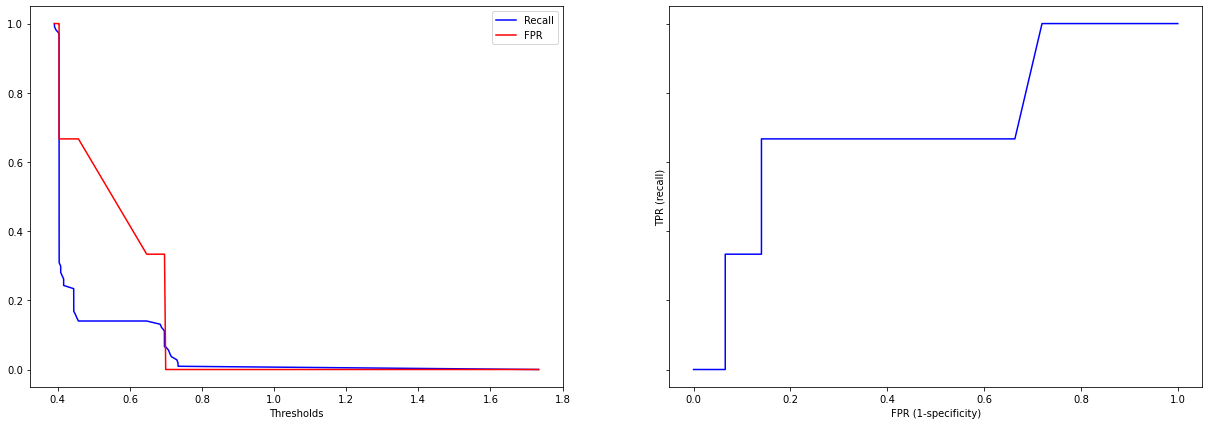

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.647999  0.448174   0.747124     0.847782  0.559529  0.689791
Validation  0.649414  0.437371   0.764078     0.861818  0.553528  0.691502

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.011176  0.031044   0.019744     0.019885  0.023611  0.013972
Validation  0.029912  0.060341   0.061624     0.041945  0.049343  0.040589

KNN
╠■■■■■■■■■╣


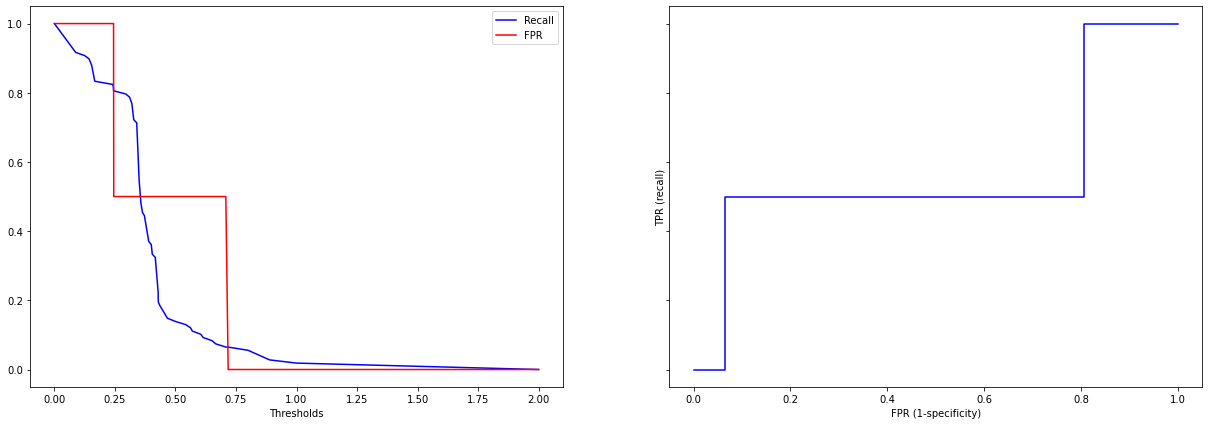

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.752545  0.550209   0.925427     0.954839  0.68954  0.809660
Validation  0.621242  0.407387   0.711708     0.835455  0.51618  0.639721

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004498  0.021887   0.023025     0.017931  0.011013  0.010855
Validation  0.031391  0.064316   0.042390     0.030136  0.058793  0.032021

Logistic Regression
╠■■■■■■■■■╣


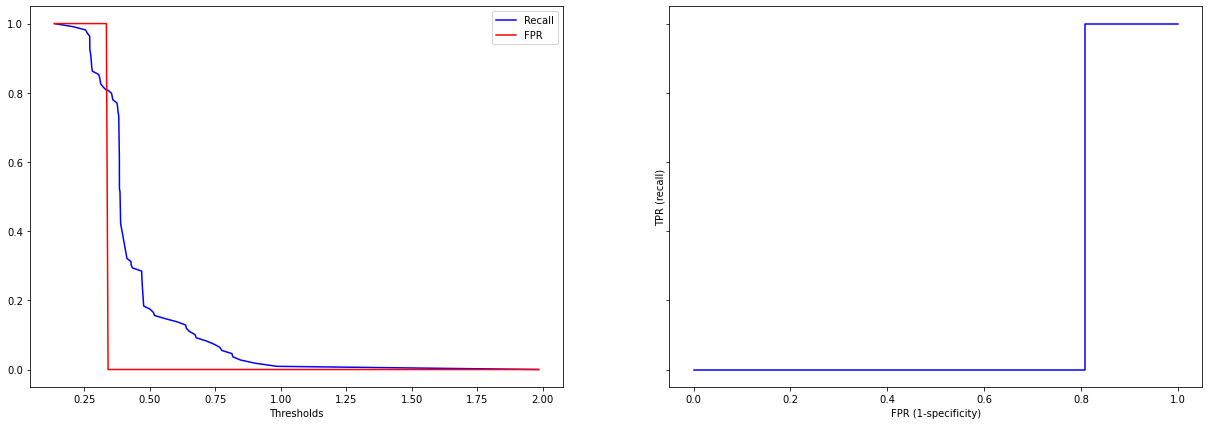

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661256  0.505543   0.735984     0.816935  0.598468  0.703688
Validation  0.657563  0.495446   0.734433     0.820000  0.590282  0.700548

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008437  0.027195   0.026179     0.035320  0.012558  0.009075
Validation  0.032945  0.057323   0.048271     0.040384  0.049359  0.033847

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499548  0.000000   0.000000     1.000000   
MultinomialNB                   0.649410  0.489099   0.720773     0.810000   
Random Forest (100 estimators)  0.634428  0.433751   0.725992     0.835455   
XGBoost Classifier              0.633523  0.453718   0.709696     0.813636   
SVM                             0.649414  0.437371   0.764078     0.861818   
KNN                             0.621242  0.407387   0.711708     0.835455   
Logistic Regression             0.657563  0.495446   0.734433     0.820000   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.582338  0.678737  
Random Forest (100 estimators)  0.542598  0.664839  
XGBoost Classifier              0.551948  0.638359  
SVM                             0.553528  0.691502  
KNN                             0.516180  0.639721  
Logistic Regression             0.590282  0.700548

Accuracy  \
Dummy Random                    0.4989441930618401-0.5001508295625943   
MultinomialNB                   0.6246610121572362-0.6741584037210031   
Random Forest (100 estimators)  0.6183226223072024-0.6505338153727648   
XGBoost Classifier              0.6132355863615284-0.6538108965673075   
SVM                               0.63049604970056-0.6683315932447301   
KNN                             0.6013886302714623-0.6410959439778178   
Logistic Regression             0.6367267882095525-0.6783986745629692   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4598464458257464-0.5183517523724518   
Random Forest (100 estimators)    0.413055911101334-0.4544461364007134   
XGBoost Classifier              0.41735939533414457-0.4900771321023828   
SVM                               0.399207756004311-0.4755342587377037   
KNN                              0.3667101942702115-0.4480645805045634   
Logistic Regression             0.45919204911396866-0.5317006617787422   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6842181495845172-0.7573279338711298   
Random Forest (100 estimators)  0.6985422790558694-0.7534424511599286   
XGBoost Classifier              0.6801450378923202-0.7392465729299247   
SVM                             0.7251039402827606-0.8030529474835346   
KNN                             0.6848982278393538-0.7385184163089789   
Logistic Regression             0.7039032652998591-0.7649619993487848   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                    0.7839393939393939-0.836060606060606   
Random Forest (100 estimators)  0.8162031755463413-0.8547059153627499   
XGBoost Classifier              0.7912449052098047-0.8360278220629227   
SVM                             0.8352896137839523-0.8883467498524111   
KNN                              0.8163949270381621-0.854514163870929   
Logistic Regression             0.7944590212052055-0.8455409787947946   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5510538120156485-0.6136212834280881   
Random Forest (100 estimators)   0.5210174037032383-0.5641776700478879   
XGBoost Classifier               0.5198345111861745-0.5840620855885149   
SVM                              0.5223208743825235-0.5847357918992148   
KNN                             0.47899579440644846-0.5533636980638197   
Logistic Regression              0.5590645243036902-0.6214997194343963   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6576860025598495-0.6997887200966914  
Random Forest (100 estimators)  0.6483548810339472-0.6813222092795068  
XGBoost Classifier               0.6137663476365431-0.662950799262422  
SVM                             0.6658313328953388-0.7171723153810369  
KNN                              0.619468792685192-0.6599723509377698  
Logistic Regression             0.6791408031437975-0.7219548710427857

In [189]:
#r_symptoms_ex
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Epidemiological factors proves themselves to be slightly more important that some of the of the reported symptoms. <b>high_risk_exposure_occupation</b> once again proves to be a highly determinant feature. It also improves performance in all other models, while reducing specificity by a small amount (with the exception of <b>KNN</b>).

Dummy Random
╠■■■■■■■■■╣


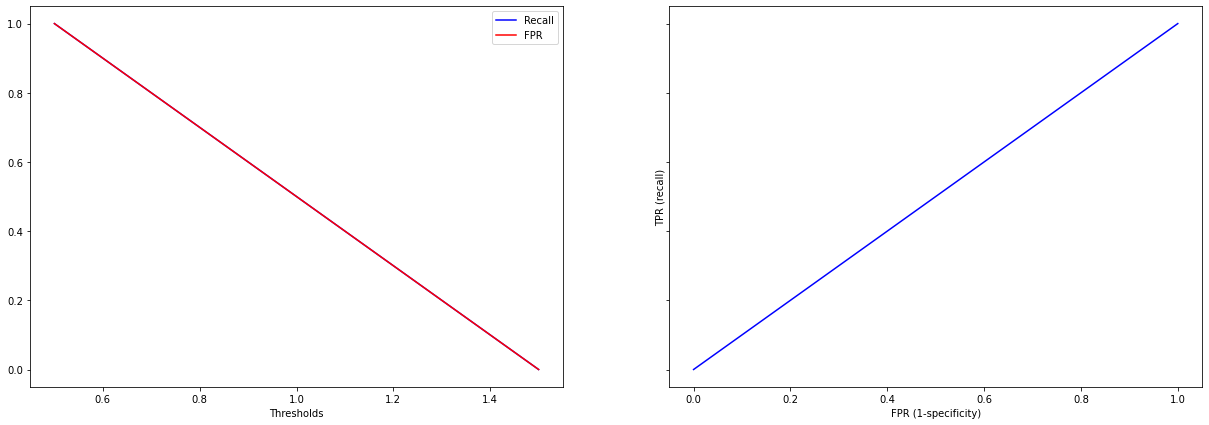

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500225     0.0        0.0          1.0  0.0      0.5
Validation  0.497970     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000119     0.0        0.0          0.0  0.0      0.0
Validation  0.001070     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


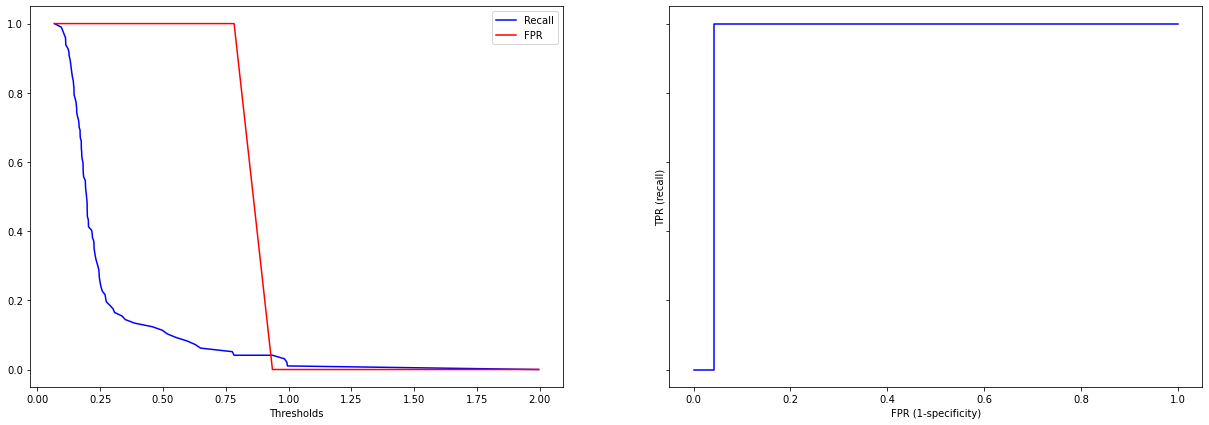

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660353  0.508885   0.730093     0.811685  0.599661  0.706531
Validation  0.663636  0.504061   0.742398     0.824490  0.599943  0.706603

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009544  0.005916   0.018439     0.017287  0.008326  0.008276
Validation  0.041703  0.055026   0.056685     0.036886  0.056093  0.044217

Random Forest (100 estimators)
╠■■■■■■■■■╣


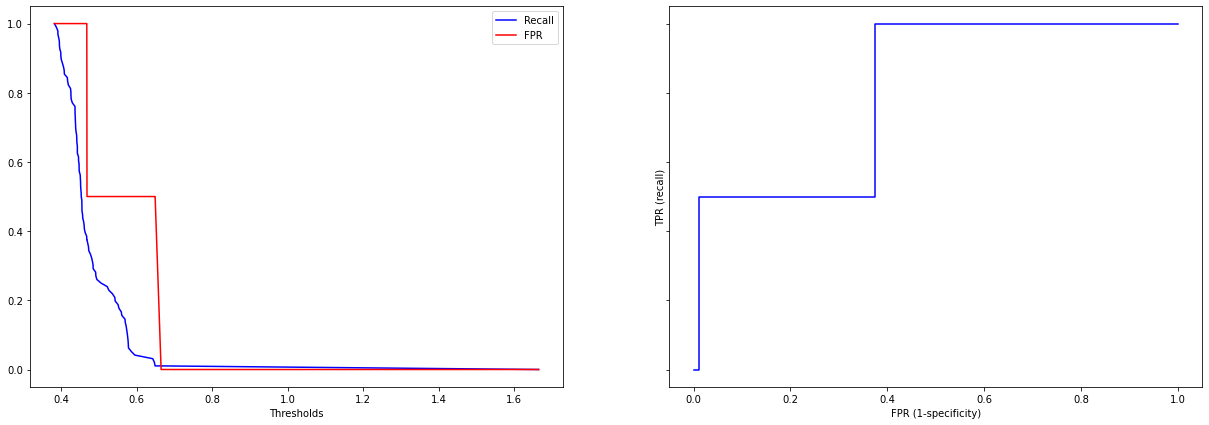

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663501  0.523843   0.727042     0.803034  0.608609  0.721373
Validation  0.656016  0.513193   0.723039     0.800000  0.598403  0.696318

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004686  0.018977   0.012319     0.018257  0.010114  0.006297
Validation  0.032752  0.058974   0.048455     0.048390  0.047153  0.032818

XGBoost Classifier
╠■■■■■■■■■╣


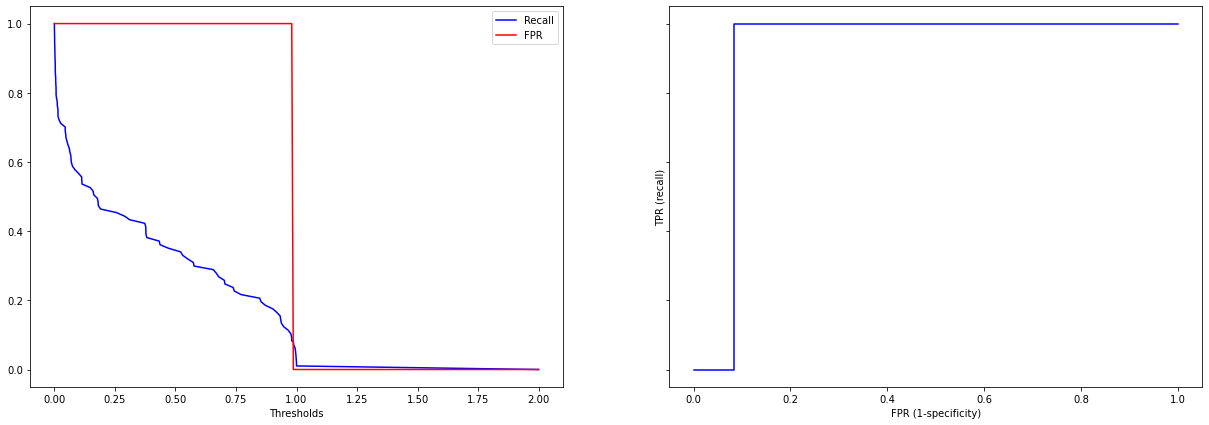

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999438  0.999325   0.999551     0.999551  0.999437  0.999998
Validation  0.615832  0.589043   0.624559     0.642857  0.605314  0.669887

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000593  0.000949   0.000785     0.000786  0.000593  0.000003
Validation  0.031173  0.056244   0.032229     0.043823  0.039762  0.028606

SVM
╠■■■■■■■■■╣


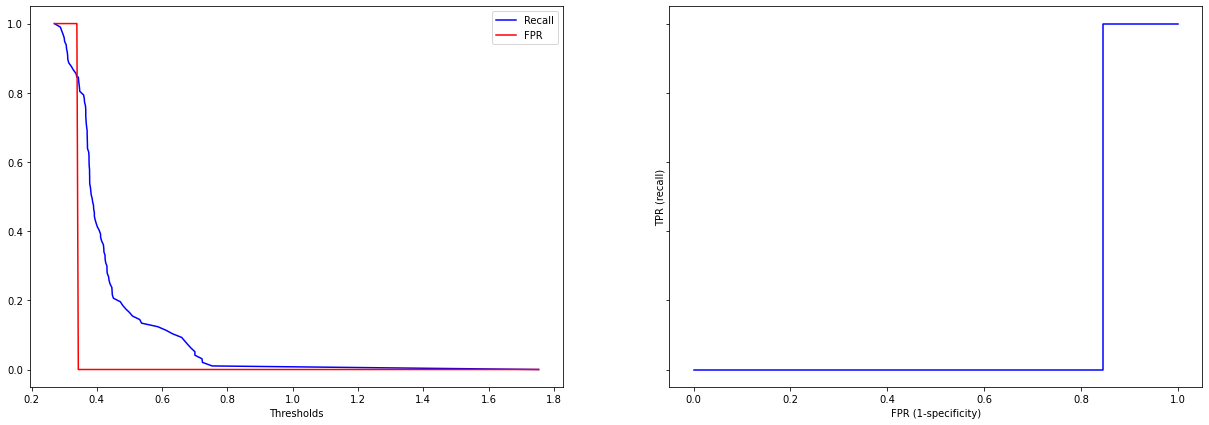

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667547  0.470873   0.776259     0.864045  0.585969  0.740807
Validation  0.652453  0.472665   0.740708     0.833673  0.575324  0.715540

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007566  0.014048   0.017494     0.015479  0.010865  0.007552
Validation  0.034123  0.066081   0.045384     0.031561  0.056336  0.029266

KNN
╠■■■■■■■■■╣


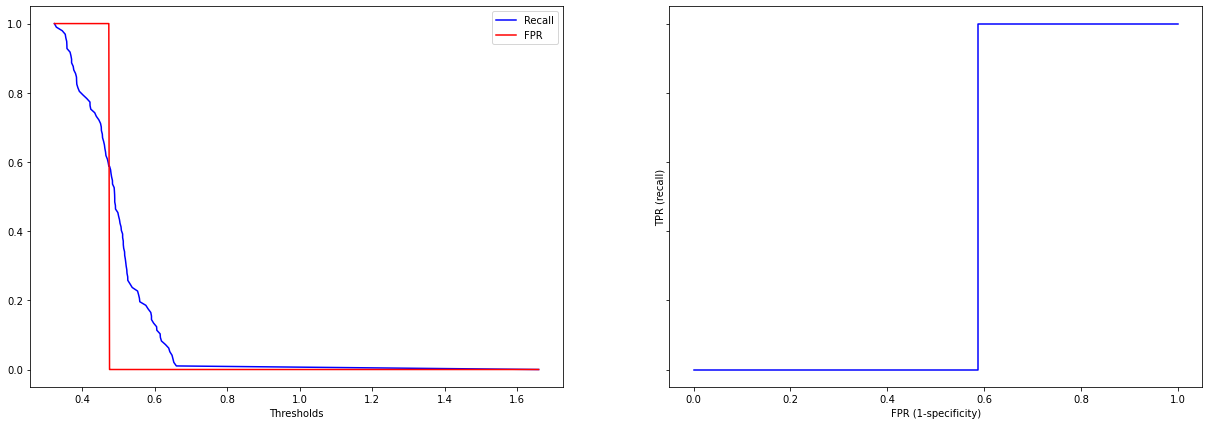

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.999775  0.999550   1.000000     1.000000  0.999775  1.00000
Validation  0.581785  0.491857   0.603744     0.672449  0.539804  0.62737

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000393  0.000786   0.000000     0.000000  0.000394  7.993274e-07
Validation  0.031494  0.064943   0.041716     0.063534  0.046454  3.004531e-02

Logistic Regression
╠■■■■■■■■■╣


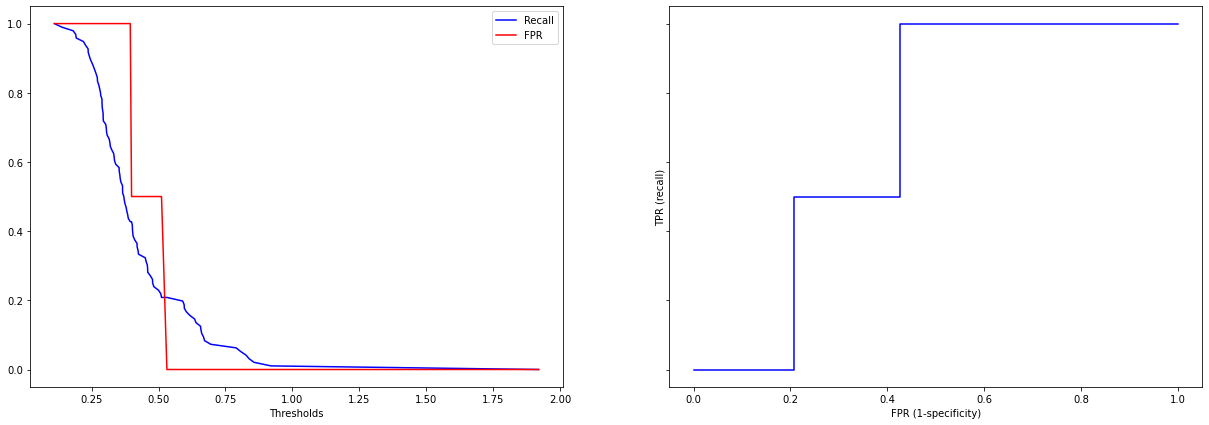

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673225  0.552069   0.729120     0.794270  0.627988  0.729575
Validation  0.676323  0.550639   0.736618     0.803061  0.628907  0.721963

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006834  0.016913   0.019024     0.023542  0.007915  0.005297
Validation  0.033644  0.066272   0.030710     0.020436  0.054323  0.037145

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497970  0.000000   0.000000     1.000000   
MultinomialNB                   0.663636  0.504061   0.742398     0.824490   
Random Forest (100 estimators)  0.656016  0.513193   0.723039     0.800000   
XGBoost Classifier              0.615832  0.589043   0.624559     0.642857   
SVM                             0.652453  0.472665   0.740708     0.833673   
KNN                             0.581785  0.491857   0.603744     0.672449   
Logistic Regression             0.676323  0.550639   0.736618     0.803061   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.599943  0.706603  
Random Forest (100 estimators)  0.598403  0.696318  
XGBoost Classifier              0.605314  0.669887  
SVM                             0.575324  0.715540  
KNN                             0.539804  0.627370  
Logistic Regression             0.628907  0.721963

Accuracy  \
Dummy Random                    0.49729272419627746-0.49864636209813873   
MultinomialNB                     0.6372601690179359-0.6900111455992818   
Random Forest (100 estimators)    0.6353020763981613-0.6767304523493783   
XGBoost Classifier                0.5961166424724524-0.6355470890099881   
SVM                               0.6308710131661613-0.6740341976491294   
KNN                               0.5618668208130317-0.6017040897847099   
Logistic Regression               0.6550448843849155-0.6976019611553312   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.46925974910364665-0.5388622875898185   
Random Forest (100 estimators)   0.4758946272229903-0.5504916848776074   
XGBoost Classifier               0.5534714818651543-0.6246155105075524   
SVM                               0.430872290668923-0.5144585689476509   
KNN                              0.4507834966746223-0.5329312013257897   
Logistic Regression              0.5087247736914096-0.5925533133009631   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.7065471826919919-0.7782481082233547   
Random Forest (100 estimators)   0.692393304556653-0.7536850020118837   
XGBoost Classifier              0.6041759471812497-0.6449428784776824   
SVM                             0.7120045398973363-0.7694106883782423   
KNN                             0.5773609748668707-0.6301275197701453   
Logistic Regression             0.7171951275638101-0.7560401697877425   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8011613221775751-0.8478182696591594   
Random Forest (100 estimators)  0.7693953146144163-0.8306046853855837   
XGBoost Classifier              0.6151407499490295-0.6705735357652564   
SVM                             0.8137123799304473-0.8536345588450629   
KNN                             0.6322668314949053-0.7126311276887684   
Logistic Regression             0.7901360544217687-0.8159863945578231   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5644665627408905-0.6354197565985946   
Random Forest (100 estimators)  0.5685806579991781-0.6282255407557917   
XGBoost Classifier              0.5801663263854078-0.6304618137150055   
SVM                             0.5396939092488486-0.6109533121956094   
KNN                             0.5104238533555665-0.5691841228807948   
Logistic Regression             0.5945505077315515-0.6632638262856704   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6786378840245375-0.7345681033797005  
Random Forest (100 estimators)  0.6755617388657996-0.7170736950232784  
XGBoost Classifier              0.6517947049009791-0.6879791267095869  
SVM                             0.6970305967292674-0.7340489408371507  
KNN                             0.6083676887009054-0.6463723396542834  
Logistic Regression             0.6984704442289872-0.7454559080064028

In [190]:
#r_symptoms_vitals
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


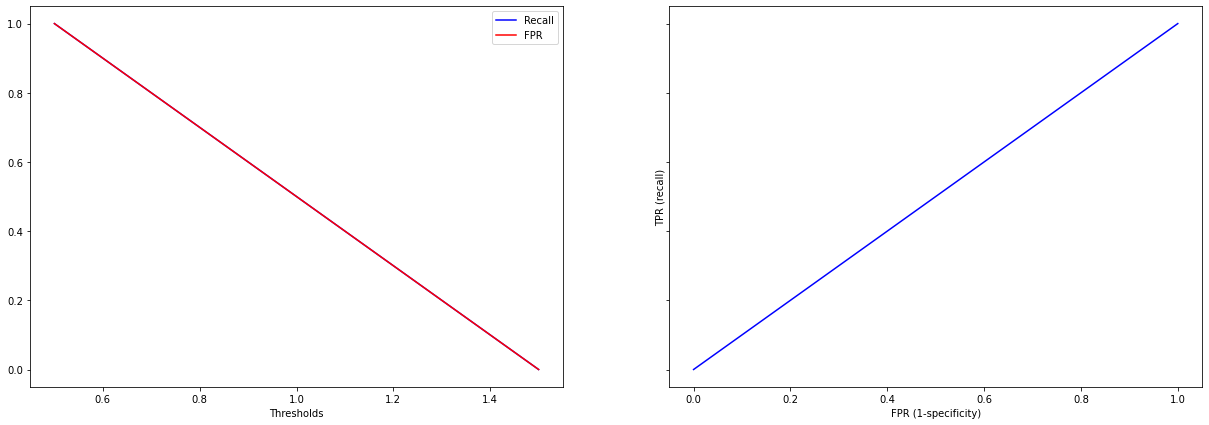

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500225     0.0        0.0          1.0  0.0      0.5
Validation  0.497970     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000119     0.0        0.0          0.0  0.0      0.0
Validation  0.001070     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


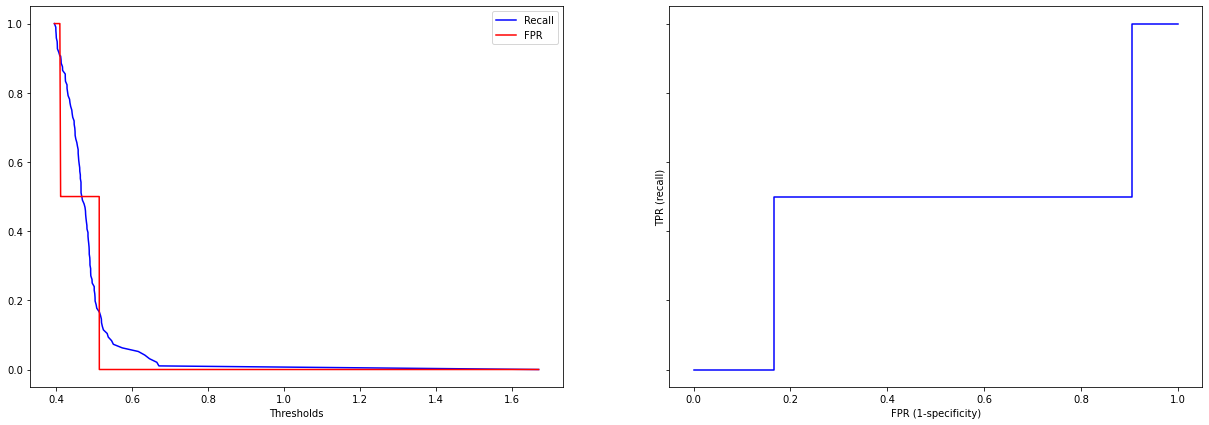

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659229  0.521484   0.719559     0.796854  0.604555  0.716630
Validation  0.653960  0.513142   0.717505     0.795918  0.597521  0.704902

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006529  0.017013   0.008156     0.010604  0.011753  0.008536
Validation  0.030169  0.046766   0.040421     0.035674  0.040877  0.033558

XGBoost Classifier
╠■■■■■■■■■╣


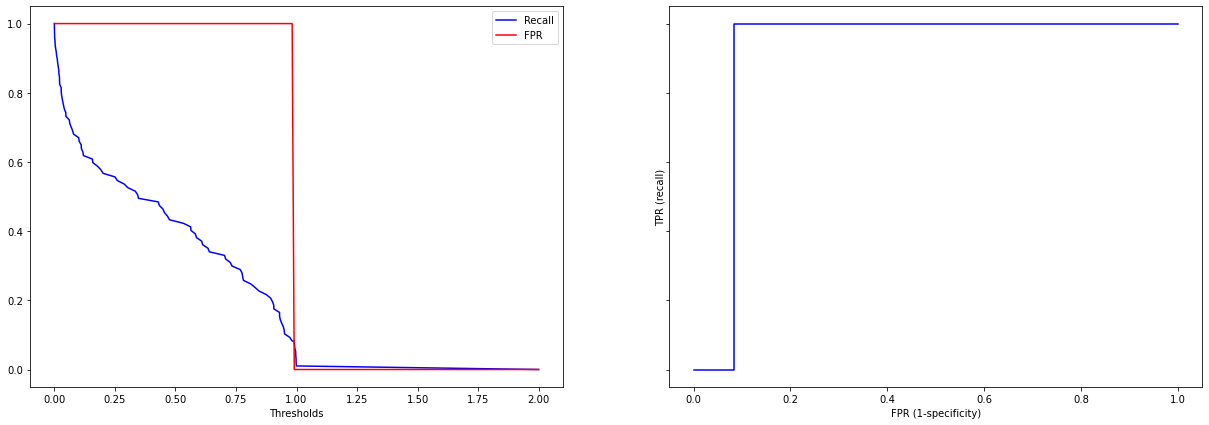

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999944  0.999888   1.000000     1.000000  0.999944  1.000000
Validation  0.615353  0.603257   0.620392     0.627551  0.611028  0.673286

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000178  0.000356    0.00000     0.000000  0.000178  1.998381e-07
Validation  0.039844  0.055633    0.04106     0.048163  0.044012  4.133002e-02

SVM
╠■■■■■■■■■╣


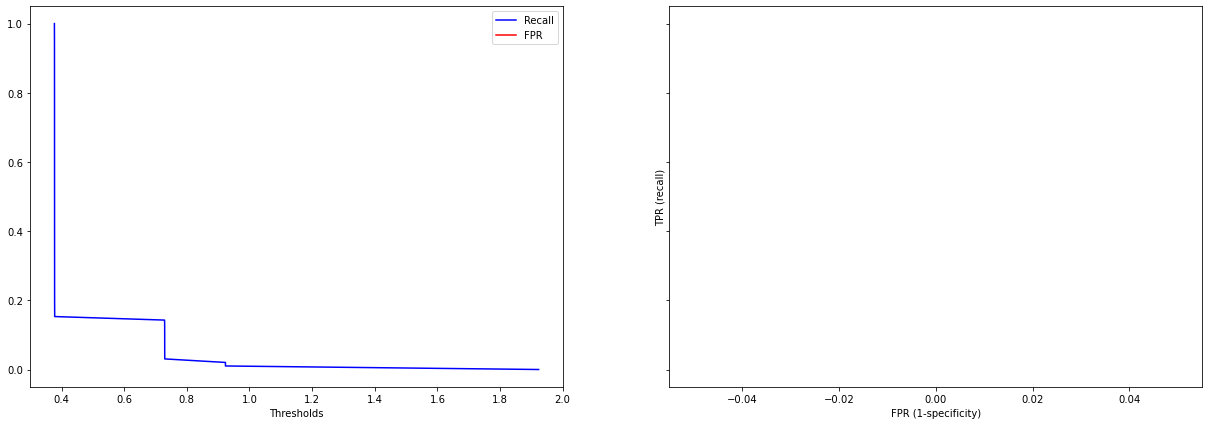

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665073  0.477727   0.763764     0.852247  0.587635  0.738506
Validation  0.668204  0.472707   0.779595     0.865306  0.586880  0.731036

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007340  0.015776   0.011782     0.010636  0.012466  0.007813
Validation  0.024908  0.055855   0.024946     0.022459  0.047838  0.021228

KNN
╠■■■■■■■■■╣


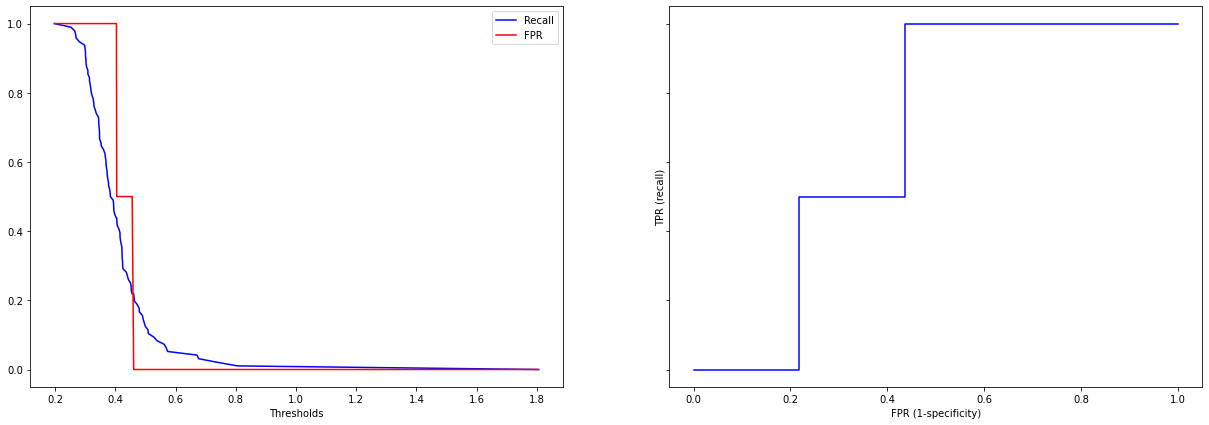

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999719  0.999438   1.000000     1.000000  0.999719  1.000000
Validation  0.638229  0.405885   0.764434     0.872449  0.527988  0.707603

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000397  0.000795   0.000000     0.000000  0.000398  7.901499e-07
Validation  0.024585  0.054037   0.042875     0.031998  0.048194  1.754308e-02

Logistic Regression
╠■■■■■■■■■╣


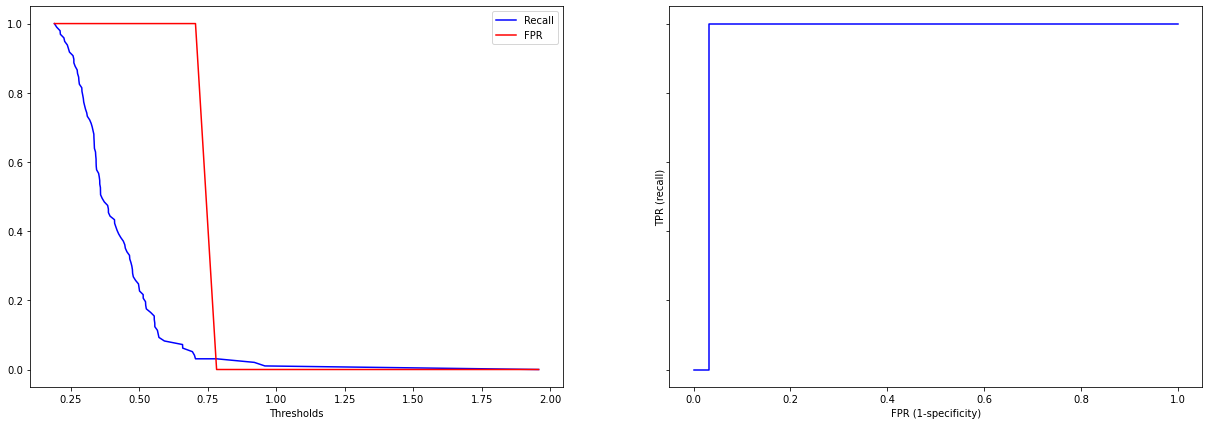

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.681318  0.566352   0.735492     0.796180  0.639740  0.740274
Validation  0.675808  0.566790   0.727533     0.785714  0.635664  0.727614

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009452  0.016725   0.015662     0.017108  0.011911  0.007861
Validation  0.023995  0.058553   0.023178     0.030040  0.040429  0.024618

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497970  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.653960  0.513142   0.717505     0.795918   
XGBoost Classifier              0.615353  0.603257   0.620392     0.627551   
SVM                             0.668204  0.472707   0.779595     0.865306   
KNN                             0.638229  0.405885   0.764434     0.872449   
Logistic Regression             0.675808  0.566790   0.727533     0.785714   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.597521  0.704902  
XGBoost Classifier              0.611028  0.673286  
SVM                             0.586880  0.731036  
KNN                             0.527988  0.707603  
Logistic Regression             0.635664  0.727614

Accuracy  \
Dummy Random                    0.49729272419627746-0.49864636209813873   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)    0.6348793379262954-0.6730404797469667   
XGBoost Classifier                0.5901532223188145-0.6405522578427932   
SVM                                0.6524510013587439-0.683957369096037   
KNN                               0.6226803516449803-0.6537777442837466   
Logistic Regression               0.6606320050066852-0.6909840728965573   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)      0.483564496411243-0.542718744157712   
XGBoost Classifier                0.5680719585832379-0.6384421622165972   
SVM                              0.43738071907844867-0.5080325977634397   
KNN                             0.37170953574205756-0.44006123317156864   
Logistic Regression               0.5297580199587397-0.6038226850505368   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6919404341480366-0.7430691436338013   
XGBoost Classifier               0.594422948581129-0.6463601597654884   
SVM                             0.7638178421689509-0.7953725402706698   
KNN                             0.7373170075511015-0.7915499947844375   
Logistic Regression              0.7128742138981516-0.742192517115505   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.7733562939431605-0.818480440750717   
XGBoost Classifier              0.5970903222078393-0.6580117186084872   
SVM                             0.8511016237974007-0.8795106211005586   
KNN                             0.8522115989378999-0.8926863602457734   
Logistic Regression             0.7667153196683415-0.8047132517602299   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.5716676330841277-0.6233738057156035   
XGBoost Classifier               0.5831927986767702-0.6388638775807589   
SVM                              0.5566253095240246-0.6171355141811725   
KNN                             0.49750741982205615-0.5584690557443457   
Logistic Regression              0.6100949969128129-0.6612335336728381   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6836788251944131-0.7261261171907044  
XGBoost Classifier               0.6471461432594539-0.699424940337869  
SVM                              0.7176104064147253-0.744461688966408  
KNN                             0.6965074095963901-0.7186978499966246  
Logistic Regression             0.7120441035703551-0.7431835162345244

In [191]:
#r_symptoms_svitals
run_models(r_symptoms_svitals, y[r_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

It seems the vitals do hold certain importance compared to the reported symptoms. Surprisingly, <b>sats</b> is on the list of high importance, however this might be due to the vitals not being standardized. Again there is an improvement, with a little sacrifice in specificity. <b>XGB</b> and <b>KNN</b> however performed slightly worse.

Dummy Random
╠■■■■■■■■■╣


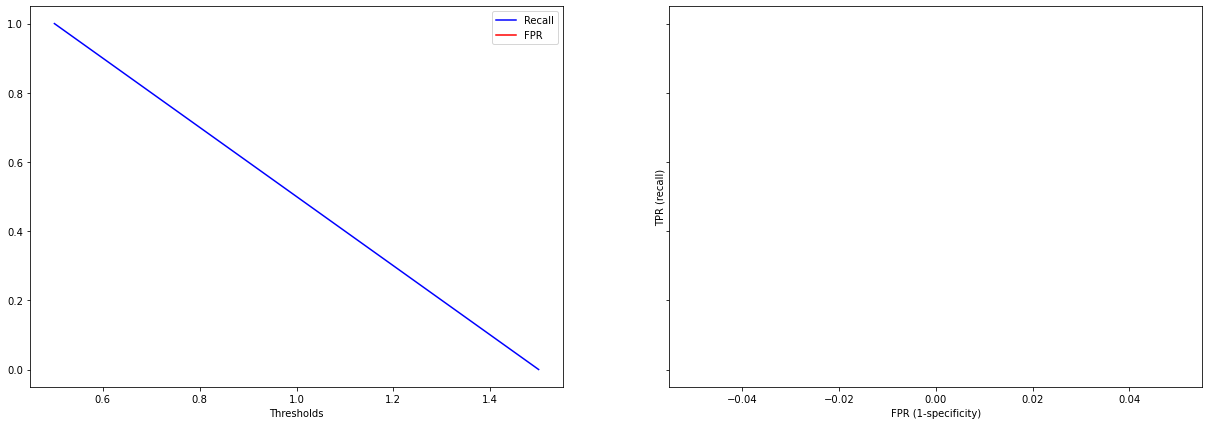

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500113     0.0        0.0          1.0  0.0      0.5
Validation  0.498985     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000146     0.0        0.0          0.0  0.0      0.0
Validation  0.001311     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


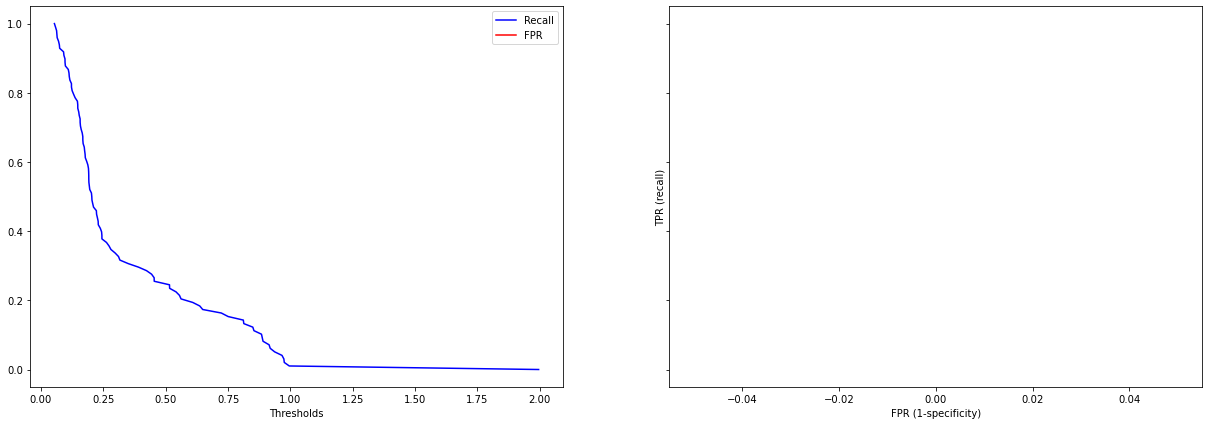

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665444  0.525069   0.730094     0.805756  0.610718  0.710211
Validation  0.660367  0.519233   0.727774     0.802041  0.604117  0.715423

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005162  0.010829   0.010892     0.012830  0.006871  0.005327
Validation  0.038778  0.057240   0.061376     0.057763  0.050259  0.041879

Random Forest (100 estimators)
╠■■■■■■■■■╣


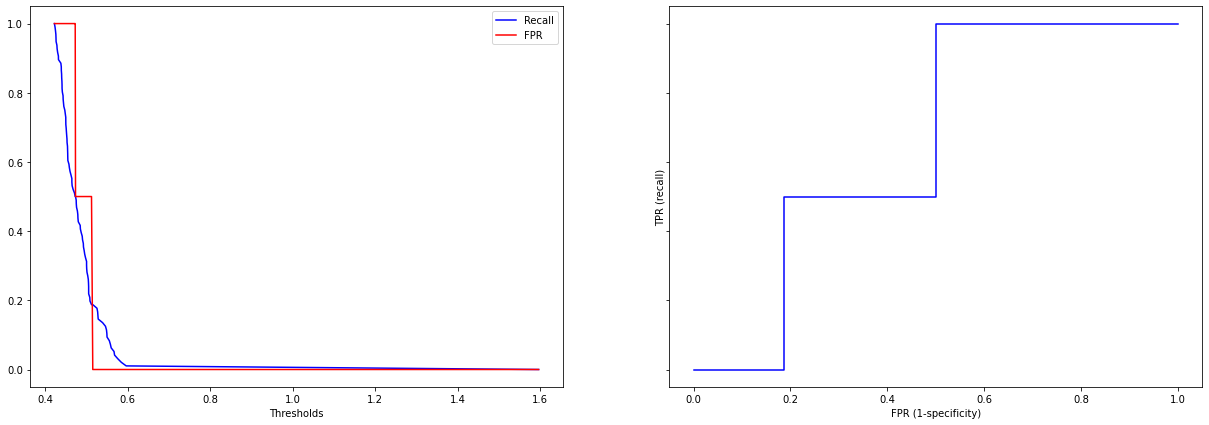

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661154  0.533761   0.716622     0.788488  0.611467  0.720635
Validation  0.661859  0.525356   0.725164     0.798980  0.608441  0.708102

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004986  0.019599   0.013010     0.019688  0.010141  0.007454
Validation  0.036959  0.047802   0.056654     0.046897  0.045992  0.036554

XGBoost Classifier
╠■■■■■■■■■╣


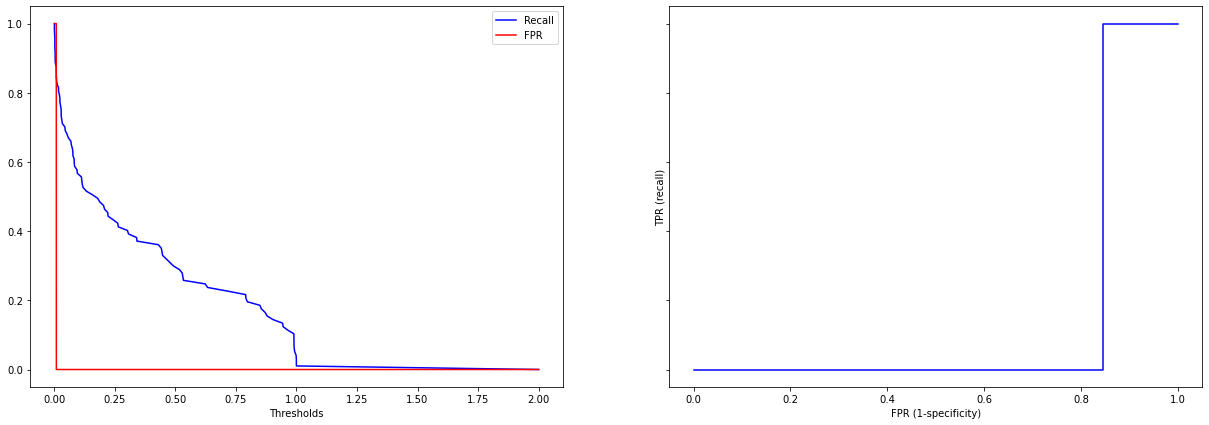

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999718  0.999435   1.000000     1.000000  0.999717  1.000000
Validation  0.638926  0.624881   0.643813     0.653061  0.633855  0.696753

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000399  0.000799   0.000000      0.00000  0.000400  7.981058e-07
Validation  0.047257  0.056624   0.048458      0.04929  0.050369  4.806850e-02

SVM
╠■■■■■■■■■╣


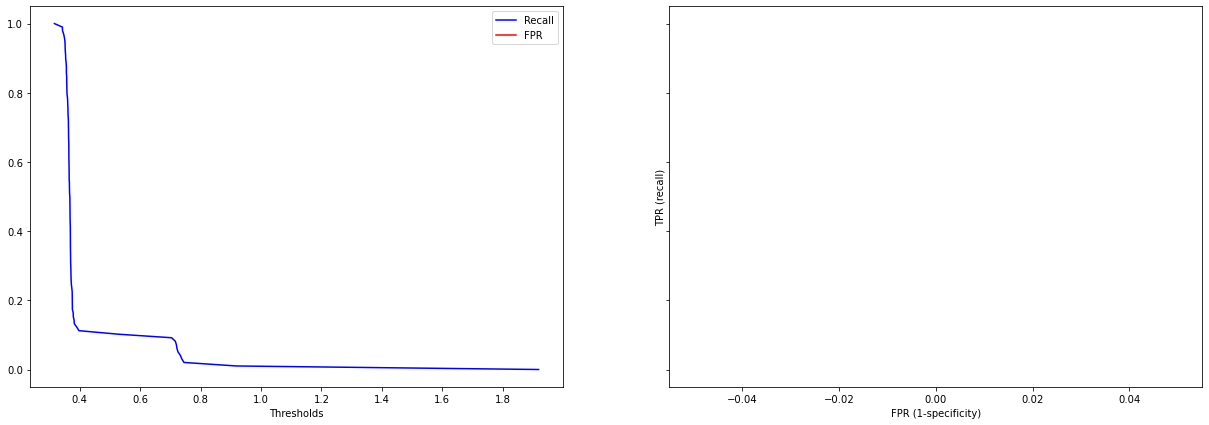

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.676339  0.496620   0.775675     0.855982  0.604947  0.748602
Validation  0.659813  0.488631   0.743504     0.831633  0.588911  0.723020

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007347  0.028301   0.011236     0.016096  0.018352  0.004955
Validation  0.046964  0.063130   0.069326     0.043889  0.065246  0.040922

KNN
╠■■■■■■■■■╣


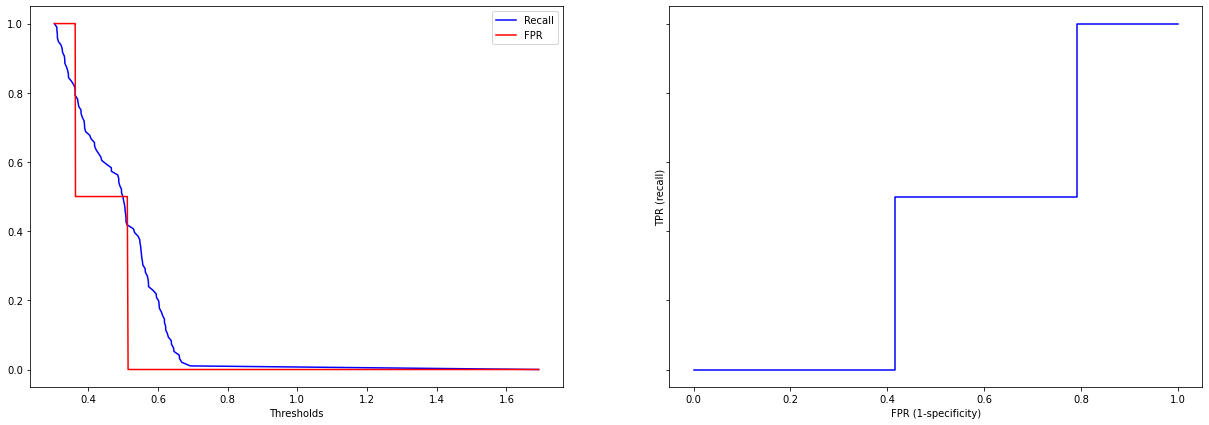

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999887  0.999774    1.00000     1.000000  0.999887  1.000000
Validation  0.589099  0.486807    0.61471     0.691837  0.541210  0.618397

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000238  0.000476   0.000000     0.000000  0.000238  2.685600e-07
Validation  0.024483  0.058965   0.031749     0.055224  0.040830  2.288147e-02

Logistic Regression
╠■■■■■■■■■╣


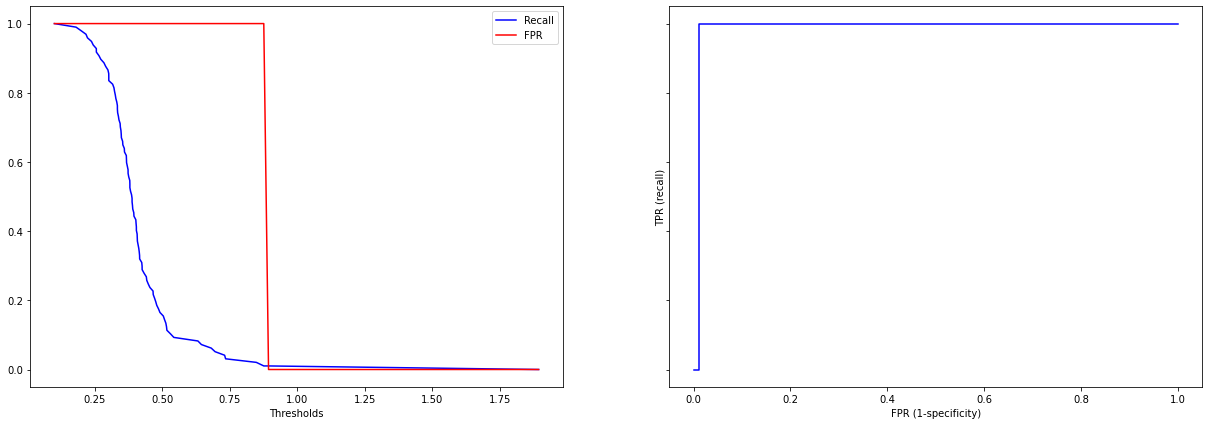

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.678878  0.563347   0.732493     0.794357  0.636845  0.737603
Validation  0.669015  0.560874   0.718381     0.777551  0.628672  0.728313

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006982  0.010987   0.008351     0.007194  0.009195  0.005880
Validation  0.024903  0.045244   0.035941     0.041880  0.033552  0.022868

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498985  0.000000   0.000000     1.000000   
MultinomialNB                   0.660367  0.519233   0.727774     0.802041   
Random Forest (100 estimators)  0.661859  0.525356   0.725164     0.798980   
XGBoost Classifier              0.638926  0.624881   0.643813     0.653061   
SVM                             0.659813  0.488631   0.743504     0.831633   
KNN                             0.589099  0.486807   0.614710     0.691837   
Logistic Regression             0.669015  0.560874   0.718381     0.777551   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.604117  0.715423  
Random Forest (100 estimators)  0.608441  0.708102  
XGBoost Classifier              0.633855  0.696753  
SVM                             0.588911  0.723020  
KNN                             0.541210  0.618397  
Logistic Regression             0.628672  0.728313

Accuracy  \
Dummy Random                    0.49815584103459115-0.49981370211261694   
MultinomialNB                      0.635842120094235-0.6848923665938413   
Random Forest (100 estimators)    0.6384839722282915-0.6852340428965401   
XGBoost Classifier                0.6090379488170503-0.6688134963295365   
SVM                               0.6301102716516722-0.6895157513463595   
KNN                                0.573614995178432-0.6045834923384021   
Logistic Regression               0.6532648400488028-0.6847647880460899   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                     0.483031282489817-0.5554350131193357   
Random Forest (100 estimators)  0.49512313930363494-0.5555880542647017   
XGBoost Classifier               0.5890691810481676-0.6606937544290534   
SVM                              0.4487043141585402-0.5285581059610228   
KNN                             0.44951424005735896-0.5240994478420433   
Logistic Regression              0.5322590231143834-0.5894890700622811   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6889558625162565-0.7665911599206813   
Random Forest (100 estimators)  0.6893331446754779-0.7609952033956148   
XGBoost Classifier               0.613165412659245-0.6744600612159284   
SVM                              0.6996588363525542-0.787350024461817   
KNN                             0.5946305133337827-0.6347904444467222   
Logistic Regression             0.6956501535548424-0.7411124900827172   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7655082405929319-0.8385733920601295   
Random Forest (100 estimators)   0.769319415841372-0.8286397678320975   
XGBoost Classifier              0.6218872401703684-0.6842352088092235   
SVM                             0.8038745499821724-0.8593907561402763   
KNN                                0.656910210468045-0.72676325891971   
Logistic Regression             0.7510640512463513-0.8040379895699752   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5723306861205129-0.6359032233589004   
Random Forest (100 estimators)   0.5793528318659097-0.637528471389217   
XGBoost Classifier              0.6019987301616676-0.6657114996761544   
SVM                             0.5476453687676016-0.6301761988182896   
KNN                             0.5153862169588962-0.5670330235928119   
Logistic Regression              0.607452168248938-0.6498922409954995   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6889361077813746-0.7419092049881363  
Random Forest (100 estimators)  0.6849827956850081-0.7312208904895237  
XGBoost Classifier              0.6663514244862225-0.7271538069198835  
SVM                             0.6971390833224048-0.7489018129371502  
KNN                             0.6039259142456677-0.6328689397503526  
Logistic Regression             0.7138497678701455-0.7427754177637863

In [192]:
#ra_symptoms_vitals
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


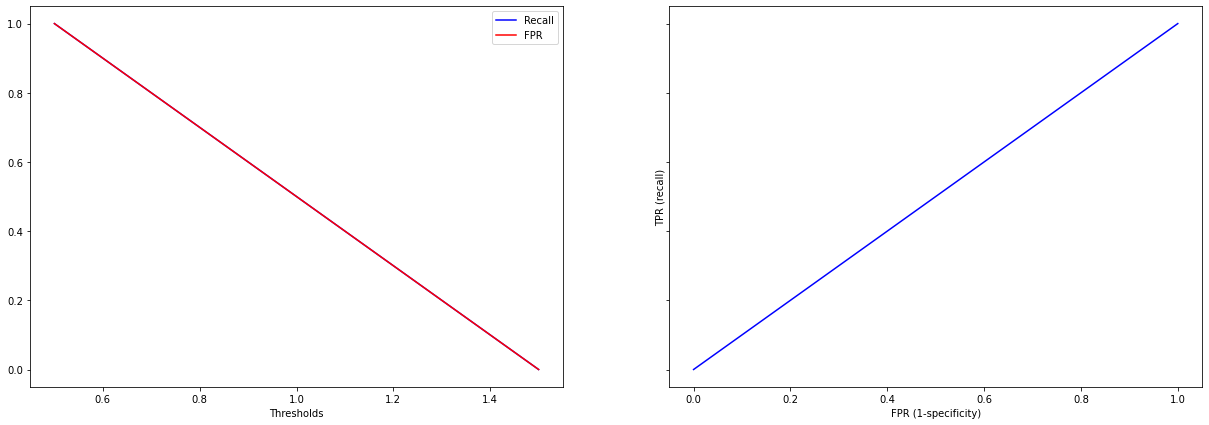

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500113     0.0        0.0          1.0  0.0      0.5
Validation  0.498985     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000146     0.0        0.0          0.0  0.0      0.0
Validation  0.001311     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


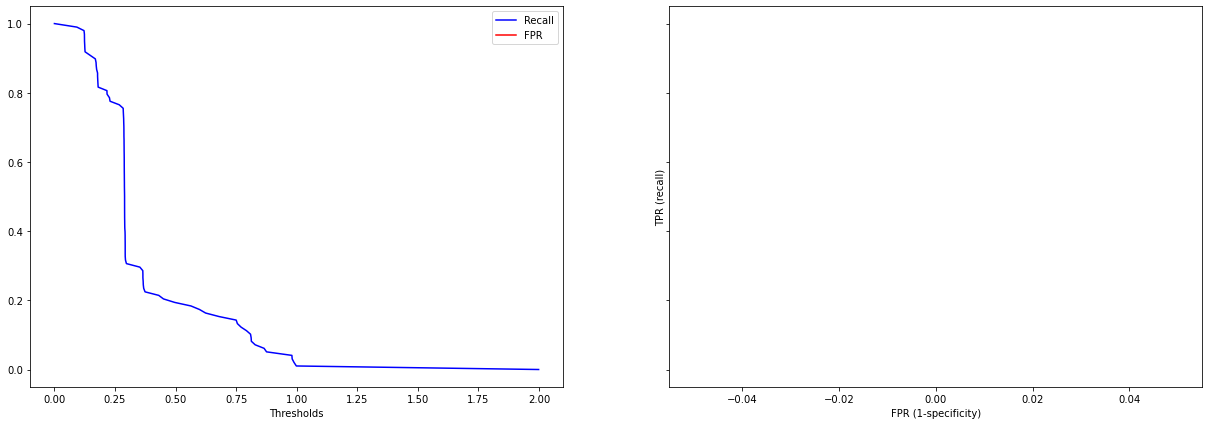

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655396  0.499095   0.726256     0.811625  0.591497  0.684013
Validation  0.656267  0.494826   0.733707     0.818367  0.590190  0.689467

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007596  0.009336   0.015604     0.016195  0.007597  0.008217
Validation  0.033098  0.042457   0.054119     0.044034  0.042036  0.040337

Random Forest (100 estimators)
╠■■■■■■■■■╣


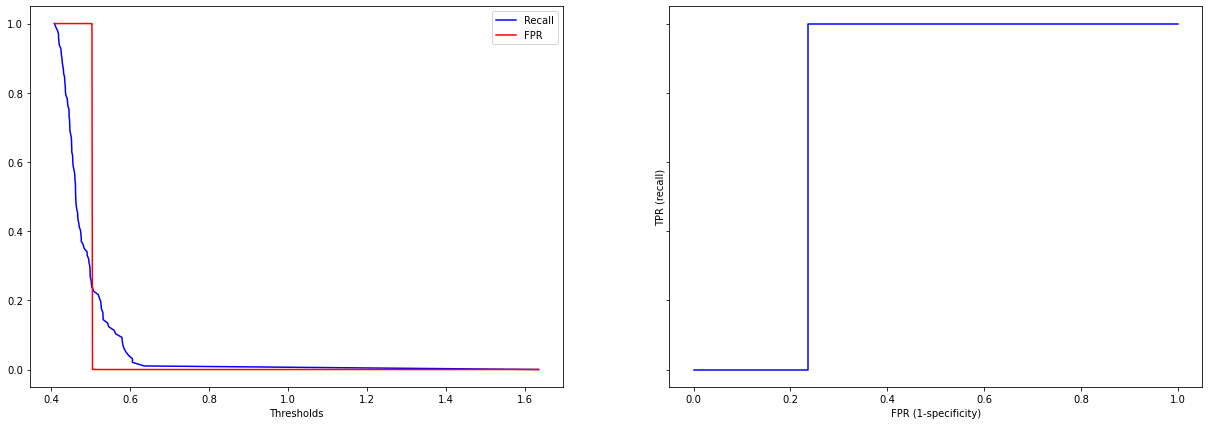

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666742  0.532634   0.728277     0.800790  0.614911  0.728037
Validation  0.640006  0.518254   0.688094     0.762245  0.590047  0.694490

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005882  0.019697   0.014619     0.020192  0.010699  0.006794
Validation  0.028019  0.043171   0.040355     0.047143  0.034971  0.025874

XGBoost Classifier
╠■■■■■■■■■╣


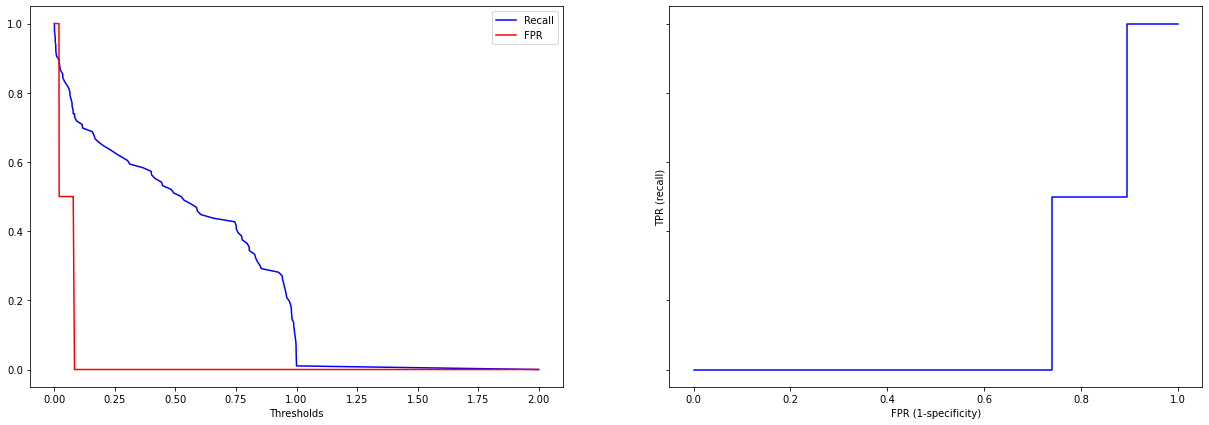

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    1.000000  1.000000   1.000000      1.00000  1.000000  1.000000
Validation  0.628823  0.633179   0.628669      0.62449  0.630262  0.675153

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000000  0.000000   0.000000     0.000000  0.000000  0.000000
Validation  0.023871  0.047514   0.022119     0.034285  0.030929  0.032018

SVM
╠■■■■■■■■■╣


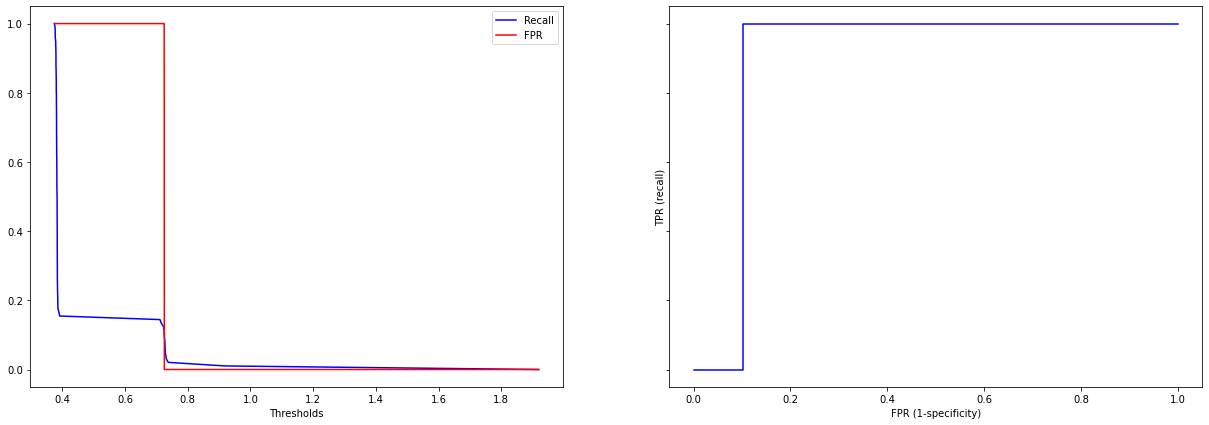

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667194  0.482157   0.765446     0.852144  0.591490  0.742618
Validation  0.662877  0.470398   0.767732     0.856122  0.581881  0.739893

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008353  0.014788   0.014804     0.012478  0.012367  0.004661
Validation  0.036877  0.055330   0.058592     0.044466  0.053945  0.033968

KNN
╠■■■■■■■■■╣


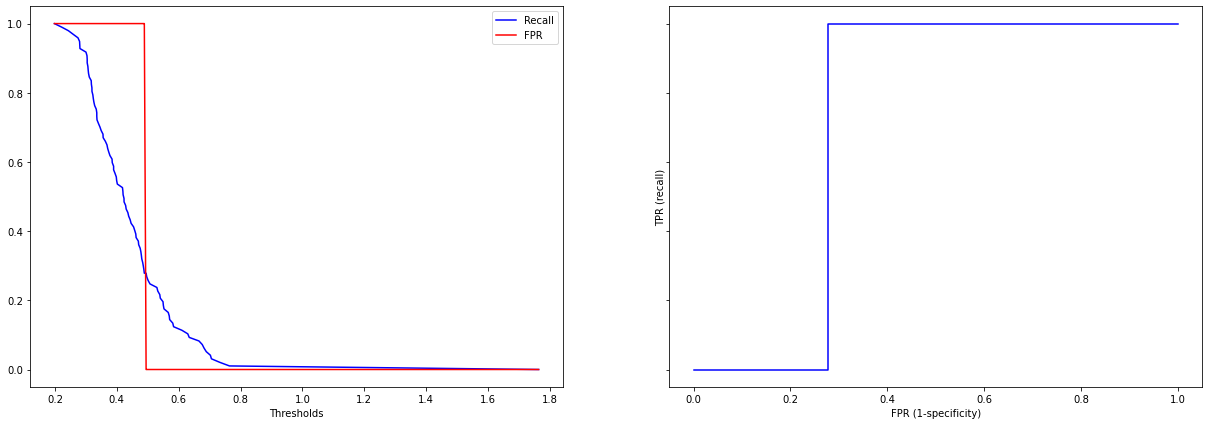

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999718  0.999435   1.000000      1.00000  0.999717  0.999999
Validation  0.650671  0.500928   0.718573      0.80102  0.589231  0.708851

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000480  0.000960   0.000000     0.000000  0.000480  0.000001
Validation  0.024214  0.036969   0.043019     0.043625  0.031205  0.029087

Logistic Regression
╠■■■■■■■■■╣


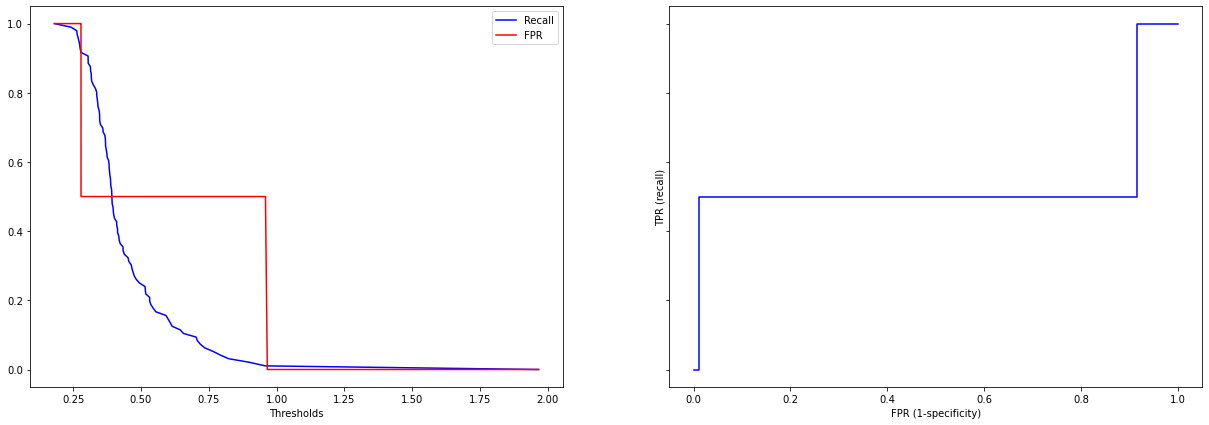

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679330  0.557022   0.737338     0.801580  0.634518  0.741730
Validation  0.675686  0.546722   0.739185     0.805102  0.627835  0.728896

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006719  0.014107   0.008881     0.010036  0.009956  0.007602
Validation  0.030987  0.040702   0.043895     0.041505  0.036964  0.027054

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498985  0.000000   0.000000     1.000000   
MultinomialNB                   0.656267  0.494826   0.733707     0.818367   
Random Forest (100 estimators)  0.640006  0.518254   0.688094     0.762245   
XGBoost Classifier              0.628823  0.633179   0.628669     0.624490   
SVM                             0.662877  0.470398   0.767732     0.856122   
KNN                             0.650671  0.500928   0.718573     0.801020   
Logistic Regression             0.675686  0.546722   0.739185     0.805102   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.590190  0.689467  
Random Forest (100 estimators)  0.590047  0.694490  
XGBoost Classifier              0.630262  0.675153  
SVM                             0.581881  0.739893  
KNN                             0.589231  0.708851  
Logistic Regression             0.627835  0.728896

Accuracy  \
Dummy Random                    0.49815584103459115-0.49981370211261694   
MultinomialNB                     0.6353347487999886-0.6772002144238797   
Random Forest (100 estimators)    0.6222849329950814-0.6577264624260312   
XGBoost Classifier                0.6137255171145465-0.6439197745046391   
SVM                                0.639553690133194-0.6861999615812993   
KNN                               0.6353565577373248-0.6659849941118412   
Logistic Regression                0.656088324826223-0.6952843054441591   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.4679739520393858-0.5216776661836612   
Random Forest (100 estimators)   0.4909501926335126-0.545557743874424   
XGBoost Classifier               0.6031285089659988-0.663228943105739   
SVM                             0.4354038029458937-0.5053919092783902   
KNN                             0.4775463187346809-0.5243089688348925   
Logistic Regression             0.5209804010825192-0.5724642495049885   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6994788068927587-0.7679346083474716   
Random Forest (100 estimators)    0.66257138411005-0.7136170937472481   
XGBoost Classifier               0.614679495388092-0.6426585953626326   
SVM                             0.7306746171875385-0.8047885891114086   
KNN                             0.6913658690856975-0.7457809682441602   
Logistic Regression             0.7114237825446394-0.7669469572264007   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7905177013735255-0.8462169925040254   
Random Forest (100 estimators)  0.7324291061213454-0.7920606897970218   
XGBoost Classifier               0.6028062891829806-0.646173302653754   
SVM                              0.8279999637978308-0.884244934161353   
KNN                             0.7734295240943221-0.8286112922322084   
Logistic Regression             0.7788519981203064-0.8313520835123465   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5636043056248005-0.6167756155030854   
Random Forest (100 estimators)  0.5679295996867586-0.6121648266450714   
XGBoost Classifier              0.6107005226546152-0.6498234503594245   
SVM                             0.5477637677670628-0.6159990137993852   
KNN                             0.5694952110207845-0.6089667366334719   
Logistic Regression              0.604456770349428-0.6512133680991624   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6639553873749005-0.7149784743577949  
Random Forest (100 estimators)  0.6781259129463162-0.7108538471704702  
XGBoost Classifier              0.6549034554617702-0.6954028142322545  
SVM                             0.7184094549332137-0.7613762193859887  
KNN                             0.6904541424363323-0.7272470258479263  
Logistic Regression             0.7117856420631038-0.7460061450289747

In [193]:
#ra_symptoms_nvitals
run_models(ra_symptoms_nvitals, y[ra_symptoms_nvitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


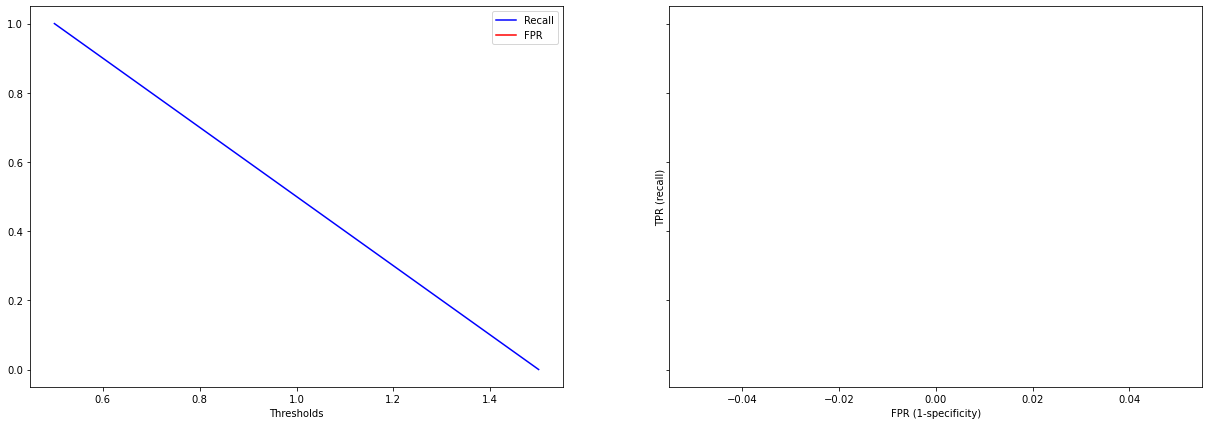

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500113     0.0        0.0          1.0  0.0      0.5
Validation  0.498985     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000146     0.0        0.0          0.0  0.0      0.0
Validation  0.001311     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


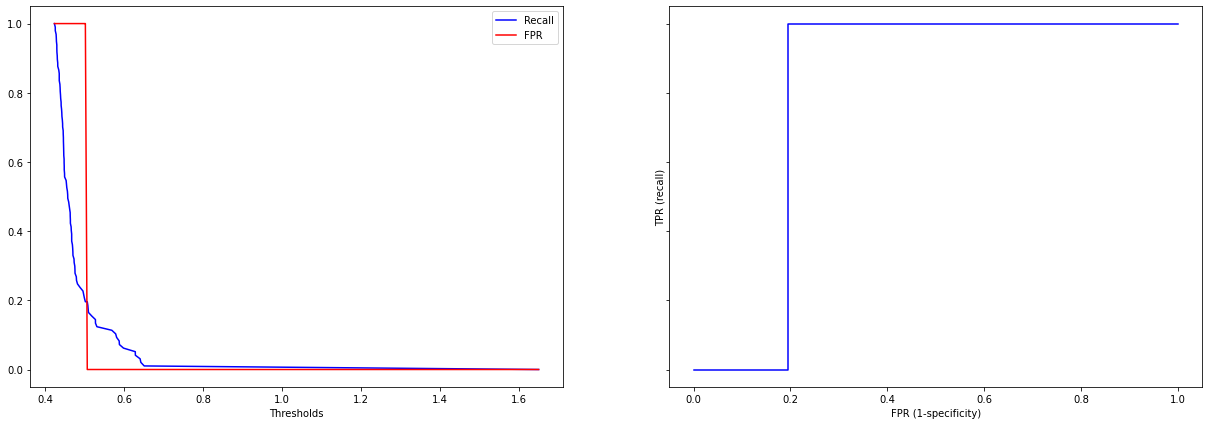

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666460  0.534217   0.726375     0.798646  0.615447  0.724848
Validation  0.648166  0.529344   0.697333     0.767347  0.600603  0.687852

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006284  0.017308   0.009873     0.013609  0.011167  0.006762
Validation  0.017526  0.039931   0.030737     0.039899  0.025516  0.028592

XGBoost Classifier
╠■■■■■■■■■╣


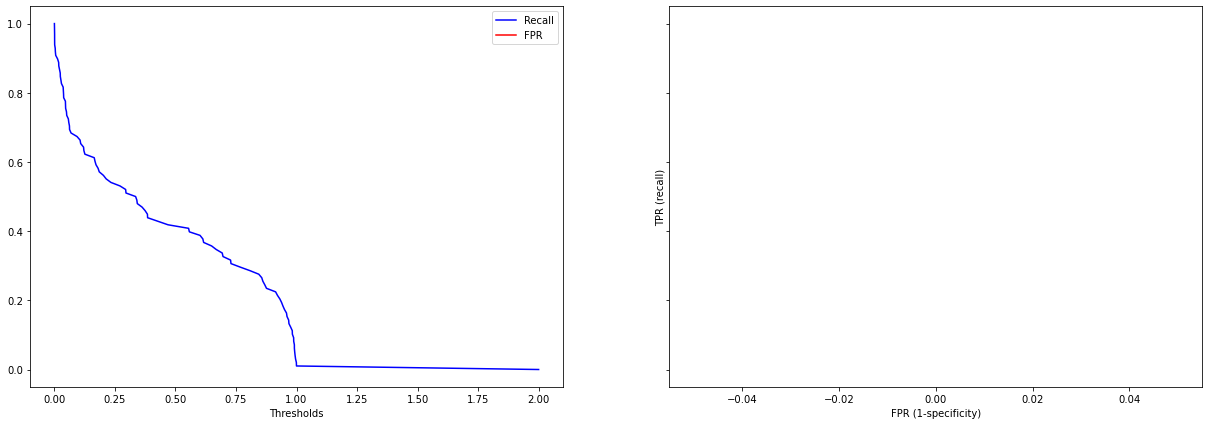

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999774  0.999661   0.999887     0.999887  0.999774  1.000000
Validation  0.636416  0.616749   0.643147     0.656122  0.629340  0.695658

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000291  0.000545   0.000357     0.000357  0.000292  4.503888e-07
Validation  0.047967  0.054561   0.052119     0.052264  0.050963  5.123116e-02

SVM
╠■■■■■■■■■╣


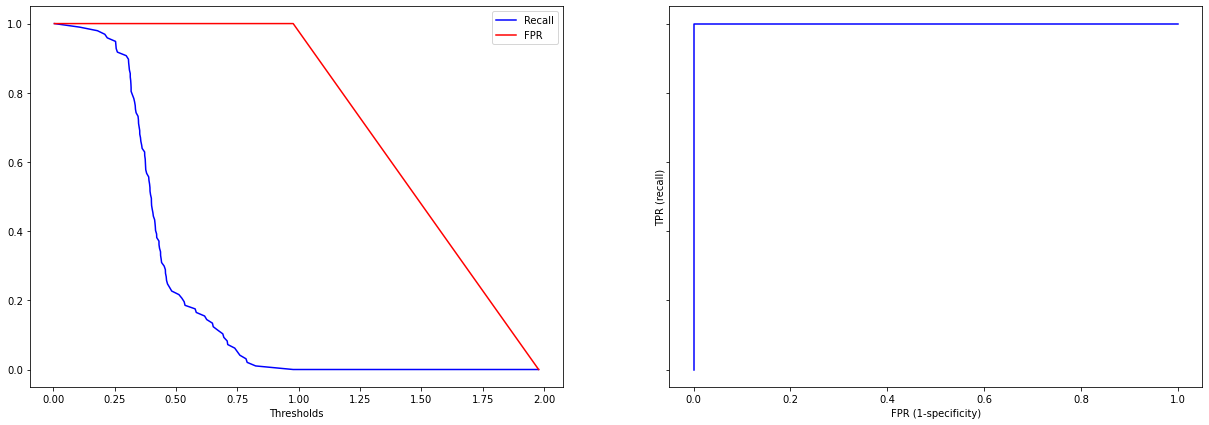

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673460  0.490179   0.774087     0.856659  0.599919  0.741537
Validation  0.656257  0.481550   0.740384     0.831633  0.581993  0.725173

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008801  0.021129   0.016357     0.015594  0.015325  0.010165
Validation  0.035806  0.066601   0.042275     0.028962  0.058983  0.022020

KNN
╠■■■■■■■■■╣


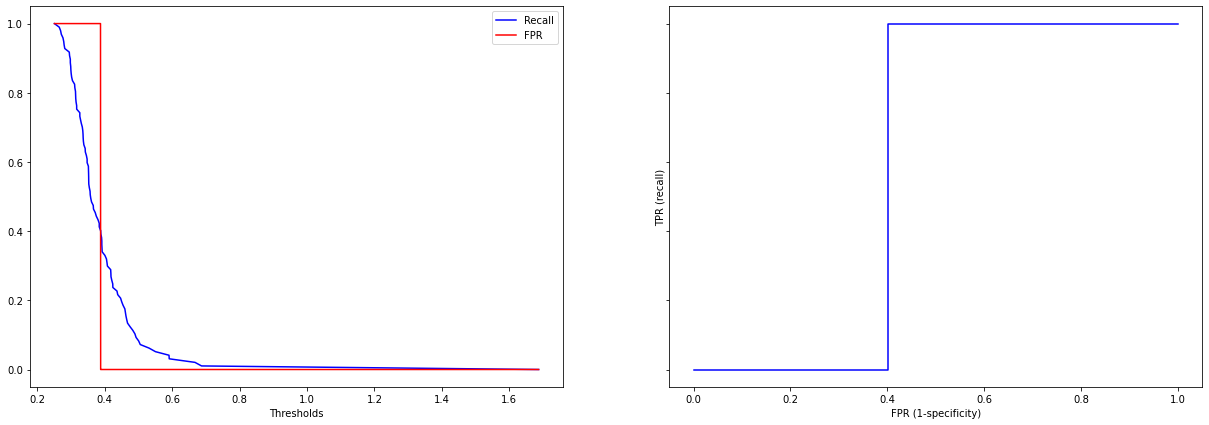

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999831  0.999661   1.000000     1.000000  0.999831  1.000000
Validation  0.625715  0.437899   0.703852     0.814286  0.539107  0.676416

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000273  0.000545   0.000000     0.000000  0.000273  3.077901e-07
Validation  0.030263  0.042672   0.052649     0.037508  0.042056  3.870846e-02

Logistic Regression
╠■■■■■■■■■╣


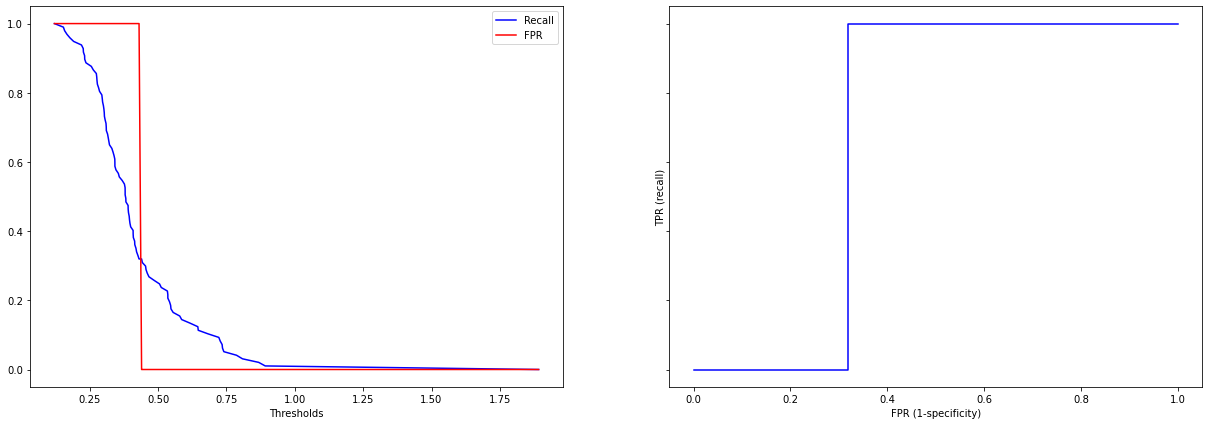

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.682772  0.573960   0.733769     0.791535  0.643966  0.745577
Validation  0.690930  0.572078   0.753656     0.810204  0.648633  0.752005

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005274  0.010296   0.012222     0.015218  0.005433  0.004133
Validation  0.021598  0.052969   0.034067     0.040015  0.033842  0.027167

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498985  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.648166  0.529344   0.697333     0.767347   
XGBoost Classifier              0.636416  0.616749   0.643147     0.656122   
SVM                             0.656257  0.481550   0.740384     0.831633   
KNN                             0.625715  0.437899   0.703852     0.814286   
Logistic Regression             0.690930  0.572078   0.753656     0.810204   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.600603  0.687852  
XGBoost Classifier              0.629340  0.695658  
SVM                             0.581993  0.725173  
KNN                             0.539107  0.676416  
Logistic Regression             0.648633  0.752005

Accuracy  \
Dummy Random                    0.49815584103459115-0.49981370211261694   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)    0.6370819003009072-0.6592508459955808   
XGBoost Classifier                0.6060794559431082-0.6667528241770617   
SVM                               0.6336112501484564-0.6789029941279344   
KNN                               0.6065746554555498-0.6448549519203954   
Logistic Regression               0.6772706887985169-0.7045898726849598   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5040896999110993-0.5545992302064024   
XGBoost Classifier              0.5822416391691665-0.6512566086147957   
SVM                             0.4394280051246555-0.5236723865471649   
KNN                             0.4109111844960173-0.4648876198742156   
Logistic Regression             0.5385771682518605-0.6055786759039836   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6778936675056583-0.7167727774155807   
XGBoost Classifier              0.6101839984802906-0.6761103851376502   
SVM                              0.713647184087405-0.7671210524484458   
KNN                             0.6705544367103973-0.7371504366564852   
Logistic Regression             0.7321101836033863-0.7752018943832744   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.742112602733345-0.7925812748176754   
XGBoost Classifier              0.6230679439095065-0.6891769540496772   
SVM                             0.8133157659621274-0.8499495401603213   
KNN                              0.790563815273248-0.8380076132981805   
Logistic Regression                0.784896496275186-0.83551166699012   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)    0.58446554163277-0.6167405002052659   
XGBoost Classifier              0.5971087639463101-0.6615718121548065   
SVM                             0.5446893258919747-0.6192972778933752   
KNN                             0.5125079555520645-0.5657053504540904   
Logistic Regression              0.6272293225899336-0.670036961680574   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)   0.6697690053252189-0.705934720815825  
XGBoost Classifier              0.6632561042872065-0.7280589622465188  
SVM                             0.7112461414178898-0.7390995689132432  
KNN                              0.6519346944220389-0.700897458847432  
Logistic Regression             0.7348236618762434-0.7691868724549906

In [194]:
#ra_symptoms_svitals
run_models(ra_symptoms_svitals, y[ra_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

All the features that were determined to be important before are also important here

Dummy Random
╠■■■■■■■■■╣


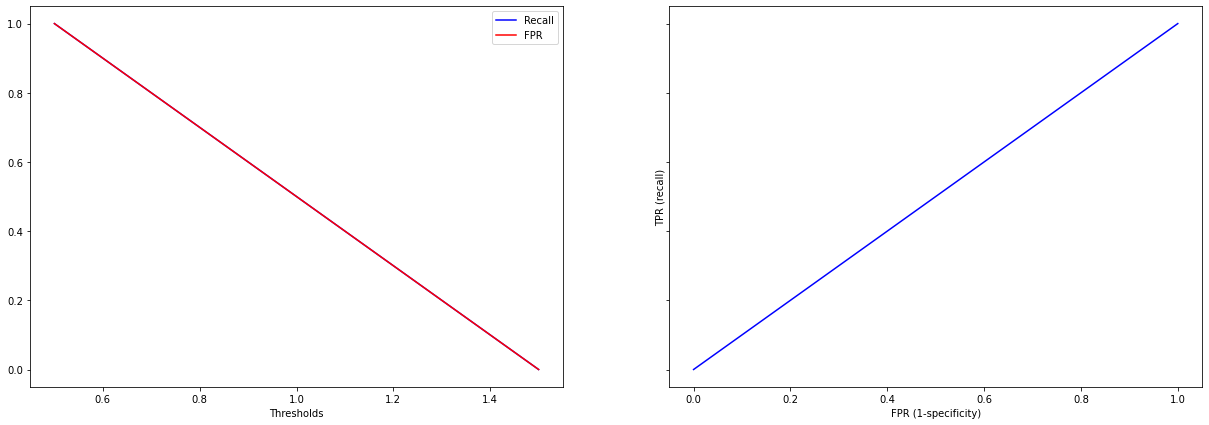

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500113     0.0        0.0          1.0  0.0      0.5
Validation  0.498985     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000146     0.0        0.0          0.0  0.0      0.0
Validation  0.001311     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


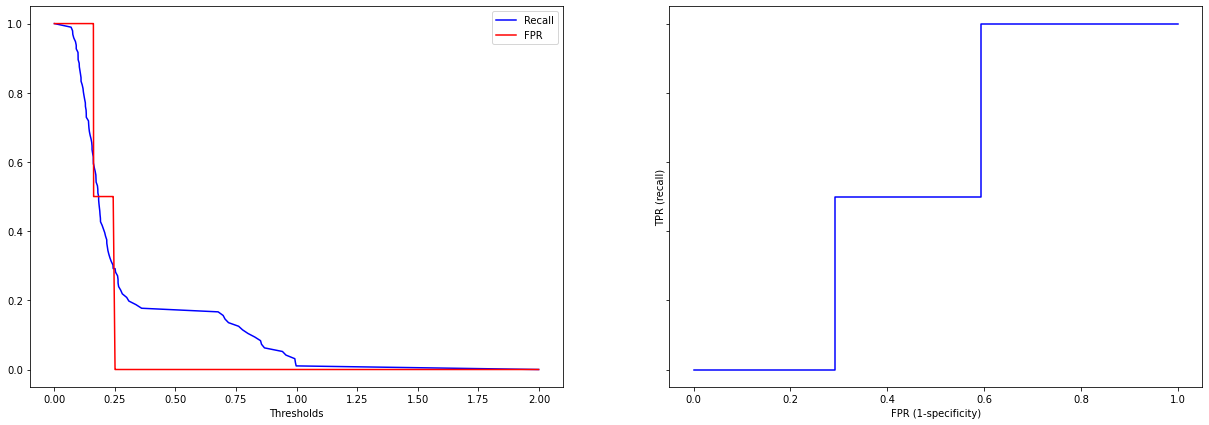

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665669  0.533089   0.725603     0.798194  0.614422  0.713902
Validation  0.673120  0.527335   0.748354     0.819388  0.617102  0.716394

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005851  0.015484   0.011625     0.015647  0.009204  0.009634
Validation  0.021230  0.043645   0.040737     0.043837  0.030822  0.033313

Random Forest (100 estimators)
╠■■■■■■■■■╣


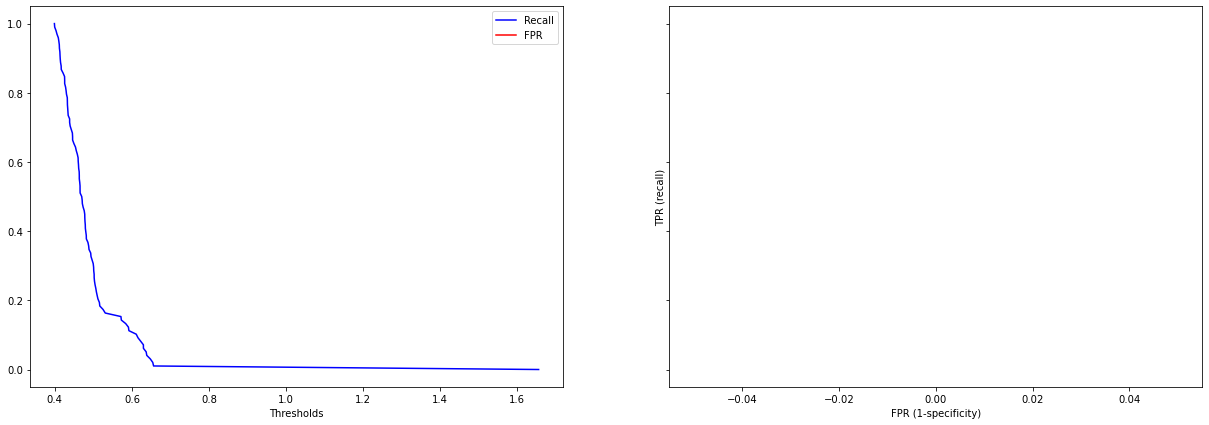

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.670410  0.539859   0.731171     0.800903  0.620718  0.730874
Validation  0.655278  0.529437   0.709733     0.781633  0.605652  0.707527

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008557  0.020451   0.018126     0.022793  0.012077  0.006210
Validation  0.029830  0.043541   0.042364     0.040015  0.037573  0.028559

XGBoost Classifier
╠■■■■■■■■■╣


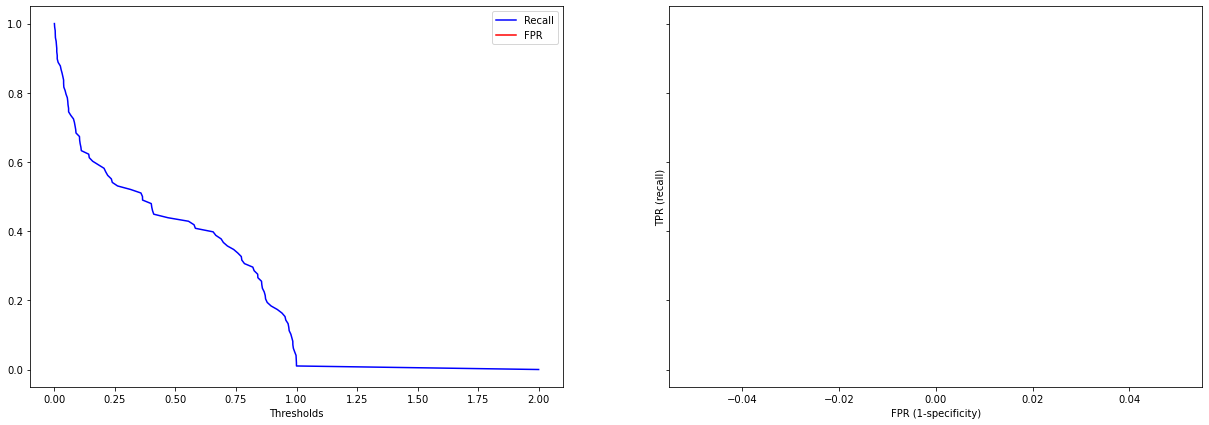

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    1.000000  1.000000   1.000000     1.000000  1.000000  1.000000
Validation  0.624202  0.608689   0.628416     0.639796  0.617276  0.672249

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000000  0.000000    0.00000     0.000000  0.000000  0.000000
Validation  0.035188  0.069007    0.03243     0.038497  0.048133  0.037368

SVM
╠■■■■■■■■■╣


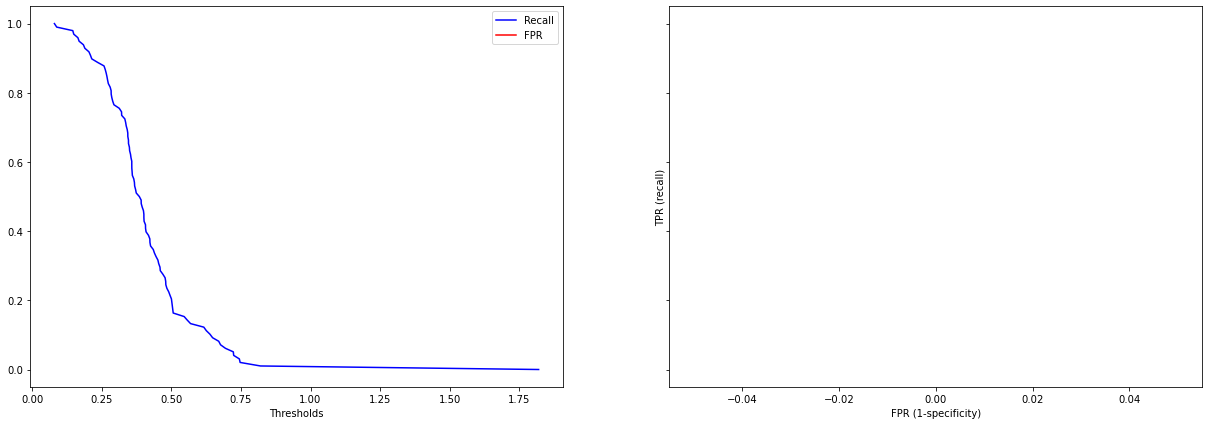

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679330  0.515470   0.767927     0.843115  0.615916  0.751288
Validation  0.674125  0.511101   0.758908     0.837755  0.608090  0.734406

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008429  0.032662   0.020795     0.026512  0.019325  0.007911
Validation  0.037600  0.079924   0.034084     0.029827  0.065834  0.028166

KNN
╠■■■■■■■■■╣


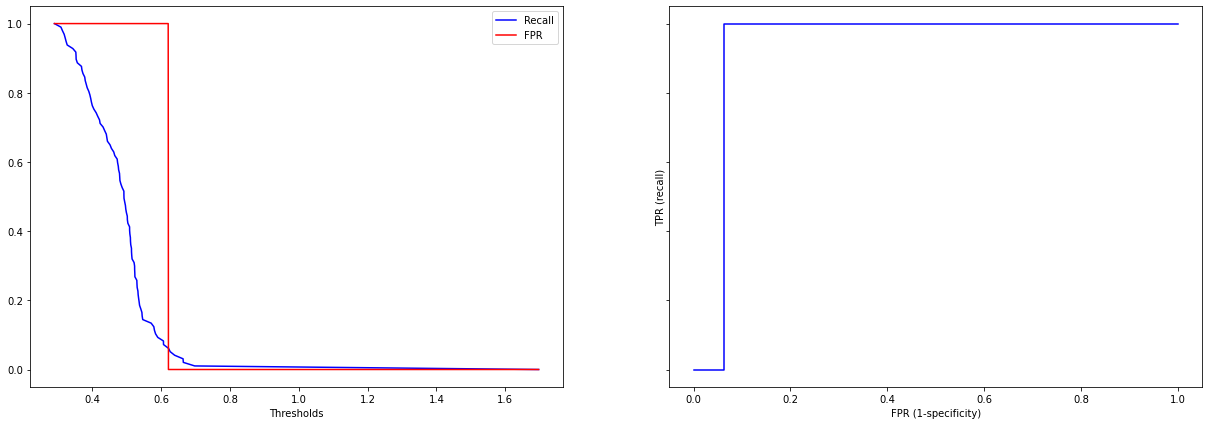

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999831  0.999661   1.000000     1.000000  0.999831  1.000000
Validation  0.579382  0.489610   0.595521     0.669388  0.535024  0.608897

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000381  0.000762   0.000000     0.000000  0.000381  8.084726e-07
Validation  0.043064  0.088851   0.047509     0.050496  0.071421  5.693573e-02

Logistic Regression
╠■■■■■■■■■╣


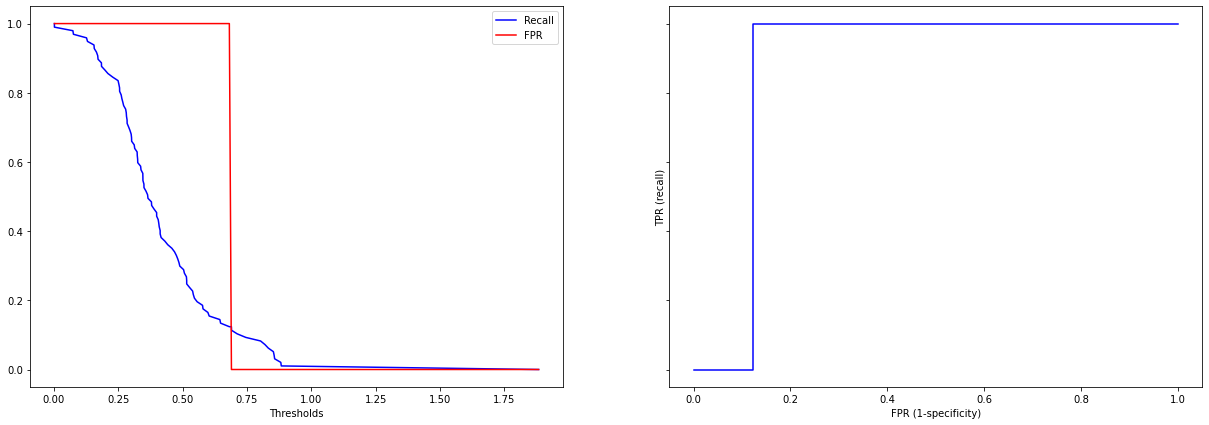

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.681191  0.581298   0.726335     0.781038  0.645715  0.741655
Validation  0.671543  0.572057   0.714512     0.771429  0.634673  0.729944

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009010  0.013354   0.011242     0.010694  0.011173  0.011267
Validation  0.030641  0.055143   0.030745     0.022664  0.043420  0.026998

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498985  0.000000   0.000000     1.000000   
MultinomialNB                   0.673120  0.527335   0.748354     0.819388   
Random Forest (100 estimators)  0.655278  0.529437   0.709733     0.781633   
XGBoost Classifier              0.624202  0.608689   0.628416     0.639796   
SVM                             0.674125  0.511101   0.758908     0.837755   
KNN                             0.579382  0.489610   0.595521     0.669388   
Logistic Regression             0.671543  0.572057   0.714512     0.771429   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.617102  0.716394  
Random Forest (100 estimators)  0.605652  0.707527  
XGBoost Classifier              0.617276  0.672249  
SVM                             0.608090  0.734406  
KNN                             0.535024  0.608897  
Logistic Regression             0.634673  0.729944

Accuracy  \
Dummy Random                    0.49815584103459115-0.49981370211261694   
MultinomialNB                     0.6596924178318466-0.6865470932009932   
Random Forest (100 estimators)     0.6364118729909888-0.674144430748781   
XGBoost Classifier                0.6019476272262623-0.6464570138179726   
SVM                               0.6503440480949043-0.6979052008432496   
KNN                               0.5521461803982982-0.6066179343846706   
Logistic Regression               0.6521634535808235-0.6909215976985715   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.4997312724874188-0.5549378678960073   
Random Forest (100 estimators)  0.5018994823058569-0.5569749765686021   
XGBoost Classifier              0.5650451741032497-0.6523326861317534   
SVM                             0.4605526449453674-0.5616489629705264   
KNN                             0.43341638208665123-0.545804397134128   
Logistic Regression             0.5371816020280838-0.6069330135151031   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.7225893252664057-0.7741177270520632   
Random Forest (100 estimators)  0.6829397800258271-0.7365258607693993   
XGBoost Classifier              0.6079051583641591-0.6489268487678465   
SVM                             0.7373511574600304-0.7804640004076249   
KNN                               0.56547376876137-0.6255681925692227   
Logistic Regression              0.695066828414207-0.7339563741743171   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                    0.7916630151397077-0.847112495064374   
Random Forest (100 estimators)  0.7563250677037575-0.8069402384186916   
XGBoost Classifier              0.6154482582745943-0.6641435784600999   
SVM                             0.8188905787430448-0.8566196253385877   
KNN                             0.6374511711719578-0.7013243390321239   
Logistic Regression             0.7570943486355745-0.7857627942215683   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5976083405615512-0.6365959096229522   
Random Forest (100 estimators)  0.5818884360798512-0.6294153262249117   
XGBoost Classifier               0.5868339117291856-0.647717823354983   
SVM                             0.5664527417879092-0.6497270353292394   
KNN                             0.4898531257487622-0.5801939348937499   
Logistic Regression             0.6072114977390906-0.6621338957287277   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6953255983230149-0.7374631386931274  
Random Forest (100 estimators)   0.689465035998261-0.7255897181235484  
XGBoost Classifier                0.648614925408277-0.695882527252441  
SVM                             0.7165926558094726-0.7522195815158843  
KNN                             0.5728877514780956-0.6449063915347063  
Logistic Regression             0.7128688213004339-0.7470186834850299

In [195]:
#ra_symptoms_vitals_ex
run_models(ra_symptoms_vitals_ex, y[ra_symptoms_vitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


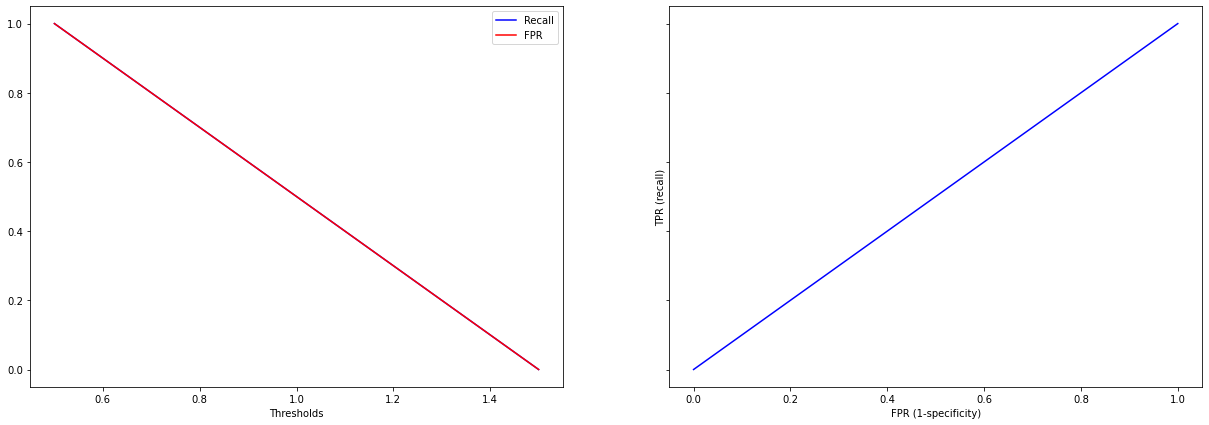

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500113     0.0        0.0          1.0  0.0      0.5
Validation  0.498985     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000146     0.0        0.0          0.0  0.0      0.0
Validation  0.001311     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


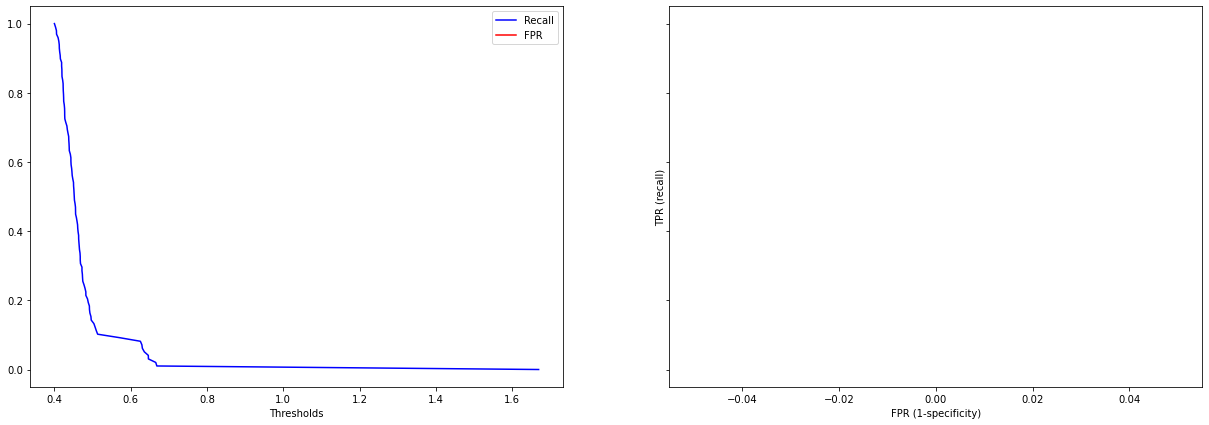

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.668830  0.542900   0.726195     0.794695  0.620782  0.730003
Validation  0.656301  0.520326   0.719074     0.792857  0.601965  0.718801

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006712  0.025669   0.014708     0.023347  0.014004  0.005440
Validation  0.023389  0.045960   0.041896     0.051145  0.031366  0.024892

XGBoost Classifier
╠■■■■■■■■■╣


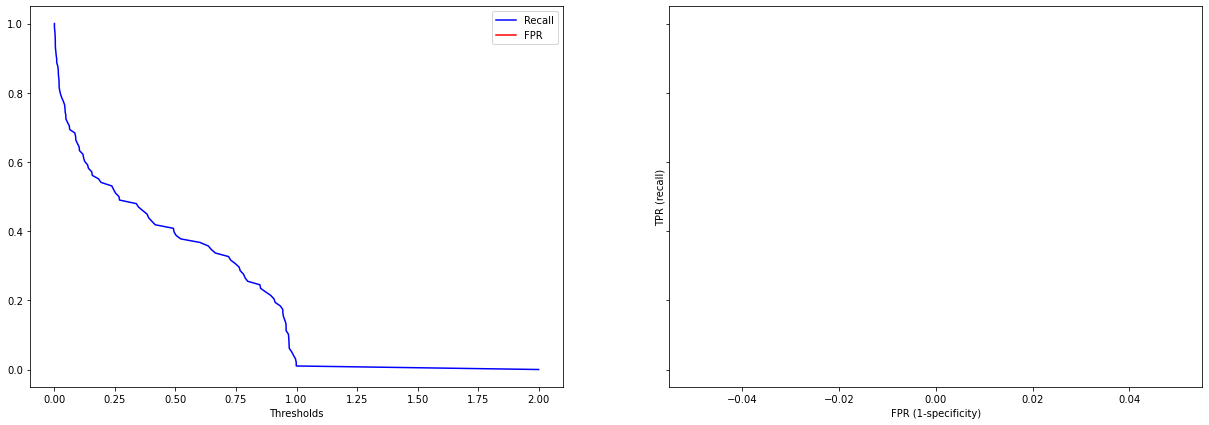

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999944  1.000000   0.999887     0.999887  0.999944  1.000000
Validation  0.644054  0.626953   0.649053     0.661224  0.637355  0.696498

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000178  0.000000   0.000357     0.000357  0.000178  2.014200e-07
Validation  0.040708  0.062876   0.037737     0.029574  0.049004  4.228922e-02

SVM
╠■■■■■■■■■╣


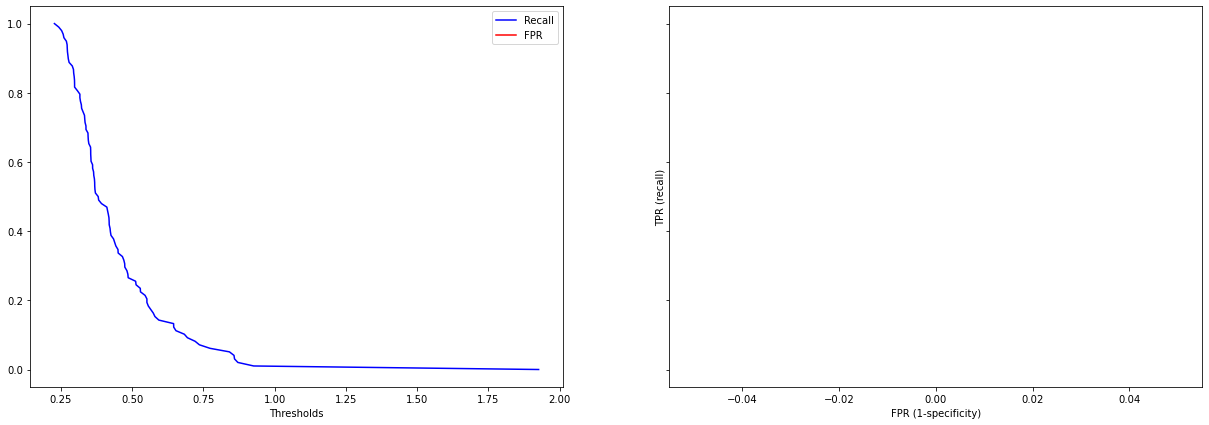

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675548  0.496502   0.774038     0.854515  0.604451  0.748534
Validation  0.669017  0.487683   0.767515     0.851020  0.594393  0.738123

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010447  0.024903   0.020797     0.020430  0.017847  0.004219
Validation  0.028542  0.060338   0.038246     0.034754  0.051158  0.018926

KNN
╠■■■■■■■■■╣


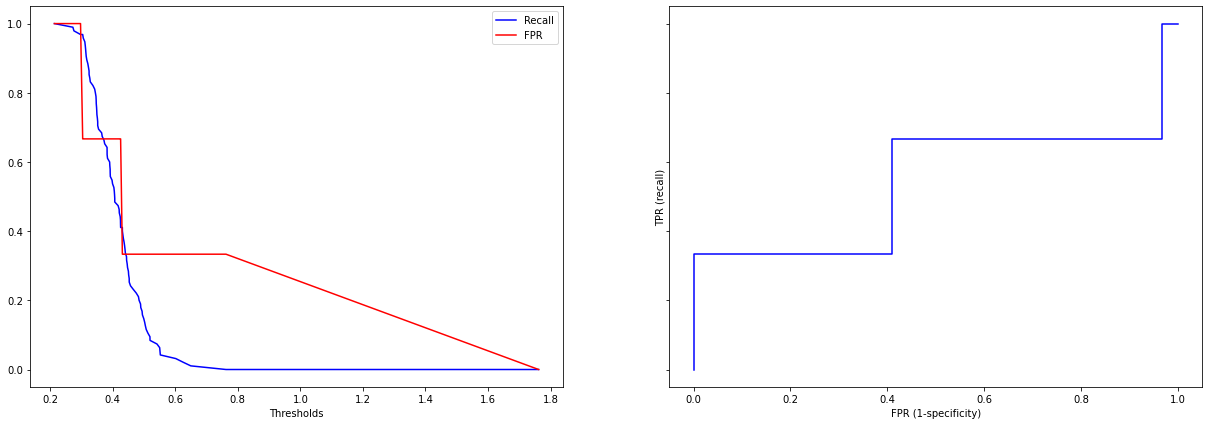

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999944  0.999887   1.000000     1.000000  0.999943  1.000000
Validation  0.632329  0.433735   0.722501     0.831633  0.540144  0.696439

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000179  0.000357   0.000000     0.000000  0.000179  2.016476e-07
Validation  0.031199  0.056694   0.049605     0.040029  0.051897  2.754821e-02

Logistic Regression
╠■■■■■■■■■╣


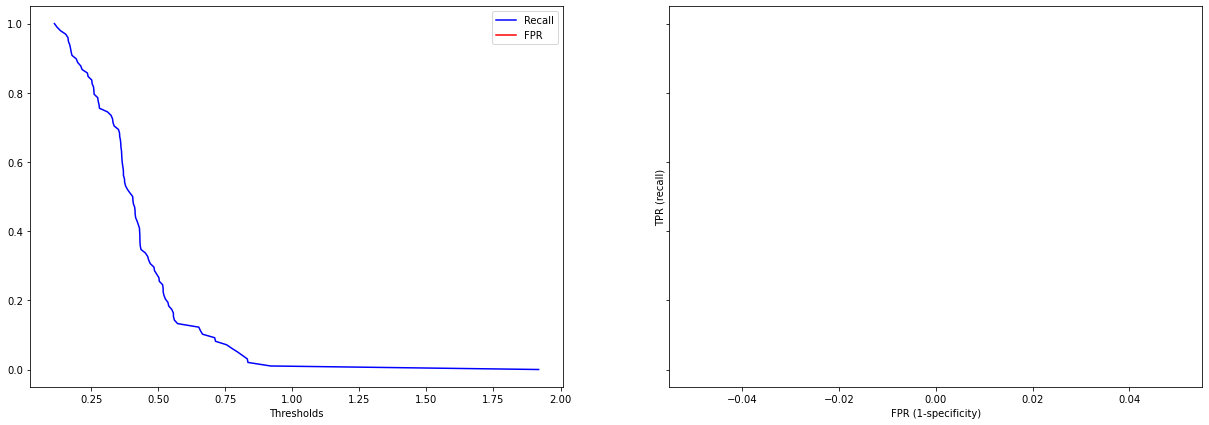

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.692991  0.591466   0.742410     0.794470  0.658110  0.755571
Validation  0.678211  0.580241   0.726198     0.776531  0.643271  0.733679

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009265  0.020642   0.014655     0.018875  0.012975  0.006396
Validation  0.022555  0.043129   0.043030     0.055360  0.025868  0.027615

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498985  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.656301  0.520326   0.719074     0.792857   
XGBoost Classifier              0.644054  0.626953   0.649053     0.661224   
SVM                             0.669017  0.487683   0.767515     0.851020   
KNN                             0.632329  0.433735   0.722501     0.831633   
Logistic Regression             0.678211  0.580241   0.726198     0.776531   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.601965  0.718801  
XGBoost Classifier              0.637355  0.696498  
SVM                             0.594393  0.738123  
KNN                             0.540144  0.696439  
Logistic Regression             0.643271  0.733679

Accuracy  \
Dummy Random                    0.49815584103459115-0.49981370211261694   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)     0.641508562491977-0.6710937373111929   
XGBoost Classifier                 0.6183073999644763-0.669799924183457   
SVM                               0.6509656424204001-0.6870691654113622   
KNN                                0.6125973396762495-0.652061315664059   
Logistic Regression               0.6639462550088312-0.6924766187091839   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.4912581891008591-0.5493932229791245   
XGBoost Classifier              0.5871866222931851-0.6667197887560831   
SVM                             0.4495218025094016-0.5258441014279311   
KNN                             0.3978787630172157-0.4695918615962661   
Logistic Regression             0.5529642153522778-0.6075181594158112   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6925768524591084-0.7455717101231006   
XGBoost Classifier              0.6251860709242273-0.6729201859803541   
SVM                             0.7433261092946717-0.7917042385636361   
KNN                             0.6911279267885319-0.7538738211577579   
Logistic Regression             0.6989829421088303-0.7534126701672506   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.760510221964711-0.8252040637495749   
XGBoost Classifier              0.6425200992042619-0.6799288803875749   
SVM                              0.829040143644349-0.8730006726821816   
KNN                             0.8063159264409137-0.8569493796815351   
Logistic Regression             0.7415180701157613-0.8115431543740348   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5821277030586093-0.6218032690857366   
XGBoost Classifier              0.6063627435478277-0.6683479910580691   
SVM                             0.5620374294488816-0.6267476408316107   
KNN                             0.5073211498196513-0.5729664227201925   
Logistic Regression             0.6269108003556747-0.6596310465843735   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)   0.703057935375792-0.7345435059428504  
XGBoost Classifier              0.6697519382436162-0.7232440356561477  
SVM                             0.7261529441915934-0.7500924333657376  
KNN                             0.6790159657661378-0.7138620017473981  
Logistic Regression             0.7162139585959242-0.7511439183829438

In [196]:
#ra_symptoms_nvitals_ex
run_models(ra_symptoms_nvitals_ex, y[ra_symptoms_nvitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


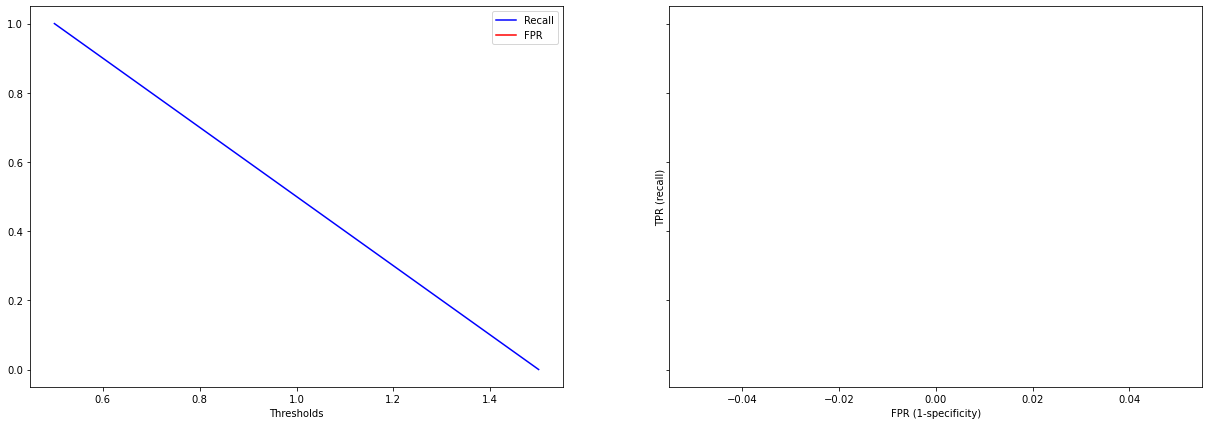

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500113     0.0        0.0          1.0  0.0      0.5
Validation  0.498985     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000146     0.0        0.0          0.0  0.0      0.0
Validation  0.001311     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


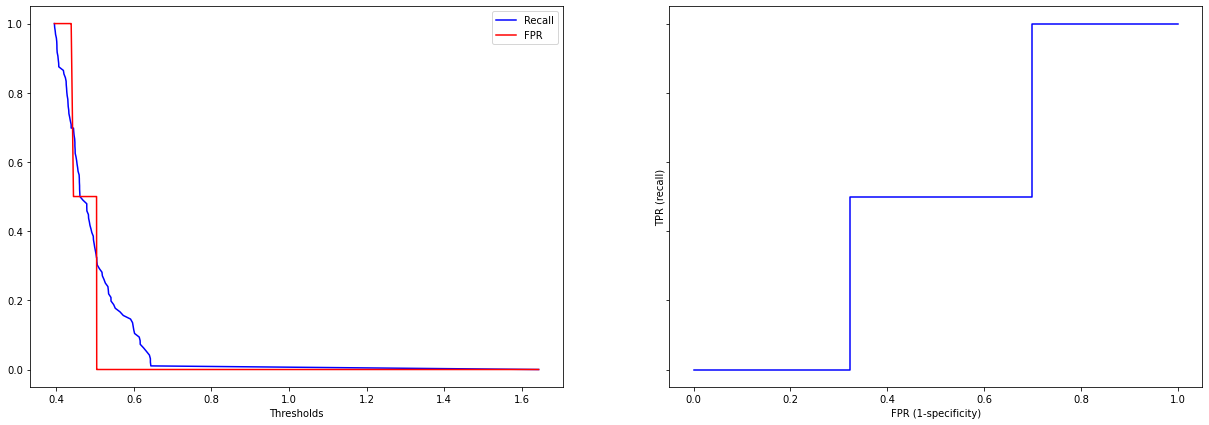

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.671427  0.543584   0.730533     0.799210  0.623114  0.730453
Validation  0.660370  0.526397   0.722594     0.794898  0.607475  0.706632

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003146  0.015072   0.010864     0.015589  0.007178  0.004777
Validation  0.027099  0.049432   0.043536     0.048450  0.037562  0.024881

XGBoost Classifier
╠■■■■■■■■■╣


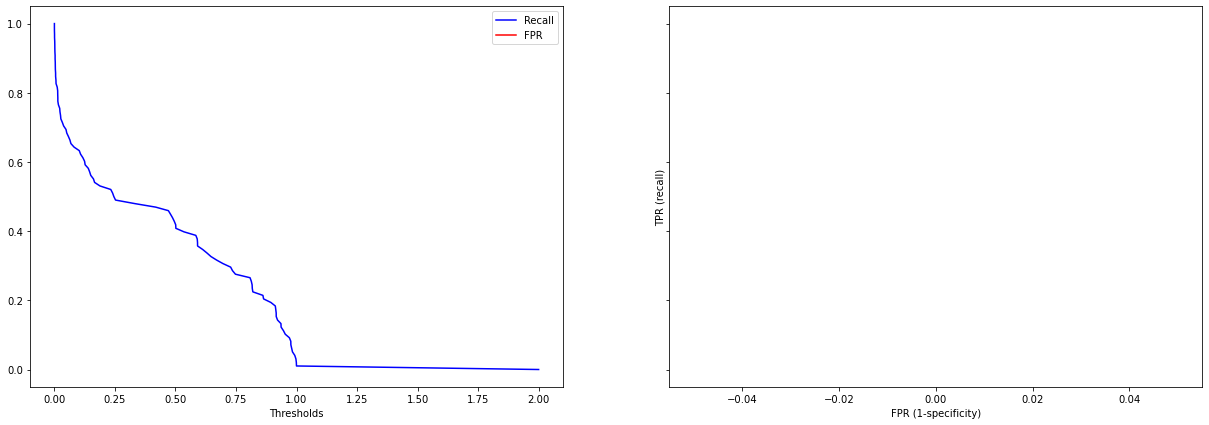

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    1.000000  1.000000   1.000000     1.000000  1.000000  1.000000
Validation  0.643585  0.641239   0.646239     0.645918  0.643287  0.693516

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000000  0.000000     0.0000     0.000000  0.000000  0.000000
Validation  0.026197  0.026965     0.0319     0.045137  0.023219  0.020372

SVM
╠■■■■■■■■■╣


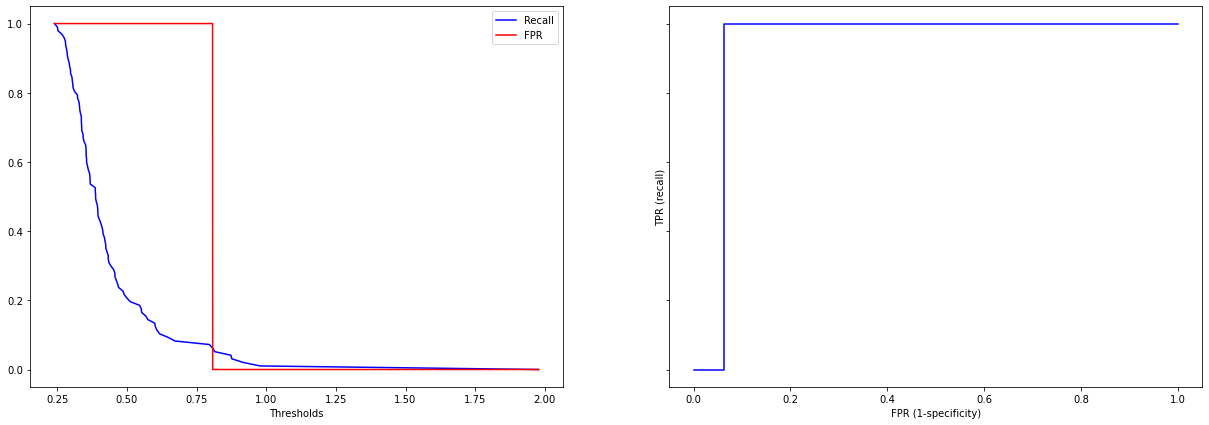

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679951  0.514795   0.768928     0.845034  0.616263  0.748594
Validation  0.679234  0.503999   0.776185     0.855102  0.608587  0.756357

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009363  0.025780   0.013706     0.016051  0.017999  0.010709
Validation  0.038903  0.079403   0.033955     0.026696  0.066573  0.020559

KNN
╠■■■■■■■■■╣


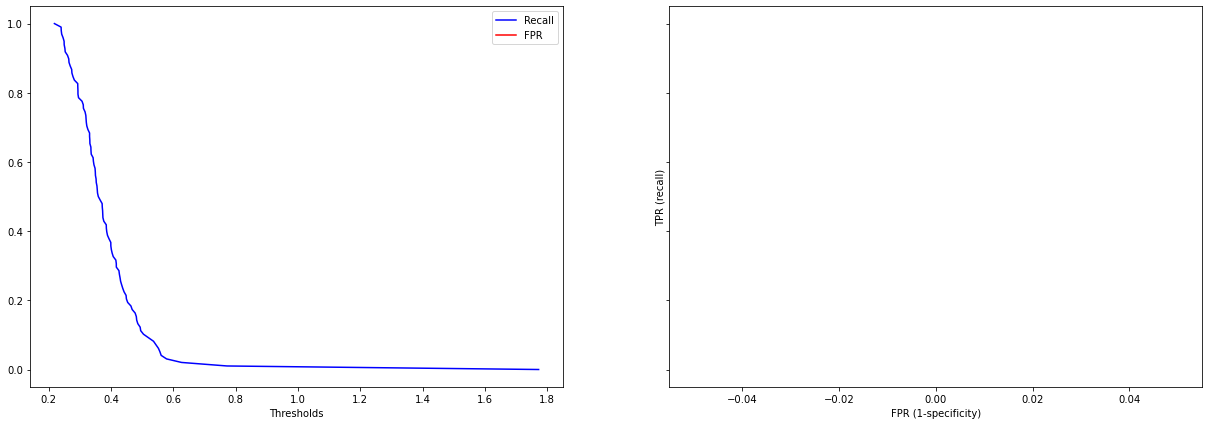

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999944  0.999887   1.000000     1.000000  0.999943  1.000000
Validation  0.632855  0.425685   0.729853     0.840816  0.536093  0.687492

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000179  0.000357   0.000000     0.000000  0.000179  2.016476e-07
Validation  0.025476  0.050333   0.043583     0.033048  0.045050  3.681058e-02

Logistic Regression
╠■■■■■■■■■╣


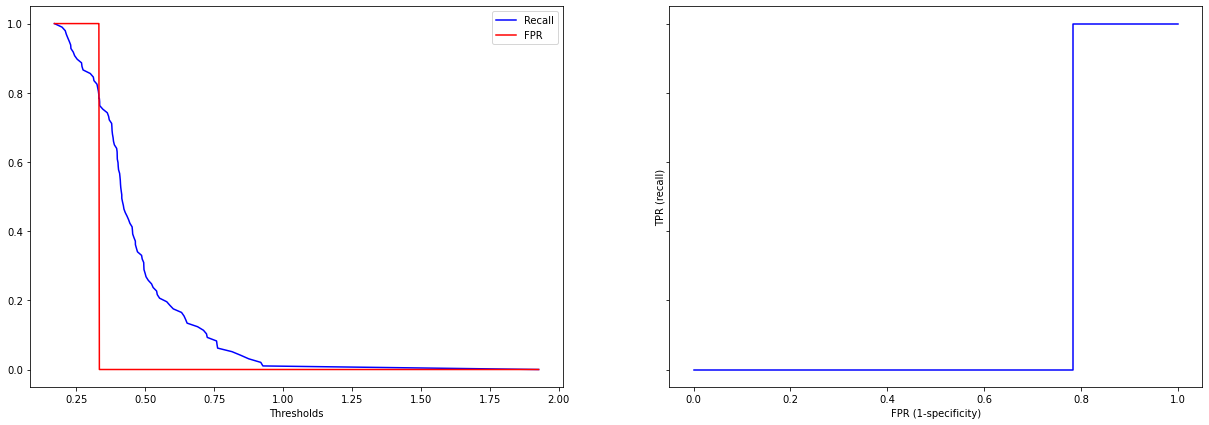

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.691635  0.594630   0.737736     0.788600  0.658413  0.754039
Validation  0.672063  0.579159   0.712506     0.765306  0.638347  0.732470

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007444  0.012906   0.010103     0.011362  0.009396  0.007973
Validation  0.031699  0.047382   0.037668     0.034687  0.040199  0.031000

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498985  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.660370  0.526397   0.722594     0.794898   
XGBoost Classifier              0.643585  0.641239   0.646239     0.645918   
SVM                             0.679234  0.503999   0.776185     0.855102   
KNN                             0.632855  0.425685   0.729853     0.840816   
Logistic Regression             0.672063  0.579159   0.712506     0.765306   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.607475  0.706632  
XGBoost Classifier              0.643287  0.693516  
SVM                             0.608587  0.756357  
KNN                             0.536093  0.687492  
Logistic Regression             0.638347  0.732470

Accuracy  \
Dummy Random                    0.49815584103459115-0.49981370211261694   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)     0.643231092112531-0.6775085743124145   
XGBoost Classifier                 0.6270163731634162-0.660153418611162   
SVM                               0.6546298872764058-0.7038389825050091   
KNN                                   0.61674268128497-0.64896746063982   
Logistic Regression               0.6520150686617211-0.6921111097284168   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)  0.49513281958564853-0.5576604189218755   
XGBoost Classifier               0.6241850455726842-0.6582927940480124   
SVM                             0.45378046299163455-0.5542178878638592   
KNN                             0.3938521780963814-0.45751867327446993   
Logistic Regression               0.5491918350618188-0.609126037541768   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6950587771369225-0.7501282730627996   
XGBoost Classifier                0.62606408180665-0.6664141860457183   
SVM                             0.7547098492900108-0.7976601246014687   
KNN                             0.7022889575397444-0.7574172402430357   
Logistic Regression              0.688682516325026-0.7363289658752165   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.764255494885564-0.8255404234817827   
XGBoost Classifier               0.6173712445464528-0.674465490147425   
SVM                              0.8382181310938899-0.871985950538763   
KNN                             0.8199152496656636-0.8617174033955608   
Logistic Regression             0.7433680061270788-0.7872442387708803   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5837187749445076-0.6312318453748538   
XGBoost Classifier              0.6286027807396862-0.6579721654408105   
SVM                             0.5664824711995088-0.6506919907066059   
KNN                               0.507601409883441-0.564585281151592   
Logistic Regression              0.612923207698202-0.6637714676828262   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)   0.690895884878671-0.7223681591433906  
XGBoost Classifier              0.6806315955144239-0.7063999023042459  
SVM                             0.7433536881490367-0.7693593438788641  
KNN                              0.664211106716169-0.7107732222040198  
Logistic Regression             0.7128642004349631-0.7520765439518454

In [197]:
#ra_symptoms_svitals_ex
run_models(ra_symptoms_svitals_ex, y[ra_symptoms_svitals_ex.index], models, ratio_negatives_to_positives=1)

Notes:

I made a pass through all the metrics selecting the best algorithm for each one. Then, for the ones with notes I look at the recall and if the note is not satisfactory, I look for the second best. 
Repeat the process untill we find the real best metric.

|Best Metric|Model|Dataset|Value|Cons|
| :-| -: | -: | -: | -: |
|Accuracy| Logistic Regression|ra_symptoms_svitals_ex| 0.684209| None |
|Recall | XGBoost | ra_symptoms_vitals_ex |0.614604| Average everywhere else (but above .5)|
|Precision | SVM | ra_symptoms_vitals | 0.775354 | Recall below .5 (but above .4)|
|Specificity | SVM | ra_symptoms_vitals | 0.863303 | Recall below .5 (but above.4) |
|F1 Score | Logistic Regression |ra_symptoms_svitals_ex| 0.646409 | None |
|ROC_AUC Score | Logistic Regression | ra_symptoms_svitals_ex | 0.742775 | None |

Logistic Regression with ra_symptoms_svitals_ex seems to be the best.

In [266]:
selected_features = ["wheezes", "ctab", "labored_respiration", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "sob", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever"]
selected_dataset = pd.merge(ra_symptoms_svitals_ex[selected_features], X[["asthma", "smoker", "diabetes"]], left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


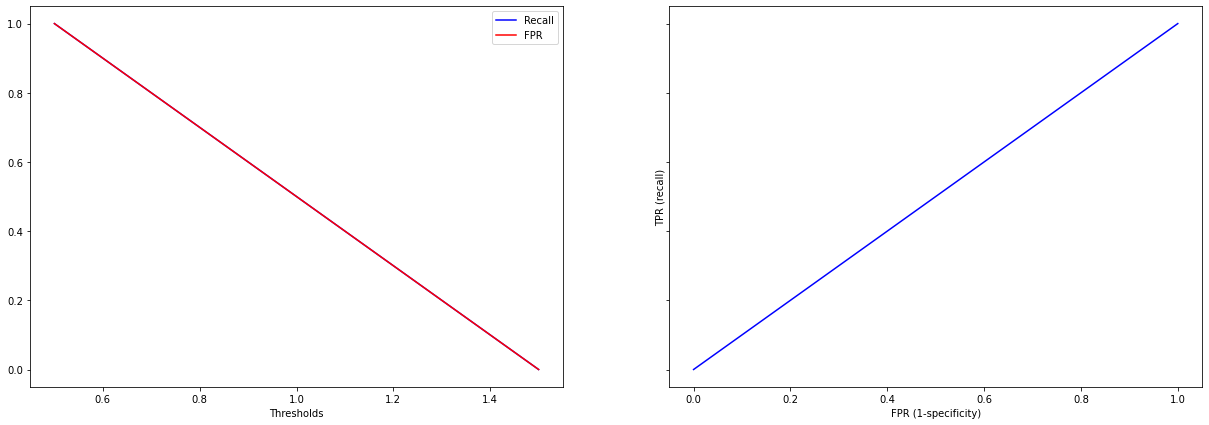

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500113     0.0        0.0          1.0  0.0      0.5
Validation  0.498985     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000146     0.0        0.0          0.0  0.0      0.0
Validation  0.001311     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


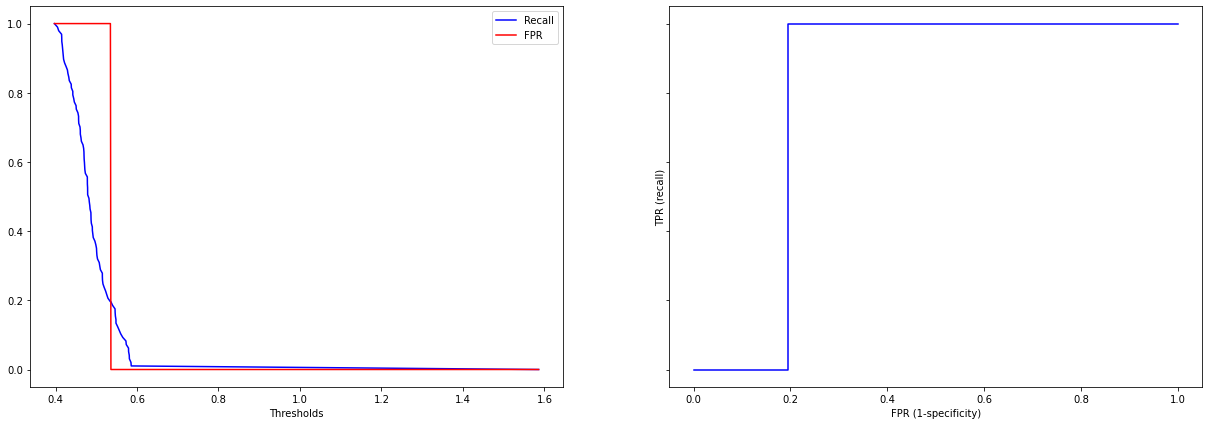

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664031  0.574413   0.700135     0.753612  0.630887  0.725153
Validation  0.658363  0.574160   0.692408     0.742857  0.626899  0.716416

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008486  0.012797   0.015745     0.020414  0.008196  0.006043
Validation  0.027538  0.044867   0.035097     0.041042  0.034144  0.025468

XGBoost Classifier
╠■■■■■■■■■╣


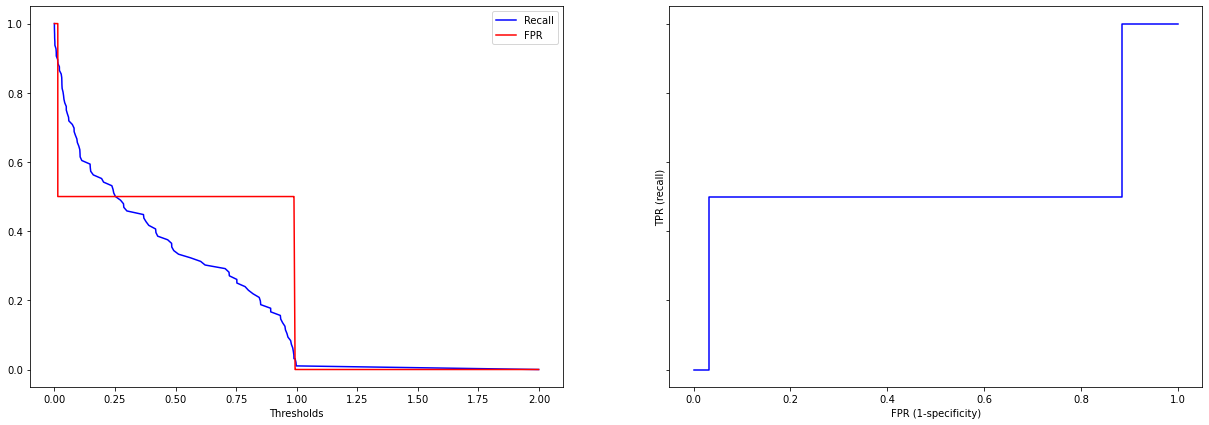

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.976349  0.969850   0.982616     0.982844  0.976179  0.998270
Validation  0.624208  0.607607   0.629970     0.640816  0.617380  0.674538

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004645  0.007494   0.003955     0.003939  0.004747  0.000553
Validation  0.023612  0.056261   0.025581     0.048054  0.033097  0.032748

SVM
╠■■■■■■■■■╣


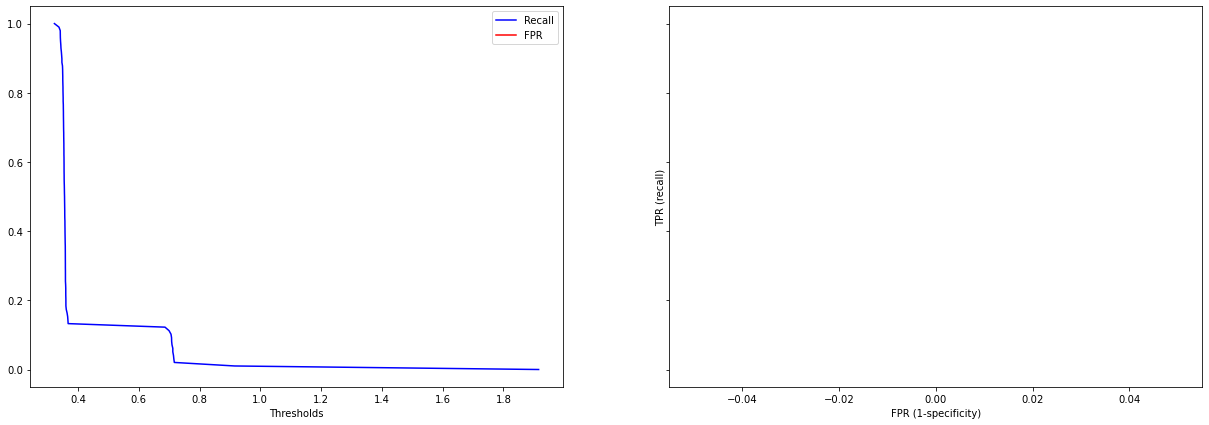

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.670693  0.496156   0.763256     0.845147  0.600612  0.736416
Validation  0.664944  0.506050   0.742626     0.824490  0.599577  0.723061

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006358  0.027941   0.019782     0.024112  0.016146  0.014021
Validation  0.034314  0.075063   0.035677     0.031100  0.058873  0.030846

KNN
╠■■■■■■■■■╣


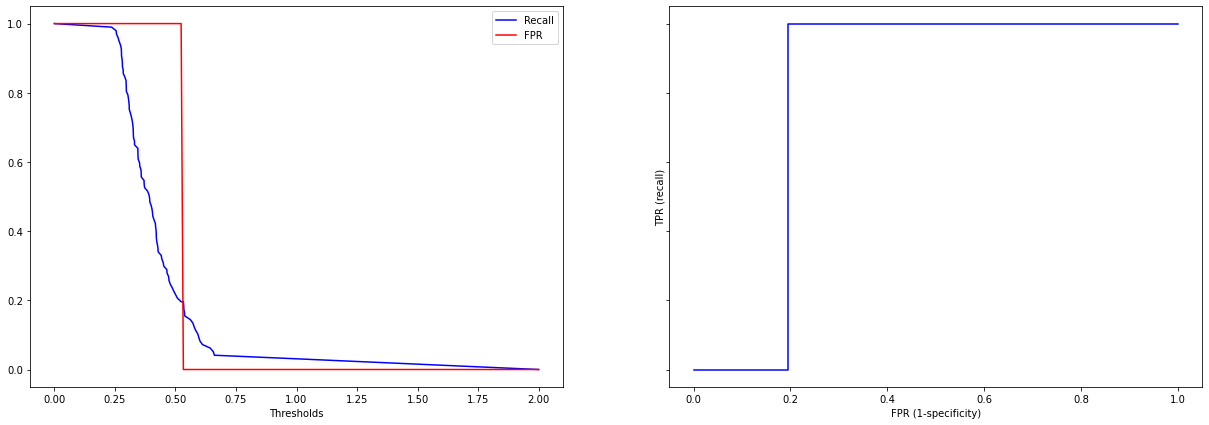

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.983631  0.968609   0.998604     0.998646  0.983374  0.999452
Validation  0.625756  0.472480   0.683309     0.779592  0.556843  0.673837

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002010  0.003904   0.001198     0.001166  0.002070  0.000133
Validation  0.023034  0.059455   0.028390     0.037937  0.042691  0.030466

Logistic Regression
╠■■■■■■■■■╣


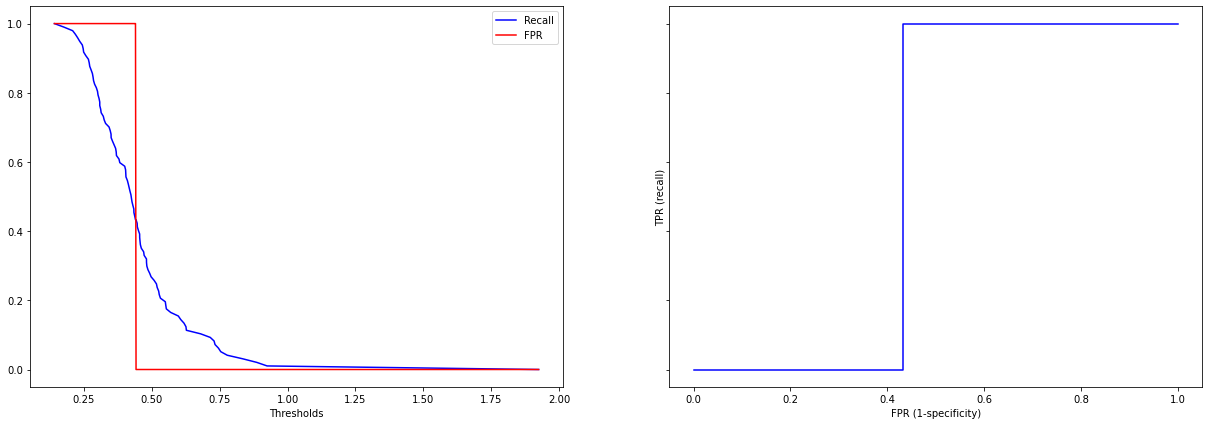

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.690505  0.585588   0.741009     0.795372  0.654114  0.748988
Validation  0.678204  0.580251   0.726413     0.776531  0.642148  0.734627

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005828  0.013027   0.006943     0.008380  0.008778  0.006339
Validation  0.016668  0.064179   0.036507     0.056804  0.033098  0.026086

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498985  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.658363  0.574160   0.692408     0.742857   
XGBoost Classifier              0.624208  0.607607   0.629970     0.640816   
SVM                             0.664944  0.506050   0.742626     0.824490   
KNN                             0.625756  0.472480   0.683309     0.779592   
Logistic Regression             0.678204  0.580251   0.726413     0.776531   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.626899  0.716416  
XGBoost Classifier              0.617380  0.674538  
SVM                             0.599577  0.723061  
KNN                             0.556843  0.673837  
Logistic Regression             0.642148  0.734627

Accuracy  \
Dummy Random                    0.49815584103459115-0.49981370211261694   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)    0.6409461259253644-0.6757792444258219   
XGBoost Classifier                0.6092740964811312-0.6391409040368425   
SVM                               0.6432413186426724-0.6866457630935754   
KNN                               0.6111882137581596-0.6403242694076957   
Logistic Regression               0.6676620103430045-0.6887453241644025   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.5457835800209968-0.602536354013223   
XGBoost Classifier               0.5720239870968769-0.643189370973624   
SVM                             0.4585764167103488-0.5535241811045348   
KNN                             0.4348773996813613-0.5100824024212981   
Logistic Regression             0.5396613466535495-0.6208416424208681   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6702106846763929-0.7146050719457395   
XGBoost Classifier              0.6137916163778058-0.6461493746042116   
SVM                              0.7200619320133737-0.765190040297502   
KNN                             0.6653540411002477-0.7012647515302148   
Logistic Regression              0.703323792509824-0.7495019912072763   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)     0.7168996135668858-0.7688146721474   
XGBoost Classifier              0.6104240708793351-0.6712085821818894   
SVM                              0.804820636333604-0.8441589555031305   
KNN                             0.7555983781108185-0.8035852953585693   
Logistic Regression               0.7406047729890861-0.81245645150071   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6053048832992467-0.6484934505642197   
XGBoost Classifier              0.5964479888689969-0.6383125123503817   
SVM                             0.5623423072735948-0.6368114066200324   
KNN                             0.5298430123689064-0.5838428382307836   
Logistic Regression             0.6212149120390548-0.6630808414666046   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.7003083058765325-0.7325232373777515  
XGBoost Classifier              0.6538258934160208-0.6952493025250646  
SVM                             0.7035519982736071-0.7425697775857782  
KNN                             0.6545682970330204-0.6931047053775914  
Logistic Regression             0.7181284577060094-0.7511247785297341

In [203]:
run_models(selected_dataset, y[selected_dataset.index], models, ratio_negatives_to_positives=1)


╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42000000000000004
╠■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■╣
Threshold: 0.46
╠■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.52
╠■■■■■■■■■╣
Threshold: 0.54
╠■■■■■■■■■╣
Threshold: 0.56
╠■■■■■■■■■╣
Threshold: 0.58
╠■■■■■■■■■╣
Threshold: 0.6


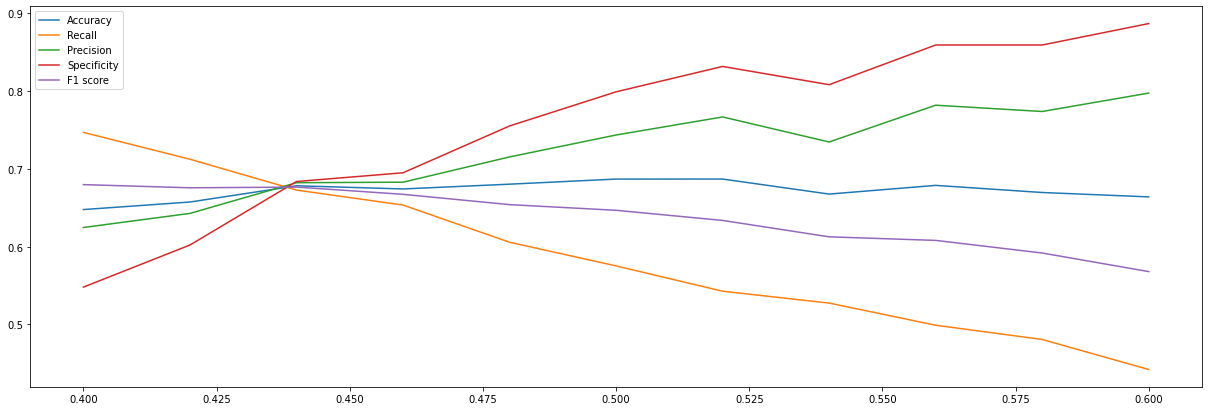

0.40      0.42      0.44      0.46      0.48      0.50  \
Accuracy     0.647638  0.657316  0.678196  0.674127  0.680263  0.686820   
Recall       0.746846  0.712327  0.672686  0.653422  0.605617  0.575201   
Precision    0.624583  0.642699  0.682163  0.682803  0.715297  0.743488   
Specificity  0.547959  0.602041  0.683673  0.694898  0.755102  0.798980   
F1           0.679694  0.675606  0.676538  0.667222  0.653968  0.646687   

                 0.52      0.54      0.56      0.58      0.60  
Accuracy     0.686856  0.667531  0.678709  0.669551  0.663931  
Recall       0.542641  0.527386  0.498928  0.480612  0.442002  
Precision    0.766691  0.734500  0.781797  0.773711  0.797390  
Specificity  0.831633  0.808163  0.859184  0.859184  0.886735  
F1           0.633657  0.612566  0.607977  0.591763  0.567884

In [212]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(.4,.6,num=11))

With the dataset <b>selected_features</b> and a threshold of <b>.44</b> (for high recall), <b>Logistic Regression</b> seems to be the best out of all algorithms

In [205]:
logistic_model_group = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



LogisticVanilla
╠■■■■■■■■■╣


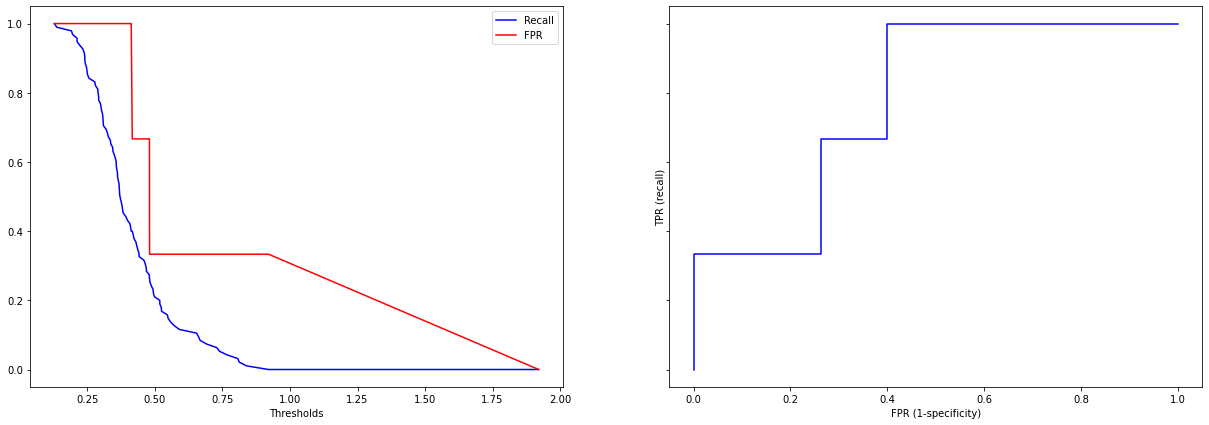

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.693329  0.589657   0.744039     0.796953  0.657784  0.752579
Validation  0.679727  0.585364   0.724140     0.774490  0.645348  0.731350

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010388  0.013966   0.016354     0.017063  0.011456  0.009353
Validation  0.024520  0.063359   0.031636     0.044725  0.039350  0.012685

LogisticStrongRegularization
╠■■■■■■■■■╣


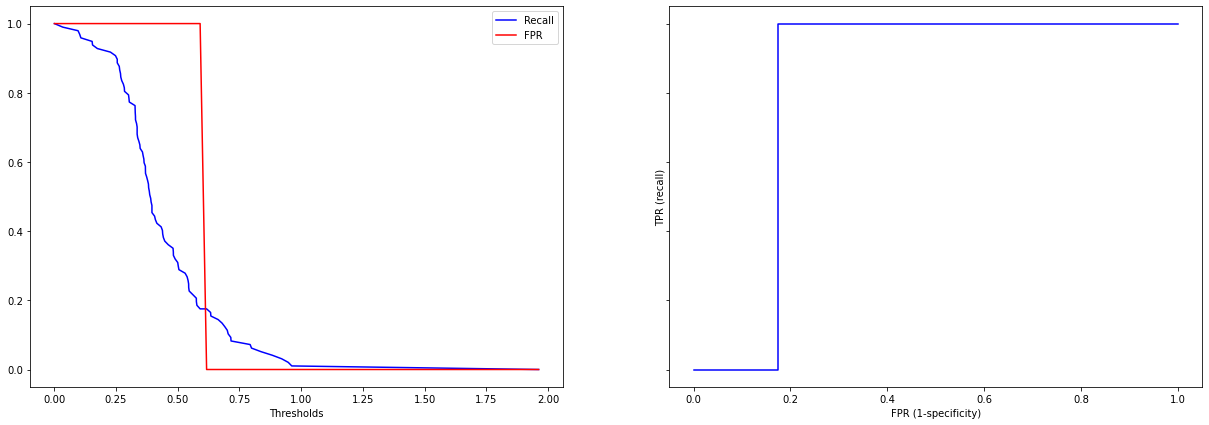

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.693046  0.596207   0.739561     0.789842  0.660051  0.753841
Validation  0.680276  0.582272   0.730183     0.778571  0.645385  0.739497

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009306  0.013891   0.015007     0.016849  0.010448  0.005784
Validation  0.034298  0.055650   0.060172     0.067695  0.038990  0.013260

LogisticWeakRegularization
╠■■■■■■■■■╣


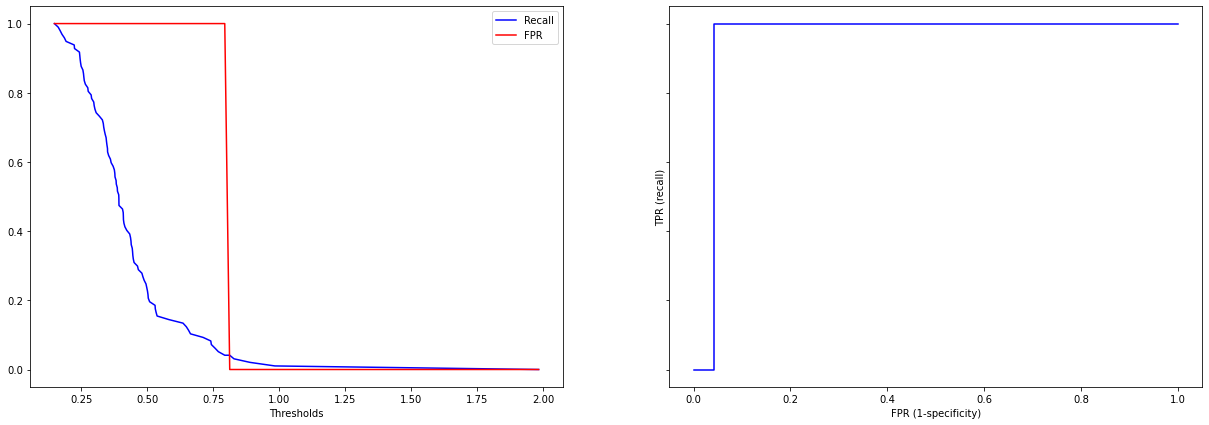

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.690393  0.589883   0.738312     0.790858  0.655711  0.751332
Validation  0.682257  0.588415   0.726002     0.776531  0.648900  0.737722

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005502  0.011232   0.009341     0.011754  0.007019  0.005289
Validation  0.038163  0.059088   0.047562     0.044725  0.048496  0.032849

AdaBoost
╠■■■■■■■■■╣


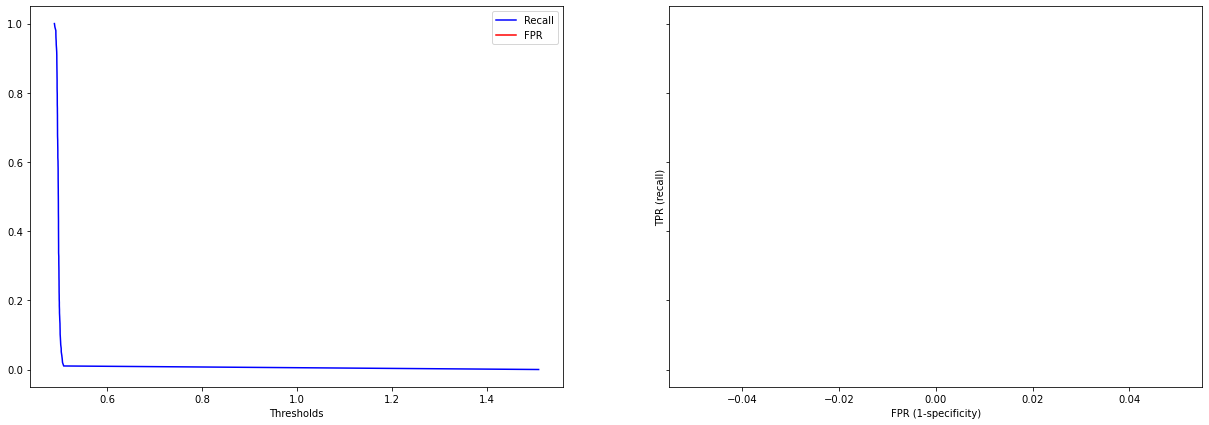

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.687740  0.611336   0.721785     0.764108  0.661850  0.742680
Validation  0.677217  0.600629   0.711778     0.754082  0.650118  0.729931

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008542  0.011946   0.014225     0.018308  0.008324  0.006285
Validation  0.029476  0.052631   0.037217     0.044983  0.037004  0.023470

Accuracy    Recall  Precision  Specificity  \
LogisticVanilla               0.679727  0.585364   0.724140     0.774490   
LogisticStrongRegularization  0.680276  0.582272   0.730183     0.778571   
LogisticWeakRegularization    0.682257  0.588415   0.726002     0.776531   
AdaBoost                      0.677217  0.600629   0.711778     0.754082   

                                    F1   ROC_AUC  
LogisticVanilla               0.645348  0.731350  
LogisticStrongRegularization  0.645385  0.739497  
LogisticWeakRegularization    0.648900  0.737722  
AdaBoost                      0.650118  0.729931

Accuracy  \
LogisticVanilla                0.664218998610629-0.6952340211759658   
LogisticStrongRegularization  0.6585839096591353-0.7019672143437654   
LogisticWeakRegularization     0.658120251466027-0.7063933712419393   
AdaBoost                      0.6585748423440143-0.6958590124161637   

                                                             Recall  \
LogisticVanilla               0.5452919922457421-0.6254356927676571   
LogisticStrongRegularization  0.5470756193067305-0.6174677738080911   
LogisticWeakRegularization    0.5510439188432246-0.6257856008434382   
AdaBoost                      0.5673422795845956-0.6339151931014487   

                                                          Precision  \
LogisticVanilla                0.704132172494957-0.7441487914125131   
LogisticStrongRegularization  0.6921263786234189-0.7682388643577913   
LogisticWeakRegularization    0.6959207886203826-0.7560828852601089   
AdaBoost                      0.6882400283619361-0.7353160018410656   

                                                        Specificity  \
LogisticVanilla               0.7462032341683106-0.8027763576684243   
LogisticStrongRegularization  0.7357574993807905-0.8213853577620669   
LogisticWeakRegularization    0.7482440504948411-0.8048171739949548   
AdaBoost                       0.725631940590032-0.7825313247160905   

                                                                 F1  \
LogisticVanilla                0.6204612310514136-0.670234901379363   
LogisticStrongRegularization   0.6207253850638992-0.670044797133738   
LogisticWeakRegularization     0.6182282669211634-0.679571086507526   
AdaBoost                      0.6267146397261691-0.6735210669269591   

                                                            ROC_AUC  
LogisticVanilla               0.7233276729259089-0.7393726329230849  
LogisticStrongRegularization  0.7311103304421165-0.7478834810589836  
LogisticWeakRegularization    0.7169461997578428-0.7584975337033832  
AdaBoost                      0.7150870189568638-0.7447742972455601

In [210]:
run_models(selected_dataset, y[selected_dataset.index], logistic_model_group, folds=10, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42000000000000004
╠■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■╣
Threshold: 0.46
╠■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.52
╠■■■■■■■■■╣
Threshold: 0.54
╠■■■■■■■■■╣
Threshold: 0.56
╠■■■■■■■■■╣
Threshold: 0.58
╠■■■■■■■■■╣
Threshold: 0.6


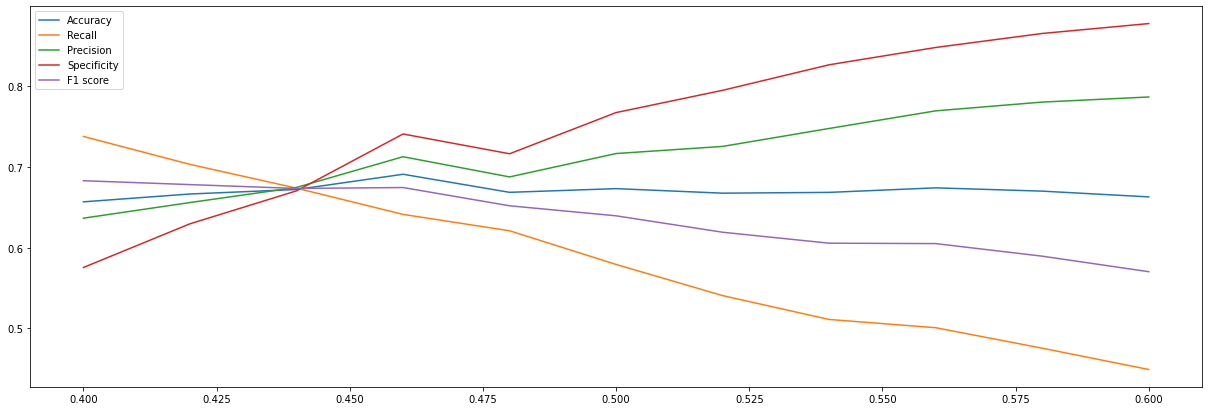

0.40      0.42      0.44      0.46      0.48      0.50  \
Accuracy     0.656793  0.666497  0.672076  0.690933  0.668564  0.673140   
Recall       0.737734  0.703185  0.673727  0.641239  0.620965  0.579262   
Precision    0.636562  0.655910  0.674614  0.712650  0.687650  0.716607   
Specificity  0.575510  0.629592  0.670408  0.740816  0.716327  0.767347   
F1           0.682935  0.678139  0.673364  0.674503  0.651902  0.639471   

                 0.52      0.54      0.56      0.58      0.60  
Accuracy     0.667518  0.668494  0.674114  0.670046  0.662910  
Recall       0.540662  0.511111  0.500907  0.475562  0.449145  
Precision    0.725430  0.747652  0.769465  0.780323  0.786641  
Specificity  0.794898  0.826531  0.847959  0.865306  0.877551  
F1           0.619144  0.605572  0.605076  0.589495  0.570268

In [211]:
run_threshold(selected_dataset, y[selected_dataset.index], logistic_model_group["LogisticWeakRegularization"], thresholds=np.linspace(.4,.6,num=11))

In [276]:
imputer = Imputer()
imputer.fit_transform(selected_dataset, y[selected_dataset.index])
imp_x = test_x[selected_dataset.columns].copy()
imputer.transform(imp_x)
lr = LogisticRegression(C=2)

train_x = pd.concat([selected_dataset[y[selected_dataset.index] == "Positive"], selected_dataset[y[selected_dataset.index] == "Negative"].sample((selected_dataset[y[selected_dataset.index] == "Positive"]).shape[0])])
lr.fit(train_x, y[train_x.index])
t_preds = lr.predict_proba(train_x)
t_preds = pd.cut(t_preds[:,1], [-1, .44, 1.1], labels=["Negative", "Positive"], right=False)
preds = lr.predict_proba(imp_x)
preds = pd.cut(preds[:,1], [-1, .44, 1.1], labels=["Negative", "Positive"], right=False)
pd.DataFrame([get_metrics(y[train_x.index], t_preds), get_metrics(test_y, preds)], index=["Training Data", "Validation Data"], columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"])

Accuracy    Recall  Precision  Specificiy        F1
Training Data    0.686265  0.678269   0.689293    0.694262  0.683736
Validation Data  0.057640  0.977099   0.025615    0.033737  0.049922

It still seems to perform poorly on unseen data

## Ensemble models

In [286]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        return final_preds
        
    def predict_proba(self, data_x):
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict_proba(data_1)
        preds_2 = self.model_2.predict_proba(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        final_preds[final_preds == True] = 1 # Not the real probability, but just a placeholder to make the cross_validation method to work
        final_preds[final_preds == False] = 0
        
        final_preds = np.zeros((final_preds.shape[0], 2)) + final_preds #both positive and negative probability will be the same, which is incorrect but for this purpose it doesnt matter
        print(final_preds)
        return np.array(final_preds)

In [287]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
operands could not be broadcast together with shapes (1963,2) (1963,) 


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
FirstEnsembleModel       0.0     0.0        0.0          0.0  0.0      0.0

Accuracy   Recall Precision Specificity       F1  ROC_AUC
FirstEnsembleModel  0.0-0.0  0.0-0.0   0.0-0.0     0.0-0.0  0.0-0.0  0.0-0.0

In [288]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

╠■■■■■■■■■╣
Threshold: 0.25
╠■■■■■■■■■╣
Threshold: 0.275
╠■■■■■■■■■╣
Threshold: 0.3
╠■■■■■■■■■╣
Threshold: 0.325
╠■■■■■■■■■╣
Threshold: 0.35
╠■■■■■■■■■╣
Threshold: 0.375
╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42500000000000004
╠■■■■■■■■■╣
Threshold: 0.45
╠■■■■■■■■■╣
Threshold: 0.475
╠■■■■■■■■■╣
Threshold: 0.5


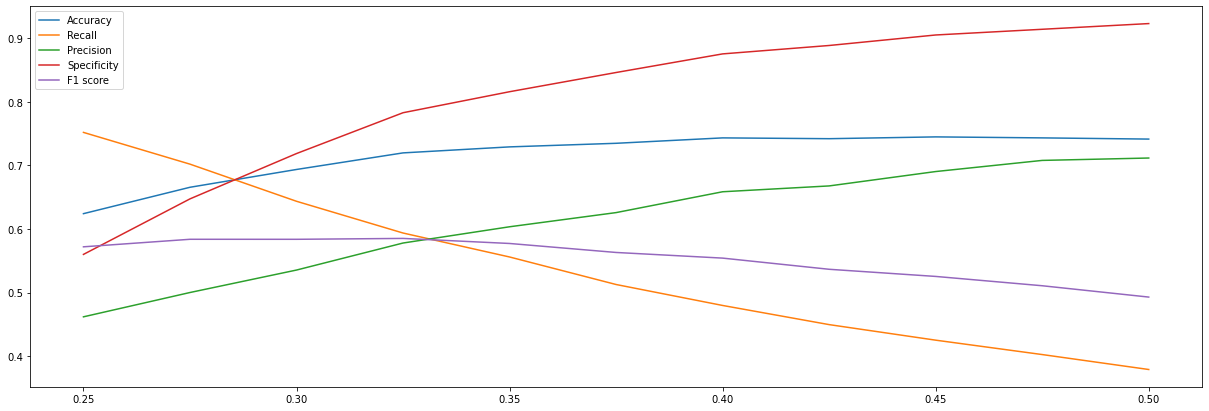

0.250     0.275     0.300     0.325     0.350     0.375  \
Accuracy     0.623937  0.665394  0.693372  0.719429  0.728863  0.734504   
Recall       0.751631  0.701737  0.643370  0.593502  0.555846  0.512590   
Precision    0.461812  0.500018  0.535320  0.577786  0.603328  0.625599   
Specificity  0.559906  0.647170  0.718396  0.782547  0.815566  0.845755   
F1           0.571828  0.583658  0.583631  0.585020  0.577075  0.562952   

                0.400     0.425     0.450     0.475     0.500  
Accuracy     0.743008  0.741742  0.744572  0.743013  0.741124  
Recall       0.479668  0.449559  0.425128  0.402513  0.379025  
Precision    0.658350  0.667515  0.690111  0.707613  0.711361  
Specificity  0.875000  0.888208  0.904717  0.913679  0.922642  
F1           0.554075  0.536517  0.525287  0.510647  0.492843

In [289]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(0.25,0.5,num=11), ratio_negatives_to_positives=2)

In general it seems that normal logistic regression beats all of the other datasets, although by running the experiment multiple times there is no clear winner (all of the results vary a lot to decide a clear winner

In [290]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


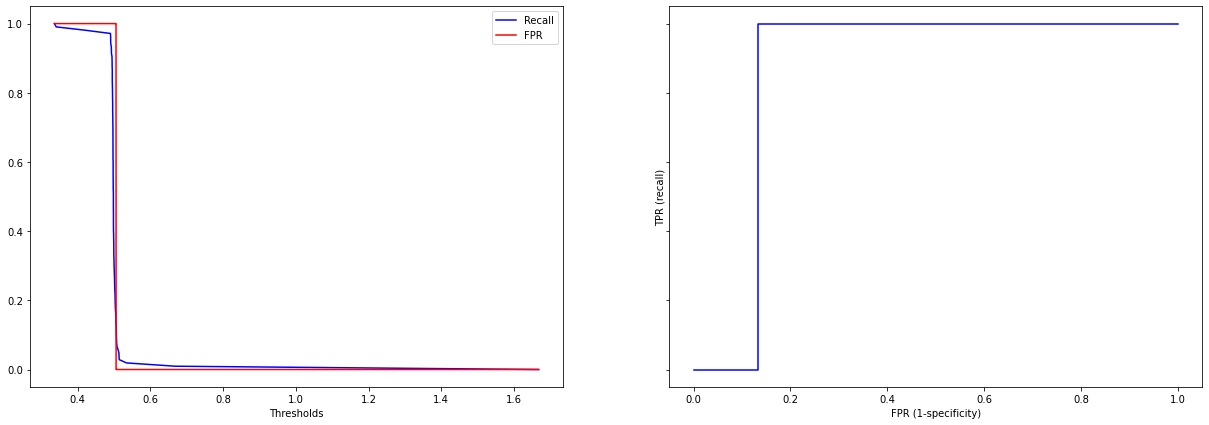

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.694465  0.591823   0.744614     0.797074  0.659336  0.765487
Validation  0.647154  0.557768   0.680742     0.736792  0.612314  0.708836

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008313  0.019543   0.007425     0.008973  0.013230  0.010370
Validation  0.036561  0.050396   0.047104     0.045451  0.043484  0.033457

Ada Logistic
╠■■■■■■■■■╣


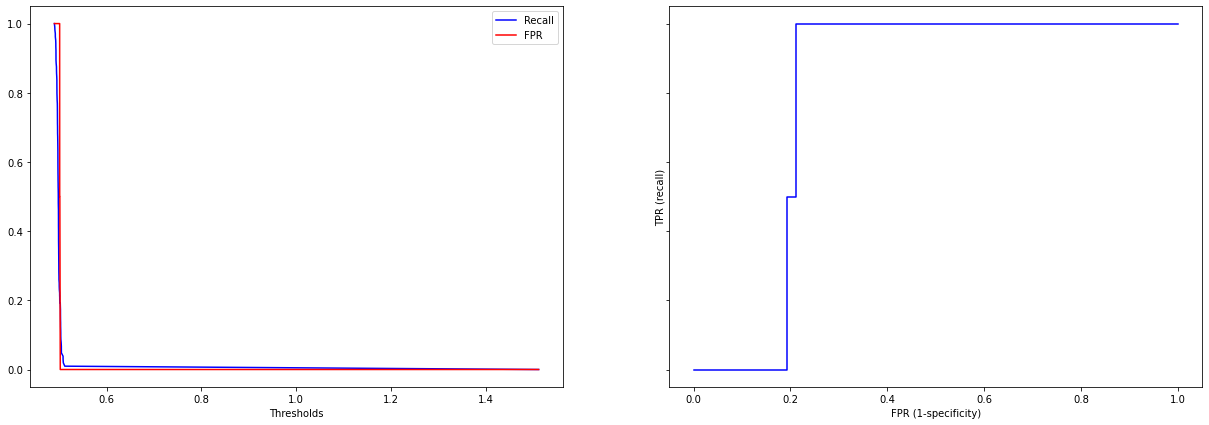

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.681402  0.599348   0.717016     0.763427  0.652805  0.738992
Validation  0.671209  0.595451   0.703198     0.747170  0.644222  0.730327

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006324  0.015436   0.007850     0.011385  0.009639  0.008003
Validation  0.025731  0.039515   0.032636     0.036888  0.030782  0.032729

Ada algo
╠■■■■■■■■■╣


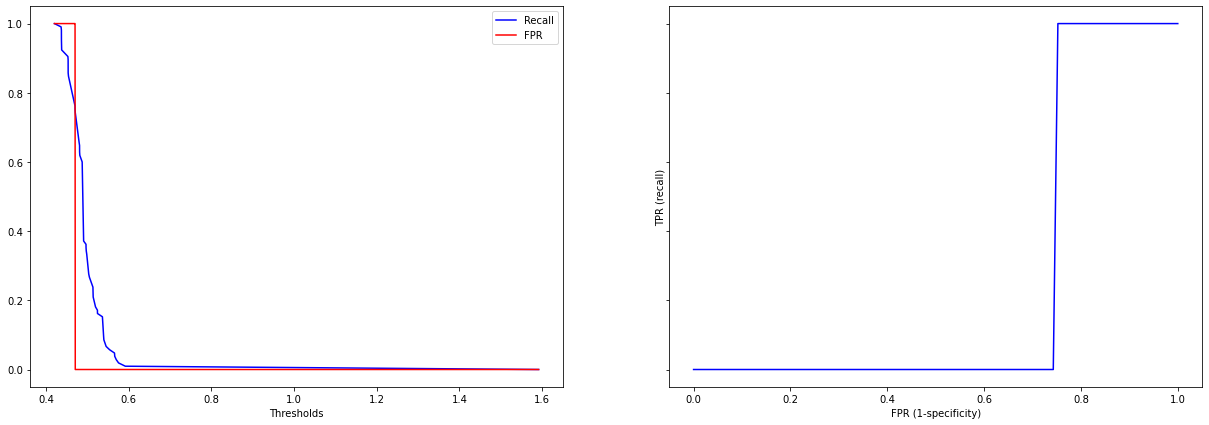

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679313  0.572805   0.729134     0.785789  0.640241  0.740844
Validation  0.660834  0.572747   0.700703     0.749057  0.627850  0.714078

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007974  0.043155   0.018120     0.032775  0.022482  0.005102
Validation  0.026147  0.047628   0.052583     0.064015  0.028522  0.022611

Ada learning rate
╠■■■■■■■■■╣


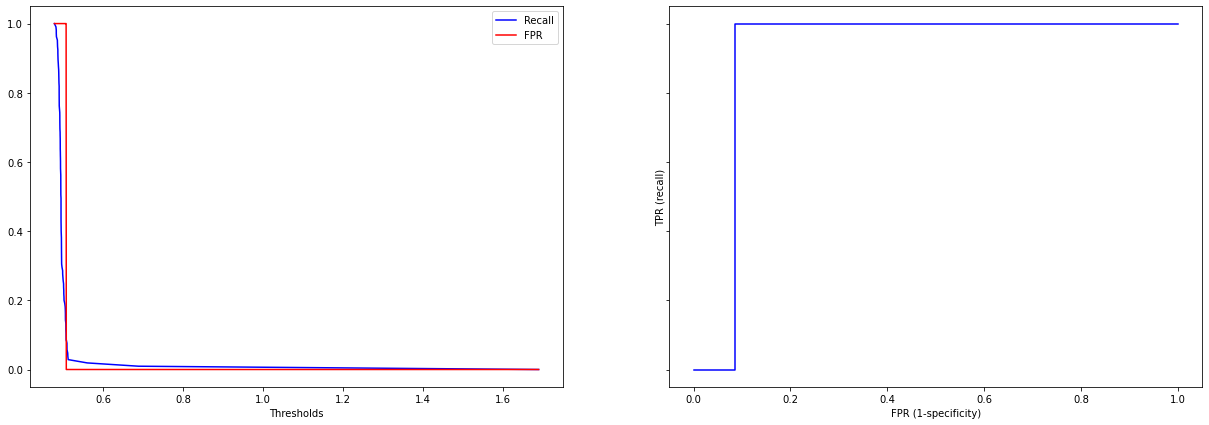

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.692481  0.577293   0.750709     0.807628  0.652314  0.763889
Validation  0.671182  0.559654   0.723436     0.783019  0.630228  0.731751

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007476  0.018373   0.017953     0.022922  0.009431  0.006829
Validation  0.037789  0.040603   0.056761     0.055723  0.040662  0.036600

Ada complete
╠■■■■■■■■■╣


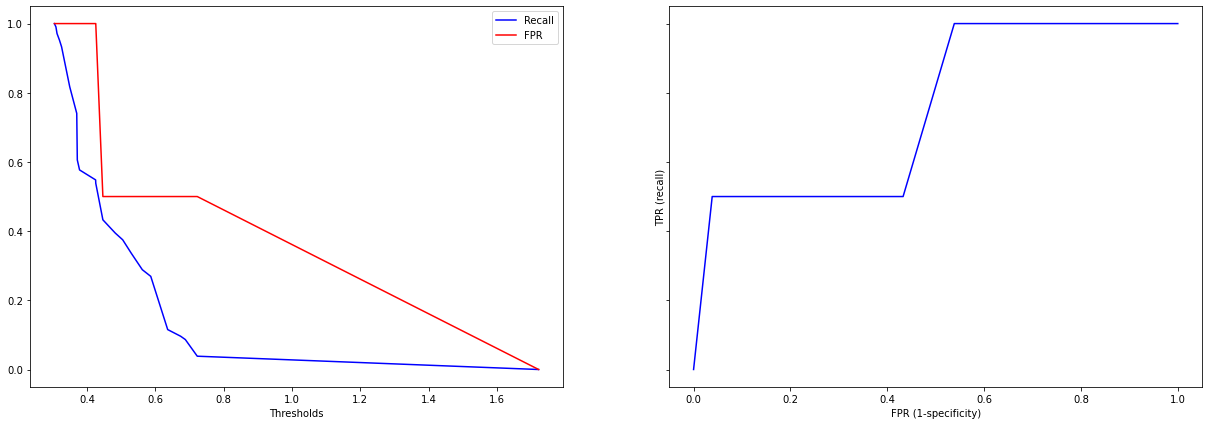

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.672885  0.633633   0.688500     0.712121  0.659475  0.731571
Validation  0.674048  0.631123   0.693166     0.716981  0.659426  0.728573

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.011114  0.018739   0.021217     0.034411  0.007809  0.008598
Validation  0.030631  0.046057   0.042817     0.055188  0.032195  0.033345

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.647154  0.557768   0.680742     0.736792  0.612314   
Ada Logistic       0.671209  0.595451   0.703198     0.747170  0.644222   
Ada algo           0.660834  0.572747   0.700703     0.749057  0.627850   
Ada learning rate  0.671182  0.559654   0.723436     0.783019  0.630228   
Ada complete       0.674048  0.631123   0.693166     0.716981  0.659426   

                    ROC_AUC  
Ada Vanilla        0.708836  
Ada Logistic       0.730327  
Ada algo           0.714078  
Ada learning rate  0.731751  
Ada complete       0.728573

Accuracy  \
Ada Vanilla         0.624030930356258-0.6702776886533975   
Ada Logistic       0.6549350393960162-0.6874823580705441   
Ada algo            0.644296525841298-0.6773705837343948   
Ada learning rate  0.6472823990368574-0.6950818493465246   
Ada complete       0.6546751400918014-0.6934203510943091   

                                                  Recall  \
Ada Vanilla        0.5258945842612949-0.5896405947194844   
Ada Logistic       0.5704591569639279-0.6204419186841061   
Ada algo           0.5426247653161431-0.6028698564436874   
Ada learning rate  0.5339746905356267-0.5853340733508131   
Ada complete       0.6019941713327929-0.6602523460362778   

                                               Precision  \
Ada Vanilla         0.650950777525822-0.7105326221404432   
Ada Logistic        0.6825572605834764-0.723838759640544   
Ada algo           0.6674465697593936-0.7339587737537556   
Ada learning rate  0.6875368256379191-0.7593345737499198   
Ada complete       0.6660864848208715-0.7202463571041832   

                                             Specificity  \
Ada Vanilla        0.7080468053282353-0.7655381003321419   
Ada Logistic       0.7238399534704509-0.7704996691710584   
Ada algo           0.7085698693347644-0.7895433382124051   
Ada learning rate  0.7477762874814543-0.8182614483676022   
Ada complete       0.6820768882377066-0.7518853759132367   

                                                      F1  \
Ada Vanilla         0.5848117649386566-0.639815602242388   
Ada Logistic        0.624753921724009-0.6636900256710001   
Ada algo            0.609811300804399-0.6458896446917948   
Ada learning rate   0.604511706032619-0.6559451526530246   
Ada complete       0.6390638803831804-0.6797878948268926   

                                                 ROC_AUC  
Ada Vanilla        0.6876764539545247-0.7299962968497989  
Ada Logistic       0.7096266344541856-0.7510265397555475  
Ada algo           0.6997778292359274-0.7283784142138652  
Ada learning rate   0.708603153448167-0.7548994233826473  
Ada complete       0.7074839402573043-0.7496621489153481

In [291]:
run_models(selected_dataset, y[selected_dataset.index], ada_configurations, ratio_negatives_to_positives=1)

In [292]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
Input contains NaN
Ada Logistic
Input contains NaN
Ada algo
Input contains NaN
Ada learning rate
Input contains NaN
Ada complete
Input contains NaN


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Ada Vanilla             0.0     0.0        0.0          0.0  0.0      0.0
Ada Logistic            0.0     0.0        0.0          0.0  0.0      0.0
Ada algo                0.0     0.0        0.0          0.0  0.0      0.0
Ada learning rate       0.0     0.0        0.0          0.0  0.0      0.0
Ada complete            0.0     0.0        0.0          0.0  0.0      0.0

Accuracy   Recall Precision Specificity       F1  ROC_AUC
Ada Vanilla        0.0-0.0  0.0-0.0   0.0-0.0     0.0-0.0  0.0-0.0  0.0-0.0
Ada Logistic       0.0-0.0  0.0-0.0   0.0-0.0     0.0-0.0  0.0-0.0  0.0-0.0
Ada algo           0.0-0.0  0.0-0.0   0.0-0.0     0.0-0.0  0.0-0.0  0.0-0.0
Ada learning rate  0.0-0.0  0.0-0.0   0.0-0.0     0.0-0.0  0.0-0.0  0.0-0.0
Ada complete       0.0-0.0  0.0-0.0   0.0-0.0     0.0-0.0  0.0-0.0  0.0-0.0

╠■■■■■■■■■╣
Threshold: 0.49
╠■■■■■■■■■╣
Threshold: 0.491
╠■■■■■■■■■╣
Threshold: 0.492
╠■■■■■■■■■╣
Threshold: 0.493
╠■■■■■■■■■╣
Threshold: 0.494
╠■■■■■■■■■╣
Threshold: 0.495
╠■■■■■■■■■╣
Threshold: 0.496
╠■■■■■■■■■╣
Threshold: 0.497
╠■■■■■■■■■╣
Threshold: 0.498
╠■■■■■■■■■╣
Threshold: 0.499
╠■■■■■■■■■╣
Threshold: 0.5


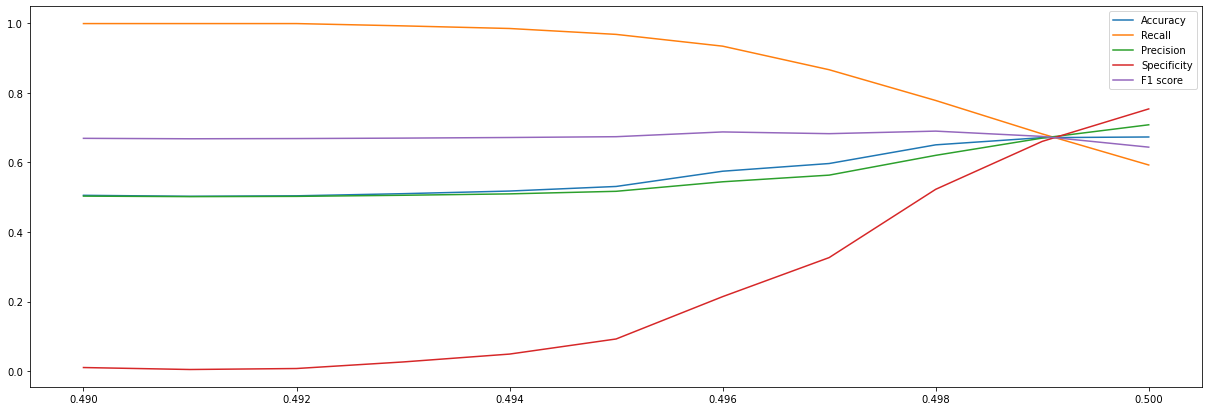

0.490     0.491     0.492     0.493     0.494     0.495  \
Accuracy     0.505415  0.502591  0.503997  0.510116  0.517665  0.530866   
Recall       0.999065  0.999065  0.999057  0.992470  0.984941  0.967995   
Precision    0.503092  0.501657  0.502372  0.505545  0.509537  0.516931   
Specificity  0.010377  0.004717  0.007547  0.026415  0.049057  0.092453   
F1           0.669194  0.667927  0.668555  0.669846  0.671594  0.673896   

                0.496     0.497     0.498     0.499     0.500  
Accuracy     0.574663  0.596802  0.650487  0.671204  0.673082  
Recall       0.934156  0.866390  0.778002  0.681917  0.592559  
Precision    0.544285  0.563441  0.620312  0.669907  0.708139  
Specificity  0.214151  0.326415  0.522642  0.660377  0.753774  
F1           0.687594  0.682614  0.689936  0.674735  0.643858

In [293]:
run_threshold(selected_dataset, y[selected_dataset.index], ada_configurations["Ada Logistic"], thresholds=np.linspace(0.49, 0.50, num=11), ratio_negatives_to_positives=1)

Accuracy    Recall  Precision  Specificity        F1
Metrics  0.710345  0.598485   0.718182     0.803797  0.652893

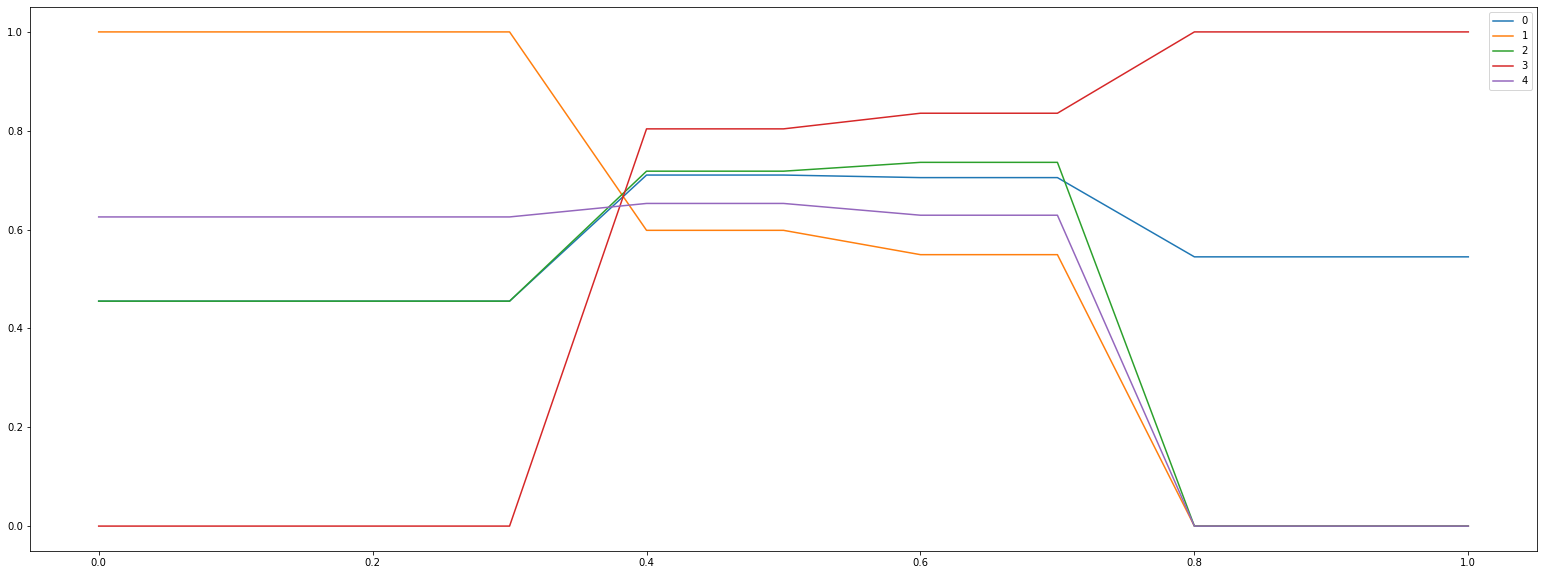

0.0       0.1       0.2       0.3       0.4       0.5  \
Accuracy     0.455172  0.455172  0.455172  0.455172  0.710345  0.710345   
Recall       1.000000  1.000000  1.000000  1.000000  0.598485  0.598485   
Precision    0.455172  0.455172  0.455172  0.455172  0.718182  0.718182   
Specificity  0.000000  0.000000  0.000000  0.000000  0.803797  0.803797   
F1           0.625592  0.625592  0.625592  0.625592  0.652893  0.652893   

                  0.6       0.7       0.8       0.9       1.0  
Accuracy     0.705172  0.705172  0.544828  0.544828  0.544828  
Recall       0.549242  0.549242  0.000000  0.000000  0.000000  
Precision    0.736041  0.736041  0.000000  0.000000  0.000000  
Specificity  0.835443  0.835443  1.000000  1.000000  1.000000  
F1           0.629067  0.629067  0.000000  0.000000  0.000000

In [121]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
from sklearn.model_selection import train_test_split

test_data = pd.concat([selected_dataset[y=="Positive"], selected_dataset[y=="Negative"].sample(np.sum(y=="Positive"))])

X_train, X_test, y_train, y_test = train_test_split(test_data, y[test_data.index])


stack_classifier = StackingCVClassifier([models["Logistic Regression"], ada_configurations["Ada Logistic"]], meta_classifier=RandomForestClassifier())

imp = Imputer()
imp.fit_transform(X_train, y_train)
imp.transform(X_test)

y_train[y_train == "Positive"] = 1
y_train[y_train == "Negative"] = 0
y_train = y_train.astype("float")

stack_classifier.fit(X_train, y_train)

y_preds = stack_classifier.predict(X_test)
y_preds = y_preds.astype("object")
y_preds[y_preds == 1] = "Positive"
y_preds[y_preds == 0] = "Negative"

display(pd.DataFrame(data=np.array(get_metrics(y_test, y_preds)).reshape((1,5)), index=["Metrics"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1"]))

scores = np.ones((11, 5))
thresholds = np.linspace(0, 1, num=11)
i = 0
for threshold in thresholds:
    y_preds = stack_classifier.predict_proba(X_test)
    y_preds = y_preds[:,1]
    y_preds[y_preds >= threshold] = 1
    y_preds[y_preds < 1] = 0
    
    
    
    y_preds = y_preds.astype("object")
    y_preds[y_preds == 1] = "Positive"
    y_preds[y_preds == 0] = "Negative"
    
    scores[i] = get_metrics(y_test, y_preds)
    i+=1

plt.figure(figsize=(27, 10))
for i in range(scores.shape[1]):
    plt.plot(thresholds, scores[:,i], label=i)

plt.legend()
plt.show()
pd.DataFrame(scores.transpose(), index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds)

Apparently stacking and ensemble models do not do much better than regular logistic regression

### SMOTE

In [294]:
models_smote ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    #"SVM" : SVC(kernel='linear', probability=True), #Removed due to getting the notebook stuck
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

In [295]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
ratio_negs_to_pos = (y == "Negative").sum() / (y == "Positive").sum()
weights = ((y == "Positive")* ratio_negs_to_pos * 100) + 1

X_copy = X.copy()
imp = Imputer()
imp.fit_transform(X_copy, y)
run_models(X_copy[selected_features], y, models_smote, ratio_negatives_to_positives=-1, sample_weights=weights)

MultinomialNB
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.853570  0.346488   0.059568     0.865747  0.100993  0.642260
Validation  0.852444  0.347564   0.059762     0.864567  0.101261  0.641389

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.036597  0.061511   0.004941     0.038926  0.005735  0.011454
Validation  0.038004  0.054790   0.009298     0.039925  0.013239  0.024529

Random Forest (100 estimators)
╠■■■■■■■■■╣

Mean metrics


Accuracy  Recall  Precision  Specificity   F1   ROC_AUC
Training     0.97655     0.0        0.0          1.0  0.0  0.708104
Validation   0.97655     0.0        0.0          1.0  0.0  0.692454

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1   ROC_AUC
Training    0.000299     0.0        0.0          0.0  0.0  0.005215
Validation  0.002687     0.0        0.0          0.0  0.0  0.024385

XGBoost Classifier
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.986853  0.473411   0.932992     0.999183  0.628084  0.915530
Validation  0.970940  0.060541   0.173255     0.992783  0.088990  0.638004

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000295  0.006603   0.007685     0.000098  0.006402  0.004847
Validation  0.001894  0.022477   0.069544     0.001548  0.033228  0.026763

KNN
fit() got an unexpected keyword argument 'sample_weight'
Logistic Regression
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.973699  0.076360   0.280004     0.995246  0.119391  0.677567
Validation  0.973563  0.073786   0.270408     0.995179  0.114120  0.677823

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000758  0.013491   0.028364     0.000949  0.016952  0.009020
Validation  0.002762  0.027907   0.065133     0.001795  0.037642  0.028972

Accuracy    Recall  Precision  Specificity  \
MultinomialNB                   0.852444  0.347564   0.059762     0.864567   
Random Forest (100 estimators)  0.976550  0.000000   0.000000     1.000000   
XGBoost Classifier              0.970940  0.060541   0.173255     0.992783   
KNN                             0.000000  0.000000   0.000000     0.000000   
Logistic Regression             0.973563  0.073786   0.270408     0.995179   

                                      F1   ROC_AUC  
MultinomialNB                   0.101261  0.641389  
Random Forest (100 estimators)  0.000000  0.692454  
XGBoost Classifier              0.088990  0.638004  
KNN                             0.000000  0.000000  
Logistic Regression             0.114120  0.677823

Accuracy  \
MultinomialNB                   0.8284076879122689-0.8764793855630119   
Random Forest (100 estimators)  0.9748504967474722-0.9782496121145142   
XGBoost Classifier              0.9697427160532488-0.9721378539762757   
KNN                                                           0.0-0.0   
Logistic Regression             0.9718156187732783-0.9753095266824869   

                                                                 Recall  \
MultinomialNB                    0.3129124828857126-0.38221643682657147   
Random Forest (100 estimators)                                  0.0-0.0   
XGBoost Classifier              0.04632539835675899-0.07475636634969446   
KNN                                                             0.0-0.0   
Logistic Regression             0.056136242538376374-0.0914364785872446   

                                                             Precision  \
MultinomialNB                      0.05388173763146467-0.0656427523028   
Random Forest (100 estimators)                                 0.0-0.0   
XGBoost Classifier              0.1292717930844039-0.21723910395733964   
KNN                                                            0.0-0.0   
Logistic Regression             0.22921399096659237-0.3116019201145728   

                                                          Specificity  \
MultinomialNB                   0.8393160338111686-0.8898175830658613   
Random Forest (100 estimators)                                1.0-1.0   
XGBoost Classifier              0.9918036305202709-0.9937620938159575   
KNN                                                           0.0-0.0   
Logistic Regression             0.9940443440527469-0.9963145315885451   

                                                                     F1  \
MultinomialNB                   0.09288791071625856-0.10963462885643614   
Random Forest (100 estimators)                                  0.0-0.0   
XGBoost Classifier              0.06797435243408465-0.11000467407343653   
KNN                                                             0.0-0.0   
Logistic Regression              0.09031300600904595-0.1379270704571045   

                                                              ROC_AUC  
MultinomialNB                   0.6258750109137216-0.6569022660403915  
Random Forest (100 estimators)  0.6770311730402434-0.7078766435833341  
XGBoost Classifier               0.6210776089270034-0.654930385238274  
KNN                                                           0.0-0.0  
Logistic Regression             0.6594993864700338-0.6961468760333691

Here I am using sample weights instead of SMOTE to compare the performance between the 2 approaches. Apparently the using sample weights do not yield good results at all.

In [296]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
from sklearn.preprocessing import LabelEncoder

X_copy = X.copy()

imp = Imputer()
imp.fit_transform(X_copy, y)

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy.drop(columns=["sys", "dia"]), y)
print(y_copy.value_counts())
run_models(X_copy[selected_features], y_copy, models_smote, ratio_negatives_to_positives=-1)

(46525, 34)
Positive    45434
Negative    45434
Name: covid19_test_results, dtype: int64
MultinomialNB
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.635739  0.544568   0.666024     0.726911  0.599189  0.691822
Validation  0.635460  0.544343   0.665696     0.726608  0.598900  0.691666

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000694  0.004523   0.001766     0.004103  0.002199  0.000326
Validation  0.005938  0.006250   0.008257     0.007864  0.005259  0.005157

Random Forest (100 estimators)
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.924058  0.878775   0.966292     0.969345  0.920454  0.977934
Validation  0.922712  0.876716   0.965511     0.968676  0.918964  0.976900

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002191  0.004097   0.000936     0.000863  0.002383  0.000526
Validation  0.002471  0.005211   0.003082     0.002901  0.003112  0.001453

XGBoost Classifier
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.981668  0.985791   0.977729     0.977545  0.981743  0.998346
Validation  0.974898  0.977491   0.972448     0.972321  0.974959  0.992336

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000236  0.000465   0.000526     0.000543  0.000238  0.000050
Validation  0.001223  0.002403   0.002284     0.002062  0.001282  0.000917

KNN
fit() got an unexpected keyword argument 'sample_weight'
Logistic Regression
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659698  0.563638   0.697690     0.755753  0.623528  0.725997
Validation  0.659044  0.562795   0.697113     0.755401  0.622703  0.725795

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000802  0.004099   0.001939     0.004106  0.001997  0.000837
Validation  0.005368  0.008883   0.009969     0.010297  0.005112  0.005699

Accuracy    Recall  Precision  Specificity  \
MultinomialNB                   0.635460  0.544343   0.665696     0.726608   
Random Forest (100 estimators)  0.922712  0.876716   0.965511     0.968676   
XGBoost Classifier              0.974898  0.977491   0.972448     0.972321   
KNN                             0.000000  0.000000   0.000000     0.000000   
Logistic Regression             0.659044  0.562795   0.697113     0.755401   

                                      F1   ROC_AUC  
MultinomialNB                   0.598900  0.691666  
Random Forest (100 estimators)  0.918964  0.976900  
XGBoost Classifier              0.974959  0.992336  
KNN                             0.000000  0.000000  
Logistic Regression             0.622703  0.725795

Accuracy  \
MultinomialNB                    0.631704387751945-0.6392160232790356   
Random Forest (100 estimators)  0.9211492937919628-0.9242748172682871   
XGBoost Classifier              0.9741240534241454-0.9756713028889964   
KNN                                                           0.0-0.0   
Logistic Regression                0.6556488962832088-0.6624389395976   

                                                               Recall  \
MultinomialNB                    0.540390440557817-0.5482963393558018   
Random Forest (100 estimators)  0.8734204924204336-0.8800117129884901   
XGBoost Classifier              0.9759707803943221-0.9790104724591375   
KNN                                                           0.0-0.0   
Logistic Regression             0.5571773002031108-0.5684136537577764   

                                                            Precision  \
MultinomialNB                   0.6604742731058679-0.6709184805890311   
Random Forest (100 estimators)  0.9635622472844072-0.9674603794085908   
XGBoost Classifier              0.9710038358833107-0.9738924037090476   
KNN                                                           0.0-0.0   
Logistic Regression             0.6908080005791497-0.7034182857711877   

                                                          Specificity  \
MultinomialNB                    0.7216342419265425-0.731582106548968   
Random Forest (100 estimators)  0.9668414008474863-0.9705106041776942   
XGBoost Classifier              0.9710169566001362-0.9736254040773903   
KNN                                                           0.0-0.0   
Logistic Regression               0.7488883518700031-0.76191328142028   

                                                                   F1  \
MultinomialNB                   0.5955738017865396-0.6022261929945177   
Random Forest (100 estimators)  0.9169958543556042-0.9209318740745601   
XGBoost Classifier              0.9741487149677278-0.9757699100216636   
KNN                                                           0.0-0.0   
Logistic Regression             0.6194702759664048-0.6259364239599723   

                                                              ROC_AUC  
MultinomialNB                   0.6884043163960075-0.6949279740923436  
Random Forest (100 estimators)   0.975980721529118-0.9778187133975879  
XGBoost Classifier              0.9917559573714667-0.9929163706707878  
KNN                                                           0.0-0.0  
Logistic Regression             0.7221905710307072-0.7293992824343164

In the initial run logistic regression didn't do better, but surprisingly the tree-based models did extremely well. Although this might be a legit improvement due to now having enough samples, I suspect the tree base models are overfitting since I am doing the cross validation <i>after doing the resampling</i>. The next iteration will be saving a test sample with evenly distributed samples of positive and negative taken away before the resampling and applying SMOTE to the rest.

In [297]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
from sklearn.metrics import confusion_matrix
X_test = pd.concat([X[y=="Positive"].sample(100), X[y=="Negative"].sample(100)])
y_test = y[X_test.index]
X_copy = X.loc[np.setdiff1d(X.index, X_test)].copy()
imp = Imputer()
imp.fit_transform(X_copy, y[X_copy.index])

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy.drop(columns=["sys", "dia"]), y[X_copy.index])
print(y_copy.value_counts())

imp.fit(X_copy, y_copy)
imp.transform(X_test)

results = np.zeros((len(models_smote), 6))
i = 0
for model in models_smote:
    print(Fore.RED, model, Fore.BLACK, sep="")
    models_smote[model].fit(X_copy, y_copy)
    y_preds = models_smote[model].predict(X_test.drop(columns=["sys", "dia"]))
    metrics = get_metrics(y_test, y_preds) + (roc_auc_score(y_test, models_smote[model].predict_proba(X_test.drop(columns=["sys", "dia"]))[:,1]),)
    print(confusion_matrix(y_test, y_preds, labels=["Negative", "Positive"]))
    results[i] = metrics
    i+=1
    
display(pd.DataFrame(results, index=models_smote.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))


(46424, 34)
Positive    45336
Negative    45336
Name: covid19_test_results, dtype: int64
MultinomialNB
[[72 28]
 [36 64]]
Random Forest (100 estimators)
[[98  2]
 [73 27]]
XGBoost Classifier
[[89 11]
 [32 68]]
KNN
[[96  4]
 [ 7 93]]
Logistic Regression
[[68 32]
 [33 67]]


Accuracy  Recall  Precision  Specificity  \
MultinomialNB                      0.680    0.64   0.695652         0.72   
Random Forest (100 estimators)     0.625    0.27   0.931034         0.98   
XGBoost Classifier                 0.785    0.68   0.860759         0.89   
KNN                                0.945    0.93   0.958763         0.96   
Logistic Regression                0.675    0.67   0.676768         0.68   

                                      F1  ROC_AUC  
MultinomialNB                   0.666667  0.72995  
Random Forest (100 estimators)  0.418605  0.76895  
XGBoost Classifier              0.759777  0.90805  
KNN                             0.944162  0.99535  
Logistic Regression             0.673367  0.73935

As expected, the tree methods were overfitting. Surprisingly enough, KNN performed really well with oversampling: so far it would be the best model we have. However, since the socres are too high, I believe there might be some kind of overfitting done as well (in order to test this, it might be good to use the data from the dataset from Mexico since, in theory, has no relationship to this one). Logistic Regression is doing a little bit worse than our best model. However it makes me curious to see if by moving the thresholds, the performance improves. If that is the case, doing SMOTE might be a very good thing to do for imbalanced datasets.

In [298]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
X_test = pd.concat([X.loc[y=="Positive", selected_features].dropna(how="all").sample(100), X.loc[y=="Negative", selected_features].dropna(how="all").sample(100)])
y_test = y[X_test.index]
X_copy = X.loc[np.setdiff1d(X.index, X_test), selected_features].dropna(how="all").copy()
imp = Imputer()
imp.fit_transform(X_copy, y[X_copy.index])

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy, y[X_copy.index])
print(y_copy.value_counts())

imp.fit(X_copy, y_copy)
imp.transform(X_test)

results = np.zeros((len(models_smote), 6))
i = 0
for model in models_smote:
    print(Fore.RED, model, Fore.BLACK, sep="")
    models_smote[model].fit(X_copy, y_copy)
    y_preds = models_smote[model].predict(X_test)
    metrics = get_metrics(y_test, y_preds) + (roc_auc_score(y_test, models_smote[model].predict_proba(X_test)[:,1]),)
    print(confusion_matrix(y_test, y_preds, labels=["Negative", "Positive"]))
    results[i] = metrics
    i+=1
    
pd.DataFrame(results, index=models_smote.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"])

(46458, 16)
Positive    45369
Negative    45369
Name: covid19_test_results, dtype: int64
MultinomialNB
[[68 32]
 [52 48]]
Random Forest (100 estimators)
[[96  4]
 [85 15]]
XGBoost Classifier
[[85 15]
 [53 47]]
KNN
[[94  6]
 [30 70]]
Logistic Regression
[[77 23]
 [50 50]]


Accuracy  Recall  Precision  Specificity  \
MultinomialNB                      0.580    0.48   0.600000         0.68   
Random Forest (100 estimators)     0.555    0.15   0.789474         0.96   
XGBoost Classifier                 0.660    0.47   0.758065         0.85   
KNN                                0.820    0.70   0.921053         0.94   
Logistic Regression                0.635    0.50   0.684932         0.77   

                                      F1  ROC_AUC  
MultinomialNB                   0.533333  0.61700  
Random Forest (100 estimators)  0.252101  0.73570  
XGBoost Classifier              0.580247  0.83600  
KNN                             0.795455  0.96245  
Logistic Regression             0.578035  0.66890

By just using the selected features, performance on KNN decreases a little bit. Logistic regression on the other hand improved way more than how it was doing in the baseline. I trust these results more because with the complete dataset, apart from the comorbidities, half of the examples have null features.

## Using Significance (z) tests and $\chi^{2}$ tests for all features

In [8]:
X.describe(include="all")

age high_risk_exposure_occupation high_risk_interactions  \
count   51695.000000                         51637                  47489   
unique           NaN                             2                      2   
top              NaN                         False                  False   
freq             NaN                         45213                  36026   
mean        2.268363                           NaN                    NaN   
std         1.140394                           NaN                    NaN   
min         1.000000                           NaN                    NaN   
25%         1.000000                           NaN                    NaN   
50%         2.000000                           NaN                    NaN   
75%         3.000000                           NaN                    NaN   
max         4.000000                           NaN                    NaN   

       diabetes    chd    htn cancer asthma autoimmune_dis smoker  ...    sob  \
count     51695  51695  51695  51695  51695          51695  51695  ...  51602   
unique        2      2      2      2      2              2      2  ...      2   
top       False  False  False  False  False          False  False  ...  False   
freq      51134  51336  48088  51465  49617          51482  48560  ...  48429   
mean        NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
std         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
min         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
25%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
50%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
75%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
max         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   

        sob_severity  diarrhea  fatigue  headache  loss_of_smell  \
count   51602.000000     51619    51630     51623          51616   
unique           NaN         2        2         2              2   
top              NaN     False    False     False          False   
freq             NaN     49773    45684     46356          50976   
mean        0.082768       NaN      NaN       NaN            NaN   
std         0.344204       NaN      NaN       NaN            NaN   
min         0.000000       NaN      NaN       NaN            NaN   
25%         0.000000       NaN      NaN       NaN            NaN   
50%         0.000000       NaN      NaN       NaN            NaN   
75%         0.000000       NaN      NaN       NaN            NaN   
max         2.000000       NaN      NaN       NaN            NaN   

       loss_of_taste runny_nose muscle_sore sore_throat  
count          51616      51619       51624       51623  
unique             2          2           2           2  
top            False      False       False       False  
freq           50961      48267       48318       45850  
mean             NaN        NaN         NaN         NaN  
std              NaN        NaN         NaN         NaN  
min              NaN        NaN         NaN         NaN  
25%              NaN        NaN         NaN         NaN  
50%              NaN        NaN         NaN         NaN  
75%              NaN        NaN         NaN         NaN  
max              NaN        NaN         NaN         NaN  

[11 rows x 34 columns]

### Significance (z) tests for the difference between the means of the Positive result group and the Negative result group

$H_{0}$: The difference between the means of the Positive and Negative result groups should be 0. <br>
$H_{a}$: The difference between the means of the Positive and Negative result groups is different than 0. <br>
$\alpha$: 0.05 (z-value of 1.96 for 2 tails)

In [9]:
Pos_stats=all_data.loc[y == "Positive", X.columns].describe()
Neg_stats=all_data.loc[y == "Negative", X.columns].describe()

d_means = Pos_stats.loc["mean"] - Neg_stats.loc["mean"]
#print(d_means)
d_std_sampling_dist = np.sqrt((Pos_stats.loc["std"]**2)/(y=="Positive").sum() + (Neg_stats.loc["std"]**2)/(y=="Negative").sum())
#print(d_std_sampling_dist)
z_values = d_means / d_std_sampling_dist
z_values

age                         -2.006241
temperature                 12.152967
pulse                       12.014771
sys                          3.287275
dia                          4.719209
rr                           5.919927
sats                        -2.205488
days_since_symptom_onset   -14.235763
cough_severity              15.373404
sob_severity                 3.891611
dtype: float64

As we can see, we cannot reject $H_{0}$ for any of the features, since all of them have a z-value larger in magnitude than 1.96. This was to be expected because the dataset was curated in a previous notebook removing a lot of unnecessary variables. We can see that the most significant variables here are <b>temperature</b>, <b>pulse</b> and <b>days_since_symptom_onset</b>. (We do not count <b>cough_severity</b> and <b>sob_severity</b> since this are encoded ordinal variables).


### $\chi^{2}$ tests for independence between the covid test result and each categorial feature's values

$\alpha$: 0.005<br>

|Degrees of Freedom | $\chi^{2}$ value |
|:-|-:|
|1 | 7.879 |
|2 | 10.597|
|3 | 12.838|


In [10]:
categorical_columns = [x for x in X.columns if X[x].dtype != "float64" or x == "cough_severity" or x == "sob_severity"]

dof_dict = [7.879, 10.597, 12.838]
for column in categorical_columns:
    #size() gives us a count of the group by (basically we just count how many are in each category in each column)
    a = all_data.groupby(by=["covid19_test_results", column], as_index=False).size().pivot(index=column, columns="covid19_test_results")
    
    #This is the formula for calculating the expected values of each cell:
    # - The a/a is just to make sure the matrix becomes 1
    # - The formula states that we have to calculate the probability of each cell, multiply those probabilities, and then multiply them by n. Doing algebra we arrive at the formula below
    #   (X/n) is the prob of X. (A/n) is the prob of A. To obtain the expected value of cell AX we do n*(X/n)*(A/n), which can just be reduced to (X*A)/n
    expected_values = (a/a) * (a.sum(axis=0)/a.values.sum()) * (a.sum(axis=1).values.reshape((a.shape[0], 1)))
    
    result = (((a - expected_values)**2) / expected_values).values.sum()
    dof = (a.shape[0]-1) * (a.shape[1]-1)
    feature_color = Fore.RED if result > dof_dict[dof-1] else Fore.BLUE 
    print(feature_color, column, Fore.BLACK, result, Fore.BLACK, "Degrees of Freedom:", dof)
    


 age  12.304979994127251  Degrees of Freedom: 3
 high_risk_exposure_occupation  29.169743671410526  Degrees of Freedom: 1
 high_risk_interactions  8.41341454158724  Degrees of Freedom: 1
 diabetes  14.737881198206395  Degrees of Freedom: 1
 chd  0.27847911649352725  Degrees of Freedom: 1
 htn  0.020651208663104388  Degrees of Freedom: 1
 cancer  0.03611757567792817  Degrees of Freedom: 1
 asthma  4.967144991265233  Degrees of Freedom: 1
 autoimmune_dis  1.881511790675224  Degrees of Freedom: 1
 smoker  2.1566721956255455  Degrees of Freedom: 1
 ctab  43.020189783598475  Degrees of Freedom: 1
 labored_respiration  12.429060901771509  Degrees of Freedom: 1
 rhonchi  47.22018187987378  Degrees of Freedom: 1
 wheezes  53.45630238256156  Degrees of Freedom: 1
 cough  585.3538502797772  Degrees of Freedom: 1
 cough_severity  591.8810689445486  Degrees of Freedom: 3
 fever  101.0392643859637  Degrees of Freedom: 1
 sob  29.644225710571217  Degrees of Freedom: 1
 sob_severity  31.4890947727516

As we can see, the important features obtained using $\chi^{2}$ tests and significance tests are very similar to our set of selected features:

["wheezes", "ctab", "labored_respiration", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "sob", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever", "asthma", "smoker", "diabetes"]

In [100]:
selected_features = ["wheezes", "ctab", "pam", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever"]
selected_dataset = pd.merge(ra_symptoms_svitals_ex[selected_features], X[["diabetes"]], left_index=True, right_index=True)
#selected_dataset = ra_symptoms_svitals_ex[selected_features]

Logistic Regression
╠■■■■■■■■■╣


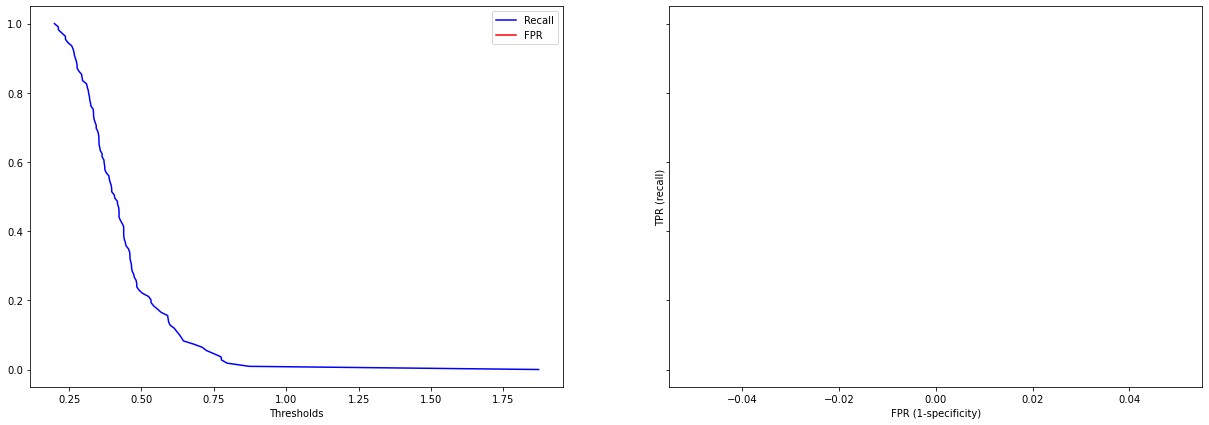

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.685467  0.572091   0.739981     0.798783  0.645128  0.745355
Validation  0.677770  0.550601   0.742900     0.805505  0.629216  0.735220

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008454  0.014999   0.014165     0.016179  0.010499  0.008641
Validation  0.036574  0.077771   0.053660     0.057668  0.052991  0.046382

Accuracy    Recall  Precision  Specificity        F1  \
Logistic Regression   0.67777  0.550601     0.7429     0.805505  0.629216   

                     ROC_AUC  
Logistic Regression  0.73522

Accuracy  \
Logistic Regression  0.6546385020618012-0.7009016931541513   

                                                   Recall  \
Logistic Regression  0.501413514037001-0.5997874867970273   

                                                Precision  \
Logistic Regression  0.7089626802181918-0.776837258490341   

                                               Specificity  \
Logistic Regression  0.7690322898694175-0.8419768844425091   

                                                        F1  \
Logistic Regression  0.5957011539502408-0.6627301595137074   

                                                   ROC_AUC  
Logistic Regression  0.7058856887145148-0.7645552750855937

In [123]:
run_models(selected_dataset, y[selected_dataset.index], {"Logistic Regression": LogisticRegression()}, ratio_negatives_to_positives=1)

╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.42000000000000004
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.46
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.52
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.54
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.56
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.58
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.6


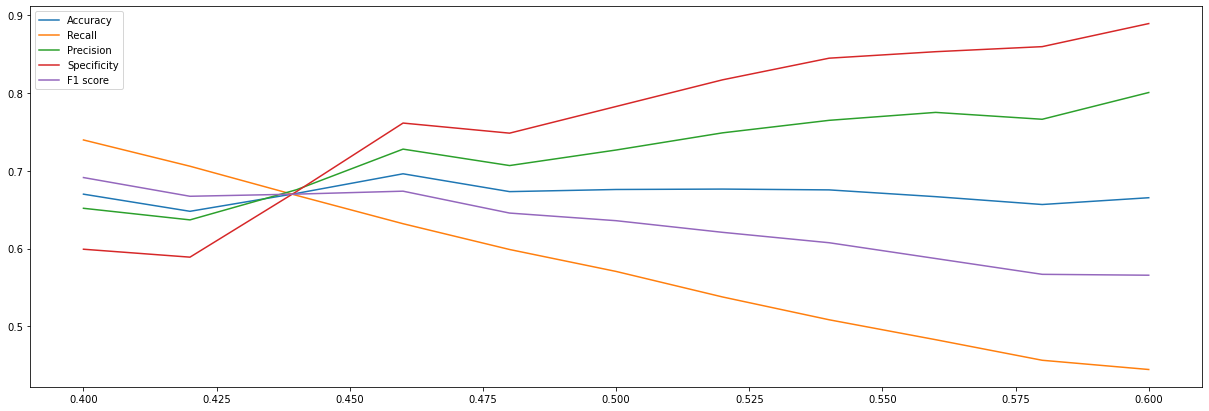

0.40      0.42      0.44      0.46      0.48      0.50  \
Accuracy     0.669793  0.647774  0.670776  0.695960  0.673053  0.675799   
Recall       0.739414  0.705681  0.668218  0.631832  0.598724  0.570546   
Precision    0.651648  0.636756  0.675496  0.727636  0.706540  0.726497   
Specificity  0.599074  0.588889  0.673148  0.761111  0.748148  0.782407   
F1           0.691128  0.667078  0.669845  0.673628  0.645517  0.635724   

                 0.52      0.54      0.56      0.58      0.60  
Accuracy     0.676325  0.675285  0.666584  0.656507  0.665221  
Recall       0.537738  0.508458  0.482883  0.456456  0.444595  
Precision    0.748563  0.764622  0.774811  0.765975  0.800341  
Specificity  0.816667  0.844444  0.852778  0.859259  0.888889  
F1           0.620763  0.607410  0.587128  0.566833  0.565694

In [115]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(.4,.6,num=11), folds=30)

As we can see, the performance of the model improves a little bit if we take the results of the statistical tests into consideration for selecting them (not much but its something)

In [300]:
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(selected_dataset, y[selected_dataset.index])
imputer = Imputer()
imputer.fit_transform(X_resample, y_resample)
imp_x = test_x[selected_dataset.columns].copy()
imputer.transform(imp_x)
lr = LogisticRegression()
lr.fit(X_resample, y_resample)
t_preds = lr.predict_proba(X_resample)
t_preds = pd.cut(t_preds[:,1], [-1, .44, 1.1], labels=["Negative", "Positive"], right=False)
preds = lr.predict_proba(imp_x)
preds = pd.cut(preds[:,1], [-1, .44, 1.1], labels=["Negative", "Positive"], right=False)
pd.DataFrame([get_metrics(y_resample, t_preds), get_metrics(test_y, preds)], index=["Training Data", "Validation Data"], columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"])

Accuracy    Recall  Precision  Specificiy        F1
Training Data    0.671436  0.696483   0.663258    0.646389  0.679465
Validation Data  0.057060  0.969466   0.025410    0.033340  0.049522

My project is crap. It doesn't seem to do anything on unseen data

## Dumping the model

In [97]:
import pickle

final_model = LogisticRegression()
imp = Imputer()
imp.fit_transform(selected_dataset, y[selected_dataset.index])
final_model.fit(selected_dataset, y[selected_dataset.index])
#pickle.dump(final_model, open("serialized_models/final_model", mode='wb'))

#test_model = pickle.load(open("serialized_models/final_model", mode='rb'))

p = final_model.predict(selected_dataset)
pp = final_model.predict_proba(selected_dataset)

ps = pd.cut(pp[:,1], [0, .5, 1], labels=["Negative", "Positive"], right=False) 
((p == ps) == 0).sum()
#pp[pp[:,1] > .5]

0

In [98]:
instance = dict(selected_dataset.loc[45622,:])
print(instance)
for value in instance:
    try:
        if(instance[value].dtype == "bool_"):
            instance[value] = bool(instance[value])
    except:
        1
    print(type(instance[value]))
len(instance)

{'wheezes': False, 'ctab': False, 'labored_respiration': False, 'rr': 0.6596513881662455, 'pulse': 0.6891688521995902, 'temperature': -0.15763246407326928, 'high_risk_exposure_occupation': False, 'cough': False, 'sob': False, 'loss_of_smell': False, 'muscle_sore': False, 'loss_of_taste': False, 'headache': False, 'days_since_symptom_onset': 3.0, 'fatigue': False, 'fever': False, 'asthma': False, 'smoker': False, 'diabetes': False}
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'numpy.float64'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>
<class 'bool'>


19

In [148]:
import requests
url = 'http://localhost:5000/predict'
r = requests.post(url,json=selected_dataset.loc[45622:45622,:].to_json())

print(r.json())

['Negative']


In [126]:
selected_dataset.loc[45622:45623,:].to_json(orient="records")

'[{"wheezes":null,"ctab":null,"pam":0.590493547,"rr":0.6596513882,"pulse":0.6891688522,"temperature":-0.1576324641,"high_risk_exposure_occupation":false,"cough":false,"loss_of_smell":false,"muscle_sore":false,"loss_of_taste":false,"headache":false,"days_since_symptom_onset":null,"fatigue":false,"fever":false,"diabetes":false},{"wheezes":true,"ctab":false,"pam":0.5598745,"rr":-1.3839187359,"pulse":0.2350161795,"temperature":-0.505726988,"high_risk_exposure_occupation":true,"cough":false,"loss_of_smell":false,"muscle_sore":false,"loss_of_taste":false,"headache":false,"days_since_symptom_onset":null,"fatigue":false,"fever":false,"diabetes":false}]'

In [133]:
run test_script 1

El caballero de Junini contraataca


In [132]:
exec(open("test_script.py").read())

El caballero de Junini contraataca
